In [29]:
#Imports
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns

import torch           
import torch.nn as nn   
import torchvision     
from torch.utils.data import Dataset, DataLoader, random_split, Subset 
import torchvision.transforms as tt 

import torch.nn.functional as F 

from torchvision.utils import make_grid  
import matplotlib.pyplot as plt          
from matplotlib.image import imread     
import os
import random
from tqdm import tqdm 

In [13]:
#Load and Modify Data
data_orig = pd.read_csv("final_data.csv")
#Remove NAs
data = data_orig.dropna()
print(data.head())

         Date     HomeTeam       AwayTeam FTR  B365H  B365D  B365A   WHH  WHD  \
0  11/08/2023      Burnley       Man City   A   8.00    5.5   1.33  8.00  5.0   
1  12/08/2023      Arsenal  Nott'm Forest   H   1.18    7.0  15.00  1.12  6.5   
2  12/08/2023  Bournemouth       West Ham   D   2.70    3.4   2.55  2.62  3.2   
3  12/08/2023     Brighton          Luton   H   1.33    5.5   9.00  1.25  4.6   
4  12/08/2023      Everton         Fulham   A   2.20    3.4   3.30  2.10  3.2   

     WHA  
0   1.25  
1  12.00  
2   2.30  
3   8.50  
4   3.00  


In [14]:
# Normalizing Data
# Ordinal Encoding for 'HomeTeam' and 'AwayTeam' columns
ordinal_encoder = OrdinalEncoder()
data[['HomeTeam', 'AwayTeam']] = ordinal_encoder.fit_transform(data[['HomeTeam', 'AwayTeam']])

# Encode 'FTR' column (Full Time Result)
ftr_mapping = {'H': 0, 'A': 1, 'D': 2}
data['outcome'] = data['FTR'].map(ftr_mapping)

# Scale numeric columns
scaler = MinMaxScaler()
num_cols = ['B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA', 'HomeTeam', 'AwayTeam']
data[num_cols] = scaler.fit_transform(data[num_cols])

# Drop unnecessary columns
data.drop(['Date', 'FTR'], axis=1, inplace=True)

/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_31341/3605380390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['HomeTeam', 'AwayTeam']] = ordinal_encoder.fit_transform(data[['HomeTeam', 'AwayTeam']])
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_31341/3605380390.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outcome'] = data['FTR'].map(ftr_mapping)
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_31341/3605380390.py:13: SettingWithCopyWarning: 
A valu

In [15]:
# Separate the features and the target variable
X = data.drop(columns=['outcome'])
y = data['outcome']

# Create polynomial features (excluding 'HomeTeam' and 'AwayTeam')
poly_cols = ['B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA']
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X[poly_cols])

# Create a dataframe with the new polynomial features
poly_feature_names = poly.get_feature_names_out(input_features=poly_cols)
poly_features = pd.DataFrame(X_poly, columns=poly_feature_names)

# Concatenate the polynomial features with the original features
data = pd.concat([X[['HomeTeam', 'AwayTeam']], poly_features, y], axis=1)

# Drop rows with NaN values
data = data.dropna()

print(data.head())
print(data.shape)

   HomeTeam  AwayTeam     B365H     B365D     B365A       WHH       WHD  \
0  0.214286  0.547619  0.316317  0.206897  0.005266  0.348697  0.180328   
1  0.000000  0.666667  0.005469  0.310345  0.348044  0.004008  0.303279   
2  0.142857  0.952381  0.074749  0.062069  0.035858  0.079158  0.032787   
3  0.190476  0.523810  0.012306  0.206897  0.197593  0.010521  0.147541   
4  0.357143  0.380952  0.051960  0.062069  0.054664  0.053106  0.032787   

        WHA   B365H^2  B365H B365D  ...  B365A WHH  B365A WHD  B365A WHA  \
0  0.003119  0.100057     0.065445  ...   0.001836   0.000950   0.000016   
1  0.242593  0.000030     0.001697  ...   0.001395   0.105554   0.084433   
2  0.026509  0.005587     0.004640  ...   0.002838   0.001176   0.000951   
3  0.164625  0.000151     0.002546  ...   0.002079   0.029153   0.032529   
4  0.042103  0.002700     0.003225  ...   0.002903   0.001792   0.002302   

      WHH^2   WHH WHD   WHH WHA     WHD^2   WHD WHA     WHA^2  outcome  
0  0.121590  0.0628

In [16]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['outcome']), data['outcome'], test_size=0.2, random_state=42, stratify=data['outcome'])

print(y_train.value_counts())
print(y_test.value_counts())

outcome
0.0    2971
1.0    1905
2.0    1598
Name: count, dtype: int64
outcome
0.0    743
1.0    477
2.0    399
Name: count, dtype: int64


In [17]:
class FeaturewiseAttention(nn.Module):
    def __init__(self, input_size):
        super(FeaturewiseAttention, self).__init__()
        self.attention = nn.Linear(input_size, input_size)

    def forward(self, x):
        # Apply attention to input features
        attention_scores = torch.sigmoid(self.attention(x))  # Use sigmoid to get values between 0 and 1
        return attention_scores * x  # Apply attention scores to the input

class MyMLPWithAttention(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyMLPWithAttention, self).__init__()
        self.input_size = input_size
        
        self.feature_attention = FeaturewiseAttention(self.input_size)
        
        self.fc1 = nn.Linear(self.input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)

        # Additional hidden layer
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.5)
        
        # Output layer
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.feature_attention(x)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        # Pass through the additional layer
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.fc4(x)  # No activation function here since you'll use nn.CrossEntropyLoss
        return x

In [18]:

input_size = X_train.shape[1]
print("input size:", input_size)
output_size = len(np.unique(y))
print("output size:", output_size)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).long()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).long()

# Create the dataset from tensors
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define your data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)  # Validation loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model
model = MyMLPWithAttention(input_size, output_size)

input size: 29
output size: 3


In [20]:
def training(model, loss_function, optimizer, scheduler, train_loader, val_loader, n_epochs, update_interval, patience):
    losses = []
    val_losses = []
    early_stopping_counter = 0
    min_val_loss = float('inf')
    
    for epoch in range(n_epochs):
        model.train()
        epoch_losses = []
        for i, (features, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(features)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            if i % update_interval == 0:
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                losses.append(round(avg_loss, 2))
                epoch_losses = []
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_epoch_losses = []
            for features, label in val_loader:
                output = model(features)
                val_loss = loss_function(output, label)
                val_epoch_losses.append(val_loss.item())

        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {losses[-1]}, Validation Loss: {avg_val_loss}")

        # Early stopping logic
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        if early_stopping_counter > patience:
            print(f"Stopping early at epoch {epoch+1}")
            break
        
        scheduler.step(avg_val_loss)  # Update learning rate based on validation loss
        
    return model, losses, val_losses

/Users/Andrew/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 81/81 [00:00<00:00, 395.87it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.0665528774261475


100%|██████████| 81/81 [00:00<00:00, 378.16it/s]


Epoch 2, Train Loss: 1.06, Validation Loss: 1.068287457738604


100%|██████████| 81/81 [00:00<00:00, 509.78it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.0701624949773152


100%|██████████| 81/81 [00:00<00:00, 525.18it/s]


Epoch 4, Train Loss: 1.04, Validation Loss: 1.0686378251938593


100%|██████████| 81/81 [00:00<00:00, 518.75it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0683010248910814


100%|██████████| 81/81 [00:00<00:00, 509.79it/s]


Epoch 6, Train Loss: 1.06, Validation Loss: 1.069473629906064


100%|██████████| 81/81 [00:00<00:00, 540.42it/s]


Epoch 7, Train Loss: 1.03, Validation Loss: 1.068911529722668


100%|██████████| 81/81 [00:00<00:00, 520.85it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0680459908076696


100%|██████████| 81/81 [00:00<00:00, 489.49it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0684602828252883


100%|██████████| 81/81 [00:00<00:00, 464.25it/s]


Epoch 10, Train Loss: 1.12, Validation Loss: 1.06789311340877


100%|██████████| 81/81 [00:00<00:00, 543.79it/s]


Epoch 11, Train Loss: 1.06, Validation Loss: 1.0679157404672532


100%|██████████| 81/81 [00:00<00:00, 508.51it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0672899200802757
Stopping early at epoch 12


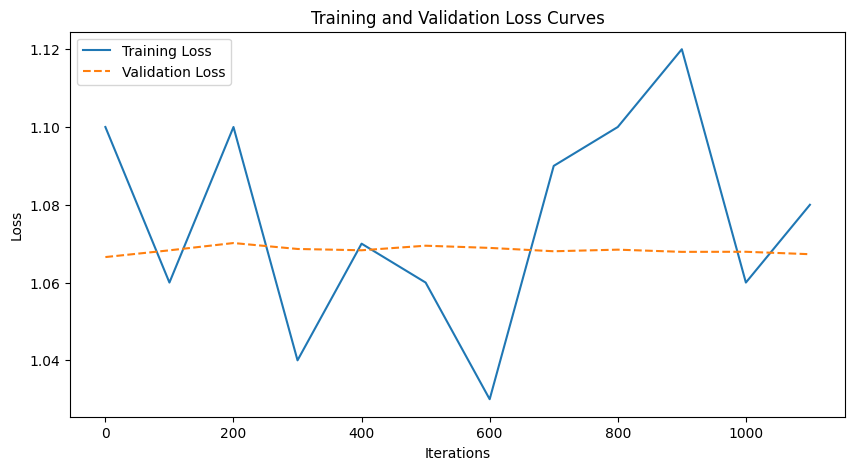

In [25]:
# Model Training
lr = 0.001
batch_size = 24
update_interval = 100
n_epochs = 50
patience = 10  # Early stopping patience

# Calculate class weights for handling imbalanced datasets
class_counts = y_train.value_counts().sort_index()
weights = 1. / class_counts
class_weights = torch.tensor(weights.values).float()

# Define the loss function with class weights
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

# Set up the optimizer with L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

# Setup ReduceLROnPlateau learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model using the enhanced training function
trained_model, training_losses, validation_losses = training(model, loss_function, optimizer, lr_scheduler, train_loader, val_loader, n_epochs, update_interval, patience)

# Plot training and validation losses to visualize the performance
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(training_losses)) * update_interval, training_losses, label='Training Loss')
plt.plot(np.arange(len(validation_losses)) * update_interval, validation_losses, label='Validation Loss', linestyle='--')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
def testing(model, loss_function, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_pred = []
    all_true = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            outputs = model(data)
            loss = loss_function(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_pred.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy, all_true, all_pred



In [27]:
# Assuming that trained_model and loss_function are already defined
test_loss, test_accuracy, all_true, all_pred = testing(trained_model, loss_function, test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

100%|██████████| 26/26 [00:00<00:00, 886.62it/s]

Test Loss: 0.0172, Test Accuracy: 41.38%


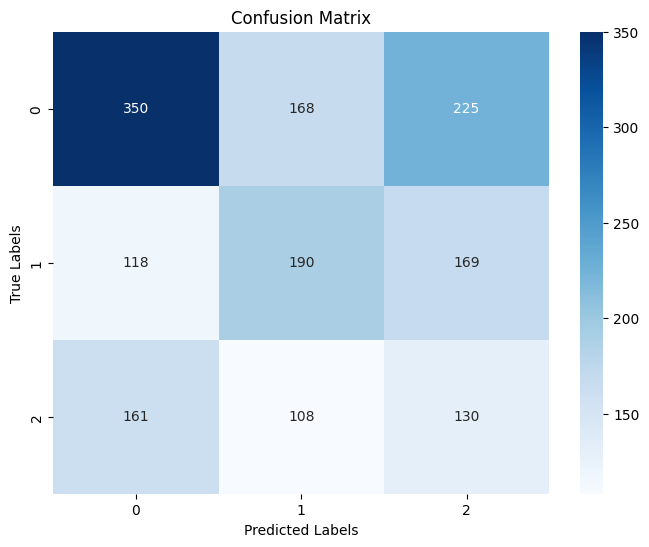

In [28]:
# Plot the confusion matrix
conf_mat = confusion_matrix(all_true, all_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

In [36]:
def K_fold(model_class, model_params, dataset, K=5):
    hyperparams_grid = {
        'batch_size': [24, 32, 64, 128, 256],
        'lr':  [0.0001, 0.001, 0.01, 0.1, 0.5],
        'n_epochs': [20, 30, 50, 75, 100],
        # The update interval can be removed if you are using early stopping
    }
    
    best_model = None
    best_accuracy = -1
    best_losses = []
    best_hyperparams = {}
    
    total_combinations = len(hyperparams_grid['batch_size']) * len(hyperparams_grid['lr']) * len(hyperparams_grid['n_epochs'])
    print("Total combinations: ", total_combinations)
    
    kfold = KFold(n_splits=K, shuffle=True, random_state=42)
    
    # Consider including patience and weight_decay if you are using early stopping and L2 regularization
    patience = 10
    weight_decay = 0.01

    all_classes = np.unique(dataset.tensors[1].numpy())
    
    for batch_size, lr, n_epochs in tqdm([(bs, lr, ep) for bs in hyperparams_grid['batch_size'] for lr in hyperparams_grid['lr'] for ep in hyperparams_grid['n_epochs']], total=total_combinations, desc='Hyperparameter Combinations'):
        print(f"Testing combination: Batch Size={batch_size}, LR={lr}, Epochs={n_epochs}")
        
        avg_accuracy = 0
        avg_loss = 0
        skip_combination = False
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{K}")
            
            train_subset = Subset(dataset, train_idx)
            y_train_fold = np.array([dataset.tensors[1][i] for i in train_idx])  # Correct way to get the labels for the current fold

            class_weights = compute_class_weight('balanced', classes=all_classes, y=y_train_fold)  # Use all_classes here
            class_weights = torch.tensor(class_weights, dtype=torch.float)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
            
            model = model_class(*model_params)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
            
            # Train model using the enhanced training method with early stopping and LR scheduling
            trained_model, training_losses, validation_losses = training(model, loss_function, optimizer, lr_scheduler, train_loader, val_loader, n_epochs, update_interval, patience)
            # Validate model using the testing method
            val_loss, val_accuracy, _, _ = testing(trained_model, loss_function, val_loader)
            
            if val_accuracy < 45:
                skip_combination = True
                print(f"Validation Accuracy: {val_accuracy}%")
                break
            
            avg_accuracy += val_accuracy
            avg_loss += val_loss
        
        if skip_combination:
            print("Skipping combination due to low accuracy")
            continue
        
        avg_accuracy /= K
        avg_loss /= K
        
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_model = trained_model
            best_losses.append(avg_loss)
            best_hyperparams = {
                'batch_size': batch_size,
                'lr': lr,
                'n_epochs': n_epochs,
                'patience': patience,
                'weight_decay': weight_decay
            }
            print(f"New best combination found: Average accuracy across folds: {avg_accuracy}%, Average loss: {avg_loss}")
    
    return best_model, best_losses, best_hyperparams

# Assuming the definition of compute_class_weight and the training function are already included above
best_model, best_losses, best_hyperparams = K_fold(MyMLPWithAttention, (input_size, output_size), train_dataset)


Total combinations:  125


Hyperparameter Combinations:   0%|          | 0/125 [00:00<?, ?it/s]

Testing combination: Batch Size=24, LR=0.0001, Epochs=20
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 538.29it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.0785232219431136


100%|██████████| 216/216 [00:00<00:00, 455.74it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.072225449261842


100%|██████████| 216/216 [00:00<00:00, 525.44it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.069272216823366


100%|██████████| 216/216 [00:00<00:00, 517.52it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.067457307268072


100%|██████████| 216/216 [00:00<00:00, 595.79it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.065758886160674


100%|██████████| 216/216 [00:00<00:00, 651.55it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.06659824318356


100%|██████████| 216/216 [00:00<00:00, 677.40it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0648071004284754


100%|██████████| 216/216 [00:00<00:00, 659.33it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0640836004857663


100%|██████████| 216/216 [00:00<00:00, 509.19it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.063998321692149


100%|██████████| 216/216 [00:00<00:00, 643.73it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.065064592493905


100%|██████████| 216/216 [00:00<00:00, 666.57it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0646488059450079


100%|██████████| 216/216 [00:00<00:00, 616.03it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.063778457818208


100%|██████████| 216/216 [00:00<00:00, 562.70it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0634208774125133


100%|██████████| 216/216 [00:00<00:00, 491.64it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0646148379202243


100%|██████████| 216/216 [00:00<00:00, 615.83it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0640722546312544


100%|██████████| 216/216 [00:00<00:00, 558.72it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0637882318761613


100%|██████████| 216/216 [00:00<00:00, 676.64it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0638703637652926


100%|██████████| 216/216 [00:00<00:00, 672.30it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0636731286843617


100%|██████████| 216/216 [00:00<00:00, 652.71it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0629008986331798


100%|██████████| 216/216 [00:00<00:00, 603.36it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0652261972427368


100%|██████████| 54/54 [00:00<00:00, 2309.47it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 563.88it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.085382134826095


100%|██████████| 216/216 [00:00<00:00, 508.72it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.0741791990068223


100%|██████████| 216/216 [00:00<00:00, 524.90it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.0714719262388017


100%|██████████| 216/216 [00:00<00:00, 461.46it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.068746476261704


100%|██████████| 216/216 [00:00<00:00, 548.51it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.0680760288680042


100%|██████████| 216/216 [00:00<00:00, 546.86it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0680387991446036


100%|██████████| 216/216 [00:00<00:00, 637.55it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0675754878256056


100%|██████████| 216/216 [00:00<00:00, 684.74it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0676522343247026


100%|██████████| 216/216 [00:00<00:00, 669.65it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0674476424853008


100%|██████████| 216/216 [00:00<00:00, 679.58it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0668722369052746


100%|██████████| 216/216 [00:00<00:00, 597.55it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0660974228823628


100%|██████████| 216/216 [00:00<00:00, 681.27it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.067306082557749


100%|██████████| 216/216 [00:00<00:00, 599.73it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0661359186525698


100%|██████████| 216/216 [00:00<00:00, 623.45it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0667228831185236


100%|██████████| 216/216 [00:00<00:00, 691.08it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0655473128513053


100%|██████████| 216/216 [00:00<00:00, 707.83it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0666937011259574


100%|██████████| 216/216 [00:00<00:00, 669.83it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.065623923584267


100%|██████████| 216/216 [00:00<00:00, 549.31it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0647115641170077


100%|██████████| 216/216 [00:00<00:00, 476.07it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0644934607876673


100%|██████████| 216/216 [00:00<00:00, 721.14it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0643930909810242


Hyperparameter Combinations:   1%|          | 1/125 [00:15<32:14, 15.60s/it]

Validation Accuracy: 42.54826254826255%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=30
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 686.28it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0800281387788278


100%|██████████| 216/216 [00:00<00:00, 730.91it/s]


Epoch 2, Train Loss: 1.13, Validation Loss: 1.0700993747622878


100%|██████████| 216/216 [00:00<00:00, 707.00it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.0668944948249393


100%|██████████| 216/216 [00:00<00:00, 676.56it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0643881879470967


100%|██████████| 216/216 [00:00<00:00, 652.42it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.064688597564344


100%|██████████| 216/216 [00:00<00:00, 683.98it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0632680974624775


100%|██████████| 216/216 [00:00<00:00, 492.30it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0632829312924985


100%|██████████| 216/216 [00:00<00:00, 531.54it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.063691872137564


100%|██████████| 216/216 [00:00<00:00, 550.40it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0631207636109106


100%|██████████| 216/216 [00:00<00:00, 522.81it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0630428504060816


100%|██████████| 216/216 [00:00<00:00, 548.11it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0637203366668135


100%|██████████| 216/216 [00:00<00:00, 665.34it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0637562528804496


100%|██████████| 216/216 [00:00<00:00, 689.33it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0645371300202828


100%|██████████| 216/216 [00:00<00:00, 562.37it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0640802151627011


100%|██████████| 216/216 [00:00<00:00, 677.05it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0638391353465892


100%|██████████| 216/216 [00:00<00:00, 588.81it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.064284802586944


100%|██████████| 216/216 [00:00<00:00, 622.39it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0645668738418155


100%|██████████| 216/216 [00:00<00:00, 567.91it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0636375149091084


100%|██████████| 216/216 [00:00<00:00, 542.94it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0636087490452661


100%|██████████| 216/216 [00:00<00:00, 548.93it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0645525323020086


100%|██████████| 216/216 [00:00<00:00, 559.18it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0641303912357047
Stopping early at epoch 21


Hyperparameter Combinations:   2%|▏         | 2/125 [00:23<22:54, 11.17s/it]

Validation Accuracy: 44.01544401544402%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=50
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 548.44it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.084254171009417


100%|██████████| 216/216 [00:00<00:00, 521.94it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.0769853591918945


100%|██████████| 216/216 [00:00<00:00, 557.10it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.0733488146905545


100%|██████████| 216/216 [00:00<00:00, 552.09it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.070653510314447


100%|██████████| 216/216 [00:00<00:00, 666.62it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.07004506499679


100%|██████████| 216/216 [00:00<00:00, 703.20it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0694372720188565


100%|██████████| 216/216 [00:00<00:00, 704.86it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0684802775029782


100%|██████████| 216/216 [00:00<00:00, 583.41it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0681881761109386


100%|██████████| 216/216 [00:00<00:00, 723.83it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0666388262201238


100%|██████████| 216/216 [00:00<00:00, 625.25it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0669933314676638


100%|██████████| 216/216 [00:00<00:00, 535.20it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0662609967920516


100%|██████████| 216/216 [00:00<00:00, 593.13it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.068247005895332


100%|██████████| 216/216 [00:00<00:00, 552.68it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0657254965217025


100%|██████████| 216/216 [00:00<00:00, 672.59it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0652811427911122


100%|██████████| 216/216 [00:00<00:00, 654.53it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0654284026887682


100%|██████████| 216/216 [00:00<00:00, 576.71it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0649176339308422


100%|██████████| 216/216 [00:00<00:00, 572.05it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.06535115175777


100%|██████████| 216/216 [00:00<00:00, 668.03it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0654371579488118


100%|██████████| 216/216 [00:00<00:00, 604.09it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0669995811250474


100%|██████████| 216/216 [00:00<00:00, 570.81it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0662239767886974


100%|██████████| 216/216 [00:00<00:00, 575.23it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0664050799828988


100%|██████████| 216/216 [00:00<00:00, 586.54it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0655410587787628


100%|██████████| 216/216 [00:00<00:00, 514.20it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0647793853724445


100%|██████████| 216/216 [00:00<00:00, 723.36it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0673511955473158


100%|██████████| 216/216 [00:00<00:00, 856.50it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.065160627718325


100%|██████████| 216/216 [00:00<00:00, 817.65it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.065073213091603


100%|██████████| 216/216 [00:00<00:00, 842.38it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0655299480314608


100%|██████████| 216/216 [00:00<00:00, 813.46it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0660863871927615


100%|██████████| 216/216 [00:00<00:00, 767.50it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0646243360307481


100%|██████████| 216/216 [00:00<00:00, 833.36it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0649747473222237


100%|██████████| 216/216 [00:00<00:00, 828.41it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.06565472262877


100%|██████████| 216/216 [00:00<00:00, 618.63it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0651855060347803


100%|██████████| 216/216 [00:00<00:00, 811.81it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.065134283569124


100%|██████████| 216/216 [00:00<00:00, 858.09it/s]


Epoch 34, Train Loss: 1.08, Validation Loss: 1.0653795114269964


100%|██████████| 216/216 [00:00<00:00, 824.98it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.0645490973084062


100%|██████████| 216/216 [00:00<00:00, 884.50it/s]


Epoch 36, Train Loss: 1.08, Validation Loss: 1.0647860666116078


100%|██████████| 216/216 [00:00<00:00, 834.25it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0653857798488051


100%|██████████| 216/216 [00:00<00:00, 824.49it/s]


Epoch 38, Train Loss: 1.08, Validation Loss: 1.0655580604517902


100%|██████████| 216/216 [00:00<00:00, 814.41it/s]


Epoch 39, Train Loss: 1.08, Validation Loss: 1.065275800448877


100%|██████████| 216/216 [00:00<00:00, 824.47it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.06604313188129


100%|██████████| 216/216 [00:00<00:00, 610.97it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0651959467817236


100%|██████████| 216/216 [00:00<00:00, 836.37it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0653108490837946


100%|██████████| 216/216 [00:00<00:00, 807.17it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0648687548107572


100%|██████████| 216/216 [00:00<00:00, 831.07it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0655781516322382


100%|██████████| 216/216 [00:00<00:00, 816.28it/s]


Epoch 45, Train Loss: 1.08, Validation Loss: 1.0646178876912151


100%|██████████| 216/216 [00:00<00:00, 868.53it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0657874555499465
Stopping early at epoch 46


Hyperparameter Combinations:   2%|▏         | 3/125 [00:39<26:42, 13.14s/it]

Validation Accuracy: 43.011583011583014%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=75
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 697.34it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0840842138837885


100%|██████████| 216/216 [00:00<00:00, 847.34it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.0719792732486018


100%|██████████| 216/216 [00:00<00:00, 640.49it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.069790675684258


100%|██████████| 216/216 [00:00<00:00, 824.43it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0708262169802631


100%|██████████| 216/216 [00:00<00:00, 836.36it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.068026175101598


100%|██████████| 216/216 [00:00<00:00, 803.69it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0682144816274997


100%|██████████| 216/216 [00:00<00:00, 814.73it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0678330372881006


100%|██████████| 216/216 [00:00<00:00, 859.82it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0666480638362743


100%|██████████| 216/216 [00:00<00:00, 869.03it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.06870796834981


100%|██████████| 216/216 [00:00<00:00, 834.47it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0680745597238894


100%|██████████| 216/216 [00:00<00:00, 654.24it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0690872768561046


100%|██████████| 216/216 [00:00<00:00, 841.23it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.067040295512588


100%|██████████| 216/216 [00:00<00:00, 812.14it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0687455236911774


100%|██████████| 216/216 [00:00<00:00, 868.45it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0675969344598275


100%|██████████| 216/216 [00:00<00:00, 831.27it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0673500917575978


100%|██████████| 216/216 [00:00<00:00, 825.21it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0667079201451055


100%|██████████| 216/216 [00:00<00:00, 861.89it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0663914095472407


100%|██████████| 216/216 [00:00<00:00, 788.81it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0670886591628745


100%|██████████| 216/216 [00:00<00:00, 648.30it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0674971562844735


100%|██████████| 216/216 [00:00<00:00, 843.13it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0669713649484847


100%|██████████| 216/216 [00:00<00:00, 871.35it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0669102293473702


100%|██████████| 216/216 [00:00<00:00, 814.64it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0676677701649842


100%|██████████| 216/216 [00:00<00:00, 843.17it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0671514195424538


100%|██████████| 216/216 [00:00<00:00, 817.68it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0678531063927545


100%|██████████| 216/216 [00:00<00:00, 826.94it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0665369409101981


100%|██████████| 216/216 [00:00<00:00, 823.64it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.066138137269903


100%|██████████| 216/216 [00:00<00:00, 657.06it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.066438787513309


100%|██████████| 216/216 [00:00<00:00, 864.00it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.0664091805617015


100%|██████████| 216/216 [00:00<00:00, 830.81it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0667771255528484


100%|██████████| 216/216 [00:00<00:00, 829.72it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0681203703085582


100%|██████████| 216/216 [00:00<00:00, 821.45it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0672791699568431


100%|██████████| 216/216 [00:00<00:00, 813.12it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0675969101764538


100%|██████████| 216/216 [00:00<00:00, 832.52it/s]


Epoch 33, Train Loss: 1.09, Validation Loss: 1.0671109391583338


100%|██████████| 216/216 [00:00<00:00, 811.13it/s]


Epoch 34, Train Loss: 1.08, Validation Loss: 1.067786509240115


100%|██████████| 216/216 [00:00<00:00, 803.86it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.0664642000639881


100%|██████████| 216/216 [00:00<00:00, 625.27it/s]


Epoch 36, Train Loss: 1.09, Validation Loss: 1.066541455410145


100%|██████████| 216/216 [00:00<00:00, 811.18it/s]


Epoch 37, Train Loss: 1.08, Validation Loss: 1.066146101112719
Stopping early at epoch 37


Hyperparameter Combinations:   3%|▎         | 4/125 [00:49<24:35, 12.20s/it]

Validation Accuracy: 41.15830115830116%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=100
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 818.03it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0927093360159132


100%|██████████| 216/216 [00:00<00:00, 813.72it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.0767157077789307


100%|██████████| 216/216 [00:00<00:00, 840.57it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.0698569107938696


100%|██████████| 216/216 [00:00<00:00, 825.63it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0668351749579112


100%|██████████| 216/216 [00:00<00:00, 809.43it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.065311466102247


100%|██████████| 216/216 [00:00<00:00, 651.69it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0656485160191853


100%|██████████| 216/216 [00:00<00:00, 865.35it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.064705111362316


100%|██████████| 216/216 [00:00<00:00, 856.63it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.0657879643970065


100%|██████████| 216/216 [00:00<00:00, 835.35it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0643079258777477


100%|██████████| 216/216 [00:00<00:00, 711.33it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0636128054724798


100%|██████████| 216/216 [00:00<00:00, 831.25it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.063935543651934


100%|██████████| 216/216 [00:00<00:00, 799.41it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0640246779830367


100%|██████████| 216/216 [00:00<00:00, 836.57it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0637152106673629


100%|██████████| 216/216 [00:00<00:00, 632.11it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.064048092674326


100%|██████████| 216/216 [00:00<00:00, 830.55it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0638414312292028


100%|██████████| 216/216 [00:00<00:00, 696.98it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0639170154377267


100%|██████████| 216/216 [00:00<00:00, 836.78it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0629235439830356


100%|██████████| 216/216 [00:00<00:00, 796.93it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.062530259291331


100%|██████████| 216/216 [00:00<00:00, 819.54it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0626204797515162


100%|██████████| 216/216 [00:00<00:00, 846.40it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0625017042513247


100%|██████████| 216/216 [00:00<00:00, 843.70it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0627908927422982


100%|██████████| 216/216 [00:00<00:00, 621.07it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0640915190732037


100%|██████████| 216/216 [00:00<00:00, 838.51it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.062897558565493


100%|██████████| 216/216 [00:00<00:00, 820.37it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0635746794718284


100%|██████████| 216/216 [00:00<00:00, 823.96it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0638542075951893


100%|██████████| 216/216 [00:00<00:00, 839.81it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0628195162172671


100%|██████████| 216/216 [00:00<00:00, 822.94it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0632805162005954


100%|██████████| 216/216 [00:00<00:00, 819.79it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0628769000371296


100%|██████████| 216/216 [00:00<00:00, 834.32it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0636129158514518


100%|██████████| 216/216 [00:00<00:00, 646.75it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0639673383147628


100%|██████████| 216/216 [00:00<00:00, 814.40it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0628011381184612
Stopping early at epoch 31


Hyperparameter Combinations:   4%|▍         | 5/125 [00:58<22:08, 11.07s/it]

Validation Accuracy: 44.16988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=20
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 834.00it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.0681122099911724


100%|██████████| 216/216 [00:00<00:00, 823.76it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0665056672361162


100%|██████████| 216/216 [00:00<00:00, 800.92it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.065550211403105


100%|██████████| 216/216 [00:00<00:00, 861.03it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0668529669443767


100%|██████████| 216/216 [00:00<00:00, 811.51it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0651908340277496


100%|██████████| 216/216 [00:00<00:00, 818.37it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0657661192946963


100%|██████████| 216/216 [00:00<00:00, 489.69it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0668876689893227


100%|██████████| 216/216 [00:00<00:00, 580.34it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0673019378273576


100%|██████████| 216/216 [00:00<00:00, 595.95it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0661448593492862


100%|██████████| 216/216 [00:00<00:00, 592.87it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0651601398432697


100%|██████████| 216/216 [00:00<00:00, 606.41it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0661488705211215


100%|██████████| 216/216 [00:00<00:00, 514.89it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0661332143677607


100%|██████████| 216/216 [00:00<00:00, 594.89it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.065093110005061


100%|██████████| 216/216 [00:00<00:00, 682.41it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.064988311794069


100%|██████████| 216/216 [00:00<00:00, 474.83it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0659458758654419


100%|██████████| 216/216 [00:00<00:00, 526.71it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.063392593904778


100%|██████████| 216/216 [00:00<00:00, 518.15it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0655003951655493


100%|██████████| 216/216 [00:00<00:00, 573.99it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0651263351793643


100%|██████████| 216/216 [00:00<00:00, 637.34it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0632983137060095


100%|██████████| 216/216 [00:00<00:00, 562.75it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.064884184687226


100%|██████████| 54/54 [00:00<00:00, 1776.83it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 571.57it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0714705884456635


100%|██████████| 216/216 [00:00<00:00, 634.50it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.070749251930802


100%|██████████| 216/216 [00:00<00:00, 598.62it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0676688717471228


100%|██████████| 216/216 [00:00<00:00, 504.26it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0666057864824932


100%|██████████| 216/216 [00:00<00:00, 691.90it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0712905161910586


100%|██████████| 216/216 [00:00<00:00, 698.35it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0676169726583693


100%|██████████| 216/216 [00:00<00:00, 699.66it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.069328040988357


100%|██████████| 216/216 [00:00<00:00, 620.58it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0702116798471522


100%|██████████| 216/216 [00:00<00:00, 696.20it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0680929013976344


100%|██████████| 216/216 [00:00<00:00, 610.60it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.06893464812526


100%|██████████| 216/216 [00:00<00:00, 510.57it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0674619950630047


100%|██████████| 216/216 [00:00<00:00, 609.11it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0683575184256942


100%|██████████| 216/216 [00:00<00:00, 616.74it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0663458947782163


100%|██████████| 216/216 [00:00<00:00, 685.43it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0657553120895669


100%|██████████| 216/216 [00:00<00:00, 687.01it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0669716519338113


100%|██████████| 216/216 [00:00<00:00, 534.69it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.065731030923349


100%|██████████| 216/216 [00:00<00:00, 534.58it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0666978579980355


100%|██████████| 216/216 [00:00<00:00, 514.80it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0648046312508759


100%|██████████| 216/216 [00:00<00:00, 703.33it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0647174881564245


100%|██████████| 216/216 [00:00<00:00, 660.46it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0653811902911574


Hyperparameter Combinations:   5%|▍         | 6/125 [01:14<24:37, 12.42s/it]

Validation Accuracy: 43.47490347490348%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=30
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 557.63it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0693955564940418


100%|██████████| 216/216 [00:00<00:00, 596.01it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0660528595800753


100%|██████████| 216/216 [00:00<00:00, 691.99it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0674863005125965


100%|██████████| 216/216 [00:00<00:00, 584.93it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0689048380763442


100%|██████████| 216/216 [00:00<00:00, 608.35it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0677187707689073


100%|██████████| 216/216 [00:00<00:00, 676.62it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0679010660560042


100%|██████████| 216/216 [00:00<00:00, 659.48it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0683383555323989


100%|██████████| 216/216 [00:00<00:00, 576.80it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0677390374519207


100%|██████████| 216/216 [00:00<00:00, 691.68it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.066896285171862


100%|██████████| 216/216 [00:00<00:00, 502.76it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0657016149273626


100%|██████████| 216/216 [00:00<00:00, 594.07it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.064869025239238


100%|██████████| 216/216 [00:00<00:00, 580.03it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0656034427660483


100%|██████████| 216/216 [00:00<00:00, 728.91it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0675082924189392


100%|██████████| 216/216 [00:00<00:00, 796.96it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0640715338565685


100%|██████████| 216/216 [00:00<00:00, 830.00it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0652485048329388


100%|██████████| 216/216 [00:00<00:00, 806.37it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0638727369131866


100%|██████████| 216/216 [00:00<00:00, 571.13it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0645586428818878


100%|██████████| 216/216 [00:00<00:00, 833.89it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0628404915332794


100%|██████████| 216/216 [00:00<00:00, 811.94it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.065150158272849


100%|██████████| 216/216 [00:00<00:00, 781.88it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0623429064397458


100%|██████████| 216/216 [00:00<00:00, 605.13it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0629424960524947


100%|██████████| 216/216 [00:00<00:00, 561.25it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0617413233827662


100%|██████████| 216/216 [00:00<00:00, 585.98it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0611449082692463


100%|██████████| 216/216 [00:00<00:00, 547.46it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0624317118415125


100%|██████████| 216/216 [00:00<00:00, 723.82it/s]


Epoch 25, Train Loss: 1.06, Validation Loss: 1.062770621644126


100%|██████████| 216/216 [00:00<00:00, 781.46it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0614326927396986


100%|██████████| 216/216 [00:00<00:00, 810.42it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0612917023676414


100%|██████████| 216/216 [00:00<00:00, 800.02it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.0602921335785478


100%|██████████| 216/216 [00:00<00:00, 794.74it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.0592444373501673


100%|██████████| 216/216 [00:00<00:00, 753.90it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0597117576334212


Hyperparameter Combinations:   6%|▌         | 7/125 [01:24<23:07, 11.76s/it]

Validation Accuracy: 44.55598455598456%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=50
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 574.24it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0689408668765314


100%|██████████| 216/216 [00:00<00:00, 584.48it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0673941440052457


100%|██████████| 216/216 [00:00<00:00, 786.22it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0674396598780598


100%|██████████| 216/216 [00:00<00:00, 693.79it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0667803751097784


100%|██████████| 216/216 [00:00<00:00, 794.33it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.067893980829804


100%|██████████| 216/216 [00:00<00:00, 833.24it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0699749997368566


100%|██████████| 216/216 [00:00<00:00, 820.38it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0667416122224596


100%|██████████| 216/216 [00:00<00:00, 836.24it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.065731394070166


100%|██████████| 216/216 [00:00<00:00, 848.08it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0685364118328802


100%|██████████| 216/216 [00:00<00:00, 850.44it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.066398047738605


100%|██████████| 216/216 [00:00<00:00, 634.29it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.067779943898872


100%|██████████| 216/216 [00:00<00:00, 827.59it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0693501543115687


100%|██████████| 216/216 [00:00<00:00, 801.34it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0672162418012265


100%|██████████| 216/216 [00:00<00:00, 830.61it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0670335745369945


100%|██████████| 216/216 [00:00<00:00, 857.19it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0668859713607364


100%|██████████| 216/216 [00:00<00:00, 861.34it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0659953675888203


100%|██████████| 216/216 [00:00<00:00, 636.81it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0661182237995996


100%|██████████| 216/216 [00:00<00:00, 822.60it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0655534245349743


100%|██████████| 216/216 [00:00<00:00, 600.22it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.063198462680534


100%|██████████| 216/216 [00:00<00:00, 853.76it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0634497922879678


100%|██████████| 216/216 [00:00<00:00, 849.98it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0629477556105014


100%|██████████| 216/216 [00:00<00:00, 635.01it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0640462217507538


100%|██████████| 216/216 [00:00<00:00, 822.34it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0644794669416215


100%|██████████| 216/216 [00:00<00:00, 810.18it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.063475129780946


100%|██████████| 216/216 [00:00<00:00, 829.59it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0643152208239943


100%|██████████| 216/216 [00:00<00:00, 819.31it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0638278777952548


100%|██████████| 216/216 [00:00<00:00, 838.97it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0629569523864322


100%|██████████| 216/216 [00:00<00:00, 830.04it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0623626929742318


100%|██████████| 216/216 [00:00<00:00, 807.65it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.063770705903018


100%|██████████| 216/216 [00:00<00:00, 843.51it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0620270194830719


100%|██████████| 216/216 [00:00<00:00, 656.95it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0616121810895425


100%|██████████| 216/216 [00:00<00:00, 823.12it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0631354230421561


100%|██████████| 216/216 [00:00<00:00, 854.58it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0642836557494268


100%|██████████| 216/216 [00:00<00:00, 805.74it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0622538846951943


100%|██████████| 216/216 [00:00<00:00, 813.15it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0610576857019354


100%|██████████| 216/216 [00:00<00:00, 826.32it/s]


Epoch 36, Train Loss: 1.06, Validation Loss: 1.0640973382525973


100%|██████████| 216/216 [00:00<00:00, 850.08it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0630552603138819


100%|██████████| 216/216 [00:00<00:00, 859.25it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0635022808004309


100%|██████████| 216/216 [00:00<00:00, 840.58it/s]


Epoch 39, Train Loss: 1.06, Validation Loss: 1.062171702031736


100%|██████████| 216/216 [00:00<00:00, 642.73it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.0617638572498604


100%|██████████| 216/216 [00:00<00:00, 834.59it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0619253736955148


100%|██████████| 216/216 [00:00<00:00, 788.19it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.063096092806922


100%|██████████| 216/216 [00:00<00:00, 835.32it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0629763846044187


100%|██████████| 216/216 [00:00<00:00, 862.71it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.060720952572646


100%|██████████| 216/216 [00:00<00:00, 817.58it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.0614779746090923


100%|██████████| 216/216 [00:00<00:00, 853.24it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0621548261907365


100%|██████████| 216/216 [00:00<00:00, 842.07it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.0617486900753446


100%|██████████| 216/216 [00:00<00:00, 871.61it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0608930080025285


100%|██████████| 216/216 [00:00<00:00, 820.60it/s]


Epoch 49, Train Loss: 1.07, Validation Loss: 1.062744826078415


100%|██████████| 216/216 [00:00<00:00, 588.49it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0615271109121818


100%|██████████| 54/54 [00:00<00:00, 2680.45it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 611.33it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0731102404771027


100%|██████████| 216/216 [00:00<00:00, 522.88it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0679632866824116


100%|██████████| 216/216 [00:00<00:00, 586.02it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0682670109801822


100%|██████████| 216/216 [00:00<00:00, 582.91it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.068448382395285


100%|██████████| 216/216 [00:00<00:00, 579.18it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0672261008509882


100%|██████████| 216/216 [00:00<00:00, 586.45it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.067221381046154


100%|██████████| 216/216 [00:00<00:00, 624.43it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0672959012013894


100%|██████████| 216/216 [00:00<00:00, 845.08it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0687611390043188


100%|██████████| 216/216 [00:00<00:00, 844.99it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.068821202825617


100%|██████████| 216/216 [00:00<00:00, 840.90it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.067117240693834


100%|██████████| 216/216 [00:00<00:00, 863.52it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0687881818524114


100%|██████████| 216/216 [00:00<00:00, 834.72it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0663394298818376


100%|██████████| 216/216 [00:00<00:00, 836.69it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0694740271126781


100%|██████████| 216/216 [00:00<00:00, 836.57it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0686572657691107


100%|██████████| 216/216 [00:00<00:00, 858.52it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0687697684323345


100%|██████████| 216/216 [00:00<00:00, 820.72it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.067876649123651


100%|██████████| 216/216 [00:00<00:00, 647.93it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0676244673905548


100%|██████████| 216/216 [00:00<00:00, 840.07it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0676590833399031


100%|██████████| 216/216 [00:00<00:00, 837.39it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.066009908914566


100%|██████████| 216/216 [00:00<00:00, 800.68it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0672754568082314


100%|██████████| 216/216 [00:00<00:00, 867.53it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0645558105574713


100%|██████████| 216/216 [00:00<00:00, 817.49it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.066853290354764


100%|██████████| 216/216 [00:00<00:00, 784.81it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0645290094393272


100%|██████████| 216/216 [00:00<00:00, 852.75it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.0645081941728238


100%|██████████| 216/216 [00:00<00:00, 823.92it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0643707977400885


100%|██████████| 216/216 [00:00<00:00, 810.37it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.063995690257461


100%|██████████| 216/216 [00:00<00:00, 656.46it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0642333979959842


100%|██████████| 216/216 [00:00<00:00, 827.79it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.063198874394099


100%|██████████| 216/216 [00:00<00:00, 844.99it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.063627851230127


100%|██████████| 216/216 [00:00<00:00, 832.28it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0640598149211318


100%|██████████| 216/216 [00:00<00:00, 837.82it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.062658178585547


100%|██████████| 216/216 [00:00<00:00, 845.17it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0623638177359547


100%|██████████| 216/216 [00:00<00:00, 819.08it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.062642451789644


100%|██████████| 216/216 [00:00<00:00, 804.24it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0614220201969147


100%|██████████| 216/216 [00:00<00:00, 828.37it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0623232457372878


100%|██████████| 216/216 [00:00<00:00, 644.85it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.0635377301110163


100%|██████████| 216/216 [00:00<00:00, 852.35it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0631820018644687


100%|██████████| 216/216 [00:00<00:00, 822.49it/s]


Epoch 38, Train Loss: 1.08, Validation Loss: 1.0627015111622986


100%|██████████| 216/216 [00:00<00:00, 868.12it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0626518516628831


100%|██████████| 216/216 [00:00<00:00, 835.73it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.06312111792741


100%|██████████| 216/216 [00:00<00:00, 843.85it/s]


Epoch 41, Train Loss: 1.06, Validation Loss: 1.062145992561623


100%|██████████| 216/216 [00:00<00:00, 820.35it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0612976562093805


100%|██████████| 216/216 [00:00<00:00, 879.03it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.061633062583429


100%|██████████| 216/216 [00:00<00:00, 838.35it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0619598903037883


100%|██████████| 216/216 [00:00<00:00, 797.83it/s]


Epoch 45, Train Loss: 1.06, Validation Loss: 1.0622595979107752


100%|██████████| 216/216 [00:00<00:00, 628.19it/s]


Epoch 46, Train Loss: 1.06, Validation Loss: 1.0619340307182736


100%|██████████| 216/216 [00:00<00:00, 814.26it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.0616587886103876


100%|██████████| 216/216 [00:00<00:00, 845.26it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0623883273866441


100%|██████████| 216/216 [00:00<00:00, 819.70it/s]


Epoch 49, Train Loss: 1.06, Validation Loss: 1.063191885197604


100%|██████████| 216/216 [00:00<00:00, 831.85it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0620331775259089


100%|██████████| 54/54 [00:00<00:00, 2861.99it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 682.59it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.0702498224046495


100%|██████████| 216/216 [00:00<00:00, 840.46it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0664361593899903


100%|██████████| 216/216 [00:00<00:00, 831.43it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0685669923270191


100%|██████████| 216/216 [00:00<00:00, 853.11it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0671423265227564


100%|██████████| 216/216 [00:00<00:00, 832.25it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.066167860119431


100%|██████████| 216/216 [00:00<00:00, 656.36it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0687133449095267


100%|██████████| 216/216 [00:00<00:00, 847.48it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0692022233097642


100%|██████████| 216/216 [00:00<00:00, 794.89it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0676935392397422


100%|██████████| 216/216 [00:00<00:00, 839.59it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0658869688157682


100%|██████████| 216/216 [00:00<00:00, 841.36it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0665419918519479


100%|██████████| 216/216 [00:00<00:00, 819.78it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0714357958899603


100%|██████████| 216/216 [00:00<00:00, 823.04it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0673730814898457


100%|██████████| 216/216 [00:00<00:00, 852.12it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0684034427007039


100%|██████████| 216/216 [00:00<00:00, 817.95it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0704123532330547


100%|██████████| 216/216 [00:00<00:00, 857.05it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.069714939152753


100%|██████████| 216/216 [00:00<00:00, 654.66it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0690207735255912


100%|██████████| 216/216 [00:00<00:00, 816.49it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0698654375694416


100%|██████████| 216/216 [00:00<00:00, 831.25it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0675061643123627


100%|██████████| 216/216 [00:00<00:00, 866.61it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.066690531041887


100%|██████████| 216/216 [00:00<00:00, 801.02it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0679475885850411
Stopping early at epoch 20


100%|██████████| 54/54 [00:00<00:00, 2706.39it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 831.90it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0698988945395858


100%|██████████| 216/216 [00:00<00:00, 854.05it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.067647326875616


100%|██████████| 216/216 [00:00<00:00, 840.03it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0685530161416088


100%|██████████| 216/216 [00:00<00:00, 839.34it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0659793140711609


100%|██████████| 216/216 [00:00<00:00, 639.39it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0668952034579382


100%|██████████| 216/216 [00:00<00:00, 799.68it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0670020238116935


100%|██████████| 216/216 [00:00<00:00, 841.58it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0673683925911233


100%|██████████| 216/216 [00:00<00:00, 842.09it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0671185851097107


100%|██████████| 216/216 [00:00<00:00, 847.14it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0692039330800374


100%|██████████| 216/216 [00:00<00:00, 829.47it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0662452600620411


100%|██████████| 216/216 [00:00<00:00, 866.70it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0647069580025144


100%|██████████| 216/216 [00:00<00:00, 840.92it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0664513055925016


100%|██████████| 216/216 [00:00<00:00, 832.37it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0651494904800698


100%|██████████| 216/216 [00:00<00:00, 673.13it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0636540011123374


100%|██████████| 216/216 [00:00<00:00, 863.30it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0641908601478294


100%|██████████| 216/216 [00:00<00:00, 791.10it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0632252913934213


100%|██████████| 216/216 [00:00<00:00, 815.60it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0639401376247406


100%|██████████| 216/216 [00:00<00:00, 817.39it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0631259315543704


100%|██████████| 216/216 [00:00<00:00, 774.06it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0637260211838617


100%|██████████| 216/216 [00:00<00:00, 819.73it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0637637895566445


100%|██████████| 216/216 [00:00<00:00, 844.07it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0636122149449807


100%|██████████| 216/216 [00:00<00:00, 746.11it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0634202029969957


100%|██████████| 216/216 [00:00<00:00, 819.76it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0647239254580603


100%|██████████| 216/216 [00:00<00:00, 642.94it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0626464839334842


100%|██████████| 216/216 [00:00<00:00, 820.52it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0629518263869815


100%|██████████| 216/216 [00:00<00:00, 851.73it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0619084095513378


100%|██████████| 216/216 [00:00<00:00, 842.73it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.063805005064717


100%|██████████| 216/216 [00:00<00:00, 836.53it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.0633268919255998


100%|██████████| 216/216 [00:00<00:00, 843.91it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0635733306407928


100%|██████████| 216/216 [00:00<00:00, 848.49it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0629885384330042


100%|██████████| 216/216 [00:00<00:00, 822.95it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0636982332777094


100%|██████████| 216/216 [00:00<00:00, 805.80it/s]


Epoch 32, Train Loss: 1.06, Validation Loss: 1.0624414450592465


100%|██████████| 216/216 [00:00<00:00, 573.15it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.06328476579101


100%|██████████| 216/216 [00:00<00:00, 822.66it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.062568978027061


100%|██████████| 216/216 [00:00<00:00, 840.57it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0611219969060686


100%|██████████| 216/216 [00:00<00:00, 848.04it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.063351081477271


100%|██████████| 216/216 [00:00<00:00, 820.48it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0613954431480832


100%|██████████| 216/216 [00:00<00:00, 835.53it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0634047576674708


100%|██████████| 216/216 [00:00<00:00, 848.29it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.063233760771928


100%|██████████| 216/216 [00:00<00:00, 840.22it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.0625952151086595


100%|██████████| 216/216 [00:00<00:00, 824.43it/s]


Epoch 41, Train Loss: 1.06, Validation Loss: 1.0604981426839475


100%|██████████| 216/216 [00:00<00:00, 832.42it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0643858876493242


100%|██████████| 216/216 [00:00<00:00, 648.48it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0627451539039612


100%|██████████| 216/216 [00:00<00:00, 805.29it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0620012360590476


100%|██████████| 216/216 [00:00<00:00, 839.38it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.0620545303380047


100%|██████████| 216/216 [00:00<00:00, 723.16it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0637412214720692


100%|██████████| 216/216 [00:00<00:00, 638.82it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.0617975504310042


100%|██████████| 216/216 [00:00<00:00, 613.25it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0623908627916265


100%|██████████| 216/216 [00:00<00:00, 507.15it/s]


Epoch 49, Train Loss: 1.07, Validation Loss: 1.0639255698080416


100%|██████████| 216/216 [00:00<00:00, 530.84it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0616382537064728


Hyperparameter Combinations:   6%|▋         | 8/125 [02:14<46:59, 24.10s/it]

Validation Accuracy: 44.4015444015444%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=75
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 437.91it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.0683800026222512


100%|██████████| 216/216 [00:00<00:00, 559.10it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.068705427425879


100%|██████████| 216/216 [00:00<00:00, 634.73it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0683030508182667


100%|██████████| 216/216 [00:00<00:00, 614.43it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0690362530725974


100%|██████████| 216/216 [00:00<00:00, 470.62it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0667998945271526


100%|██████████| 216/216 [00:00<00:00, 554.22it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0678529927024134


100%|██████████| 216/216 [00:00<00:00, 627.41it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0656918309353016


100%|██████████| 216/216 [00:00<00:00, 755.21it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0687826750455078


100%|██████████| 216/216 [00:00<00:00, 749.85it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0706644698425576


100%|██████████| 216/216 [00:00<00:00, 607.37it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0670357964656971


100%|██████████| 216/216 [00:00<00:00, 561.47it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.068346897761027


100%|██████████| 216/216 [00:00<00:00, 478.54it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0680210126770868


100%|██████████| 216/216 [00:00<00:00, 593.89it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0665000721260354


100%|██████████| 216/216 [00:00<00:00, 548.47it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0657552789758753


100%|██████████| 216/216 [00:00<00:00, 577.34it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.064551654789183


100%|██████████| 216/216 [00:00<00:00, 598.47it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0651704249558624


100%|██████████| 216/216 [00:00<00:00, 556.34it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.065038463583699


100%|██████████| 216/216 [00:00<00:00, 560.13it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.064635796679391


100%|██████████| 216/216 [00:00<00:00, 557.85it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0649222875082935


100%|██████████| 216/216 [00:00<00:00, 467.46it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0633584956328075


100%|██████████| 216/216 [00:00<00:00, 684.37it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0664247749028382


100%|██████████| 216/216 [00:00<00:00, 547.70it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0642499206242737


100%|██████████| 216/216 [00:00<00:00, 550.69it/s]


Epoch 23, Train Loss: 1.06, Validation Loss: 1.0639060923346766


100%|██████████| 216/216 [00:00<00:00, 533.53it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0622819408222481


100%|██████████| 216/216 [00:00<00:00, 685.14it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0640700790617201


100%|██████████| 216/216 [00:00<00:00, 595.12it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0624736900682803


100%|██████████| 216/216 [00:00<00:00, 572.93it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0654358632034726


100%|██████████| 216/216 [00:00<00:00, 533.98it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0631371151517939


100%|██████████| 216/216 [00:00<00:00, 818.43it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0628915539494268


100%|██████████| 216/216 [00:00<00:00, 775.01it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.062497881827531


100%|██████████| 216/216 [00:00<00:00, 815.63it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0617813423827842


100%|██████████| 216/216 [00:00<00:00, 763.20it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0633615288469527


100%|██████████| 216/216 [00:00<00:00, 742.30it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0622190568182204


100%|██████████| 216/216 [00:00<00:00, 792.55it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0620846637973078


100%|██████████| 216/216 [00:00<00:00, 802.68it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0623686622690272


100%|██████████| 216/216 [00:00<00:00, 766.14it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.061517424053616


100%|██████████| 216/216 [00:00<00:00, 814.95it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0611975060568914


100%|██████████| 216/216 [00:00<00:00, 810.59it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0644268581160792


100%|██████████| 216/216 [00:00<00:00, 603.80it/s]


Epoch 39, Train Loss: 1.06, Validation Loss: 1.0622642481768574


100%|██████████| 216/216 [00:00<00:00, 796.40it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.063481620064488


100%|██████████| 216/216 [00:00<00:00, 809.77it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0619717571470473


100%|██████████| 216/216 [00:00<00:00, 803.35it/s]


Epoch 42, Train Loss: 1.06, Validation Loss: 1.061500601194523


100%|██████████| 216/216 [00:00<00:00, 704.17it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0614139360410195


100%|██████████| 216/216 [00:00<00:00, 765.01it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0616011961742684


100%|██████████| 216/216 [00:00<00:00, 848.29it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.0619232091638777


100%|██████████| 216/216 [00:00<00:00, 815.89it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0626634271056563


100%|██████████| 216/216 [00:00<00:00, 852.20it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.0619750729313604


100%|██████████| 216/216 [00:00<00:00, 646.66it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0625972516006894
Stopping early at epoch 48


Hyperparameter Combinations:   7%|▋         | 9/125 [02:32<42:25, 21.95s/it]

Validation Accuracy: 44.78764478764479%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=100
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 851.58it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.0729431178834703


100%|██████████| 216/216 [00:00<00:00, 783.65it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0726892252763112


100%|██████████| 216/216 [00:00<00:00, 849.30it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0672170994458374


100%|██████████| 216/216 [00:00<00:00, 819.48it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0664783285723791


100%|██████████| 216/216 [00:00<00:00, 767.57it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.067137289930273


100%|██████████| 216/216 [00:00<00:00, 805.87it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0714424042790025


100%|██████████| 216/216 [00:00<00:00, 823.25it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0678987050497974


100%|██████████| 216/216 [00:00<00:00, 825.97it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0675099646603619


100%|██████████| 216/216 [00:00<00:00, 825.32it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.068702299285818


100%|██████████| 216/216 [00:00<00:00, 610.02it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0658352264651545


100%|██████████| 216/216 [00:00<00:00, 796.87it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.066471818420622


100%|██████████| 216/216 [00:00<00:00, 811.33it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0701667732662625


100%|██████████| 216/216 [00:00<00:00, 830.75it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0688961689118985


100%|██████████| 216/216 [00:00<00:00, 818.97it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0667527428379766


100%|██████████| 216/216 [00:00<00:00, 851.80it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0688052663096674


100%|██████████| 216/216 [00:00<00:00, 826.94it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0691970818572574


100%|██████████| 216/216 [00:00<00:00, 846.26it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.067023558749093


100%|██████████| 216/216 [00:00<00:00, 838.15it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.066875276742158


100%|██████████| 216/216 [00:00<00:00, 843.43it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0656688102969416


100%|██████████| 216/216 [00:00<00:00, 660.02it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0667587595957297


100%|██████████| 216/216 [00:00<00:00, 833.31it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0682847808908533


100%|██████████| 216/216 [00:00<00:00, 824.93it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0666711076542184


100%|██████████| 216/216 [00:00<00:00, 868.43it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0661613477600946


100%|██████████| 216/216 [00:00<00:00, 854.33it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0648711224397023


100%|██████████| 216/216 [00:00<00:00, 841.06it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0655291356422283


100%|██████████| 216/216 [00:00<00:00, 685.05it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0645330868385456


100%|██████████| 216/216 [00:00<00:00, 849.69it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0637445803041812


100%|██████████| 216/216 [00:00<00:00, 869.96it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.06472756796413


100%|██████████| 216/216 [00:00<00:00, 836.61it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0635297177014527


100%|██████████| 216/216 [00:00<00:00, 786.37it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.063601553440094


100%|██████████| 216/216 [00:00<00:00, 512.85it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.064426906682827


100%|██████████| 216/216 [00:00<00:00, 597.45it/s]


Epoch 32, Train Loss: 1.06, Validation Loss: 1.0626063788378681


100%|██████████| 216/216 [00:00<00:00, 591.88it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.062759961243029


100%|██████████| 216/216 [00:00<00:00, 585.55it/s]


Epoch 34, Train Loss: 1.08, Validation Loss: 1.063863448522709


100%|██████████| 216/216 [00:00<00:00, 589.74it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0615996398307659


100%|██████████| 216/216 [00:00<00:00, 835.97it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.0631549612239555


100%|██████████| 216/216 [00:00<00:00, 875.08it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.062453199315954


100%|██████████| 216/216 [00:00<00:00, 823.61it/s]


Epoch 38, Train Loss: 1.06, Validation Loss: 1.060609653040215


100%|██████████| 216/216 [00:00<00:00, 826.03it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0611290092821475


100%|██████████| 216/216 [00:00<00:00, 847.88it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.062000377310647


100%|██████████| 216/216 [00:00<00:00, 655.26it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0611183952402186


100%|██████████| 216/216 [00:00<00:00, 839.84it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0616825653447046


100%|██████████| 216/216 [00:00<00:00, 870.75it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.059576529043692


100%|██████████| 216/216 [00:00<00:00, 859.53it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0627478615001396


100%|██████████| 216/216 [00:00<00:00, 822.73it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.0610115318386644


100%|██████████| 216/216 [00:00<00:00, 878.39it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0610473365695388


100%|██████████| 216/216 [00:00<00:00, 880.42it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.060450295607249


100%|██████████| 216/216 [00:00<00:00, 851.93it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0598017264295507


100%|██████████| 216/216 [00:00<00:00, 822.43it/s]


Epoch 49, Train Loss: 1.07, Validation Loss: 1.0611993306212955


100%|██████████| 216/216 [00:00<00:00, 838.23it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0604252737981301


100%|██████████| 216/216 [00:00<00:00, 518.70it/s]


Epoch 51, Train Loss: 1.06, Validation Loss: 1.0606473993372034


100%|██████████| 216/216 [00:00<00:00, 600.04it/s]


Epoch 52, Train Loss: 1.07, Validation Loss: 1.0617597941999082


100%|██████████| 216/216 [00:00<00:00, 588.39it/s]


Epoch 53, Train Loss: 1.07, Validation Loss: 1.0590102893334847


100%|██████████| 216/216 [00:00<00:00, 595.96it/s]


Epoch 54, Train Loss: 1.07, Validation Loss: 1.0585749789520547


100%|██████████| 216/216 [00:00<00:00, 652.89it/s]


Epoch 55, Train Loss: 1.07, Validation Loss: 1.059187690416972


100%|██████████| 216/216 [00:00<00:00, 828.06it/s]


Epoch 56, Train Loss: 1.07, Validation Loss: 1.0594665860688244


100%|██████████| 216/216 [00:00<00:00, 817.14it/s]


Epoch 57, Train Loss: 1.07, Validation Loss: 1.0585015416145325


100%|██████████| 216/216 [00:00<00:00, 878.02it/s]


Epoch 58, Train Loss: 1.07, Validation Loss: 1.0613559065041718


100%|██████████| 216/216 [00:00<00:00, 878.39it/s]


Epoch 59, Train Loss: 1.07, Validation Loss: 1.059033845309858


100%|██████████| 216/216 [00:00<00:00, 835.98it/s]


Epoch 60, Train Loss: 1.06, Validation Loss: 1.0599157026520483


100%|██████████| 216/216 [00:00<00:00, 648.90it/s]


Epoch 61, Train Loss: 1.07, Validation Loss: 1.060188631216685


100%|██████████| 216/216 [00:00<00:00, 837.40it/s]


Epoch 62, Train Loss: 1.06, Validation Loss: 1.060138914320204


100%|██████████| 216/216 [00:00<00:00, 871.62it/s]


Epoch 63, Train Loss: 1.06, Validation Loss: 1.058852873466633


100%|██████████| 216/216 [00:00<00:00, 815.65it/s]


Epoch 64, Train Loss: 1.06, Validation Loss: 1.0589612667207364


100%|██████████| 216/216 [00:00<00:00, 822.52it/s]


Epoch 65, Train Loss: 1.07, Validation Loss: 1.0590352173204776


100%|██████████| 216/216 [00:00<00:00, 809.73it/s]


Epoch 66, Train Loss: 1.07, Validation Loss: 1.060021721654468


100%|██████████| 216/216 [00:00<00:00, 754.17it/s]


Epoch 67, Train Loss: 1.07, Validation Loss: 1.0592619765687872


100%|██████████| 216/216 [00:00<00:00, 851.13it/s]


Epoch 68, Train Loss: 1.06, Validation Loss: 1.0607610256583602
Stopping early at epoch 68


100%|██████████| 54/54 [00:00<00:00, 2695.54it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 718.90it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.0684045674624267


100%|██████████| 216/216 [00:00<00:00, 849.35it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0681380563312106


100%|██████████| 216/216 [00:00<00:00, 839.83it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0688438106466223


100%|██████████| 216/216 [00:00<00:00, 639.84it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0669326274483293


100%|██████████| 216/216 [00:00<00:00, 871.43it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0678972204526265


100%|██████████| 216/216 [00:00<00:00, 841.62it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0668968149909266


100%|██████████| 216/216 [00:00<00:00, 679.35it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0678545004791684


100%|██████████| 216/216 [00:00<00:00, 840.24it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0676125045175906


100%|██████████| 216/216 [00:00<00:00, 796.78it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0672764237280246


100%|██████████| 216/216 [00:00<00:00, 810.43it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.068406754069858


100%|██████████| 216/216 [00:00<00:00, 805.44it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0658959028897461


100%|██████████| 216/216 [00:00<00:00, 842.53it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.066237206812258


100%|██████████| 216/216 [00:00<00:00, 834.30it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0655356170954529


100%|██████████| 216/216 [00:00<00:00, 763.82it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0648575999118663


100%|██████████| 216/216 [00:00<00:00, 824.42it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0656215438136347


100%|██████████| 216/216 [00:00<00:00, 824.25it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.066714749292091


100%|██████████| 216/216 [00:00<00:00, 807.18it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0646893172352403


100%|██████████| 216/216 [00:00<00:00, 863.68it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0647502806451585


100%|██████████| 216/216 [00:00<00:00, 844.70it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0656460346998993


100%|██████████| 216/216 [00:00<00:00, 800.34it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.062933682291596


100%|██████████| 216/216 [00:00<00:00, 828.55it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.065767976972792


100%|██████████| 216/216 [00:00<00:00, 844.02it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0654670982449144


100%|██████████| 216/216 [00:00<00:00, 856.65it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0626815910692569


100%|██████████| 216/216 [00:00<00:00, 860.53it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.0621688376974177


100%|██████████| 216/216 [00:00<00:00, 637.76it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0626655165795926


100%|██████████| 216/216 [00:00<00:00, 824.30it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.062769722055506


100%|██████████| 216/216 [00:00<00:00, 844.23it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0614539428993508


100%|██████████| 216/216 [00:00<00:00, 834.26it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0622340363484841


100%|██████████| 216/216 [00:00<00:00, 839.64it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.0609314220922965


100%|██████████| 216/216 [00:00<00:00, 836.86it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0620594631742548


100%|██████████| 216/216 [00:00<00:00, 803.55it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0599839047149375


100%|██████████| 216/216 [00:00<00:00, 837.23it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0610026551617517


100%|██████████| 216/216 [00:00<00:00, 835.23it/s]


Epoch 33, Train Loss: 1.06, Validation Loss: 1.0610842208067577


100%|██████████| 216/216 [00:00<00:00, 845.33it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0609251945107072


100%|██████████| 216/216 [00:00<00:00, 650.69it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0615417582017403


100%|██████████| 216/216 [00:00<00:00, 819.79it/s]


Epoch 36, Train Loss: 1.06, Validation Loss: 1.0607782149756397


100%|██████████| 216/216 [00:00<00:00, 824.90it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.060590512222714


100%|██████████| 216/216 [00:00<00:00, 826.53it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0593417960184592


100%|██████████| 216/216 [00:00<00:00, 832.42it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.05992618755058


100%|██████████| 216/216 [00:00<00:00, 860.50it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.060314961053707


100%|██████████| 216/216 [00:00<00:00, 889.77it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.059505977012493


100%|██████████| 216/216 [00:00<00:00, 783.88it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0607314540280237


100%|██████████| 216/216 [00:00<00:00, 793.37it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0595768811526123


100%|██████████| 216/216 [00:00<00:00, 812.70it/s]


Epoch 44, Train Loss: 1.06, Validation Loss: 1.0599833892451391


100%|██████████| 216/216 [00:00<00:00, 686.10it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.060976239266219


100%|██████████| 216/216 [00:00<00:00, 834.66it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.060510868275607


100%|██████████| 216/216 [00:00<00:00, 758.27it/s]


Epoch 47, Train Loss: 1.06, Validation Loss: 1.0601705423107854


100%|██████████| 216/216 [00:00<00:00, 815.89it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0608574295485462


100%|██████████| 216/216 [00:00<00:00, 846.28it/s]


Epoch 49, Train Loss: 1.06, Validation Loss: 1.0603857117670554
Stopping early at epoch 49


Hyperparameter Combinations:   8%|▊         | 10/125 [03:06<49:29, 25.82s/it]

Validation Accuracy: 44.01544401544402%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=20
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 821.63it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0804464022318523


100%|██████████| 216/216 [00:00<00:00, 820.75it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0872427412757166


100%|██████████| 216/216 [00:00<00:00, 846.73it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.086918987609722


100%|██████████| 216/216 [00:00<00:00, 866.04it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0852343583548512


100%|██████████| 216/216 [00:00<00:00, 637.78it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0917922412907635


100%|██████████| 216/216 [00:00<00:00, 832.41it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0977042427769415


100%|██████████| 216/216 [00:00<00:00, 823.79it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0953621246196605


100%|██████████| 216/216 [00:00<00:00, 820.46it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.089913249015808


100%|██████████| 216/216 [00:00<00:00, 839.59it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0887610117594402


100%|██████████| 216/216 [00:00<00:00, 683.42it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.086517252303936


100%|██████████| 216/216 [00:00<00:00, 864.73it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.08528392623972


100%|██████████| 216/216 [00:00<00:00, 863.86it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0861762364705403
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2320.90it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 836.11it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0824383320631805


100%|██████████| 216/216 [00:00<00:00, 830.32it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0790904727247026


100%|██████████| 216/216 [00:00<00:00, 839.74it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0833036811263472


100%|██████████| 216/216 [00:00<00:00, 656.56it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0803777200204354


100%|██████████| 216/216 [00:00<00:00, 842.11it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.088656809594896


100%|██████████| 216/216 [00:00<00:00, 849.48it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0865076051818


100%|██████████| 216/216 [00:00<00:00, 849.95it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0946595580489547


100%|██████████| 216/216 [00:00<00:00, 825.86it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.090768849408185


100%|██████████| 216/216 [00:00<00:00, 832.93it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0891746061819572


100%|██████████| 216/216 [00:00<00:00, 850.95it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0868242029790525


100%|██████████| 216/216 [00:00<00:00, 848.96it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0861081503055714


100%|██████████| 216/216 [00:00<00:00, 827.26it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.087123899548142


100%|██████████| 216/216 [00:00<00:00, 826.29it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0846578699571114
Stopping early at epoch 13


100%|██████████| 54/54 [00:00<00:00, 769.34it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 577.92it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0840490614926372


100%|██████████| 216/216 [00:00<00:00, 593.94it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.083427733845181


100%|██████████| 216/216 [00:00<00:00, 636.95it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.083535216472767


100%|██████████| 216/216 [00:00<00:00, 783.04it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.075678645460694


100%|██████████| 216/216 [00:00<00:00, 819.13it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0841954085561964


100%|██████████| 216/216 [00:00<00:00, 810.52it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0929186211691961


100%|██████████| 216/216 [00:00<00:00, 839.58it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0897193617290921


100%|██████████| 216/216 [00:00<00:00, 843.83it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0917723532076236


100%|██████████| 216/216 [00:00<00:00, 831.49it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0947853039812159


100%|██████████| 216/216 [00:00<00:00, 820.40it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0963455659371835


100%|██████████| 216/216 [00:00<00:00, 654.31it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.094055014627951


100%|██████████| 216/216 [00:00<00:00, 839.15it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0931543796150773


100%|██████████| 216/216 [00:00<00:00, 838.91it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0916273373144645


100%|██████████| 216/216 [00:00<00:00, 833.06it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.090914825598399


100%|██████████| 216/216 [00:00<00:00, 806.32it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0894194576475356
Stopping early at epoch 15


100%|██████████| 54/54 [00:00<00:00, 2510.70it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 839.89it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0767464074823592


100%|██████████| 216/216 [00:00<00:00, 815.98it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0808613587308813


100%|██████████| 216/216 [00:00<00:00, 818.36it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0918502123267562


100%|██████████| 216/216 [00:00<00:00, 839.77it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.092537239745811


100%|██████████| 216/216 [00:00<00:00, 519.20it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0902116144144978


100%|██████████| 216/216 [00:00<00:00, 592.23it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.088750547832913


100%|██████████| 216/216 [00:00<00:00, 595.80it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0978531307644315


100%|██████████| 216/216 [00:00<00:00, 602.42it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.094001039310738


100%|██████████| 216/216 [00:00<00:00, 590.71it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.091609791473106


100%|██████████| 216/216 [00:00<00:00, 593.25it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0909146401617262


100%|██████████| 216/216 [00:00<00:00, 591.99it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0892736933849476


100%|██████████| 216/216 [00:00<00:00, 708.55it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0871583731086165
Stopping early at epoch 12


Hyperparameter Combinations:   9%|▉         | 11/125 [03:22<43:23, 22.84s/it]

Validation Accuracy: 44.94208494208494%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=30
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 810.53it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0776580925341006


100%|██████████| 216/216 [00:00<00:00, 642.63it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.083139463707253


100%|██████████| 216/216 [00:00<00:00, 829.42it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.0803467189824139


100%|██████████| 216/216 [00:00<00:00, 854.00it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0835281941625807


100%|██████████| 216/216 [00:00<00:00, 837.46it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0785108870930142


100%|██████████| 216/216 [00:00<00:00, 690.62it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.08939677256125


100%|██████████| 216/216 [00:00<00:00, 841.13it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0934132293418601


100%|██████████| 216/216 [00:00<00:00, 791.21it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0870587560865614


100%|██████████| 216/216 [00:00<00:00, 820.81it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0837856155854684


100%|██████████| 216/216 [00:00<00:00, 821.82it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0844944605120905


100%|██████████| 216/216 [00:00<00:00, 872.73it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0807625320222642


100%|██████████| 216/216 [00:00<00:00, 634.93it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0790672258094505
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2366.15it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 812.46it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0775575317718364


100%|██████████| 216/216 [00:00<00:00, 856.89it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0881179747758087


100%|██████████| 216/216 [00:00<00:00, 798.48it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0926535306153473


100%|██████████| 216/216 [00:00<00:00, 848.25it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.090275956524743


100%|██████████| 216/216 [00:00<00:00, 859.42it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0837802489598591


100%|██████████| 216/216 [00:00<00:00, 857.18it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0919830203056335


100%|██████████| 216/216 [00:00<00:00, 862.42it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0941061090540003


100%|██████████| 216/216 [00:00<00:00, 824.91it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0915516063019082


100%|██████████| 216/216 [00:00<00:00, 658.24it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0892283784018622


100%|██████████| 216/216 [00:00<00:00, 806.38it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0875250586756953


100%|██████████| 216/216 [00:00<00:00, 815.94it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0884356719476205


100%|██████████| 216/216 [00:00<00:00, 850.01it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.084792051050398
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2461.02it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 841.53it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0828196207682292


100%|██████████| 216/216 [00:00<00:00, 850.60it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.08933937770349


100%|██████████| 216/216 [00:00<00:00, 873.07it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0811358668186046


100%|██████████| 216/216 [00:00<00:00, 869.15it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0934135074968692


100%|██████████| 216/216 [00:00<00:00, 847.31it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0849749004399334


100%|██████████| 216/216 [00:00<00:00, 629.12it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0937948911278337


100%|██████████| 216/216 [00:00<00:00, 530.18it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0914000537660387


100%|██████████| 216/216 [00:00<00:00, 794.24it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0884021785524156


100%|██████████| 216/216 [00:00<00:00, 806.18it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0963920619752672


100%|██████████| 216/216 [00:00<00:00, 865.80it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0945011068273474


100%|██████████| 216/216 [00:00<00:00, 845.42it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.093493898709615


100%|██████████| 216/216 [00:00<00:00, 848.15it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.091339972284105


100%|██████████| 216/216 [00:00<00:00, 856.74it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0913960580472593


100%|██████████| 216/216 [00:00<00:00, 832.66it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0890541407797072
Stopping early at epoch 14


Hyperparameter Combinations:  10%|▉         | 12/125 [03:33<36:20, 19.29s/it]

Validation Accuracy: 42.77992277992278%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=50
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 798.04it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0816012466395344


100%|██████████| 216/216 [00:00<00:00, 640.86it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0825249685181513


100%|██████████| 216/216 [00:00<00:00, 862.87it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0767590039306216


100%|██████████| 216/216 [00:00<00:00, 804.56it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0940359588022586


100%|██████████| 216/216 [00:00<00:00, 851.10it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0792957831312109


100%|██████████| 216/216 [00:00<00:00, 830.03it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.091784296212373


100%|██████████| 216/216 [00:00<00:00, 865.37it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0943149239928633


100%|██████████| 216/216 [00:00<00:00, 849.05it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0914681509689048


100%|██████████| 216/216 [00:00<00:00, 815.95it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0851855631227847


100%|██████████| 216/216 [00:00<00:00, 837.31it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0857350141913802


100%|██████████| 216/216 [00:00<00:00, 638.99it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0830686578044184


100%|██████████| 216/216 [00:00<00:00, 793.16it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0803556022820648


100%|██████████| 216/216 [00:00<00:00, 829.81it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0795499042228416


100%|██████████| 216/216 [00:00<00:00, 879.15it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0825731114104942
Stopping early at epoch 14


100%|██████████| 54/54 [00:00<00:00, 2406.65it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 833.44it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0770693001923737


100%|██████████| 216/216 [00:00<00:00, 840.72it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0878872518186216


100%|██████████| 216/216 [00:00<00:00, 829.87it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0856147894152888


100%|██████████| 216/216 [00:00<00:00, 870.68it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0836040201010528


100%|██████████| 216/216 [00:00<00:00, 747.64it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0857483391408567


100%|██████████| 216/216 [00:00<00:00, 631.48it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0837390709806372


100%|██████████| 216/216 [00:00<00:00, 832.03it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0898191023755956


100%|██████████| 216/216 [00:00<00:00, 862.47it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0883218712276883


100%|██████████| 216/216 [00:00<00:00, 822.13it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0846597640602678


100%|██████████| 216/216 [00:00<00:00, 860.59it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0802157477096275


100%|██████████| 216/216 [00:00<00:00, 844.43it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.080426330919619


100%|██████████| 216/216 [00:00<00:00, 879.90it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0798999534712896
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2718.77it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 858.85it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.075996540210865


100%|██████████| 216/216 [00:00<00:00, 668.56it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0870373889251992


100%|██████████| 216/216 [00:00<00:00, 840.40it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0832467719360634


100%|██████████| 216/216 [00:00<00:00, 814.30it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0910918712615967


100%|██████████| 216/216 [00:00<00:00, 885.31it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0897565793108057


100%|██████████| 216/216 [00:00<00:00, 830.56it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0919964512189229


100%|██████████| 216/216 [00:00<00:00, 826.32it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0917605934319672


100%|██████████| 216/216 [00:00<00:00, 839.84it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0878509746657476


100%|██████████| 216/216 [00:00<00:00, 827.11it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0870930464179427


100%|██████████| 216/216 [00:00<00:00, 859.01it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0839613698146962


100%|██████████| 216/216 [00:00<00:00, 812.40it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0846711926990085


100%|██████████| 216/216 [00:00<00:00, 635.92it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0826958616574605
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2709.08it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 854.36it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0763996177249484


100%|██████████| 216/216 [00:00<00:00, 852.10it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0791221128569708


100%|██████████| 216/216 [00:00<00:00, 859.66it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0802731182840135


100%|██████████| 216/216 [00:00<00:00, 837.38it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.077803828098156


100%|██████████| 216/216 [00:00<00:00, 844.28it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0744158669754311


100%|██████████| 216/216 [00:00<00:00, 846.04it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0896110711274323


100%|██████████| 216/216 [00:00<00:00, 843.89it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0845354243561074


100%|██████████| 216/216 [00:00<00:00, 635.21it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0890606421011466


100%|██████████| 216/216 [00:00<00:00, 809.50it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0951042285671941


100%|██████████| 216/216 [00:00<00:00, 809.54it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0949582148481298


100%|██████████| 216/216 [00:00<00:00, 813.74it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0981737242804632


100%|██████████| 216/216 [00:00<00:00, 844.98it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.089927785926395


100%|██████████| 216/216 [00:00<00:00, 829.73it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0856833767007898


100%|██████████| 216/216 [00:00<00:00, 857.91it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0823747670208965


100%|██████████| 216/216 [00:00<00:00, 842.52it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.080073943844548


100%|██████████| 216/216 [00:00<00:00, 811.23it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0811459333808333
Stopping early at epoch 16


100%|██████████| 54/54 [00:00<00:00, 2577.44it/s]


Fold 5/5


100%|██████████| 216/216 [00:00<00:00, 840.15it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0743330993034221


100%|██████████| 216/216 [00:00<00:00, 523.31it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0824497430412858


100%|██████████| 216/216 [00:00<00:00, 585.90it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0778899093468983


100%|██████████| 216/216 [00:00<00:00, 593.22it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0906272883768435


100%|██████████| 216/216 [00:00<00:00, 577.12it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0894135391270672


100%|██████████| 216/216 [00:00<00:00, 673.60it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0892832588266443


100%|██████████| 216/216 [00:00<00:00, 745.87it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0906119280391269


100%|██████████| 216/216 [00:00<00:00, 498.45it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0875992995721322


100%|██████████| 216/216 [00:00<00:00, 497.45it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0817972509949296


100%|██████████| 216/216 [00:00<00:00, 508.37it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0820746532192937


100%|██████████| 216/216 [00:00<00:00, 549.99it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0818465727346915


100%|██████████| 216/216 [00:00<00:00, 571.46it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0805502555988453
Stopping early at epoch 12


Hyperparameter Combinations:  10%|█         | 13/125 [03:54<36:34, 19.60s/it]

New best combination found: Average accuracy across folds: 47.52123552123552%, Average loss: 0.0450920025078026
Testing combination: Batch Size=24, LR=0.01, Epochs=75
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 556.79it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0790901559370536


100%|██████████| 216/216 [00:00<00:00, 533.36it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0797504981358845


100%|██████████| 216/216 [00:00<00:00, 628.73it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.080264237191942


100%|██████████| 216/216 [00:00<00:00, 605.26it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0870177017317877


100%|██████████| 216/216 [00:00<00:00, 582.36it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.081868255579913


100%|██████████| 216/216 [00:00<00:00, 568.81it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0799796636457797


100%|██████████| 216/216 [00:00<00:00, 578.74it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0953686458093148


100%|██████████| 216/216 [00:00<00:00, 578.67it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0880995238268818


100%|██████████| 216/216 [00:00<00:00, 823.15it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0839769133815058


100%|██████████| 216/216 [00:00<00:00, 842.82it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0815145505799189


100%|██████████| 216/216 [00:00<00:00, 698.86it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.079441295729743


100%|██████████| 216/216 [00:00<00:00, 571.13it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.080444285163173
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2197.53it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 551.24it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0746859510739644


100%|██████████| 216/216 [00:00<00:00, 539.91it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0802777122568201


100%|██████████| 216/216 [00:00<00:00, 572.46it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0919795367452834


100%|██████████| 216/216 [00:00<00:00, 512.59it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0877626449973494


100%|██████████| 216/216 [00:00<00:00, 563.28it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0802344260392365


100%|██████████| 216/216 [00:00<00:00, 635.76it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0863635782842282


100%|██████████| 216/216 [00:00<00:00, 807.85it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0864456008981775


100%|██████████| 216/216 [00:00<00:00, 641.35it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0834399417594627


100%|██████████| 216/216 [00:00<00:00, 711.44it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0840239348234955


100%|██████████| 216/216 [00:00<00:00, 554.65it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0806623035007052


100%|██████████| 216/216 [00:00<00:00, 554.13it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0830175832465843


100%|██████████| 216/216 [00:00<00:00, 679.74it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0817659386882075
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2714.79it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 774.49it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0798114008373685


100%|██████████| 216/216 [00:00<00:00, 835.34it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0837461308196739


100%|██████████| 216/216 [00:00<00:00, 699.63it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0778385367658403


100%|██████████| 216/216 [00:00<00:00, 678.10it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.090654123712469


100%|██████████| 216/216 [00:00<00:00, 739.06it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0896892194394712


100%|██████████| 216/216 [00:00<00:00, 557.09it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0941616318843983


100%|██████████| 216/216 [00:00<00:00, 785.50it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.093492622728701


100%|██████████| 216/216 [00:00<00:00, 740.80it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0940712933187131


100%|██████████| 216/216 [00:00<00:00, 612.51it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0964711573388841


100%|██████████| 216/216 [00:00<00:00, 680.05it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0944774084621005


100%|██████████| 216/216 [00:00<00:00, 602.45it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.092430419392056


100%|██████████| 216/216 [00:00<00:00, 816.44it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0913231836424933


100%|██████████| 216/216 [00:00<00:00, 746.74it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0880079953758806


100%|██████████| 216/216 [00:00<00:00, 613.99it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0870575816543013
Stopping early at epoch 14


100%|██████████| 54/54 [00:00<00:00, 2690.06it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 557.12it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0810427444952506


100%|██████████| 216/216 [00:00<00:00, 587.01it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0807270231070343


100%|██████████| 216/216 [00:00<00:00, 571.71it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0844835881833677


100%|██████████| 216/216 [00:00<00:00, 583.67it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.078630515822658


100%|██████████| 216/216 [00:00<00:00, 624.31it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0888108721485845


100%|██████████| 216/216 [00:00<00:00, 638.16it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0901308125919766


100%|██████████| 216/216 [00:00<00:00, 551.96it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0874890000731856


100%|██████████| 216/216 [00:00<00:00, 573.48it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0808713502354093


100%|██████████| 216/216 [00:00<00:00, 582.40it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.095197112471969


100%|██████████| 216/216 [00:00<00:00, 567.71it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0918155444992914


100%|██████████| 216/216 [00:00<00:00, 588.31it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.090398770791513


100%|██████████| 216/216 [00:00<00:00, 565.19it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0895081140376903


100%|██████████| 216/216 [00:00<00:00, 506.26it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0861469330611053


100%|██████████| 216/216 [00:00<00:00, 678.97it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0871435205141704


100%|██████████| 216/216 [00:00<00:00, 826.79it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0856400308785614
Stopping early at epoch 15


Hyperparameter Combinations:  11%|█         | 14/125 [04:13<36:13, 19.58s/it]

Validation Accuracy: 42.3938223938224%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=100
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 695.62it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0818467040856679


100%|██████████| 216/216 [00:00<00:00, 803.32it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0790005580142692


100%|██████████| 216/216 [00:00<00:00, 824.62it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0862970219718084


100%|██████████| 216/216 [00:00<00:00, 793.41it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0836034880744085


100%|██████████| 216/216 [00:00<00:00, 808.54it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0890211396747165


100%|██████████| 216/216 [00:00<00:00, 688.41it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0934560254768089


100%|██████████| 216/216 [00:00<00:00, 577.67it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0873582738417167


100%|██████████| 216/216 [00:00<00:00, 575.93it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.091860051508303


100%|██████████| 216/216 [00:00<00:00, 674.95it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0882913889708343


100%|██████████| 216/216 [00:00<00:00, 751.10it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0870343844095867


100%|██████████| 216/216 [00:00<00:00, 701.20it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0872411396768358


100%|██████████| 216/216 [00:00<00:00, 559.83it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0872666460496407


100%|██████████| 216/216 [00:00<00:00, 648.69it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.083156031590921
Stopping early at epoch 13


100%|██████████| 54/54 [00:00<00:00, 782.11it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 507.00it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.075414910360619


100%|██████████| 216/216 [00:00<00:00, 549.82it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.077954559414475


100%|██████████| 216/216 [00:00<00:00, 839.91it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0812507856775213


100%|██████████| 216/216 [00:00<00:00, 720.41it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0885696057920102


100%|██████████| 216/216 [00:00<00:00, 804.44it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0912492253162243


100%|██████████| 216/216 [00:00<00:00, 786.03it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0834604899088542


100%|██████████| 216/216 [00:00<00:00, 824.24it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.084780701884517


100%|██████████| 216/216 [00:00<00:00, 734.42it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0847154921955533


100%|██████████| 216/216 [00:00<00:00, 639.20it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.086930548703229


100%|██████████| 216/216 [00:00<00:00, 814.70it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0831496075347617


100%|██████████| 216/216 [00:00<00:00, 639.13it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.079497187225907


100%|██████████| 216/216 [00:00<00:00, 765.35it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.08141972400524
Stopping early at epoch 12


100%|██████████| 54/54 [00:00<00:00, 2321.59it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 790.60it/s]


Epoch 1, Train Loss: 1.09, Validation Loss: 1.0823764933480158


100%|██████████| 216/216 [00:00<00:00, 676.94it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0763504494119573


100%|██████████| 216/216 [00:00<00:00, 811.60it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.0944552377418235


100%|██████████| 216/216 [00:00<00:00, 828.54it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0772911310195923


100%|██████████| 216/216 [00:00<00:00, 651.55it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0859946718922369


100%|██████████| 216/216 [00:00<00:00, 838.12it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0952437233041834


100%|██████████| 216/216 [00:00<00:00, 854.02it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0878334332395483


100%|██████████| 216/216 [00:00<00:00, 655.57it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0916015638245478


100%|██████████| 216/216 [00:00<00:00, 613.01it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0876519194355718


100%|██████████| 216/216 [00:00<00:00, 780.50it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0864768911291052


100%|██████████| 216/216 [00:00<00:00, 745.09it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0866964989238315


100%|██████████| 216/216 [00:00<00:00, 849.49it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0848896326842132


100%|██████████| 216/216 [00:00<00:00, 833.08it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0845807481695104
Stopping early at epoch 13


100%|██████████| 54/54 [00:00<00:00, 2601.66it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 628.88it/s]


Epoch 1, Train Loss: 1.08, Validation Loss: 1.0852249993218317


100%|██████████| 216/216 [00:00<00:00, 847.63it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0859475356561166


100%|██████████| 216/216 [00:00<00:00, 839.89it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0837191762747589


100%|██████████| 216/216 [00:00<00:00, 867.92it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0881803808388886


100%|██████████| 216/216 [00:00<00:00, 802.20it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0786457812344585


100%|██████████| 216/216 [00:00<00:00, 837.28it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0895544555452135


100%|██████████| 216/216 [00:00<00:00, 822.00it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0861393323651067


100%|██████████| 216/216 [00:00<00:00, 782.81it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.094736291302575


100%|██████████| 216/216 [00:00<00:00, 732.53it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0943567598307575


100%|██████████| 216/216 [00:00<00:00, 603.55it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0969224130665813


100%|██████████| 216/216 [00:00<00:00, 803.00it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0928381703518055


100%|██████████| 216/216 [00:00<00:00, 765.61it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.093754722012414


100%|██████████| 216/216 [00:00<00:00, 783.16it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0912443244898762


100%|██████████| 216/216 [00:00<00:00, 643.74it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0928345455063715


100%|██████████| 216/216 [00:00<00:00, 607.11it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0918023630424782


100%|██████████| 216/216 [00:00<00:00, 502.02it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0924707253774006
Stopping early at epoch 16


Hyperparameter Combinations:  12%|█▏        | 15/125 [04:31<34:45, 18.96s/it]

Validation Accuracy: 43.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=20
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 547.85it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.1311477179880496


100%|██████████| 216/216 [00:00<00:00, 563.84it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1064118853321783


100%|██████████| 216/216 [00:00<00:00, 784.93it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.0930694540341694


100%|██████████| 216/216 [00:00<00:00, 775.32it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1059675834797047


100%|██████████| 216/216 [00:00<00:00, 793.26it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1052245563930936


100%|██████████| 216/216 [00:00<00:00, 783.27it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1047828197479248


100%|██████████| 216/216 [00:00<00:00, 730.11it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.115743163559172


100%|██████████| 216/216 [00:00<00:00, 742.73it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1074373103954174


100%|██████████| 216/216 [00:00<00:00, 456.05it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1044008533159893


100%|██████████| 216/216 [00:00<00:00, 582.43it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0965887661333438


100%|██████████| 216/216 [00:00<00:00, 575.66it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0989582737286885


100%|██████████| 216/216 [00:00<00:00, 579.18it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0875264207522075


100%|██████████| 216/216 [00:00<00:00, 775.41it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.096711688571506


100%|██████████| 216/216 [00:00<00:00, 627.82it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1021211345990498


100%|██████████| 216/216 [00:00<00:00, 670.16it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0980834210360493


100%|██████████| 216/216 [00:00<00:00, 565.96it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0980712727264121


100%|██████████| 216/216 [00:00<00:00, 624.17it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0982478967419378


100%|██████████| 216/216 [00:00<00:00, 574.12it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.098133623600006


100%|██████████| 216/216 [00:00<00:00, 557.95it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0982079837057326


100%|██████████| 216/216 [00:00<00:00, 596.32it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982340419733967


100%|██████████| 54/54 [00:00<00:00, 2326.87it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 694.80it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.1001133543473702


100%|██████████| 216/216 [00:00<00:00, 712.15it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1021477712525263


100%|██████████| 216/216 [00:00<00:00, 393.48it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1092037205342893


100%|██████████| 216/216 [00:00<00:00, 555.22it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1276451161614172


100%|██████████| 216/216 [00:00<00:00, 543.08it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.1021036505699158


100%|██████████| 216/216 [00:00<00:00, 731.37it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1292719885155007


100%|██████████| 216/216 [00:00<00:00, 791.32it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.098373689033367


100%|██████████| 216/216 [00:00<00:00, 609.47it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1058374555022628


100%|██████████| 216/216 [00:00<00:00, 646.79it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1035082406467862


100%|██████████| 216/216 [00:00<00:00, 449.85it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1004339986377292


100%|██████████| 216/216 [00:00<00:00, 558.40it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1039253407054477


100%|██████████| 216/216 [00:00<00:00, 820.97it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.1165621037836428


100%|██████████| 216/216 [00:00<00:00, 742.80it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.1038786746837475


100%|██████████| 216/216 [00:00<00:00, 643.69it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0988599039890148


100%|██████████| 216/216 [00:00<00:00, 734.35it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.099490918495037


100%|██████████| 216/216 [00:00<00:00, 792.07it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0982505458372611


100%|██████████| 216/216 [00:00<00:00, 653.85it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1000229605921992


100%|██████████| 216/216 [00:00<00:00, 572.78it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.099197425224163


100%|██████████| 216/216 [00:00<00:00, 578.07it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0982517489680537


100%|██████████| 216/216 [00:00<00:00, 651.17it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0991271292721783


Hyperparameter Combinations:  13%|█▎        | 16/125 [04:46<32:08, 17.70s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=30
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 800.04it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.1030011110835605


100%|██████████| 216/216 [00:00<00:00, 834.07it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0921786471649453


100%|██████████| 216/216 [00:00<00:00, 794.33it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0963489126276087


100%|██████████| 216/216 [00:00<00:00, 825.73it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1002016023353294


100%|██████████| 216/216 [00:00<00:00, 773.98it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1116674498275474


100%|██████████| 216/216 [00:00<00:00, 818.19it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1208609055589747


100%|██████████| 216/216 [00:00<00:00, 824.35it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1001374302087006


100%|██████████| 216/216 [00:00<00:00, 649.95it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.1080644086555198


100%|██████████| 216/216 [00:00<00:00, 812.27it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0986989074283176


100%|██████████| 216/216 [00:00<00:00, 849.58it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.098065182014748


100%|██████████| 216/216 [00:00<00:00, 823.23it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0986563475043685


100%|██████████| 216/216 [00:00<00:00, 820.88it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0985648146382085


100%|██████████| 216/216 [00:00<00:00, 826.80it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.100713429627595
Stopping early at epoch 13


Hyperparameter Combinations:  14%|█▎        | 17/125 [04:49<24:19, 13.51s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=50
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 809.62it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.1175820341816656


100%|██████████| 216/216 [00:00<00:00, 821.17it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.0993397986447369


100%|██████████| 216/216 [00:00<00:00, 638.43it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.11566306926586


100%|██████████| 216/216 [00:00<00:00, 805.81it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1161460611555312


100%|██████████| 216/216 [00:00<00:00, 836.09it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.1086540509153295


100%|██████████| 216/216 [00:00<00:00, 805.49it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.111013690630595


100%|██████████| 216/216 [00:00<00:00, 824.87it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1047769608321014


100%|██████████| 216/216 [00:00<00:00, 824.43it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.0973722603585985


100%|██████████| 216/216 [00:00<00:00, 796.26it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.100505784705833


100%|██████████| 216/216 [00:00<00:00, 732.27it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1068689933529607


100%|██████████| 216/216 [00:00<00:00, 642.61it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1132980739628826


100%|██████████| 216/216 [00:00<00:00, 556.12it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.103690465291341


100%|██████████| 216/216 [00:00<00:00, 632.29it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.1113407280710008


100%|██████████| 216/216 [00:00<00:00, 635.14it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.0984033875995212


100%|██████████| 216/216 [00:00<00:00, 468.08it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0984280396390844


100%|██████████| 216/216 [00:00<00:00, 513.31it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0987618366877239


100%|██████████| 216/216 [00:00<00:00, 549.46it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.09860262826637


100%|██████████| 216/216 [00:00<00:00, 549.66it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0982155490804602


100%|██████████| 216/216 [00:00<00:00, 670.71it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0981137531775016
Stopping early at epoch 19


100%|██████████| 54/54 [00:00<00:00, 2499.78it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 530.27it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.1022550838964957


100%|██████████| 216/216 [00:00<00:00, 563.52it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1163885151898418


100%|██████████| 216/216 [00:00<00:00, 670.96it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.096116132206387


100%|██████████| 216/216 [00:00<00:00, 560.10it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1036451348551997


100%|██████████| 216/216 [00:00<00:00, 528.04it/s]


Epoch 5, Train Loss: 1.13, Validation Loss: 1.1113959396326984


100%|██████████| 216/216 [00:00<00:00, 502.06it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.1005895888363872


100%|██████████| 216/216 [00:00<00:00, 646.14it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0888698719165943


100%|██████████| 216/216 [00:00<00:00, 659.71it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.107177036779898


100%|██████████| 216/216 [00:00<00:00, 574.13it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1003620403784293


100%|██████████| 216/216 [00:00<00:00, 762.85it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1015245737852875


100%|██████████| 216/216 [00:00<00:00, 814.10it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0988372431861029


100%|██████████| 216/216 [00:00<00:00, 777.16it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0985986237172727


100%|██████████| 216/216 [00:00<00:00, 624.19it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.1017400798974213


100%|██████████| 216/216 [00:00<00:00, 756.69it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0983960142842046


100%|██████████| 216/216 [00:00<00:00, 785.03it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0986227216543976


100%|██████████| 216/216 [00:00<00:00, 790.20it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0994157614531341


100%|██████████| 216/216 [00:00<00:00, 834.17it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.098377814999333


100%|██████████| 216/216 [00:00<00:00, 825.74it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.099400226716642
Stopping early at epoch 18


Hyperparameter Combinations:  14%|█▍        | 18/125 [05:02<23:45, 13.32s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=75
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 769.23it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0980946863139118


100%|██████████| 216/216 [00:00<00:00, 593.45it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1079443671085216


100%|██████████| 216/216 [00:00<00:00, 768.91it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1330909110881664


100%|██████████| 216/216 [00:00<00:00, 602.55it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0995926901146218


100%|██████████| 216/216 [00:00<00:00, 590.50it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.1054486588195518


100%|██████████| 216/216 [00:00<00:00, 602.81it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1038514684747767


100%|██████████| 216/216 [00:00<00:00, 806.11it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1023272695364776


100%|██████████| 216/216 [00:00<00:00, 803.69it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.09818947535974


100%|██████████| 216/216 [00:00<00:00, 788.98it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0981203847461276


100%|██████████| 216/216 [00:00<00:00, 564.73it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.09959465486032


100%|██████████| 216/216 [00:00<00:00, 777.66it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0996046176663152


100%|██████████| 216/216 [00:00<00:00, 791.39it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0980571486331798


100%|██████████| 216/216 [00:00<00:00, 815.56it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0984464640970584


100%|██████████| 216/216 [00:00<00:00, 595.79it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0983148018519084


100%|██████████| 216/216 [00:00<00:00, 581.86it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0982756835443002


100%|██████████| 216/216 [00:00<00:00, 586.57it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0983279060434412


100%|██████████| 216/216 [00:00<00:00, 594.74it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.098345348128566


100%|██████████| 216/216 [00:00<00:00, 630.17it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.098286955444901


100%|██████████| 216/216 [00:00<00:00, 826.95it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0982798293784812


100%|██████████| 216/216 [00:00<00:00, 772.36it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982817323119551


100%|██████████| 216/216 [00:00<00:00, 781.45it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0982851319842868


100%|██████████| 216/216 [00:00<00:00, 829.16it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0982821230535154


100%|██████████| 216/216 [00:00<00:00, 847.77it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0982945495181613
Stopping early at epoch 23


100%|██████████| 54/54 [00:00<00:00, 2887.83it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 798.59it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.1009398301442463


100%|██████████| 216/216 [00:00<00:00, 821.20it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0948418489208929


100%|██████████| 216/216 [00:00<00:00, 647.18it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1039355529679193


100%|██████████| 216/216 [00:00<00:00, 824.29it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0986532988371673


100%|██████████| 216/216 [00:00<00:00, 837.17it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1035503303563152


100%|██████████| 216/216 [00:00<00:00, 838.18it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.4070809858816642


100%|██████████| 216/216 [00:00<00:00, 839.95it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.1074208241921883


100%|██████████| 216/216 [00:00<00:00, 784.24it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.106873995727963


100%|██████████| 216/216 [00:00<00:00, 844.05it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.09706402487225


100%|██████████| 216/216 [00:00<00:00, 841.77it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0959456783753854


100%|██████████| 216/216 [00:00<00:00, 837.73it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0982540360203497


100%|██████████| 216/216 [00:00<00:00, 632.14it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0980908649939078


100%|██████████| 216/216 [00:00<00:00, 628.51it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0983184973398845
Stopping early at epoch 13


Hyperparameter Combinations:  15%|█▌        | 19/125 [05:14<22:35, 12.79s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=100
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 768.79it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.2313342480747789


100%|██████████| 216/216 [00:00<00:00, 550.56it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.105166773001353


100%|██████████| 216/216 [00:00<00:00, 526.36it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1097932391696506


100%|██████████| 216/216 [00:00<00:00, 535.71it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1254079430191606


100%|██████████| 216/216 [00:00<00:00, 572.47it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.1235696375370026


100%|██████████| 216/216 [00:00<00:00, 801.27it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.102961955247102


100%|██████████| 216/216 [00:00<00:00, 816.19it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.102178571400819


100%|██████████| 216/216 [00:00<00:00, 764.60it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 1.1059967676798503


100%|██████████| 216/216 [00:00<00:00, 816.02it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0995512406031291


100%|██████████| 216/216 [00:00<00:00, 855.58it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1004242102305095


100%|██████████| 216/216 [00:00<00:00, 845.59it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.098409652709961


100%|██████████| 216/216 [00:00<00:00, 680.38it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.0989620840107952


100%|██████████| 216/216 [00:00<00:00, 604.65it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.100614728751006


100%|██████████| 216/216 [00:00<00:00, 677.32it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.1033862961663141


100%|██████████| 216/216 [00:00<00:00, 815.50it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.1009253064791362


100%|██████████| 216/216 [00:00<00:00, 772.47it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.13568467564053


100%|██████████| 216/216 [00:00<00:00, 598.66it/s]


Epoch 17, Train Loss: 1.11, Validation Loss: 1.1056664343233462


100%|██████████| 216/216 [00:00<00:00, 583.32it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0982889665497675


100%|██████████| 216/216 [00:00<00:00, 596.45it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0995972377282601


100%|██████████| 216/216 [00:00<00:00, 594.15it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1006451425728974


100%|██████████| 216/216 [00:00<00:00, 631.02it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.098053894661091


100%|██████████| 216/216 [00:00<00:00, 737.73it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.09822608144195


100%|██████████| 216/216 [00:00<00:00, 845.95it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.1000692998921429


100%|██████████| 216/216 [00:00<00:00, 798.04it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0981527633137174


100%|██████████| 216/216 [00:00<00:00, 812.54it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0987636380725436


100%|██████████| 216/216 [00:00<00:00, 704.69it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0992308457692463


100%|██████████| 216/216 [00:00<00:00, 773.85it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.1001820983710113


100%|██████████| 216/216 [00:00<00:00, 538.57it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0990629174091198


100%|██████████| 216/216 [00:00<00:00, 562.46it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0985097311161183


100%|██████████| 216/216 [00:00<00:00, 581.25it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0983769606660914


100%|██████████| 216/216 [00:00<00:00, 771.54it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.098388347360823


100%|██████████| 216/216 [00:00<00:00, 832.78it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.098344816101922
Stopping early at epoch 32


100%|██████████| 54/54 [00:00<00:00, 2365.51it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 823.07it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0915074017312791


100%|██████████| 216/216 [00:00<00:00, 813.32it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.098352763387892


100%|██████████| 216/216 [00:00<00:00, 645.65it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.105807227117044


100%|██████████| 216/216 [00:00<00:00, 821.40it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0983765125274658


100%|██████████| 216/216 [00:00<00:00, 850.41it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0996833156656336


100%|██████████| 216/216 [00:00<00:00, 822.91it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.1005378983638905


100%|██████████| 216/216 [00:00<00:00, 847.24it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1125531836792275


100%|██████████| 216/216 [00:00<00:00, 790.58it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0986312671943947


100%|██████████| 216/216 [00:00<00:00, 801.35it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0980556033275746


100%|██████████| 216/216 [00:00<00:00, 833.47it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0989714066187541


100%|██████████| 216/216 [00:00<00:00, 788.21it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0982934214450695


100%|██████████| 216/216 [00:00<00:00, 510.17it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0984202954504225
Stopping early at epoch 12


Hyperparameter Combinations:  16%|█▌        | 20/125 [05:28<23:15, 13.29s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=20
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 774.92it/s]


Epoch 1, Train Loss: 1.27, Validation Loss: 1.1476794746186998


100%|██████████| 216/216 [00:00<00:00, 808.43it/s]


Epoch 2, Train Loss: 1.31, Validation Loss: 1.5232488303272813


100%|██████████| 216/216 [00:00<00:00, 826.55it/s]


Epoch 3, Train Loss: 1.3, Validation Loss: 1.1298544428966664


100%|██████████| 216/216 [00:00<00:00, 816.65it/s]


Epoch 4, Train Loss: 1.42, Validation Loss: 13.935424645741781


100%|██████████| 216/216 [00:00<00:00, 784.82it/s]


Epoch 5, Train Loss: 1.29, Validation Loss: 1.1231573157840304


100%|██████████| 216/216 [00:00<00:00, 862.22it/s]


Epoch 6, Train Loss: 1.31, Validation Loss: 1.1073322848037437


100%|██████████| 216/216 [00:00<00:00, 830.95it/s]


Epoch 7, Train Loss: 1.34, Validation Loss: 2.0435383518536887


100%|██████████| 216/216 [00:00<00:00, 642.86it/s]


Epoch 8, Train Loss: 1.59, Validation Loss: 1.1906512324456815


100%|██████████| 216/216 [00:00<00:00, 847.95it/s]


Epoch 9, Train Loss: 1.44, Validation Loss: 1.4461237710935098


100%|██████████| 216/216 [00:00<00:00, 784.86it/s]


Epoch 10, Train Loss: 1.53, Validation Loss: 1.1178117593129475


100%|██████████| 216/216 [00:00<00:00, 840.34it/s]


Epoch 11, Train Loss: 1.28, Validation Loss: 1.2527765179121937


100%|██████████| 216/216 [00:00<00:00, 849.41it/s]


Epoch 12, Train Loss: 1.35, Validation Loss: 1.2135906285709805


100%|██████████| 216/216 [00:00<00:00, 800.88it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1016969482103984


100%|██████████| 216/216 [00:00<00:00, 825.02it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1001344279006675


100%|██████████| 216/216 [00:00<00:00, 781.53it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1009863129368536


100%|██████████| 216/216 [00:00<00:00, 796.07it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0994055204921298


100%|██████████| 216/216 [00:00<00:00, 630.29it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0989930497275457


100%|██████████| 216/216 [00:00<00:00, 817.93it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0998462548962347


100%|██████████| 216/216 [00:00<00:00, 806.76it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0980771073588618


100%|██████████| 216/216 [00:00<00:00, 830.85it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098240092948631


100%|██████████| 54/54 [00:00<00:00, 2191.49it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 805.28it/s]


Epoch 1, Train Loss: 1.32, Validation Loss: 1.4585063192579482


100%|██████████| 216/216 [00:00<00:00, 801.65it/s]


Epoch 2, Train Loss: 1.29, Validation Loss: 2.4228173052823103


100%|██████████| 216/216 [00:00<00:00, 790.98it/s]


Epoch 3, Train Loss: 1.3, Validation Loss: 1.2058805304544944


100%|██████████| 216/216 [00:00<00:00, 810.00it/s]


Epoch 4, Train Loss: 1.38, Validation Loss: 1.3253446287579007


100%|██████████| 216/216 [00:00<00:00, 817.80it/s]


Epoch 5, Train Loss: 1.42, Validation Loss: 1.494960383132652


100%|██████████| 216/216 [00:00<00:00, 635.07it/s]


Epoch 6, Train Loss: 1.39, Validation Loss: 4.492945772630197


100%|██████████| 216/216 [00:00<00:00, 827.74it/s]


Epoch 7, Train Loss: 1.44, Validation Loss: 1.1438956635969657


100%|██████████| 216/216 [00:00<00:00, 821.02it/s]


Epoch 8, Train Loss: 1.32, Validation Loss: 1.3007193196702886


100%|██████████| 216/216 [00:00<00:00, 820.96it/s]


Epoch 9, Train Loss: 1.33, Validation Loss: 1.3909928114325911


100%|██████████| 216/216 [00:00<00:00, 823.21it/s]


Epoch 10, Train Loss: 1.28, Validation Loss: 1.174135927800779


100%|██████████| 216/216 [00:00<00:00, 831.16it/s]


Epoch 11, Train Loss: 1.4, Validation Loss: 1.1346645774664703


100%|██████████| 216/216 [00:00<00:00, 720.22it/s]


Epoch 12, Train Loss: 1.33, Validation Loss: 1.315557148721483


100%|██████████| 216/216 [00:00<00:00, 569.45it/s]


Epoch 13, Train Loss: 1.41, Validation Loss: 1.1302334555873164


100%|██████████| 216/216 [00:00<00:00, 593.70it/s]


Epoch 14, Train Loss: 1.32, Validation Loss: 1.2880915844881977


100%|██████████| 216/216 [00:00<00:00, 782.71it/s]


Epoch 15, Train Loss: 1.32, Validation Loss: 6.120596797377975


100%|██████████| 216/216 [00:00<00:00, 685.55it/s]


Epoch 16, Train Loss: 1.3, Validation Loss: 1.5043918987115223


100%|██████████| 216/216 [00:00<00:00, 814.92it/s]


Epoch 17, Train Loss: 1.46, Validation Loss: 1.818421118789249


100%|██████████| 216/216 [00:00<00:00, 806.63it/s]


Epoch 18, Train Loss: 1.3, Validation Loss: 1.285989280100222


100%|██████████| 216/216 [00:00<00:00, 817.06it/s]


Epoch 19, Train Loss: 1.42, Validation Loss: 1.1388340482005366


100%|██████████| 216/216 [00:00<00:00, 805.83it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.099006955270414


100%|██████████| 54/54 [00:00<00:00, 836.90it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 590.45it/s]


Epoch 1, Train Loss: 1.24, Validation Loss: 1.5266692605283525


100%|██████████| 216/216 [00:00<00:00, 589.54it/s]


Epoch 2, Train Loss: 1.35, Validation Loss: 1.2824697582810014


100%|██████████| 216/216 [00:00<00:00, 574.99it/s]


Epoch 3, Train Loss: 1.31, Validation Loss: 1.1166740887694888


100%|██████████| 216/216 [00:00<00:00, 838.23it/s]


Epoch 4, Train Loss: 1.35, Validation Loss: 1.1010754262959515


100%|██████████| 216/216 [00:00<00:00, 839.35it/s]


Epoch 5, Train Loss: 1.4, Validation Loss: 2.209917966966276


100%|██████████| 216/216 [00:00<00:00, 808.71it/s]


Epoch 6, Train Loss: 1.34, Validation Loss: 1.7711328952400773


100%|██████████| 216/216 [00:00<00:00, 822.28it/s]


Epoch 7, Train Loss: 1.44, Validation Loss: 1.149691018793318


100%|██████████| 216/216 [00:00<00:00, 644.09it/s]


Epoch 8, Train Loss: 1.51, Validation Loss: 1.4430977624875527


100%|██████████| 216/216 [00:00<00:00, 806.32it/s]


Epoch 9, Train Loss: 1.35, Validation Loss: 8.723489884976987


100%|██████████| 216/216 [00:00<00:00, 848.09it/s]


Epoch 10, Train Loss: 1.26, Validation Loss: 1.3050909163775268


100%|██████████| 216/216 [00:00<00:00, 807.63it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0987014571825664


100%|██████████| 216/216 [00:00<00:00, 841.50it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1000732095153243


100%|██████████| 216/216 [00:00<00:00, 767.98it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0980363267439384


100%|██████████| 216/216 [00:00<00:00, 853.24it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1024057048338431


100%|██████████| 216/216 [00:00<00:00, 837.22it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0978091403290078


100%|██████████| 216/216 [00:00<00:00, 832.68it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.1007431833832353


100%|██████████| 216/216 [00:00<00:00, 518.49it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0987413724263508


100%|██████████| 216/216 [00:00<00:00, 595.90it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.1033512530503449


100%|██████████| 216/216 [00:00<00:00, 597.44it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0987607373131647


100%|██████████| 216/216 [00:00<00:00, 580.21it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098527482262364


Hyperparameter Combinations:  17%|█▋        | 21/125 [05:47<25:45, 14.86s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=30
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 588.50it/s]


Epoch 1, Train Loss: 1.29, Validation Loss: 1.260202925514292


100%|██████████| 216/216 [00:00<00:00, 580.23it/s]


Epoch 2, Train Loss: 1.26, Validation Loss: 1.3535700054080397


100%|██████████| 216/216 [00:00<00:00, 582.82it/s]


Epoch 3, Train Loss: 1.4, Validation Loss: 1.763189384230861


100%|██████████| 216/216 [00:00<00:00, 703.15it/s]


Epoch 4, Train Loss: 1.43, Validation Loss: 1.4167107895568565


100%|██████████| 216/216 [00:00<00:00, 839.42it/s]


Epoch 5, Train Loss: 1.6, Validation Loss: 2.906833725946921


100%|██████████| 216/216 [00:00<00:00, 836.45it/s]


Epoch 6, Train Loss: 1.27, Validation Loss: 1.2448556666020993


100%|██████████| 216/216 [00:00<00:00, 814.77it/s]


Epoch 7, Train Loss: 1.34, Validation Loss: 1.123774367350119


100%|██████████| 216/216 [00:00<00:00, 806.55it/s]


Epoch 8, Train Loss: 1.59, Validation Loss: 1.145682958541093


100%|██████████| 216/216 [00:00<00:00, 817.77it/s]


Epoch 9, Train Loss: 1.41, Validation Loss: 1.8154029084576502


100%|██████████| 216/216 [00:00<00:00, 837.71it/s]


Epoch 10, Train Loss: 2.38, Validation Loss: 1.1241039854508859


100%|██████████| 216/216 [00:00<00:00, 632.61it/s]


Epoch 11, Train Loss: 1.21, Validation Loss: 1.2197321984503005


100%|██████████| 216/216 [00:00<00:00, 856.96it/s]


Epoch 12, Train Loss: 1.29, Validation Loss: 1.1865727526170236


100%|██████████| 216/216 [00:00<00:00, 806.60it/s]


Epoch 13, Train Loss: 1.3, Validation Loss: 1.130603030875877


100%|██████████| 216/216 [00:00<00:00, 819.20it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0998515994460494


100%|██████████| 216/216 [00:00<00:00, 836.79it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1010563991687916


100%|██████████| 216/216 [00:00<00:00, 807.88it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0997078440807484


100%|██████████| 216/216 [00:00<00:00, 836.14it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1015661667894434


100%|██████████| 216/216 [00:00<00:00, 729.67it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0987331646460075


100%|██████████| 216/216 [00:00<00:00, 633.34it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.100063520449179


100%|██████████| 216/216 [00:00<00:00, 793.85it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098178137231756


100%|██████████| 216/216 [00:00<00:00, 808.04it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.1037073841801397


100%|██████████| 216/216 [00:00<00:00, 827.28it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0994142801673323


100%|██████████| 216/216 [00:00<00:00, 844.33it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.1001653406355116


100%|██████████| 216/216 [00:00<00:00, 697.82it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098209094118189


100%|██████████| 216/216 [00:00<00:00, 813.88it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.10439521295053


100%|██████████| 216/216 [00:00<00:00, 644.28it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.098209489274908


100%|██████████| 216/216 [00:00<00:00, 833.67it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0981926785575018


100%|██████████| 216/216 [00:00<00:00, 795.30it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0983694284050554


100%|██████████| 216/216 [00:00<00:00, 843.11it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.098327268052984


100%|██████████| 216/216 [00:00<00:00, 810.76it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0989674086923953


Hyperparameter Combinations:  18%|█▊        | 22/125 [05:56<22:34, 13.15s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=50
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 813.10it/s]


Epoch 1, Train Loss: 1.3, Validation Loss: 5.6578409318570735


100%|██████████| 216/216 [00:00<00:00, 804.56it/s]


Epoch 2, Train Loss: 1.28, Validation Loss: 1.5448587316053886


100%|██████████| 216/216 [00:00<00:00, 638.30it/s]


Epoch 3, Train Loss: 1.31, Validation Loss: 1.3241457872920566


100%|██████████| 216/216 [00:00<00:00, 755.41it/s]


Epoch 4, Train Loss: 1.41, Validation Loss: 2.0277621812290616


100%|██████████| 216/216 [00:00<00:00, 831.68it/s]


Epoch 5, Train Loss: 1.34, Validation Loss: 8.587287214067247


100%|██████████| 216/216 [00:00<00:00, 824.22it/s]


Epoch 6, Train Loss: 1.31, Validation Loss: 1.1611806882752314


100%|██████████| 216/216 [00:00<00:00, 802.56it/s]


Epoch 7, Train Loss: 1.25, Validation Loss: 1.8405496036564861


100%|██████████| 216/216 [00:00<00:00, 845.36it/s]


Epoch 8, Train Loss: 1.32, Validation Loss: 1.135623285063991


100%|██████████| 216/216 [00:00<00:00, 823.19it/s]


Epoch 9, Train Loss: 1.35, Validation Loss: 1.1869052725809592


100%|██████████| 216/216 [00:00<00:00, 804.65it/s]


Epoch 10, Train Loss: 1.35, Validation Loss: 1.2170545238035697


100%|██████████| 216/216 [00:00<00:00, 792.88it/s]


Epoch 11, Train Loss: 1.5, Validation Loss: 1.4185692977022242


100%|██████████| 216/216 [00:00<00:00, 631.80it/s]


Epoch 12, Train Loss: 1.52, Validation Loss: 1.1406395976190213


100%|██████████| 216/216 [00:00<00:00, 825.12it/s]


Epoch 13, Train Loss: 1.34, Validation Loss: 1.162692904472351


100%|██████████| 216/216 [00:00<00:00, 839.92it/s]


Epoch 14, Train Loss: 1.28, Validation Loss: 1.1315364153296859


100%|██████████| 216/216 [00:00<00:00, 830.07it/s]


Epoch 15, Train Loss: 1.31, Validation Loss: 3.591876204367037


100%|██████████| 216/216 [00:00<00:00, 866.08it/s]


Epoch 16, Train Loss: 1.36, Validation Loss: 1.2451288280663666


100%|██████████| 216/216 [00:00<00:00, 848.49it/s]


Epoch 17, Train Loss: 1.38, Validation Loss: 2.1819181596791304


100%|██████████| 216/216 [00:00<00:00, 794.53it/s]


Epoch 18, Train Loss: 1.26, Validation Loss: 1.3327236694318276


100%|██████████| 216/216 [00:00<00:00, 812.73it/s]


Epoch 19, Train Loss: 1.29, Validation Loss: 1.1176659873238317


100%|██████████| 216/216 [00:00<00:00, 621.25it/s]


Epoch 20, Train Loss: 1.34, Validation Loss: 1.653387341234419


100%|██████████| 216/216 [00:00<00:00, 824.13it/s]


Epoch 21, Train Loss: 1.27, Validation Loss: 1.9000005821386974


100%|██████████| 216/216 [00:00<00:00, 808.03it/s]


Epoch 22, Train Loss: 1.26, Validation Loss: 3.168667309814029


100%|██████████| 216/216 [00:00<00:00, 828.67it/s]


Epoch 23, Train Loss: 1.34, Validation Loss: 1.1655910633228443


100%|██████████| 216/216 [00:00<00:00, 738.72it/s]


Epoch 24, Train Loss: 1.44, Validation Loss: 1.178719370453446


100%|██████████| 216/216 [00:00<00:00, 785.23it/s]


Epoch 25, Train Loss: 1.41, Validation Loss: 5.773259630909672


100%|██████████| 216/216 [00:00<00:00, 757.17it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.1004150068318401


100%|██████████| 216/216 [00:00<00:00, 511.85it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.1004281485522236


100%|██████████| 216/216 [00:00<00:00, 583.92it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.1011457796450015


100%|██████████| 216/216 [00:00<00:00, 558.76it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.103604875229023


100%|██████████| 216/216 [00:00<00:00, 631.31it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.1021249294281006


100%|██████████| 216/216 [00:00<00:00, 731.75it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0995689851266366


100%|██████████| 216/216 [00:00<00:00, 650.80it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.1001737206070512


100%|██████████| 216/216 [00:00<00:00, 742.80it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.1055419025597748


100%|██████████| 216/216 [00:00<00:00, 591.39it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.1043195790714688


100%|██████████| 216/216 [00:00<00:00, 638.42it/s]


Epoch 35, Train Loss: 1.1, Validation Loss: 1.1008976410936426


100%|██████████| 216/216 [00:00<00:00, 777.26it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.0997566779454548


100%|██████████| 216/216 [00:00<00:00, 593.87it/s]


Epoch 37, Train Loss: 1.1, Validation Loss: 1.100670838797534


100%|██████████| 216/216 [00:00<00:00, 765.37it/s]


Epoch 38, Train Loss: 1.1, Validation Loss: 1.0986648908367864


100%|██████████| 216/216 [00:00<00:00, 715.22it/s]


Epoch 39, Train Loss: 1.1, Validation Loss: 1.098315762148963


100%|██████████| 216/216 [00:00<00:00, 735.12it/s]


Epoch 40, Train Loss: 1.1, Validation Loss: 1.0983413855234783


100%|██████████| 216/216 [00:00<00:00, 446.41it/s]


Epoch 41, Train Loss: 1.1, Validation Loss: 1.0988515769993816


100%|██████████| 216/216 [00:00<00:00, 508.89it/s]


Epoch 42, Train Loss: 1.1, Validation Loss: 1.098116139570872


100%|██████████| 216/216 [00:00<00:00, 659.16it/s]


Epoch 43, Train Loss: 1.1, Validation Loss: 1.098366011072088


100%|██████████| 216/216 [00:00<00:00, 622.60it/s]


Epoch 44, Train Loss: 1.1, Validation Loss: 1.098432061848817


100%|██████████| 216/216 [00:00<00:00, 795.33it/s]


Epoch 45, Train Loss: 1.1, Validation Loss: 1.0984432807675115


100%|██████████| 216/216 [00:00<00:00, 676.68it/s]


Epoch 46, Train Loss: 1.1, Validation Loss: 1.0991133959205062


100%|██████████| 216/216 [00:00<00:00, 738.73it/s]


Epoch 47, Train Loss: 1.1, Validation Loss: 1.0984104849674083


100%|██████████| 216/216 [00:00<00:00, 583.79it/s]


Epoch 48, Train Loss: 1.1, Validation Loss: 1.0982728755032574


100%|██████████| 216/216 [00:00<00:00, 783.62it/s]


Epoch 49, Train Loss: 1.1, Validation Loss: 1.0982200591652482


100%|██████████| 216/216 [00:00<00:00, 757.89it/s]


Epoch 50, Train Loss: 1.1, Validation Loss: 1.0981961709481698


100%|██████████| 54/54 [00:00<00:00, 1567.30it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 537.34it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.2775757290698864


100%|██████████| 216/216 [00:00<00:00, 694.53it/s]


Epoch 2, Train Loss: 1.29, Validation Loss: 1.156256534435131


100%|██████████| 216/216 [00:00<00:00, 818.95it/s]


Epoch 3, Train Loss: 1.64, Validation Loss: 1.1473911603291829


100%|██████████| 216/216 [00:00<00:00, 722.47it/s]


Epoch 4, Train Loss: 1.29, Validation Loss: 3.2566125437065407


100%|██████████| 216/216 [00:00<00:00, 601.37it/s]


Epoch 5, Train Loss: 1.25, Validation Loss: 5.8037269777721825


100%|██████████| 216/216 [00:00<00:00, 814.68it/s]


Epoch 6, Train Loss: 1.49, Validation Loss: 1.2771321601337857


100%|██████████| 216/216 [00:00<00:00, 789.89it/s]


Epoch 7, Train Loss: 1.59, Validation Loss: 6.854024127677635


100%|██████████| 216/216 [00:00<00:00, 772.25it/s]


Epoch 8, Train Loss: 1.33, Validation Loss: 2.0765269332461886


100%|██████████| 216/216 [00:00<00:00, 523.33it/s]


Epoch 9, Train Loss: 1.48, Validation Loss: 1.1104836508079812


100%|██████████| 216/216 [00:00<00:00, 574.00it/s]


Epoch 10, Train Loss: 1.37, Validation Loss: 2.1357749943380004


100%|██████████| 216/216 [00:00<00:00, 673.12it/s]


Epoch 11, Train Loss: 1.44, Validation Loss: 1.46858000976068


100%|██████████| 216/216 [00:00<00:00, 630.59it/s]


Epoch 12, Train Loss: 1.3, Validation Loss: 1.133203496535619


100%|██████████| 216/216 [00:00<00:00, 638.25it/s]


Epoch 13, Train Loss: 1.79, Validation Loss: 1.7686782523437783


100%|██████████| 216/216 [00:00<00:00, 772.99it/s]


Epoch 14, Train Loss: 1.32, Validation Loss: 3.4280310814027435


100%|██████████| 216/216 [00:00<00:00, 755.37it/s]


Epoch 15, Train Loss: 1.51, Validation Loss: 1.1722359977386616


100%|██████████| 216/216 [00:00<00:00, 539.06it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.1052378349834018


100%|██████████| 216/216 [00:00<00:00, 577.46it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1028327787363972


100%|██████████| 216/216 [00:00<00:00, 580.15it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.101845661799113


100%|██████████| 216/216 [00:00<00:00, 506.74it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098226739300622


100%|██████████| 216/216 [00:00<00:00, 697.61it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1004903294422008


100%|██████████| 216/216 [00:00<00:00, 563.20it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0995205684944436


100%|██████████| 216/216 [00:00<00:00, 769.47it/s]


Epoch 22, Train Loss: 1.11, Validation Loss: 1.099589659108056


100%|██████████| 216/216 [00:00<00:00, 799.48it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0981089848059196


100%|██████████| 216/216 [00:00<00:00, 779.02it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.1038625681841816


100%|██████████| 216/216 [00:00<00:00, 748.49it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.1022241866147076


100%|██████████| 216/216 [00:00<00:00, 789.99it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.1003108112900346


100%|██████████| 216/216 [00:00<00:00, 463.22it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.1039326279251664


100%|██████████| 216/216 [00:00<00:00, 784.19it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.098183521518001


100%|██████████| 216/216 [00:00<00:00, 658.34it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.101720478799608


100%|██████████| 216/216 [00:00<00:00, 547.20it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0986789376647383


100%|██████████| 216/216 [00:00<00:00, 590.10it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0981966080488983


100%|██████████| 216/216 [00:00<00:00, 574.99it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0983903805414836


100%|██████████| 216/216 [00:00<00:00, 515.79it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.098969746519018


100%|██████████| 216/216 [00:00<00:00, 498.03it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0982618376060769
Stopping early at epoch 34


100%|██████████| 54/54 [00:00<00:00, 2530.58it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 532.26it/s]


Epoch 1, Train Loss: 1.22, Validation Loss: 2.0185222404974477


100%|██████████| 216/216 [00:00<00:00, 489.60it/s]


Epoch 2, Train Loss: 1.36, Validation Loss: 1.7694704289789553


100%|██████████| 216/216 [00:00<00:00, 657.16it/s]


Epoch 3, Train Loss: 1.36, Validation Loss: 1.1357260997648593


100%|██████████| 216/216 [00:00<00:00, 555.81it/s]


Epoch 4, Train Loss: 1.32, Validation Loss: 1.519790009216026


100%|██████████| 216/216 [00:00<00:00, 599.74it/s]


Epoch 5, Train Loss: 1.36, Validation Loss: 1.1089208037764937


100%|██████████| 216/216 [00:00<00:00, 572.30it/s]


Epoch 6, Train Loss: 1.26, Validation Loss: 1.2612412373224895


100%|██████████| 216/216 [00:00<00:00, 519.55it/s]


Epoch 7, Train Loss: 1.41, Validation Loss: 1.4706613377288535


100%|██████████| 216/216 [00:00<00:00, 585.82it/s]


Epoch 8, Train Loss: 1.46, Validation Loss: 1.4191356853202537


100%|██████████| 216/216 [00:00<00:00, 550.03it/s]


Epoch 9, Train Loss: 1.53, Validation Loss: 1.1647718383206263


100%|██████████| 216/216 [00:00<00:00, 546.98it/s]


Epoch 10, Train Loss: 1.62, Validation Loss: 1.1418361818348919


100%|██████████| 216/216 [00:00<00:00, 511.87it/s]


Epoch 11, Train Loss: 1.28, Validation Loss: 1.1428790478794664


100%|██████████| 216/216 [00:00<00:00, 556.27it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1016067222312644


100%|██████████| 216/216 [00:00<00:00, 523.56it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1044609127221283


100%|██████████| 216/216 [00:00<00:00, 612.23it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.099982460339864


100%|██████████| 216/216 [00:00<00:00, 861.92it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1037305968779105


100%|██████████| 216/216 [00:00<00:00, 814.11it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0991732478141785


100%|██████████| 216/216 [00:00<00:00, 808.61it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1019673457852117


100%|██████████| 216/216 [00:00<00:00, 828.81it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.1022843718528748


100%|██████████| 216/216 [00:00<00:00, 629.33it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.1024970103193212


100%|██████████| 216/216 [00:00<00:00, 836.97it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1054479148652818


100%|██████████| 216/216 [00:00<00:00, 840.90it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.1005942711123713


100%|██████████| 216/216 [00:00<00:00, 851.91it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.1002794989833125


100%|██████████| 216/216 [00:00<00:00, 829.86it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0984853351557697


100%|██████████| 216/216 [00:00<00:00, 583.38it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0985466970337763


100%|██████████| 216/216 [00:00<00:00, 590.49it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0978798424756084


100%|██████████| 216/216 [00:00<00:00, 824.52it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0984799133406744


100%|██████████| 216/216 [00:00<00:00, 659.77it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0985823693098846


100%|██████████| 216/216 [00:00<00:00, 830.65it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0979118016031053


100%|██████████| 216/216 [00:00<00:00, 634.89it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0978293153974745


100%|██████████| 216/216 [00:00<00:00, 800.38it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0990849049003035


100%|██████████| 216/216 [00:00<00:00, 779.79it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0981034018375255


100%|██████████| 216/216 [00:00<00:00, 776.02it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0981090819394146


100%|██████████| 216/216 [00:00<00:00, 834.89it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0981120356807001


100%|██████████| 216/216 [00:00<00:00, 826.79it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0981639601566173


100%|██████████| 216/216 [00:00<00:00, 690.79it/s]


Epoch 35, Train Loss: 1.1, Validation Loss: 1.0981771879725986


100%|██████████| 216/216 [00:00<00:00, 818.03it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.0982364040833932


100%|██████████| 216/216 [00:00<00:00, 811.96it/s]


Epoch 37, Train Loss: 1.1, Validation Loss: 1.098215502721292


100%|██████████| 216/216 [00:00<00:00, 793.42it/s]


Epoch 38, Train Loss: 1.1, Validation Loss: 1.0982195094779685


100%|██████████| 216/216 [00:00<00:00, 803.68it/s]


Epoch 39, Train Loss: 1.1, Validation Loss: 1.0982222181779366


100%|██████████| 216/216 [00:00<00:00, 835.17it/s]


Epoch 40, Train Loss: 1.1, Validation Loss: 1.098220615475266
Stopping early at epoch 40


100%|██████████| 54/54 [00:00<00:00, 3118.31it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 632.95it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.1077434729646753


100%|██████████| 216/216 [00:00<00:00, 775.30it/s]


Epoch 2, Train Loss: 1.38, Validation Loss: 1.5141469372643366


100%|██████████| 216/216 [00:00<00:00, 654.07it/s]


Epoch 3, Train Loss: 1.29, Validation Loss: 1.1224594425272059


100%|██████████| 216/216 [00:00<00:00, 803.44it/s]


Epoch 4, Train Loss: 1.21, Validation Loss: 1.1055386243043122


100%|██████████| 216/216 [00:00<00:00, 601.40it/s]


Epoch 5, Train Loss: 1.46, Validation Loss: 1.3306095677393455


100%|██████████| 216/216 [00:00<00:00, 578.57it/s]


Epoch 6, Train Loss: 1.35, Validation Loss: 2.6120731278702065


100%|██████████| 216/216 [00:00<00:00, 770.79it/s]


Epoch 7, Train Loss: 1.52, Validation Loss: 1.1401350696881611


100%|██████████| 216/216 [00:00<00:00, 579.36it/s]


Epoch 8, Train Loss: 1.38, Validation Loss: 1.13878603665917


100%|██████████| 216/216 [00:00<00:00, 818.96it/s]


Epoch 9, Train Loss: 1.39, Validation Loss: 1.1060657412917525


100%|██████████| 216/216 [00:00<00:00, 839.50it/s]


Epoch 10, Train Loss: 1.31, Validation Loss: 1.1124916827237163


100%|██████████| 216/216 [00:00<00:00, 801.32it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.1033886163323015


100%|██████████| 216/216 [00:00<00:00, 602.86it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0963287662576746


100%|██████████| 216/216 [00:00<00:00, 848.62it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0985956523153517


100%|██████████| 216/216 [00:00<00:00, 847.80it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1017016106181674


100%|██████████| 216/216 [00:00<00:00, 633.99it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0979561010996501


100%|██████████| 216/216 [00:00<00:00, 819.34it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.103284113936954


100%|██████████| 216/216 [00:00<00:00, 835.07it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0983668918962832


100%|██████████| 216/216 [00:00<00:00, 772.54it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0994176599714491


100%|██████████| 216/216 [00:00<00:00, 803.06it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098685167453907


100%|██████████| 216/216 [00:00<00:00, 788.24it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098833187862679


100%|██████████| 216/216 [00:00<00:00, 802.54it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.098578327231937


100%|██████████| 216/216 [00:00<00:00, 615.03it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0982094605763753


100%|██████████| 216/216 [00:00<00:00, 830.06it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.098386369369648
Stopping early at epoch 23


100%|██████████| 54/54 [00:00<00:00, 2940.05it/s]


Fold 5/5


100%|██████████| 216/216 [00:00<00:00, 832.93it/s]


Epoch 1, Train Loss: 1.28, Validation Loss: 1.2139124781997115


100%|██████████| 216/216 [00:00<00:00, 819.41it/s]


Epoch 2, Train Loss: 1.37, Validation Loss: 1.1310670971870422


100%|██████████| 216/216 [00:00<00:00, 790.96it/s]


Epoch 3, Train Loss: 1.46, Validation Loss: 8.853052183433816


100%|██████████| 216/216 [00:00<00:00, 825.70it/s]


Epoch 4, Train Loss: 1.4, Validation Loss: 1.1099219255977206


100%|██████████| 216/216 [00:00<00:00, 824.10it/s]


Epoch 5, Train Loss: 1.45, Validation Loss: 1.2583379624066529


100%|██████████| 216/216 [00:00<00:00, 645.06it/s]


Epoch 6, Train Loss: 1.5, Validation Loss: 1.7149060854205378


100%|██████████| 216/216 [00:00<00:00, 812.86it/s]


Epoch 7, Train Loss: 1.3, Validation Loss: 1.1629101192509685


100%|██████████| 216/216 [00:00<00:00, 831.03it/s]


Epoch 8, Train Loss: 1.32, Validation Loss: 1.2565859357515972


100%|██████████| 216/216 [00:00<00:00, 834.72it/s]


Epoch 9, Train Loss: 1.35, Validation Loss: 8.971251514222887


100%|██████████| 216/216 [00:00<00:00, 839.59it/s]


Epoch 10, Train Loss: 1.29, Validation Loss: 1.302690906657113


100%|██████████| 216/216 [00:00<00:00, 815.57it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.098152913429119


100%|██████████| 216/216 [00:00<00:00, 810.80it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0981889830695257


100%|██████████| 216/216 [00:00<00:00, 820.25it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1019726307303817


100%|██████████| 216/216 [00:00<00:00, 659.15it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0990885253305789


100%|██████████| 216/216 [00:00<00:00, 794.60it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1072578253569427


100%|██████████| 216/216 [00:00<00:00, 796.43it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.111040519343482


100%|██████████| 216/216 [00:00<00:00, 861.52it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0981928706169128


100%|██████████| 216/216 [00:00<00:00, 824.42it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0985385576883953


100%|██████████| 216/216 [00:00<00:00, 774.39it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0980876043990806


100%|██████████| 216/216 [00:00<00:00, 809.10it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982668642644529


100%|██████████| 216/216 [00:00<00:00, 820.81it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0981739891899958


100%|██████████| 216/216 [00:00<00:00, 644.62it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0983691149287753


100%|██████████| 216/216 [00:00<00:00, 798.72it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0991407389994021


100%|██████████| 216/216 [00:00<00:00, 731.85it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0988277130656772


100%|██████████| 216/216 [00:00<00:00, 852.28it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.09863841092145


100%|██████████| 216/216 [00:00<00:00, 841.49it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0984988941086664


100%|██████████| 216/216 [00:00<00:00, 849.51it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.098438181259014


100%|██████████| 216/216 [00:00<00:00, 848.58it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0983379439071372


100%|██████████| 216/216 [00:00<00:00, 827.77it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0983052121268377


100%|██████████| 216/216 [00:00<00:00, 659.90it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0983020729488797
Stopping early at epoch 30


Hyperparameter Combinations:  18%|█▊        | 23/125 [06:54<45:22, 26.69s/it]

Testing combination: Batch Size=24, LR=0.5, Epochs=75
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 801.78it/s]


Epoch 1, Train Loss: 1.29, Validation Loss: 1.321690766899674


100%|██████████| 216/216 [00:00<00:00, 807.54it/s]


Epoch 2, Train Loss: 1.44, Validation Loss: 1.3994145305068404


100%|██████████| 216/216 [00:00<00:00, 795.11it/s]


Epoch 3, Train Loss: 1.35, Validation Loss: 1.6837429227652374


100%|██████████| 216/216 [00:00<00:00, 818.40it/s]


Epoch 4, Train Loss: 1.3, Validation Loss: 5.6848923586033


100%|██████████| 216/216 [00:00<00:00, 825.27it/s]


Epoch 5, Train Loss: 1.45, Validation Loss: 1.159149256017473


100%|██████████| 216/216 [00:00<00:00, 816.79it/s]


Epoch 6, Train Loss: 1.39, Validation Loss: 1.2832081351015303


100%|██████████| 216/216 [00:00<00:00, 634.79it/s]


Epoch 7, Train Loss: 1.41, Validation Loss: 1.1176923160199765


100%|██████████| 216/216 [00:00<00:00, 797.82it/s]


Epoch 8, Train Loss: 1.49, Validation Loss: 4.050110777219136


100%|██████████| 216/216 [00:00<00:00, 823.63it/s]


Epoch 9, Train Loss: 1.37, Validation Loss: 1.8028887466148094


100%|██████████| 216/216 [00:00<00:00, 840.32it/s]


Epoch 10, Train Loss: 1.3, Validation Loss: 1.1184179528995797


100%|██████████| 216/216 [00:00<00:00, 833.41it/s]


Epoch 11, Train Loss: 1.44, Validation Loss: 1.3573223297242765


100%|██████████| 216/216 [00:00<00:00, 864.83it/s]


Epoch 12, Train Loss: 1.53, Validation Loss: 1.1393123556066442


100%|██████████| 216/216 [00:00<00:00, 808.14it/s]


Epoch 13, Train Loss: 1.33, Validation Loss: 1.1048130326800876


100%|██████████| 216/216 [00:00<00:00, 806.64it/s]


Epoch 14, Train Loss: 1.25, Validation Loss: 1.1298825784965798


100%|██████████| 216/216 [00:00<00:00, 589.02it/s]


Epoch 15, Train Loss: 1.44, Validation Loss: 1.1241790497744526


100%|██████████| 216/216 [00:00<00:00, 828.31it/s]


Epoch 16, Train Loss: 1.41, Validation Loss: 2.191268457306756


100%|██████████| 216/216 [00:00<00:00, 853.43it/s]


Epoch 17, Train Loss: 1.39, Validation Loss: 2.1509835300622164


100%|██████████| 216/216 [00:00<00:00, 837.78it/s]


Epoch 18, Train Loss: 1.6, Validation Loss: 2.0764735605981617


100%|██████████| 216/216 [00:00<00:00, 813.42it/s]


Epoch 19, Train Loss: 1.53, Validation Loss: 1.1476540510301236


100%|██████████| 216/216 [00:00<00:00, 823.33it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1013259379952043


100%|██████████| 216/216 [00:00<00:00, 818.04it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.1029296186235216


100%|██████████| 216/216 [00:00<00:00, 652.52it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0989017994315535


100%|██████████| 216/216 [00:00<00:00, 812.21it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0993192438726072


100%|██████████| 216/216 [00:00<00:00, 848.04it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0986782444847956


100%|██████████| 216/216 [00:00<00:00, 802.74it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.1026920632079795


100%|██████████| 216/216 [00:00<00:00, 693.81it/s]


Epoch 26, Train Loss: 1.11, Validation Loss: 1.1026759169719837


100%|██████████| 216/216 [00:00<00:00, 573.41it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0981056094169617


100%|██████████| 216/216 [00:00<00:00, 590.41it/s]


Epoch 28, Train Loss: 1.11, Validation Loss: 1.098386632071601


100%|██████████| 216/216 [00:00<00:00, 779.51it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0985380940967135


100%|██████████| 216/216 [00:00<00:00, 649.45it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.1001886239758245


100%|██████████| 216/216 [00:00<00:00, 822.71it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.1065719966535215


100%|██████████| 216/216 [00:00<00:00, 808.36it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0986776263625533


100%|██████████| 216/216 [00:00<00:00, 803.88it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0988833484826264


100%|██████████| 216/216 [00:00<00:00, 846.93it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0982194277975295


100%|██████████| 216/216 [00:00<00:00, 817.89it/s]


Epoch 35, Train Loss: 1.1, Validation Loss: 1.0983183207335296


100%|██████████| 216/216 [00:00<00:00, 572.89it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.0983328576441165


100%|██████████| 216/216 [00:00<00:00, 621.52it/s]


Epoch 37, Train Loss: 1.1, Validation Loss: 1.098625913814262


100%|██████████| 216/216 [00:00<00:00, 589.04it/s]


Epoch 38, Train Loss: 1.1, Validation Loss: 1.0983280605740018
Stopping early at epoch 38


100%|██████████| 54/54 [00:00<00:00, 2459.68it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 578.03it/s]


Epoch 1, Train Loss: 1.25, Validation Loss: 1.3564500874943204


100%|██████████| 216/216 [00:00<00:00, 805.95it/s]


Epoch 2, Train Loss: 1.41, Validation Loss: 1.105764768741749


100%|██████████| 216/216 [00:00<00:00, 826.79it/s]


Epoch 3, Train Loss: 1.41, Validation Loss: 1.529527403690197


100%|██████████| 216/216 [00:00<00:00, 824.47it/s]


Epoch 4, Train Loss: 1.29, Validation Loss: 1.2181376505781103


100%|██████████| 216/216 [00:00<00:00, 638.81it/s]


Epoch 5, Train Loss: 1.63, Validation Loss: 1.1659312215116289


100%|██████████| 216/216 [00:00<00:00, 796.61it/s]


Epoch 6, Train Loss: 1.25, Validation Loss: 1.1687613394525316


100%|██████████| 216/216 [00:00<00:00, 764.02it/s]


Epoch 7, Train Loss: 1.36, Validation Loss: 3.3409977599426552


100%|██████████| 216/216 [00:00<00:00, 856.80it/s]


Epoch 8, Train Loss: 1.38, Validation Loss: 1.342586914698283


100%|██████████| 216/216 [00:00<00:00, 835.83it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0983663422090035


100%|██████████| 216/216 [00:00<00:00, 838.78it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.104858018733837


100%|██████████| 216/216 [00:00<00:00, 721.51it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.1060423652331035


100%|██████████| 216/216 [00:00<00:00, 632.46it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1036270194583468


100%|██████████| 216/216 [00:00<00:00, 819.15it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1018036670154996


100%|██████████| 216/216 [00:00<00:00, 808.46it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1000569264094036


100%|██████████| 216/216 [00:00<00:00, 836.97it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1001325227596142


100%|██████████| 216/216 [00:00<00:00, 837.85it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0983908242649503


100%|██████████| 216/216 [00:00<00:00, 804.91it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.098333513295209


100%|██████████| 216/216 [00:00<00:00, 826.93it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0981889609937314


100%|██████████| 216/216 [00:00<00:00, 616.10it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0992134500432897


100%|██████████| 216/216 [00:00<00:00, 804.36it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0981702716262252


100%|██████████| 216/216 [00:00<00:00, 822.14it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0984432322007638


100%|██████████| 216/216 [00:00<00:00, 844.40it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0984450931902285


100%|██████████| 216/216 [00:00<00:00, 819.72it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0984557822898582


100%|██████████| 216/216 [00:00<00:00, 751.84it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0988291921438995


100%|██████████| 216/216 [00:00<00:00, 869.02it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.098622739315033


100%|██████████| 216/216 [00:00<00:00, 636.26it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0984872734105144


100%|██████████| 216/216 [00:00<00:00, 799.99it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.098470166877464


100%|██████████| 216/216 [00:00<00:00, 770.33it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0984000828531053


100%|██████████| 216/216 [00:00<00:00, 847.67it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0983936742500022


100%|██████████| 216/216 [00:00<00:00, 837.28it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.098337674582446


100%|██████████| 216/216 [00:00<00:00, 811.53it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0983364736592327
Stopping early at epoch 31


100%|██████████| 54/54 [00:00<00:00, 2614.87it/s]


Fold 3/5


100%|██████████| 216/216 [00:00<00:00, 628.06it/s]


Epoch 1, Train Loss: 1.27, Validation Loss: 1.3315702985834192


100%|██████████| 216/216 [00:00<00:00, 820.02it/s]


Epoch 2, Train Loss: 1.38, Validation Loss: 4.19583617316352


100%|██████████| 216/216 [00:00<00:00, 816.28it/s]


Epoch 3, Train Loss: 1.32, Validation Loss: 1.94885269580064


100%|██████████| 216/216 [00:00<00:00, 815.92it/s]


Epoch 4, Train Loss: 1.31, Validation Loss: 1.1550253806290802


100%|██████████| 216/216 [00:00<00:00, 796.19it/s]


Epoch 5, Train Loss: 1.37, Validation Loss: 1.4511242100486048


100%|██████████| 216/216 [00:00<00:00, 773.10it/s]


Epoch 6, Train Loss: 1.32, Validation Loss: 14.699863636935198


100%|██████████| 216/216 [00:00<00:00, 812.81it/s]


Epoch 7, Train Loss: 1.4, Validation Loss: 1.2176104254192777


100%|██████████| 216/216 [00:00<00:00, 629.50it/s]


Epoch 8, Train Loss: 1.46, Validation Loss: 5.723293790110835


100%|██████████| 216/216 [00:00<00:00, 806.46it/s]


Epoch 9, Train Loss: 1.35, Validation Loss: 1.1526237770363137


100%|██████████| 216/216 [00:00<00:00, 818.70it/s]


Epoch 10, Train Loss: 1.27, Validation Loss: 2.8610792734004833


100%|██████████| 216/216 [00:00<00:00, 840.73it/s]


Epoch 11, Train Loss: 1.38, Validation Loss: 1.6631927644764934


100%|██████████| 216/216 [00:00<00:00, 839.40it/s]


Epoch 12, Train Loss: 1.55, Validation Loss: 1.4108676623415064


100%|██████████| 216/216 [00:00<00:00, 819.48it/s]


Epoch 13, Train Loss: 1.44, Validation Loss: 1.305797157464204


100%|██████████| 216/216 [00:00<00:00, 797.87it/s]


Epoch 14, Train Loss: 1.48, Validation Loss: 1.2947812654353954


100%|██████████| 216/216 [00:00<00:00, 619.32it/s]


Epoch 15, Train Loss: 1.54, Validation Loss: 1.4641674624549017


100%|██████████| 216/216 [00:00<00:00, 800.57it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.099371197047057


100%|██████████| 216/216 [00:00<00:00, 676.86it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0989199766406306


100%|██████████| 216/216 [00:00<00:00, 646.97it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0993203631153814


100%|██████████| 216/216 [00:00<00:00, 710.49it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.100554386774699


100%|██████████| 216/216 [00:00<00:00, 825.16it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.103081327897531


100%|██████████| 216/216 [00:00<00:00, 738.49it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.1070603595839605


100%|██████████| 216/216 [00:00<00:00, 798.21it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.1032025593298453


100%|██████████| 216/216 [00:00<00:00, 631.39it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0981411889747337


100%|██████████| 216/216 [00:00<00:00, 728.41it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098254837371685


100%|██████████| 216/216 [00:00<00:00, 828.16it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.1024807161755033


100%|██████████| 216/216 [00:00<00:00, 812.28it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0994442105293274


100%|██████████| 216/216 [00:00<00:00, 800.53it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.1000691917207506


100%|██████████| 216/216 [00:00<00:00, 851.38it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.100803726249271


100%|██████████| 216/216 [00:00<00:00, 637.67it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0989214446809557


100%|██████████| 216/216 [00:00<00:00, 635.19it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0982933000282005


100%|██████████| 216/216 [00:00<00:00, 813.49it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.098565075132582


100%|██████████| 216/216 [00:00<00:00, 831.00it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0984814100795322


100%|██████████| 216/216 [00:00<00:00, 812.70it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0981430411338806


100%|██████████| 216/216 [00:00<00:00, 840.24it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0980797763224002


100%|██████████| 216/216 [00:00<00:00, 812.23it/s]


Epoch 35, Train Loss: 1.1, Validation Loss: 1.09945042486544


100%|██████████| 216/216 [00:00<00:00, 750.24it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.0990199424602367


100%|██████████| 216/216 [00:00<00:00, 871.93it/s]


Epoch 37, Train Loss: 1.1, Validation Loss: 1.0987743117191173


100%|██████████| 216/216 [00:00<00:00, 612.06it/s]


Epoch 38, Train Loss: 1.1, Validation Loss: 1.098585276692002


100%|██████████| 216/216 [00:00<00:00, 808.34it/s]


Epoch 39, Train Loss: 1.1, Validation Loss: 1.098515130855419


100%|██████████| 216/216 [00:00<00:00, 828.30it/s]


Epoch 40, Train Loss: 1.1, Validation Loss: 1.0984367926915486


100%|██████████| 216/216 [00:00<00:00, 811.14it/s]


Epoch 41, Train Loss: 1.1, Validation Loss: 1.0983241509508204


100%|██████████| 216/216 [00:00<00:00, 841.95it/s]


Epoch 42, Train Loss: 1.1, Validation Loss: 1.0983221023171037


100%|██████████| 216/216 [00:00<00:00, 755.63it/s]


Epoch 43, Train Loss: 1.1, Validation Loss: 1.0983249478869967


100%|██████████| 216/216 [00:00<00:00, 817.32it/s]


Epoch 44, Train Loss: 1.1, Validation Loss: 1.0983176893658109


100%|██████████| 216/216 [00:00<00:00, 649.41it/s]


Epoch 45, Train Loss: 1.1, Validation Loss: 1.0983179851814553
Stopping early at epoch 45


100%|██████████| 54/54 [00:00<00:00, 2704.32it/s]


Fold 4/5


100%|██████████| 216/216 [00:00<00:00, 805.21it/s]


Epoch 1, Train Loss: 1.26, Validation Loss: 1.74568854548313


100%|██████████| 216/216 [00:00<00:00, 808.40it/s]


Epoch 2, Train Loss: 1.4, Validation Loss: 1.203136611867834


100%|██████████| 216/216 [00:00<00:00, 837.01it/s]


Epoch 3, Train Loss: 1.34, Validation Loss: 1.4318105490119368


100%|██████████| 216/216 [00:00<00:00, 782.68it/s]


Epoch 4, Train Loss: 1.71, Validation Loss: 1.4402138657040067


100%|██████████| 216/216 [00:00<00:00, 808.85it/s]


Epoch 5, Train Loss: 1.33, Validation Loss: 1.229545858171251


100%|██████████| 216/216 [00:00<00:00, 828.65it/s]


Epoch 6, Train Loss: 1.28, Validation Loss: 1.2933983582037467


100%|██████████| 216/216 [00:00<00:00, 663.00it/s]


Epoch 7, Train Loss: 1.39, Validation Loss: 5.780729554317616


100%|██████████| 216/216 [00:00<00:00, 743.96it/s]


Epoch 8, Train Loss: 1.24, Validation Loss: 1.4493649160420452


100%|██████████| 216/216 [00:00<00:00, 819.20it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0878889052956193


100%|██████████| 216/216 [00:00<00:00, 832.99it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0989925662676494


100%|██████████| 216/216 [00:00<00:00, 792.05it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0992544558313158


100%|██████████| 216/216 [00:00<00:00, 780.13it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0983474674048248


100%|██████████| 216/216 [00:00<00:00, 814.33it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0987145326755665


100%|██████████| 216/216 [00:00<00:00, 645.43it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1001198159323797


100%|██████████| 216/216 [00:00<00:00, 832.96it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1097979148228962


100%|██████████| 216/216 [00:00<00:00, 812.26it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0978866219520569


100%|██████████| 216/216 [00:00<00:00, 847.68it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0985495845476787


100%|██████████| 216/216 [00:00<00:00, 766.19it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0982952603587397


100%|██████████| 216/216 [00:00<00:00, 824.21it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.099259893099467


100%|██████████| 216/216 [00:00<00:00, 748.22it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0981732054992959
Stopping early at epoch 20


100%|██████████| 54/54 [00:00<00:00, 689.74it/s]


Fold 5/5


100%|██████████| 216/216 [00:00<00:00, 659.85it/s]


Epoch 1, Train Loss: 1.29, Validation Loss: 1.2241922948095534


100%|██████████| 216/216 [00:00<00:00, 812.14it/s]


Epoch 2, Train Loss: 1.37, Validation Loss: 1.3827473300474662


100%|██████████| 216/216 [00:00<00:00, 773.35it/s]


Epoch 3, Train Loss: 1.31, Validation Loss: 1.2196882941104747


100%|██████████| 216/216 [00:00<00:00, 854.62it/s]


Epoch 4, Train Loss: 1.39, Validation Loss: 1.1155374844868977


100%|██████████| 216/216 [00:00<00:00, 809.13it/s]


Epoch 5, Train Loss: 1.3, Validation Loss: 1.2179518496548687


100%|██████████| 216/216 [00:00<00:00, 810.10it/s]


Epoch 6, Train Loss: 1.39, Validation Loss: 1.1707596723680143


100%|██████████| 216/216 [00:00<00:00, 791.48it/s]


Epoch 7, Train Loss: 1.29, Validation Loss: 1.356666134463416


100%|██████████| 216/216 [00:00<00:00, 550.65it/s]


Epoch 8, Train Loss: 1.34, Validation Loss: 1.6086778982921883


100%|██████████| 216/216 [00:00<00:00, 597.18it/s]


Epoch 9, Train Loss: 1.27, Validation Loss: 2.479814887046814


100%|██████████| 216/216 [00:00<00:00, 790.89it/s]


Epoch 10, Train Loss: 1.45, Validation Loss: 1.7498974248215005


100%|██████████| 216/216 [00:00<00:00, 820.19it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.112941324710846


100%|██████████| 216/216 [00:00<00:00, 829.04it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.105018604684759


100%|██████████| 216/216 [00:00<00:00, 852.86it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1011205867484763


100%|██████████| 216/216 [00:00<00:00, 669.76it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1013223087346111


100%|██████████| 216/216 [00:00<00:00, 628.64it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1070180204179552


100%|██████████| 216/216 [00:00<00:00, 831.04it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.1023076132491783


100%|██████████| 216/216 [00:00<00:00, 767.82it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0986262604042336


100%|██████████| 216/216 [00:00<00:00, 840.14it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.1154337194230821


100%|██████████| 216/216 [00:00<00:00, 821.95it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.099990021299433


100%|██████████| 216/216 [00:00<00:00, 838.07it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1179400406501911


100%|██████████| 216/216 [00:00<00:00, 787.56it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.099428360108976


100%|██████████| 216/216 [00:00<00:00, 652.33it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.1008880734443665


100%|██████████| 216/216 [00:00<00:00, 829.78it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.1032842795054119


100%|██████████| 216/216 [00:00<00:00, 784.62it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0990553807329249


100%|██████████| 216/216 [00:00<00:00, 813.93it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0986366051214713


100%|██████████| 216/216 [00:00<00:00, 804.39it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985852148797777


100%|██████████| 216/216 [00:00<00:00, 828.22it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0980104428750497


100%|██████████| 216/216 [00:00<00:00, 840.43it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0978058973948162


100%|██████████| 216/216 [00:00<00:00, 799.75it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0980804231431749


100%|██████████| 216/216 [00:00<00:00, 599.09it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0979502134852939


100%|██████████| 216/216 [00:00<00:00, 783.03it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0987934955844172


100%|██████████| 216/216 [00:00<00:00, 859.89it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0989253123601277


100%|██████████| 216/216 [00:00<00:00, 789.31it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0994603678032204


100%|██████████| 216/216 [00:00<00:00, 788.03it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.098725747179102


100%|██████████| 216/216 [00:00<00:00, 824.83it/s]


Epoch 35, Train Loss: 1.1, Validation Loss: 1.0985677860401295


100%|██████████| 216/216 [00:00<00:00, 822.48it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.0984332340734977


100%|██████████| 216/216 [00:00<00:00, 842.75it/s]


Epoch 37, Train Loss: 1.1, Validation Loss: 1.0983653311376218


100%|██████████| 216/216 [00:00<00:00, 644.27it/s]


Epoch 38, Train Loss: 1.1, Validation Loss: 1.0983373169545774


100%|██████████| 216/216 [00:00<00:00, 817.52it/s]


Epoch 39, Train Loss: 1.1, Validation Loss: 1.0982674338199474
Stopping early at epoch 39


Hyperparameter Combinations:  19%|█▉        | 24/125 [07:46<57:51, 34.37s/it]

Testing combination: Batch Size=24, LR=0.5, Epochs=100
Fold 1/5


100%|██████████| 216/216 [00:00<00:00, 807.66it/s]


Epoch 1, Train Loss: 1.29, Validation Loss: 1.3071407267340907


100%|██████████| 216/216 [00:00<00:00, 780.44it/s]


Epoch 2, Train Loss: 1.31, Validation Loss: 1.343343805383753


100%|██████████| 216/216 [00:00<00:00, 816.53it/s]


Epoch 3, Train Loss: 1.5, Validation Loss: 1.096618197582386


100%|██████████| 216/216 [00:00<00:00, 847.27it/s]


Epoch 4, Train Loss: 1.45, Validation Loss: 2.376825683646732


100%|██████████| 216/216 [00:00<00:00, 829.78it/s]


Epoch 5, Train Loss: 1.48, Validation Loss: 1.1375418603420258


100%|██████████| 216/216 [00:00<00:00, 687.03it/s]


Epoch 6, Train Loss: 1.34, Validation Loss: 1.4250767098532782


100%|██████████| 216/216 [00:00<00:00, 780.79it/s]


Epoch 7, Train Loss: 1.36, Validation Loss: 1.1074390985347606


100%|██████████| 216/216 [00:00<00:00, 845.27it/s]


Epoch 8, Train Loss: 1.5, Validation Loss: 1.6373810657748469


100%|██████████| 216/216 [00:00<00:00, 827.92it/s]


Epoch 9, Train Loss: 1.32, Validation Loss: 1.1147612531979878


100%|██████████| 216/216 [00:00<00:00, 857.34it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.1029865874184503


100%|██████████| 216/216 [00:00<00:00, 810.44it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.1044051227746186


100%|██████████| 216/216 [00:00<00:00, 816.95it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0989132567688271


100%|██████████| 216/216 [00:00<00:00, 808.91it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.101047690267916


100%|██████████| 216/216 [00:00<00:00, 509.56it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0999856569148876
Stopping early at epoch 14


100%|██████████| 54/54 [00:00<00:00, 2451.43it/s]


Fold 2/5


100%|██████████| 216/216 [00:00<00:00, 810.40it/s]


Epoch 1, Train Loss: 1.25, Validation Loss: 1.099541574716568


100%|██████████| 216/216 [00:00<00:00, 753.41it/s]


Epoch 2, Train Loss: 1.47, Validation Loss: 6.741033863138269


100%|██████████| 216/216 [00:00<00:00, 798.93it/s]


Epoch 3, Train Loss: 1.22, Validation Loss: 2.878423425886366


100%|██████████| 216/216 [00:00<00:00, 742.26it/s]


Epoch 4, Train Loss: 1.4, Validation Loss: 2.430930071406894


100%|██████████| 216/216 [00:00<00:00, 785.31it/s]


Epoch 5, Train Loss: 1.35, Validation Loss: 1.431776248746448


100%|██████████| 216/216 [00:00<00:00, 567.82it/s]


Epoch 6, Train Loss: 1.46, Validation Loss: 2.0339135615913957


100%|██████████| 216/216 [00:00<00:00, 805.79it/s]


Epoch 7, Train Loss: 1.42, Validation Loss: 1.4692745782710888


100%|██████████| 216/216 [00:00<00:00, 815.34it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.1001617753947224


100%|██████████| 216/216 [00:00<00:00, 831.01it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.098899284998576


100%|██████████| 216/216 [00:00<00:00, 802.22it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.1140893543208088


100%|██████████| 216/216 [00:00<00:00, 672.96it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0983002671489008


100%|██████████| 216/216 [00:00<00:00, 820.92it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0981330628748294


100%|██████████| 216/216 [00:00<00:00, 777.62it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1009024801077667


100%|██████████| 216/216 [00:00<00:00, 644.03it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0988340068746496


100%|██████████| 216/216 [00:00<00:00, 798.41it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1046442168730277


100%|██████████| 216/216 [00:00<00:00, 807.21it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0986354748408


100%|██████████| 216/216 [00:00<00:00, 834.23it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0981719515941761


100%|██████████| 216/216 [00:00<00:00, 806.60it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0988166950367115


100%|██████████| 216/216 [00:00<00:00, 777.56it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.099709685201998


100%|██████████| 216/216 [00:00<00:00, 815.85it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0986619812470895


100%|██████████| 216/216 [00:00<00:00, 631.94it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.09854539014675


100%|██████████| 216/216 [00:00<00:00, 817.29it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0983750400719818


100%|██████████| 216/216 [00:00<00:00, 848.30it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.098575194676717
Stopping early at epoch 23


Hyperparameter Combinations:  20%|██        | 25/125 [07:58<45:40, 27.41s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=20
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 700.74it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0786708302614165


100%|██████████| 162/162 [00:00<00:00, 756.84it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.0708070499141042


100%|██████████| 162/162 [00:00<00:00, 736.83it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.067484687014324


100%|██████████| 162/162 [00:00<00:00, 732.14it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0666349690134933


100%|██████████| 162/162 [00:00<00:00, 561.03it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0668237238395504


100%|██████████| 162/162 [00:00<00:00, 755.67it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.067881479495909


100%|██████████| 162/162 [00:00<00:00, 757.11it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0671740944792585


100%|██████████| 162/162 [00:00<00:00, 770.23it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.067118912208371


100%|██████████| 162/162 [00:00<00:00, 771.94it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.067317404398104


100%|██████████| 162/162 [00:00<00:00, 731.33it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0664406258885453


100%|██████████| 162/162 [00:00<00:00, 782.28it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0665280586335717


100%|██████████| 162/162 [00:00<00:00, 753.33it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.066551653350272


100%|██████████| 162/162 [00:00<00:00, 565.07it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0661814968760421


100%|██████████| 162/162 [00:00<00:00, 725.98it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0653963176215566


100%|██████████| 162/162 [00:00<00:00, 747.92it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0665804642002756


100%|██████████| 162/162 [00:00<00:00, 784.42it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0651062058239449


100%|██████████| 162/162 [00:00<00:00, 777.06it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.065585566730034


100%|██████████| 162/162 [00:00<00:00, 790.65it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0664717104376815


100%|██████████| 162/162 [00:00<00:00, 777.65it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0660470229823416


100%|██████████| 162/162 [00:00<00:00, 756.25it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0657591005650962


Hyperparameter Combinations:  21%|██        | 26/125 [08:02<34:03, 20.64s/it]

Validation Accuracy: 43.08880308880309%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=30
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 556.58it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.0798083863607266


100%|██████████| 162/162 [00:00<00:00, 737.44it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.0755324509085677


100%|██████████| 162/162 [00:00<00:00, 752.43it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.0747264420113913


100%|██████████| 162/162 [00:00<00:00, 747.64it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0727235078811646


100%|██████████| 162/162 [00:00<00:00, 777.25it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0730773937411424


100%|██████████| 162/162 [00:00<00:00, 761.35it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0710555692998374


100%|██████████| 162/162 [00:00<00:00, 713.24it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0698962153458014


100%|██████████| 162/162 [00:00<00:00, 761.78it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0698151704741687


100%|██████████| 162/162 [00:00<00:00, 557.57it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0686853222730683


100%|██████████| 162/162 [00:00<00:00, 559.05it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0687604212179416


100%|██████████| 162/162 [00:00<00:00, 560.94it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0683268570318454


100%|██████████| 162/162 [00:00<00:00, 555.42it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0679512663585384


100%|██████████| 162/162 [00:00<00:00, 570.29it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0677087684956992


100%|██████████| 162/162 [00:00<00:00, 587.78it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0679525747531797


100%|██████████| 162/162 [00:00<00:00, 565.80it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.067250940857864


100%|██████████| 162/162 [00:00<00:00, 773.42it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.06764110995502


100%|██████████| 162/162 [00:00<00:00, 776.92it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0672684500857097


100%|██████████| 162/162 [00:00<00:00, 777.86it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0662613554698666


100%|██████████| 162/162 [00:00<00:00, 538.51it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.066314194260574


100%|██████████| 162/162 [00:00<00:00, 747.77it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0665038882232294


100%|██████████| 162/162 [00:00<00:00, 740.51it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.066574093772144


100%|██████████| 162/162 [00:00<00:00, 784.26it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0659772855479543


100%|██████████| 162/162 [00:00<00:00, 769.15it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0667015401328481


100%|██████████| 162/162 [00:00<00:00, 759.48it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0661296175747383


100%|██████████| 162/162 [00:00<00:00, 680.60it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.066670464306343


100%|██████████| 162/162 [00:00<00:00, 483.60it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0664238987899408


100%|██████████| 162/162 [00:00<00:00, 778.77it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0659731481133439


100%|██████████| 162/162 [00:00<00:00, 743.91it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0661071568000606


100%|██████████| 162/162 [00:00<00:00, 756.04it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0664049997562315


100%|██████████| 162/162 [00:00<00:00, 793.01it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0654427685388705


Hyperparameter Combinations:  22%|██▏       | 27/125 [08:10<27:23, 16.77s/it]

Validation Accuracy: 43.011583011583014%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=50
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 758.55it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.081088761004006


100%|██████████| 162/162 [00:00<00:00, 532.30it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.0729323770941757


100%|██████████| 162/162 [00:00<00:00, 544.33it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.069967220469219


100%|██████████| 162/162 [00:00<00:00, 788.45it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.068818723283163


100%|██████████| 162/162 [00:00<00:00, 738.46it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.0689533890747442


100%|██████████| 162/162 [00:00<00:00, 773.69it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.0689536507536725


100%|██████████| 162/162 [00:00<00:00, 550.85it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0685245496470754


100%|██████████| 162/162 [00:00<00:00, 658.01it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0674121728757533


100%|██████████| 162/162 [00:00<00:00, 667.97it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.067578533800637


100%|██████████| 162/162 [00:00<00:00, 539.43it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0668983081491983


100%|██████████| 162/162 [00:00<00:00, 417.71it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0671377356459455


100%|██████████| 162/162 [00:00<00:00, 477.30it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0662875815135677


100%|██████████| 162/162 [00:00<00:00, 585.62it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.066024759920632


100%|██████████| 162/162 [00:00<00:00, 593.10it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.06606477353631


100%|██████████| 162/162 [00:00<00:00, 493.05it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0660995361281604


100%|██████████| 162/162 [00:00<00:00, 576.00it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.066038858599779


100%|██████████| 162/162 [00:00<00:00, 608.03it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0658712038179723


100%|██████████| 162/162 [00:00<00:00, 525.69it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0654070784405965


100%|██████████| 162/162 [00:00<00:00, 720.11it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0668607601305333


100%|██████████| 162/162 [00:00<00:00, 723.39it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0656331893874378


100%|██████████| 162/162 [00:00<00:00, 763.17it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0664596354089133


100%|██████████| 162/162 [00:00<00:00, 719.12it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0657189968155651


100%|██████████| 162/162 [00:00<00:00, 748.06it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0662170503197648


100%|██████████| 162/162 [00:00<00:00, 736.21it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0654913187026978


100%|██████████| 162/162 [00:00<00:00, 486.77it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0659974377329757


100%|██████████| 162/162 [00:00<00:00, 703.63it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0660821693699534


100%|██████████| 162/162 [00:00<00:00, 744.60it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0659391443903854


100%|██████████| 162/162 [00:00<00:00, 746.57it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0660048228938406


100%|██████████| 162/162 [00:00<00:00, 765.41it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0658875703811646
Stopping early at epoch 29


100%|██████████| 41/41 [00:00<00:00, 2055.98it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 735.55it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.0894639055903366


100%|██████████| 162/162 [00:00<00:00, 768.65it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.0796668500435063


100%|██████████| 162/162 [00:00<00:00, 654.82it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.0752735893900802


100%|██████████| 162/162 [00:00<00:00, 812.24it/s]


Epoch 4, Train Loss: 1.13, Validation Loss: 1.073381673998949


100%|██████████| 162/162 [00:00<00:00, 759.75it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.072901824625527


100%|██████████| 162/162 [00:00<00:00, 735.63it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0728985768992727


100%|██████████| 162/162 [00:00<00:00, 735.62it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0718766741636323


100%|██████████| 162/162 [00:00<00:00, 746.42it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.071567070193407


100%|██████████| 162/162 [00:00<00:00, 775.19it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0716099273867723


100%|██████████| 162/162 [00:00<00:00, 755.26it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.071121698472558


100%|██████████| 162/162 [00:00<00:00, 470.03it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0693403249833642


100%|██████████| 162/162 [00:00<00:00, 744.75it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0701918398461692


100%|██████████| 162/162 [00:00<00:00, 597.18it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0698889930073807


100%|██████████| 162/162 [00:00<00:00, 708.18it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.069680144147175


100%|██████████| 162/162 [00:00<00:00, 741.20it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0697977513801762


100%|██████████| 162/162 [00:00<00:00, 663.72it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0683317678730662


100%|██████████| 162/162 [00:00<00:00, 732.53it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0686805248260498


100%|██████████| 162/162 [00:00<00:00, 785.15it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.068824456959236


100%|██████████| 162/162 [00:00<00:00, 555.57it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0690987342741431


100%|██████████| 162/162 [00:00<00:00, 762.88it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0686748231329568


100%|██████████| 162/162 [00:00<00:00, 739.73it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0682597014962174


100%|██████████| 162/162 [00:00<00:00, 807.56it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0681855649482914


100%|██████████| 162/162 [00:00<00:00, 622.23it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0680095364407796


100%|██████████| 162/162 [00:00<00:00, 736.91it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0677380532753178


100%|██████████| 162/162 [00:00<00:00, 767.65it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0671904319670142


100%|██████████| 162/162 [00:00<00:00, 751.10it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0677168863575632


100%|██████████| 162/162 [00:00<00:00, 491.82it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0671728064374226


100%|██████████| 162/162 [00:00<00:00, 564.16it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0676587122242625


100%|██████████| 162/162 [00:00<00:00, 560.53it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0681146557738141


100%|██████████| 162/162 [00:00<00:00, 566.65it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0686614048190233


100%|██████████| 162/162 [00:00<00:00, 565.96it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.068106793775791


100%|██████████| 162/162 [00:00<00:00, 570.69it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0673263014816656


100%|██████████| 162/162 [00:00<00:00, 744.28it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0666977864939993


100%|██████████| 162/162 [00:00<00:00, 530.97it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0672886953121279


100%|██████████| 162/162 [00:00<00:00, 564.53it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.067826221628887


100%|██████████| 162/162 [00:00<00:00, 580.16it/s]


Epoch 36, Train Loss: 1.08, Validation Loss: 1.0667464587746598


100%|██████████| 162/162 [00:00<00:00, 575.42it/s]


Epoch 37, Train Loss: 1.08, Validation Loss: 1.0680236438425577


100%|██████████| 162/162 [00:00<00:00, 582.29it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0668005856072031


100%|██████████| 162/162 [00:00<00:00, 565.93it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0667876266851657


100%|██████████| 162/162 [00:00<00:00, 762.62it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.0667297229534243


100%|██████████| 162/162 [00:00<00:00, 800.77it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0677914415917746


100%|██████████| 162/162 [00:00<00:00, 586.41it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0671863352380149


100%|██████████| 162/162 [00:00<00:00, 742.83it/s]


Epoch 43, Train Loss: 1.08, Validation Loss: 1.0674477757477179


100%|██████████| 162/162 [00:00<00:00, 758.19it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0665891228652582


100%|██████████| 162/162 [00:00<00:00, 733.68it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.067430975960522


100%|██████████| 162/162 [00:00<00:00, 767.81it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0673788727783575


100%|██████████| 162/162 [00:00<00:00, 794.42it/s]


Epoch 47, Train Loss: 1.08, Validation Loss: 1.0676570432942087


100%|██████████| 162/162 [00:00<00:00, 762.97it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0670458165610708


100%|██████████| 162/162 [00:00<00:00, 561.50it/s]


Epoch 49, Train Loss: 1.08, Validation Loss: 1.067187983815263


100%|██████████| 162/162 [00:00<00:00, 760.32it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0678994946363496


Hyperparameter Combinations:  22%|██▏       | 28/125 [08:31<29:14, 18.08s/it]

Validation Accuracy: 40.69498069498069%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=75
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 745.38it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0867400779956724


100%|██████████| 162/162 [00:00<00:00, 782.81it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.0765960332823963


100%|██████████| 162/162 [00:00<00:00, 798.93it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.0732920489660123


100%|██████████| 162/162 [00:00<00:00, 764.64it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0714087369965344


100%|██████████| 162/162 [00:00<00:00, 765.79it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.0711512216707555


100%|██████████| 162/162 [00:00<00:00, 780.31it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0689289395402117


100%|██████████| 162/162 [00:00<00:00, 792.76it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0685459811513016


100%|██████████| 162/162 [00:00<00:00, 555.47it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0679591545244542


100%|██████████| 162/162 [00:00<00:00, 739.18it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0688146672597745


100%|██████████| 162/162 [00:00<00:00, 761.81it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0673161076336373


100%|██████████| 162/162 [00:00<00:00, 756.83it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0671376367894614


100%|██████████| 162/162 [00:00<00:00, 757.45it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0676398916942318


100%|██████████| 162/162 [00:00<00:00, 781.20it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0680358322655283


100%|██████████| 162/162 [00:00<00:00, 742.09it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0669423777882645


100%|██████████| 162/162 [00:00<00:00, 568.79it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0663252458339785


100%|██████████| 162/162 [00:00<00:00, 740.20it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.066850292973402


100%|██████████| 162/162 [00:00<00:00, 755.12it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0664824218284794


100%|██████████| 162/162 [00:00<00:00, 740.41it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0667953258607445


100%|██████████| 162/162 [00:00<00:00, 778.88it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0661933480239496


100%|██████████| 162/162 [00:00<00:00, 741.79it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0674256435254725


100%|██████████| 162/162 [00:00<00:00, 743.31it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0666756193812301


100%|██████████| 162/162 [00:00<00:00, 774.88it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.065586218019811


100%|██████████| 162/162 [00:00<00:00, 562.76it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0662926086565343


100%|██████████| 162/162 [00:00<00:00, 773.67it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0658847733241756


100%|██████████| 162/162 [00:00<00:00, 818.11it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0659126421300376


100%|██████████| 162/162 [00:00<00:00, 788.30it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0660755052799131


100%|██████████| 162/162 [00:00<00:00, 738.38it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0664516745544061


100%|██████████| 162/162 [00:00<00:00, 785.49it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0657833204036806


100%|██████████| 162/162 [00:00<00:00, 772.27it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0669536794104226


100%|██████████| 162/162 [00:00<00:00, 559.04it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.065328885869282


100%|██████████| 162/162 [00:00<00:00, 484.74it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.065407816956683


100%|██████████| 162/162 [00:00<00:00, 471.44it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0651061563957027


100%|██████████| 162/162 [00:00<00:00, 508.45it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0658324927818486


100%|██████████| 162/162 [00:00<00:00, 540.49it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0652886948934415


100%|██████████| 162/162 [00:00<00:00, 524.01it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0658485627755887


100%|██████████| 162/162 [00:00<00:00, 551.26it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.0658573639102098


100%|██████████| 162/162 [00:00<00:00, 566.92it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0666046200728998


100%|██████████| 162/162 [00:00<00:00, 520.02it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0656832834569419


100%|██████████| 162/162 [00:00<00:00, 712.80it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0654468245622588


100%|██████████| 162/162 [00:00<00:00, 550.07it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.0650847045386709


100%|██████████| 162/162 [00:00<00:00, 553.50it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0655432038190888


100%|██████████| 162/162 [00:00<00:00, 660.21it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.066134263829487


100%|██████████| 162/162 [00:00<00:00, 682.63it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0655524469003446


100%|██████████| 162/162 [00:00<00:00, 549.57it/s]


Epoch 44, Train Loss: 1.08, Validation Loss: 1.0660561206864148


100%|██████████| 162/162 [00:00<00:00, 537.13it/s]


Epoch 45, Train Loss: 1.08, Validation Loss: 1.0657266233025529


100%|██████████| 162/162 [00:00<00:00, 660.77it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0650779677600395


100%|██████████| 162/162 [00:00<00:00, 652.68it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.065189399370333


100%|██████████| 162/162 [00:00<00:00, 634.56it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.065361665516365


100%|██████████| 162/162 [00:00<00:00, 672.14it/s]


Epoch 49, Train Loss: 1.08, Validation Loss: 1.0656328608350056


100%|██████████| 162/162 [00:00<00:00, 657.68it/s]


Epoch 50, Train Loss: 1.08, Validation Loss: 1.0657477785901326


100%|██████████| 162/162 [00:00<00:00, 539.65it/s]


Epoch 51, Train Loss: 1.07, Validation Loss: 1.0651185134562051


100%|██████████| 162/162 [00:00<00:00, 550.47it/s]


Epoch 52, Train Loss: 1.08, Validation Loss: 1.0656117026398821


100%|██████████| 162/162 [00:00<00:00, 468.54it/s]


Epoch 53, Train Loss: 1.07, Validation Loss: 1.0652982374516928


100%|██████████| 162/162 [00:00<00:00, 700.50it/s]


Epoch 54, Train Loss: 1.07, Validation Loss: 1.065400597525806


100%|██████████| 162/162 [00:00<00:00, 726.39it/s]


Epoch 55, Train Loss: 1.07, Validation Loss: 1.0654914088365508


100%|██████████| 162/162 [00:00<00:00, 552.79it/s]


Epoch 56, Train Loss: 1.08, Validation Loss: 1.0657254951756174


100%|██████████| 162/162 [00:00<00:00, 533.92it/s]


Epoch 57, Train Loss: 1.07, Validation Loss: 1.0658841860003587
Stopping early at epoch 57


100%|██████████| 41/41 [00:00<00:00, 2408.09it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 612.74it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.084895767816683


100%|██████████| 162/162 [00:00<00:00, 621.87it/s]


Epoch 2, Train Loss: 1.16, Validation Loss: 1.076737864715297


100%|██████████| 162/162 [00:00<00:00, 613.99it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.0707201725099145


100%|██████████| 162/162 [00:00<00:00, 695.06it/s]


Epoch 4, Train Loss: 1.13, Validation Loss: 1.0693366120501262


100%|██████████| 162/162 [00:00<00:00, 730.81it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.0700948732655222


100%|██████████| 162/162 [00:00<00:00, 750.67it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.068957747482672


100%|██████████| 162/162 [00:00<00:00, 713.00it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.0681703236044906


100%|██████████| 162/162 [00:00<00:00, 632.42it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.067494907030245


100%|██████████| 162/162 [00:00<00:00, 652.80it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0667612581718258


100%|██████████| 162/162 [00:00<00:00, 521.50it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.066572846435919


100%|██████████| 162/162 [00:00<00:00, 600.70it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0662500131420973


100%|██████████| 162/162 [00:00<00:00, 730.97it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0668964066156528


100%|██████████| 162/162 [00:00<00:00, 713.45it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0672209030244408


100%|██████████| 162/162 [00:00<00:00, 784.30it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0678680815347812


100%|██████████| 162/162 [00:00<00:00, 744.78it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.067136089976241


100%|██████████| 162/162 [00:00<00:00, 722.04it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0661267013084599


100%|██████████| 162/162 [00:00<00:00, 747.39it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0663272985597936


100%|██████████| 162/162 [00:00<00:00, 504.76it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0671356567522374


100%|██████████| 162/162 [00:00<00:00, 627.35it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0666071002076312


100%|██████████| 162/162 [00:00<00:00, 747.96it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0674295861546585


100%|██████████| 162/162 [00:00<00:00, 748.17it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0661130998192765


100%|██████████| 162/162 [00:00<00:00, 665.90it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0667723824338216


100%|██████████| 162/162 [00:00<00:00, 697.16it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.066795372381443


100%|██████████| 162/162 [00:00<00:00, 767.74it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.066463450106179


100%|██████████| 162/162 [00:00<00:00, 767.68it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0668406370209484


100%|██████████| 162/162 [00:00<00:00, 581.97it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0666303140361135


100%|██████████| 162/162 [00:00<00:00, 556.16it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0665905126711217


100%|██████████| 162/162 [00:00<00:00, 591.15it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0663888221833764


100%|██████████| 162/162 [00:00<00:00, 733.35it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0669017535884207


100%|██████████| 162/162 [00:00<00:00, 752.00it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0664548379618948


100%|██████████| 162/162 [00:00<00:00, 726.06it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0671953806063024


100%|██████████| 162/162 [00:00<00:00, 772.47it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0661291930733658
Stopping early at epoch 32


Hyperparameter Combinations:  23%|██▎       | 29/125 [08:55<31:34, 19.73s/it]

Validation Accuracy: 42.7027027027027%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=100
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 748.65it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.089746899721099


100%|██████████| 162/162 [00:00<00:00, 777.59it/s]


Epoch 2, Train Loss: 1.16, Validation Loss: 1.0729912693907575


100%|██████████| 162/162 [00:00<00:00, 557.51it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.0696696130240835


100%|██████████| 162/162 [00:00<00:00, 759.75it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.06895652631434


100%|██████████| 162/162 [00:00<00:00, 737.29it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0679600035271994


100%|██████████| 162/162 [00:00<00:00, 766.33it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0675791327546282


100%|██████████| 162/162 [00:00<00:00, 761.07it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0666419122277238


100%|██████████| 162/162 [00:00<00:00, 817.68it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0666555951281291


100%|██████████| 162/162 [00:00<00:00, 714.68it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0663641516755267


100%|██████████| 162/162 [00:00<00:00, 731.20it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0658583786429427


100%|██████████| 162/162 [00:00<00:00, 551.02it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0661826162803463


100%|██████████| 162/162 [00:00<00:00, 580.33it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0663999435378284


100%|██████████| 162/162 [00:00<00:00, 572.66it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.066595766602493


100%|██████████| 162/162 [00:00<00:00, 796.95it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0660644507989652


100%|██████████| 162/162 [00:00<00:00, 739.00it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0653650208217342


100%|██████████| 162/162 [00:00<00:00, 628.26it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.064913107127678


100%|██████████| 162/162 [00:00<00:00, 623.71it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0651144865082531


100%|██████████| 162/162 [00:00<00:00, 688.89it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.065156052752239


100%|██████████| 162/162 [00:00<00:00, 481.71it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0660546378391544


100%|██████████| 162/162 [00:00<00:00, 579.44it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.065601383767477


100%|██████████| 162/162 [00:00<00:00, 684.15it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0661022517739274


100%|██████████| 162/162 [00:00<00:00, 684.75it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0661537094814022


100%|██████████| 162/162 [00:00<00:00, 657.88it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.066005430570463


100%|██████████| 162/162 [00:00<00:00, 670.87it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.065833882587712


100%|██████████| 162/162 [00:00<00:00, 537.44it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0665385577736832


100%|██████████| 162/162 [00:00<00:00, 567.96it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0659353209704887


100%|██████████| 162/162 [00:00<00:00, 579.47it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.066512017715268
Stopping early at epoch 27


Hyperparameter Combinations:  24%|██▍       | 30/125 [09:02<25:18, 15.98s/it]

Validation Accuracy: 42.93436293436294%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=20
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 770.41it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0694910200630747


100%|██████████| 162/162 [00:00<00:00, 760.02it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0661736784911737


100%|██████████| 162/162 [00:00<00:00, 558.36it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0671437775216452


100%|██████████| 162/162 [00:00<00:00, 672.99it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0682016989079917


100%|██████████| 162/162 [00:00<00:00, 547.86it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.068309600760297


100%|██████████| 162/162 [00:00<00:00, 509.98it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.069358369199241


100%|██████████| 162/162 [00:00<00:00, 553.69it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0674607433923862


100%|██████████| 162/162 [00:00<00:00, 459.60it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0688195432104715


100%|██████████| 162/162 [00:00<00:00, 575.68it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.067764980037038


100%|██████████| 162/162 [00:00<00:00, 640.52it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0664338251439536


100%|██████████| 162/162 [00:00<00:00, 648.78it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0675380840534117


100%|██████████| 162/162 [00:00<00:00, 537.03it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0664022928330956


100%|██████████| 162/162 [00:00<00:00, 495.93it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0649378968448173


100%|██████████| 162/162 [00:00<00:00, 614.91it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0653877723507765


100%|██████████| 162/162 [00:00<00:00, 597.21it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0645547145750465


100%|██████████| 162/162 [00:00<00:00, 398.80it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0639802188408085


100%|██████████| 162/162 [00:00<00:00, 511.05it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0643666081312226


100%|██████████| 162/162 [00:00<00:00, 560.89it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0642583893566597


100%|██████████| 162/162 [00:00<00:00, 684.76it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0641470275274136


100%|██████████| 162/162 [00:00<00:00, 729.08it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0654503223372669


Hyperparameter Combinations:  25%|██▍       | 31/125 [09:08<20:21, 13.00s/it]

Validation Accuracy: 44.16988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=30
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 543.99it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0697483885578993


100%|██████████| 162/162 [00:00<00:00, 558.33it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0660642007502115


100%|██████████| 162/162 [00:00<00:00, 478.53it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0693112989751303


100%|██████████| 162/162 [00:00<00:00, 672.00it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0695777201071017


100%|██████████| 162/162 [00:00<00:00, 540.96it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0672567646677902


100%|██████████| 162/162 [00:00<00:00, 594.12it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0682005620584256


100%|██████████| 162/162 [00:00<00:00, 586.41it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0676255982096603


100%|██████████| 162/162 [00:00<00:00, 636.45it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0683067077543678


100%|██████████| 162/162 [00:00<00:00, 675.52it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0683170120890548


100%|██████████| 162/162 [00:00<00:00, 523.17it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0676644110098117


100%|██████████| 162/162 [00:00<00:00, 482.81it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0669040825308822


100%|██████████| 162/162 [00:00<00:00, 529.73it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0661120356583014


100%|██████████| 162/162 [00:00<00:00, 678.87it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0663383268728488
Stopping early at epoch 13


Hyperparameter Combinations:  26%|██▌       | 32/125 [09:12<15:56, 10.28s/it]

Validation Accuracy: 42.47104247104247%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=50
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 675.39it/s]


Epoch 1, Train Loss: 1.13, Validation Loss: 1.068261303552767


100%|██████████| 162/162 [00:00<00:00, 736.72it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0692925714864963


100%|██████████| 162/162 [00:00<00:00, 778.41it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0676133022075747


100%|██████████| 162/162 [00:00<00:00, 720.34it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0680582523345947


100%|██████████| 162/162 [00:00<00:00, 576.04it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0677930291106061


100%|██████████| 162/162 [00:00<00:00, 763.06it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0693150845969595


100%|██████████| 162/162 [00:00<00:00, 755.95it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0676404354048938


100%|██████████| 162/162 [00:00<00:00, 741.10it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0695642232894897


100%|██████████| 162/162 [00:00<00:00, 779.38it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0672925536225482


100%|██████████| 162/162 [00:00<00:00, 775.61it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0684731762583664


100%|██████████| 162/162 [00:00<00:00, 742.28it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0671797351139347


100%|██████████| 162/162 [00:00<00:00, 711.14it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0675866313096953


100%|██████████| 162/162 [00:00<00:00, 568.75it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0676759743108981


100%|██████████| 162/162 [00:00<00:00, 709.08it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0701493955240018


100%|██████████| 162/162 [00:00<00:00, 769.78it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.068273061659278


100%|██████████| 162/162 [00:00<00:00, 725.44it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0680772269644387


100%|██████████| 162/162 [00:00<00:00, 755.81it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0690649079113472


100%|██████████| 162/162 [00:00<00:00, 471.90it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0678875562621326


100%|██████████| 162/162 [00:00<00:00, 745.77it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0657553498337908


100%|██████████| 162/162 [00:00<00:00, 675.24it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0667510061729244


100%|██████████| 162/162 [00:00<00:00, 519.54it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0652523767657396


100%|██████████| 162/162 [00:00<00:00, 685.58it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0647237795155222


100%|██████████| 162/162 [00:00<00:00, 684.95it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0646055355304624


100%|██████████| 162/162 [00:00<00:00, 553.76it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0646185293430235


100%|██████████| 162/162 [00:00<00:00, 551.56it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.064045580422006


100%|██████████| 162/162 [00:00<00:00, 648.01it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.06468168991368


100%|██████████| 162/162 [00:00<00:00, 665.74it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0654386514570655


100%|██████████| 162/162 [00:00<00:00, 713.29it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0635930285221193


100%|██████████| 162/162 [00:00<00:00, 521.36it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0638147083724416


100%|██████████| 162/162 [00:00<00:00, 705.16it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0642157880271352


100%|██████████| 162/162 [00:00<00:00, 720.35it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0630726000157797


100%|██████████| 162/162 [00:00<00:00, 723.20it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0631160561631365


100%|██████████| 162/162 [00:00<00:00, 716.53it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0625568700999748


100%|██████████| 162/162 [00:00<00:00, 494.18it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0621009716173497


100%|██████████| 162/162 [00:00<00:00, 552.66it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0639038231314681


100%|██████████| 162/162 [00:00<00:00, 514.18it/s]


Epoch 36, Train Loss: 1.06, Validation Loss: 1.062556282776158


100%|██████████| 162/162 [00:00<00:00, 503.47it/s]


Epoch 37, Train Loss: 1.06, Validation Loss: 1.0610011249053768


100%|██████████| 162/162 [00:00<00:00, 629.01it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0628030445517562


100%|██████████| 162/162 [00:00<00:00, 676.16it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0622047011445208


100%|██████████| 162/162 [00:00<00:00, 559.51it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.0616302054102829


100%|██████████| 162/162 [00:00<00:00, 450.83it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0628323976586505


100%|██████████| 162/162 [00:00<00:00, 665.08it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0614521256307277


100%|██████████| 162/162 [00:00<00:00, 545.66it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.061055212486081


100%|██████████| 162/162 [00:00<00:00, 531.55it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0619648506001729


100%|██████████| 162/162 [00:00<00:00, 371.03it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.0616174805455092


100%|██████████| 162/162 [00:00<00:00, 540.20it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0626626421765584


100%|██████████| 162/162 [00:00<00:00, 568.96it/s]


Epoch 47, Train Loss: 1.07, Validation Loss: 1.062175295701841


100%|██████████| 162/162 [00:00<00:00, 649.72it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0607253400290884


100%|██████████| 162/162 [00:00<00:00, 531.10it/s]


Epoch 49, Train Loss: 1.07, Validation Loss: 1.061134300580839


100%|██████████| 162/162 [00:00<00:00, 514.50it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0617944874414584


Hyperparameter Combinations:  26%|██▋       | 33/125 [09:26<17:30, 11.41s/it]

Validation Accuracy: 43.78378378378378%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=75
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 379.20it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0707649893876983


100%|██████████| 162/162 [00:00<00:00, 491.56it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0650548847710215


100%|██████████| 162/162 [00:00<00:00, 482.03it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0685115616496017


100%|██████████| 162/162 [00:00<00:00, 472.21it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0692738236450567


100%|██████████| 162/162 [00:00<00:00, 492.18it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0669308610078765


100%|██████████| 162/162 [00:00<00:00, 517.57it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0653776163008155


100%|██████████| 162/162 [00:00<00:00, 445.66it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0665760898008578


100%|██████████| 162/162 [00:00<00:00, 594.82it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0699115700838042


100%|██████████| 162/162 [00:00<00:00, 650.44it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0675082090424328


100%|██████████| 162/162 [00:00<00:00, 409.42it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0674753421690406


100%|██████████| 162/162 [00:00<00:00, 604.14it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0671276726373813


100%|██████████| 162/162 [00:00<00:00, 445.77it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.06498810140098


100%|██████████| 162/162 [00:00<00:00, 546.47it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0666263888521892


100%|██████████| 162/162 [00:00<00:00, 539.46it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0648809293421304


100%|██████████| 162/162 [00:00<00:00, 557.42it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.064665212863829


100%|██████████| 162/162 [00:00<00:00, 558.49it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0651069181721384


100%|██████████| 162/162 [00:00<00:00, 437.14it/s]


Epoch 17, Train Loss: 1.06, Validation Loss: 1.0638261103048556


100%|██████████| 162/162 [00:00<00:00, 670.49it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0631151868075859


100%|██████████| 162/162 [00:00<00:00, 602.23it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0630765775354898


100%|██████████| 162/162 [00:00<00:00, 555.74it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0626517737784036


100%|██████████| 162/162 [00:00<00:00, 526.40it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0619189971830787


100%|██████████| 162/162 [00:00<00:00, 545.56it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.061911702156067


100%|██████████| 162/162 [00:00<00:00, 539.44it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.061680043615946


100%|██████████| 162/162 [00:00<00:00, 541.71it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0619289744191054


100%|██████████| 162/162 [00:00<00:00, 618.20it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0616427514611222


100%|██████████| 162/162 [00:00<00:00, 604.97it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0617490788785422


100%|██████████| 162/162 [00:00<00:00, 692.43it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0633187730137894


100%|██████████| 162/162 [00:00<00:00, 565.59it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.062366742913316


100%|██████████| 162/162 [00:00<00:00, 529.95it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0613639572771585


100%|██████████| 162/162 [00:00<00:00, 621.10it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0616454714682044


100%|██████████| 162/162 [00:00<00:00, 597.46it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0610112024516594


100%|██████████| 162/162 [00:00<00:00, 494.62it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0610746116172978


100%|██████████| 162/162 [00:00<00:00, 637.53it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.061249455300773


100%|██████████| 162/162 [00:00<00:00, 627.30it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0607517826847914


100%|██████████| 162/162 [00:00<00:00, 682.15it/s]


Epoch 35, Train Loss: 1.06, Validation Loss: 1.0611301137179863


100%|██████████| 162/162 [00:00<00:00, 675.12it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.0609884872669126


100%|██████████| 162/162 [00:00<00:00, 701.90it/s]


Epoch 37, Train Loss: 1.06, Validation Loss: 1.0596620091577855


100%|██████████| 162/162 [00:00<00:00, 690.48it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0612903426333171


100%|██████████| 162/162 [00:00<00:00, 683.88it/s]


Epoch 39, Train Loss: 1.06, Validation Loss: 1.059640487519706


100%|██████████| 162/162 [00:00<00:00, 547.60it/s]


Epoch 40, Train Loss: 1.06, Validation Loss: 1.0608975378478445


100%|██████████| 162/162 [00:00<00:00, 598.25it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.058792060468255


100%|██████████| 162/162 [00:00<00:00, 734.27it/s]


Epoch 42, Train Loss: 1.06, Validation Loss: 1.0606977605238193


100%|██████████| 162/162 [00:00<00:00, 749.68it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.060703768962767


100%|██████████| 162/162 [00:00<00:00, 739.76it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0610911148350413


100%|██████████| 162/162 [00:00<00:00, 694.04it/s]


Epoch 45, Train Loss: 1.06, Validation Loss: 1.0587933150733388


100%|██████████| 162/162 [00:00<00:00, 725.29it/s]


Epoch 46, Train Loss: 1.06, Validation Loss: 1.0593609868026361


100%|██████████| 162/162 [00:00<00:00, 758.91it/s]


Epoch 47, Train Loss: 1.06, Validation Loss: 1.0587080426332427


100%|██████████| 162/162 [00:00<00:00, 652.47it/s]


Epoch 48, Train Loss: 1.07, Validation Loss: 1.0596236353967248


100%|██████████| 162/162 [00:00<00:00, 645.39it/s]


Epoch 49, Train Loss: 1.06, Validation Loss: 1.0592884479499445


100%|██████████| 162/162 [00:00<00:00, 671.82it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0595649044688156


100%|██████████| 162/162 [00:00<00:00, 675.87it/s]


Epoch 51, Train Loss: 1.07, Validation Loss: 1.0592322829293042


100%|██████████| 162/162 [00:00<00:00, 563.81it/s]


Epoch 52, Train Loss: 1.06, Validation Loss: 1.0589745248236306


100%|██████████| 162/162 [00:00<00:00, 573.67it/s]


Epoch 53, Train Loss: 1.06, Validation Loss: 1.0592816719194738


100%|██████████| 162/162 [00:00<00:00, 537.40it/s]


Epoch 54, Train Loss: 1.07, Validation Loss: 1.0592244543680331


100%|██████████| 162/162 [00:00<00:00, 638.74it/s]


Epoch 55, Train Loss: 1.07, Validation Loss: 1.0594190722558556


100%|██████████| 162/162 [00:00<00:00, 523.55it/s]


Epoch 56, Train Loss: 1.06, Validation Loss: 1.059755126150643


100%|██████████| 162/162 [00:00<00:00, 667.60it/s]


Epoch 57, Train Loss: 1.06, Validation Loss: 1.0594385629746972


100%|██████████| 162/162 [00:00<00:00, 673.50it/s]


Epoch 58, Train Loss: 1.06, Validation Loss: 1.059869722622197
Stopping early at epoch 58


Hyperparameter Combinations:  27%|██▋       | 34/125 [09:44<20:01, 13.21s/it]

Validation Accuracy: 43.78378378378378%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=100
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 533.40it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.0750011409201272


100%|██████████| 162/162 [00:00<00:00, 540.49it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0700703946555532


100%|██████████| 162/162 [00:00<00:00, 552.15it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0662435932857235


100%|██████████| 162/162 [00:00<00:00, 679.13it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0679812954693306


100%|██████████| 162/162 [00:00<00:00, 502.27it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0698237012072307


100%|██████████| 162/162 [00:00<00:00, 665.28it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0676288721038074


100%|██████████| 162/162 [00:00<00:00, 610.46it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0676061322049397


100%|██████████| 162/162 [00:00<00:00, 639.91it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0676227081112746


100%|██████████| 162/162 [00:00<00:00, 660.59it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0668113551488736


100%|██████████| 162/162 [00:00<00:00, 664.17it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0663878539713418


100%|██████████| 162/162 [00:00<00:00, 640.97it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0662726222015009


100%|██████████| 162/162 [00:00<00:00, 653.13it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0658426895374205


100%|██████████| 162/162 [00:00<00:00, 525.99it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0648762336591395


100%|██████████| 162/162 [00:00<00:00, 652.01it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0657330344362956


100%|██████████| 162/162 [00:00<00:00, 697.67it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0645994267812589


100%|██████████| 162/162 [00:00<00:00, 660.05it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0657183019126333


100%|██████████| 162/162 [00:00<00:00, 692.98it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0652681792654641


100%|██████████| 162/162 [00:00<00:00, 665.16it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0638994879838897


100%|██████████| 162/162 [00:00<00:00, 671.46it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0638059813801835


100%|██████████| 162/162 [00:00<00:00, 499.51it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.06227214452697


100%|██████████| 162/162 [00:00<00:00, 677.93it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0636836086831443


100%|██████████| 162/162 [00:00<00:00, 680.20it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0635593082846664


100%|██████████| 162/162 [00:00<00:00, 681.69it/s]


Epoch 23, Train Loss: 1.06, Validation Loss: 1.0634181877461875


100%|██████████| 162/162 [00:00<00:00, 695.55it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.06321897448563


100%|██████████| 162/162 [00:00<00:00, 650.95it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0623763901431387


100%|██████████| 162/162 [00:00<00:00, 661.90it/s]


Epoch 26, Train Loss: 1.06, Validation Loss: 1.0631583740071553


100%|██████████| 162/162 [00:00<00:00, 679.64it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.063110063715679


100%|██████████| 162/162 [00:00<00:00, 509.23it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.0635371295417226


100%|██████████| 162/162 [00:00<00:00, 609.73it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0629250828812762


100%|██████████| 162/162 [00:00<00:00, 560.41it/s]


Epoch 30, Train Loss: 1.06, Validation Loss: 1.0629254332402858


100%|██████████| 162/162 [00:00<00:00, 589.30it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0625517237477187
Stopping early at epoch 31


Hyperparameter Combinations:  28%|██▊       | 35/125 [09:52<17:46, 11.85s/it]

Validation Accuracy: 44.4015444015444%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=20
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 559.06it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0784878062038887


100%|██████████| 162/162 [00:00<00:00, 561.76it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0796398098875837


100%|██████████| 162/162 [00:00<00:00, 509.47it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0768656410822055


100%|██████████| 162/162 [00:00<00:00, 482.91it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0855782846125162


100%|██████████| 162/162 [00:00<00:00, 604.36it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.085008888709836


100%|██████████| 162/162 [00:00<00:00, 465.28it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.08952161160911


100%|██████████| 162/162 [00:00<00:00, 568.30it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0916839605424462


100%|██████████| 162/162 [00:00<00:00, 707.21it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.094452119455105


100%|██████████| 162/162 [00:00<00:00, 763.45it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0869191855919071


100%|██████████| 162/162 [00:00<00:00, 716.30it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0866649005471207


100%|██████████| 162/162 [00:00<00:00, 589.81it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0870087059532725


100%|██████████| 162/162 [00:00<00:00, 479.69it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0844704290715659


100%|██████████| 162/162 [00:00<00:00, 596.18it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0809020850716569


100%|██████████| 162/162 [00:00<00:00, 483.15it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0807933429392373
Stopping early at epoch 14


100%|██████████| 41/41 [00:00<00:00, 2336.60it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 618.92it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0827468052143003


100%|██████████| 162/162 [00:00<00:00, 604.88it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0781135791685523


100%|██████████| 162/162 [00:00<00:00, 562.79it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.078972470469591


100%|██████████| 162/162 [00:00<00:00, 508.17it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.083013514193093


100%|██████████| 162/162 [00:00<00:00, 456.41it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.087667523360834


100%|██████████| 162/162 [00:00<00:00, 614.31it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.084633047987775


100%|██████████| 162/162 [00:00<00:00, 609.02it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.091415079628549


100%|██████████| 162/162 [00:00<00:00, 514.14it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0838865943071319


100%|██████████| 162/162 [00:00<00:00, 508.52it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.082196517688472


100%|██████████| 162/162 [00:00<00:00, 526.17it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0795080545471936


100%|██████████| 162/162 [00:00<00:00, 534.76it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0786175146335508


100%|██████████| 162/162 [00:00<00:00, 439.36it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0781812464318625


100%|██████████| 162/162 [00:00<00:00, 488.40it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0781360457583171
Stopping early at epoch 13


100%|██████████| 41/41 [00:00<00:00, 2196.73it/s]


Fold 3/5


100%|██████████| 162/162 [00:00<00:00, 553.26it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0848886501498338


100%|██████████| 162/162 [00:00<00:00, 552.31it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0781495193155801


100%|██████████| 162/162 [00:00<00:00, 567.55it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0774888149121913


100%|██████████| 162/162 [00:00<00:00, 563.82it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0903691634899233


100%|██████████| 162/162 [00:00<00:00, 564.57it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0870672231767236


100%|██████████| 162/162 [00:00<00:00, 562.18it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0833484108855085


100%|██████████| 162/162 [00:00<00:00, 547.26it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0878560106928756


100%|██████████| 162/162 [00:00<00:00, 695.78it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.088023264233659


100%|██████████| 162/162 [00:00<00:00, 709.07it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0945322513580322


100%|██████████| 162/162 [00:00<00:00, 642.67it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0903975643762729


100%|██████████| 162/162 [00:00<00:00, 616.79it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0900176792609981


100%|██████████| 162/162 [00:00<00:00, 645.61it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0890361419538173


100%|██████████| 162/162 [00:00<00:00, 493.15it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0904314256295926


100%|██████████| 162/162 [00:00<00:00, 514.42it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0902714264102098
Stopping early at epoch 14


100%|██████████| 41/41 [00:00<00:00, 1700.94it/s]


Fold 4/5


100%|██████████| 162/162 [00:00<00:00, 472.12it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.074904953561178


100%|██████████| 162/162 [00:00<00:00, 513.90it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0761611868695515


100%|██████████| 162/162 [00:00<00:00, 611.19it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0814166417936


100%|██████████| 162/162 [00:00<00:00, 545.07it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.081898413053373


100%|██████████| 162/162 [00:00<00:00, 574.98it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.083058988175741


100%|██████████| 162/162 [00:00<00:00, 632.77it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0837555513149355


100%|██████████| 162/162 [00:00<00:00, 573.33it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.094096361137018


100%|██████████| 162/162 [00:00<00:00, 427.12it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0810672684413631


100%|██████████| 162/162 [00:00<00:00, 494.52it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0806843042373657


100%|██████████| 162/162 [00:00<00:00, 513.05it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.077486622624281


100%|██████████| 162/162 [00:00<00:00, 512.54it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0744780912631895


100%|██████████| 162/162 [00:00<00:00, 522.14it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0744822054374508


100%|██████████| 162/162 [00:00<00:00, 520.13it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.075239492625725


100%|██████████| 162/162 [00:00<00:00, 591.32it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0735722722076788


100%|██████████| 162/162 [00:00<00:00, 441.36it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0722484530472174


100%|██████████| 162/162 [00:00<00:00, 508.18it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0771166289724954


100%|██████████| 162/162 [00:00<00:00, 519.69it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.075280108102938


100%|██████████| 162/162 [00:00<00:00, 524.90it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.076672341765427


100%|██████████| 162/162 [00:00<00:00, 626.95it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0750315014908953


100%|██████████| 162/162 [00:00<00:00, 634.62it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0765534435830466


100%|██████████| 41/41 [00:00<00:00, 1711.89it/s]


Fold 5/5


100%|██████████| 162/162 [00:00<00:00, 425.01it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.0900617837905884


100%|██████████| 162/162 [00:00<00:00, 497.76it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.079574901883195


100%|██████████| 162/162 [00:00<00:00, 576.47it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0785364959298112


100%|██████████| 162/162 [00:00<00:00, 529.39it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.092776606722576


100%|██████████| 162/162 [00:00<00:00, 525.70it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.085915266013727


100%|██████████| 162/162 [00:00<00:00, 532.98it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0841850711078178


100%|██████████| 162/162 [00:00<00:00, 537.48it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0864113452957898


100%|██████████| 162/162 [00:00<00:00, 524.45it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.086915769228121


100%|██████████| 162/162 [00:00<00:00, 553.76it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.092523984792756


100%|██████████| 162/162 [00:00<00:00, 553.15it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0900223952967947


100%|██████████| 162/162 [00:00<00:00, 547.70it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0866614463852673


100%|██████████| 162/162 [00:00<00:00, 573.54it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.084145758210159


100%|██████████| 162/162 [00:00<00:00, 569.54it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0837409903363484


100%|██████████| 162/162 [00:00<00:00, 568.40it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0811190779616193
Stopping early at epoch 14


Hyperparameter Combinations:  29%|██▉       | 36/125 [10:16<22:56, 15.47s/it]

Testing combination: Batch Size=32, LR=0.01, Epochs=30
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 491.24it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0778257119946364


100%|██████████| 162/162 [00:00<00:00, 629.76it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0769940963605555


100%|██████████| 162/162 [00:00<00:00, 616.45it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0777734198221347


100%|██████████| 162/162 [00:00<00:00, 483.77it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0817964832957199


100%|██████████| 162/162 [00:00<00:00, 483.66it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0890258056361501


100%|██████████| 162/162 [00:00<00:00, 474.38it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0943654455789706


100%|██████████| 162/162 [00:00<00:00, 501.50it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0856605186695005


100%|██████████| 162/162 [00:00<00:00, 465.53it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.089719371097844


100%|██████████| 162/162 [00:00<00:00, 523.10it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.080702575241647


100%|██████████| 162/162 [00:00<00:00, 514.65it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0791340165021943


100%|██████████| 162/162 [00:00<00:00, 507.23it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0754648534263052


100%|██████████| 162/162 [00:00<00:00, 518.96it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0762158021694277


100%|██████████| 162/162 [00:00<00:00, 556.24it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0767153763189548


100%|██████████| 162/162 [00:00<00:00, 783.60it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0774603936730363


100%|██████████| 162/162 [00:00<00:00, 561.38it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0757093226037375


100%|██████████| 162/162 [00:00<00:00, 812.32it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0747749776375004


100%|██████████| 162/162 [00:00<00:00, 707.61it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0768582879043207


100%|██████████| 162/162 [00:00<00:00, 717.53it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0748857812183659


100%|██████████| 162/162 [00:00<00:00, 607.64it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0761034750356906


100%|██████████| 162/162 [00:00<00:00, 579.29it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.072581270845925


100%|██████████| 162/162 [00:00<00:00, 602.14it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0756181013293382


100%|██████████| 162/162 [00:00<00:00, 524.34it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0741476227597493


100%|██████████| 162/162 [00:00<00:00, 625.88it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0748782681255806


100%|██████████| 162/162 [00:00<00:00, 687.24it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0737737940578926


100%|██████████| 162/162 [00:00<00:00, 679.68it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0743754026366443


100%|██████████| 162/162 [00:00<00:00, 548.52it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0730996800632011


100%|██████████| 162/162 [00:00<00:00, 457.14it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.071950275723527


100%|██████████| 162/162 [00:00<00:00, 671.72it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.07546351014114


100%|██████████| 162/162 [00:00<00:00, 673.83it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.071889348146392


100%|██████████| 162/162 [00:00<00:00, 475.60it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0726130095923818


Hyperparameter Combinations:  30%|██▉       | 37/125 [10:25<19:54, 13.58s/it]

Validation Accuracy: 43.47490347490348%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=50
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 528.56it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0768438025218685


100%|██████████| 162/162 [00:00<00:00, 602.36it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0779634045391548


100%|██████████| 162/162 [00:00<00:00, 585.01it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0828549076871175


100%|██████████| 162/162 [00:00<00:00, 551.41it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0782413598967762


100%|██████████| 162/162 [00:00<00:00, 532.01it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0854759681515578


100%|██████████| 162/162 [00:00<00:00, 499.09it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.084805660131501


100%|██████████| 162/162 [00:00<00:00, 591.36it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.084702747624095


100%|██████████| 162/162 [00:00<00:00, 699.98it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0807254430724353


100%|██████████| 162/162 [00:00<00:00, 727.47it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0793973294700063


100%|██████████| 162/162 [00:00<00:00, 716.80it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0788613964871663


100%|██████████| 162/162 [00:00<00:00, 703.91it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0777988404762455


100%|██████████| 162/162 [00:00<00:00, 730.25it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0756150222406156


100%|██████████| 162/162 [00:00<00:00, 698.44it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0767414511703863


100%|██████████| 162/162 [00:00<00:00, 448.98it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.075705284025611


100%|██████████| 162/162 [00:00<00:00, 570.08it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0770291700595762


100%|██████████| 162/162 [00:00<00:00, 541.07it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0729962587356567


100%|██████████| 162/162 [00:00<00:00, 567.05it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0738021687763493


100%|██████████| 162/162 [00:00<00:00, 772.86it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0759083759493944


100%|██████████| 162/162 [00:00<00:00, 495.88it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0779669895404722


100%|██████████| 162/162 [00:00<00:00, 640.70it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0740881431393507


100%|██████████| 162/162 [00:00<00:00, 571.06it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0731711533011459


100%|██████████| 162/162 [00:00<00:00, 770.95it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0747975837893602


100%|██████████| 162/162 [00:00<00:00, 762.14it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.073276130164542


100%|██████████| 162/162 [00:00<00:00, 722.75it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0751416188914602


100%|██████████| 162/162 [00:00<00:00, 738.07it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0730857151310618


100%|██████████| 162/162 [00:00<00:00, 737.77it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.074656201571953


100%|██████████| 162/162 [00:00<00:00, 676.66it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0735886649387638
Stopping early at epoch 27


Hyperparameter Combinations:  30%|███       | 38/125 [10:33<17:03, 11.76s/it]

Validation Accuracy: 44.71042471042471%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=75
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 543.00it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.0816643848651792


100%|██████████| 162/162 [00:00<00:00, 766.41it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0752602437647378


100%|██████████| 162/162 [00:00<00:00, 736.08it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0877344026798155


100%|██████████| 162/162 [00:00<00:00, 726.73it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0785043937403982


100%|██████████| 162/162 [00:00<00:00, 779.34it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0888258480444186


100%|██████████| 162/162 [00:00<00:00, 773.98it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0956690805714304


100%|██████████| 162/162 [00:00<00:00, 725.73it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0886867918619296


100%|██████████| 162/162 [00:00<00:00, 750.63it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0848552657336723


100%|██████████| 162/162 [00:00<00:00, 526.99it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.085337272504481


100%|██████████| 162/162 [00:00<00:00, 723.03it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0851345614689152


100%|██████████| 162/162 [00:00<00:00, 663.92it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0837684956992544


100%|██████████| 162/162 [00:00<00:00, 717.84it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0841910810005375


100%|██████████| 162/162 [00:00<00:00, 723.91it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.082152808584818
Stopping early at epoch 13


100%|██████████| 41/41 [00:00<00:00, 2817.88it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 720.74it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.0765105195161773


100%|██████████| 162/162 [00:00<00:00, 539.20it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0864102433367473


100%|██████████| 162/162 [00:00<00:00, 747.16it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0807978932450457


100%|██████████| 162/162 [00:00<00:00, 729.33it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.085528577246317


100%|██████████| 162/162 [00:00<00:00, 793.11it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.080241717943331


100%|██████████| 162/162 [00:00<00:00, 744.10it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0848151183709867


100%|██████████| 162/162 [00:00<00:00, 653.38it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.08966767497179


100%|██████████| 162/162 [00:00<00:00, 676.04it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0855826313902692


100%|██████████| 162/162 [00:00<00:00, 758.01it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0806260341551246


100%|██████████| 162/162 [00:00<00:00, 520.91it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0803226581433925


100%|██████████| 162/162 [00:00<00:00, 575.20it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.077233331959422


100%|██████████| 162/162 [00:00<00:00, 734.27it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0777013214623057
Stopping early at epoch 12


100%|██████████| 41/41 [00:00<00:00, 2180.99it/s]


Fold 3/5


100%|██████████| 162/162 [00:00<00:00, 750.20it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.0803660096191778


100%|██████████| 162/162 [00:00<00:00, 726.34it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0812288435494029


100%|██████████| 162/162 [00:00<00:00, 682.49it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0803910464775273


100%|██████████| 162/162 [00:00<00:00, 542.74it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.094664338158398


100%|██████████| 162/162 [00:00<00:00, 723.99it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0847631925489845


100%|██████████| 162/162 [00:00<00:00, 716.08it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0741581829582774


100%|██████████| 162/162 [00:00<00:00, 556.46it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0884136135985212


100%|██████████| 162/162 [00:00<00:00, 574.40it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0887907946982034


100%|██████████| 162/162 [00:00<00:00, 597.95it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0901616608224265


100%|██████████| 162/162 [00:00<00:00, 508.53it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0955406659986915


100%|██████████| 162/162 [00:00<00:00, 448.64it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0885958031910221


100%|██████████| 162/162 [00:00<00:00, 474.83it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0868521347278501


100%|██████████| 162/162 [00:00<00:00, 438.69it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.085197463268187


100%|██████████| 162/162 [00:00<00:00, 498.20it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0838389832799027


100%|██████████| 162/162 [00:00<00:00, 496.86it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0785155383551992


100%|██████████| 162/162 [00:00<00:00, 376.61it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.078025163673773


100%|██████████| 162/162 [00:00<00:00, 552.73it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0800326539248954
Stopping early at epoch 17


Hyperparameter Combinations:  31%|███       | 39/125 [10:45<16:53, 11.78s/it]

Validation Accuracy: 42.93436293436294%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=100
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 645.40it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.084302050311391


100%|██████████| 162/162 [00:00<00:00, 644.46it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0761741952198307


100%|██████████| 162/162 [00:00<00:00, 569.47it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.083647460472293


100%|██████████| 162/162 [00:00<00:00, 687.08it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.078616976737976


100%|██████████| 162/162 [00:00<00:00, 482.51it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0872068550528549


100%|██████████| 162/162 [00:00<00:00, 671.76it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0829338213292563


100%|██████████| 162/162 [00:00<00:00, 564.22it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.087502153908334


100%|██████████| 162/162 [00:00<00:00, 558.52it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0901656790477474


100%|██████████| 162/162 [00:00<00:00, 702.13it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0858901128536318


100%|██████████| 162/162 [00:00<00:00, 666.43it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.080079660183046


100%|██████████| 162/162 [00:00<00:00, 521.40it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0779991905863693


100%|██████████| 162/162 [00:00<00:00, 622.21it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.075898859559036


100%|██████████| 162/162 [00:00<00:00, 664.38it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.07633301979158


100%|██████████| 162/162 [00:00<00:00, 665.63it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0766089747591716


100%|██████████| 162/162 [00:00<00:00, 647.62it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0740608442120436


100%|██████████| 162/162 [00:00<00:00, 712.34it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0740104768334366


100%|██████████| 162/162 [00:00<00:00, 707.55it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0745454648645913


100%|██████████| 162/162 [00:00<00:00, 468.85it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0729064737878196


100%|██████████| 162/162 [00:00<00:00, 656.73it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0741558074951172


100%|██████████| 162/162 [00:00<00:00, 656.64it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0733240232235048


100%|██████████| 162/162 [00:00<00:00, 633.86it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0763799097479843


100%|██████████| 162/162 [00:00<00:00, 729.62it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0756030780513113


100%|██████████| 162/162 [00:00<00:00, 667.23it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0727621549513282


100%|██████████| 162/162 [00:00<00:00, 452.57it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0745883365956748


100%|██████████| 162/162 [00:00<00:00, 548.54it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0734471576969797


100%|██████████| 162/162 [00:00<00:00, 564.92it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0738830043048393


100%|██████████| 162/162 [00:00<00:00, 558.20it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0705335430982637


100%|██████████| 162/162 [00:00<00:00, 572.19it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0732735395431519


100%|██████████| 162/162 [00:00<00:00, 567.22it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0737338734836113


100%|██████████| 162/162 [00:00<00:00, 538.35it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.07105010311778


100%|██████████| 162/162 [00:00<00:00, 773.00it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0709903094826676


100%|██████████| 162/162 [00:00<00:00, 687.93it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0712764960963552


100%|██████████| 162/162 [00:00<00:00, 552.73it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.0715907753967657


100%|██████████| 162/162 [00:00<00:00, 553.85it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0713685489282376


100%|██████████| 162/162 [00:00<00:00, 577.66it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.0730467627688152


100%|██████████| 162/162 [00:00<00:00, 532.06it/s]


Epoch 36, Train Loss: 1.08, Validation Loss: 1.0715391694045648


100%|██████████| 162/162 [00:00<00:00, 654.29it/s]


Epoch 37, Train Loss: 1.08, Validation Loss: 1.0712408001829938


100%|██████████| 162/162 [00:00<00:00, 669.26it/s]


Epoch 38, Train Loss: 1.08, Validation Loss: 1.0681723472548694


100%|██████████| 162/162 [00:00<00:00, 679.81it/s]


Epoch 39, Train Loss: 1.08, Validation Loss: 1.0721673471171682


100%|██████████| 162/162 [00:00<00:00, 676.90it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.0711429322638162


100%|██████████| 162/162 [00:00<00:00, 689.58it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0683207570052728


100%|██████████| 162/162 [00:00<00:00, 552.38it/s]


Epoch 42, Train Loss: 1.08, Validation Loss: 1.0681356685917551


100%|██████████| 162/162 [00:00<00:00, 557.17it/s]


Epoch 43, Train Loss: 1.08, Validation Loss: 1.068512326333581


100%|██████████| 162/162 [00:00<00:00, 582.05it/s]


Epoch 44, Train Loss: 1.08, Validation Loss: 1.0691543555841214


100%|██████████| 162/162 [00:00<00:00, 736.76it/s]


Epoch 45, Train Loss: 1.08, Validation Loss: 1.0704264495430924


100%|██████████| 162/162 [00:00<00:00, 563.58it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0709542879244176


100%|██████████| 162/162 [00:00<00:00, 554.80it/s]


Epoch 47, Train Loss: 1.08, Validation Loss: 1.0689312684826735


100%|██████████| 162/162 [00:00<00:00, 557.47it/s]


Epoch 48, Train Loss: 1.08, Validation Loss: 1.0703231445172938


100%|██████████| 162/162 [00:00<00:00, 576.38it/s]


Epoch 49, Train Loss: 1.08, Validation Loss: 1.0680536526005442


100%|██████████| 162/162 [00:00<00:00, 737.88it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.072257911286703


100%|██████████| 162/162 [00:00<00:00, 700.18it/s]


Epoch 51, Train Loss: 1.08, Validation Loss: 1.072028959669718


100%|██████████| 162/162 [00:00<00:00, 739.71it/s]


Epoch 52, Train Loss: 1.08, Validation Loss: 1.068671537608635


100%|██████████| 162/162 [00:00<00:00, 683.31it/s]


Epoch 53, Train Loss: 1.08, Validation Loss: 1.071406332457938


100%|██████████| 162/162 [00:00<00:00, 724.31it/s]


Epoch 54, Train Loss: 1.07, Validation Loss: 1.0683071235331094


100%|██████████| 162/162 [00:00<00:00, 522.35it/s]


Epoch 55, Train Loss: 1.07, Validation Loss: 1.069852262008481


100%|██████████| 162/162 [00:00<00:00, 571.36it/s]


Epoch 56, Train Loss: 1.08, Validation Loss: 1.0715060641125935


100%|██████████| 162/162 [00:00<00:00, 569.84it/s]


Epoch 57, Train Loss: 1.08, Validation Loss: 1.0699201124470408


100%|██████████| 162/162 [00:00<00:00, 571.02it/s]


Epoch 58, Train Loss: 1.07, Validation Loss: 1.0698878416200963


100%|██████████| 162/162 [00:00<00:00, 713.91it/s]


Epoch 59, Train Loss: 1.08, Validation Loss: 1.0703831707558982


100%|██████████| 162/162 [00:00<00:00, 772.00it/s]


Epoch 60, Train Loss: 1.08, Validation Loss: 1.0692337140804384
Stopping early at epoch 60


Hyperparameter Combinations:  32%|███▏      | 40/125 [11:02<18:51, 13.31s/it]

Validation Accuracy: 44.24710424710425%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=20
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 586.80it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.1013058612986308


100%|██████████| 162/162 [00:00<00:00, 773.12it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.0951020775771723


100%|██████████| 162/162 [00:00<00:00, 777.65it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.108746778674242


100%|██████████| 162/162 [00:00<00:00, 737.19it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0998199683863943


100%|██████████| 162/162 [00:00<00:00, 698.64it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0972035948823138


100%|██████████| 162/162 [00:00<00:00, 574.52it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.103865699070256


100%|██████████| 162/162 [00:00<00:00, 764.87it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.1005300545110934


100%|██████████| 162/162 [00:00<00:00, 763.66it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1161375045776367


100%|██████████| 162/162 [00:00<00:00, 769.07it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0961931943893433


100%|██████████| 162/162 [00:00<00:00, 721.24it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.099296139507759


100%|██████████| 162/162 [00:00<00:00, 542.47it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0983769428439256


100%|██████████| 162/162 [00:00<00:00, 566.22it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0987266127656146


100%|██████████| 162/162 [00:00<00:00, 552.74it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0982772460797938
Stopping early at epoch 13


100%|██████████| 41/41 [00:00<00:00, 2099.46it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 733.37it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0959435410615874


100%|██████████| 162/162 [00:00<00:00, 682.10it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1086810391123703


100%|██████████| 162/162 [00:00<00:00, 735.91it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1038411506792394


100%|██████████| 162/162 [00:00<00:00, 763.49it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1030011351515607


100%|██████████| 162/162 [00:00<00:00, 542.87it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.101027456725516


100%|██████████| 162/162 [00:00<00:00, 786.77it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.340307884100007


100%|██████████| 162/162 [00:00<00:00, 754.34it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.105870139308092


100%|██████████| 162/162 [00:00<00:00, 742.98it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.099054185355582


100%|██████████| 162/162 [00:00<00:00, 760.70it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.099062474762521


100%|██████████| 162/162 [00:00<00:00, 733.54it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0983224031401844


100%|██████████| 162/162 [00:00<00:00, 482.30it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0989744605087652


100%|██████████| 162/162 [00:00<00:00, 567.31it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1007835167210276
Stopping early at epoch 12


Hyperparameter Combinations:  33%|███▎      | 41/125 [11:08<15:47, 11.28s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=30
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 554.31it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.0997189515974464


100%|██████████| 162/162 [00:00<00:00, 754.09it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.138642034879545


100%|██████████| 162/162 [00:00<00:00, 568.54it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0976597768504446


100%|██████████| 162/162 [00:00<00:00, 555.74it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0980478437935435


100%|██████████| 162/162 [00:00<00:00, 614.30it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1004007734903476


100%|██████████| 162/162 [00:00<00:00, 756.63it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1034206064735972


100%|██████████| 162/162 [00:00<00:00, 747.19it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1017104387283325


100%|██████████| 162/162 [00:00<00:00, 785.13it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1006060489794103


100%|██████████| 162/162 [00:00<00:00, 725.33it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1019527824913584


100%|██████████| 162/162 [00:00<00:00, 579.77it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0940390185612003


100%|██████████| 162/162 [00:00<00:00, 757.89it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0976450850323933


100%|██████████| 162/162 [00:00<00:00, 701.43it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0986374965528163


100%|██████████| 162/162 [00:00<00:00, 736.47it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0983520281024095


100%|██████████| 162/162 [00:00<00:00, 694.08it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.095595435398381


100%|██████████| 162/162 [00:00<00:00, 776.25it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0947806079213211


100%|██████████| 162/162 [00:00<00:00, 480.48it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0941688491076957


100%|██████████| 162/162 [00:00<00:00, 742.70it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0941199296858253


100%|██████████| 162/162 [00:00<00:00, 743.03it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0938943886175387


100%|██████████| 162/162 [00:00<00:00, 799.63it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0926537252053983


100%|██████████| 162/162 [00:00<00:00, 726.36it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0933562110110027


100%|██████████| 162/162 [00:00<00:00, 763.33it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0922485212000406


100%|██████████| 162/162 [00:00<00:00, 777.27it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.091516721539381


100%|██████████| 162/162 [00:00<00:00, 562.97it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0923276383702347


100%|██████████| 162/162 [00:00<00:00, 726.62it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0924195574551094


100%|██████████| 162/162 [00:00<00:00, 722.41it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0907736929451548


100%|██████████| 162/162 [00:00<00:00, 768.98it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0919928986851761


100%|██████████| 162/162 [00:00<00:00, 769.19it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.0908098482504123


100%|██████████| 162/162 [00:00<00:00, 752.38it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0905467940539848


100%|██████████| 162/162 [00:00<00:00, 776.71it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0909648086966537


100%|██████████| 162/162 [00:00<00:00, 550.59it/s]


Epoch 30, Train Loss: 1.09, Validation Loss: 1.0913021244653842


Hyperparameter Combinations:  34%|███▎      | 42/125 [11:16<14:05, 10.19s/it]

Validation Accuracy: 43.397683397683394%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=50
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 741.80it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.1056582724175803


100%|██████████| 162/162 [00:00<00:00, 767.86it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1322806521159847


100%|██████████| 162/162 [00:00<00:00, 629.76it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0989648917826211


100%|██████████| 162/162 [00:00<00:00, 759.90it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1011326167641617


100%|██████████| 162/162 [00:00<00:00, 538.85it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1049913371481546


100%|██████████| 162/162 [00:00<00:00, 768.17it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.1044311639739246


100%|██████████| 162/162 [00:00<00:00, 776.77it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.165574841383027


100%|██████████| 162/162 [00:00<00:00, 783.68it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1001495035683238


100%|██████████| 162/162 [00:00<00:00, 765.06it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1176627089337605


100%|██████████| 162/162 [00:00<00:00, 737.79it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0947735018846465


100%|██████████| 162/162 [00:00<00:00, 798.82it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.090397942356947


100%|██████████| 162/162 [00:00<00:00, 569.43it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.096564662165758


100%|██████████| 162/162 [00:00<00:00, 763.18it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.087500240744614


100%|██████████| 162/162 [00:00<00:00, 722.34it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0927689686054136


100%|██████████| 162/162 [00:00<00:00, 692.14it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0944463596111391


100%|██████████| 162/162 [00:00<00:00, 744.68it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0973066353216403


100%|██████████| 162/162 [00:00<00:00, 771.11it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0975229362162149


100%|██████████| 162/162 [00:00<00:00, 741.55it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0913440832277623


100%|██████████| 162/162 [00:00<00:00, 541.67it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0956307620536991


100%|██████████| 162/162 [00:00<00:00, 770.52it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0919383618889786


100%|██████████| 162/162 [00:00<00:00, 762.90it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0912263509703846


100%|██████████| 162/162 [00:00<00:00, 776.58it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.0920640520933198


100%|██████████| 162/162 [00:00<00:00, 756.79it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0905852288734623


100%|██████████| 162/162 [00:00<00:00, 620.58it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.090966134536557
Stopping early at epoch 24


100%|██████████| 41/41 [00:00<00:00, 2052.77it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 577.61it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.105394689048209


100%|██████████| 162/162 [00:00<00:00, 645.93it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.110707751134547


100%|██████████| 162/162 [00:00<00:00, 781.70it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.101490029474584


100%|██████████| 162/162 [00:00<00:00, 716.86it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0982571404154708


100%|██████████| 162/162 [00:00<00:00, 720.35it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.089724715163068


100%|██████████| 162/162 [00:00<00:00, 711.68it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.108537807697203


100%|██████████| 162/162 [00:00<00:00, 415.35it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1090033316030734


100%|██████████| 162/162 [00:00<00:00, 525.77it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1029430133540457


100%|██████████| 162/162 [00:00<00:00, 616.12it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1015708097597448


100%|██████████| 162/162 [00:00<00:00, 488.69it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0998815385306753


100%|██████████| 162/162 [00:00<00:00, 510.02it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1036402917489774


100%|██████████| 162/162 [00:00<00:00, 529.78it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0965258668108684


100%|██████████| 162/162 [00:00<00:00, 463.15it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0983305210020484


100%|██████████| 162/162 [00:00<00:00, 543.73it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0996662959819887


100%|██████████| 162/162 [00:00<00:00, 459.53it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0991122315569621


100%|██████████| 162/162 [00:00<00:00, 450.55it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0985426234035958
Stopping early at epoch 16


100%|██████████| 41/41 [00:00<00:00, 2029.08it/s]


Fold 3/5


100%|██████████| 162/162 [00:00<00:00, 471.45it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.1309318309876977


100%|██████████| 162/162 [00:00<00:00, 389.61it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1024577617645264


100%|██████████| 162/162 [00:00<00:00, 447.08it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.105221681478547


100%|██████████| 162/162 [00:00<00:00, 603.36it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0985589114631094


100%|██████████| 162/162 [00:00<00:00, 449.57it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.1004436423138875


100%|██████████| 162/162 [00:00<00:00, 521.01it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.103020537190321


100%|██████████| 162/162 [00:00<00:00, 403.36it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1152562251905116


100%|██████████| 162/162 [00:00<00:00, 520.76it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1002093466316782


100%|██████████| 162/162 [00:00<00:00, 511.73it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.1100200821713704


100%|██████████| 162/162 [00:00<00:00, 483.91it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1039075037328208


100%|██████████| 162/162 [00:00<00:00, 623.96it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0964969919949044


100%|██████████| 162/162 [00:00<00:00, 643.46it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0950103184071982


100%|██████████| 162/162 [00:00<00:00, 439.13it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0955140358064233


100%|██████████| 162/162 [00:00<00:00, 715.56it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0998637908842506


100%|██████████| 162/162 [00:00<00:00, 736.82it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0954124404162895


100%|██████████| 162/162 [00:00<00:00, 752.41it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0979668192747163


100%|██████████| 162/162 [00:00<00:00, 756.14it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0995963084988478


100%|██████████| 162/162 [00:00<00:00, 554.24it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0979974909526546


100%|██████████| 162/162 [00:00<00:00, 475.92it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098152963126578


100%|██████████| 162/162 [00:00<00:00, 571.47it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982149199741642


100%|██████████| 162/162 [00:00<00:00, 742.31it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0982721142652558


100%|██████████| 162/162 [00:00<00:00, 650.86it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0983603058791742


100%|██████████| 162/162 [00:00<00:00, 706.85it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0983591864748699
Stopping early at epoch 23


100%|██████████| 41/41 [00:00<00:00, 1967.17it/s]


Fold 4/5


100%|██████████| 162/162 [00:00<00:00, 493.05it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.1119730414413824


100%|██████████| 162/162 [00:00<00:00, 545.05it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1040806276042288


100%|██████████| 162/162 [00:00<00:00, 565.15it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1319100944007314


100%|██████████| 162/162 [00:00<00:00, 569.03it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1050065784919552


100%|██████████| 162/162 [00:00<00:00, 556.81it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0982889576656063


100%|██████████| 162/162 [00:00<00:00, 766.95it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.3374232199133895


100%|██████████| 162/162 [00:00<00:00, 557.10it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.098004303327421


100%|██████████| 162/162 [00:00<00:00, 784.12it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1000228044463367


100%|██████████| 162/162 [00:00<00:00, 691.73it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.098932088875189


100%|██████████| 162/162 [00:00<00:00, 731.90it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1116967840892513


100%|██████████| 162/162 [00:00<00:00, 715.84it/s]


Epoch 11, Train Loss: 1.12, Validation Loss: 1.11202236501182


100%|██████████| 162/162 [00:00<00:00, 758.97it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.146830653272024


100%|██████████| 162/162 [00:00<00:00, 756.76it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.1008293454240008


100%|██████████| 162/162 [00:00<00:00, 458.22it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0982728818567788


100%|██████████| 162/162 [00:00<00:00, 577.32it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0976541420308554


100%|██████████| 162/162 [00:00<00:00, 572.91it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0964842191556605


100%|██████████| 162/162 [00:00<00:00, 729.15it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0938352433646596


100%|██████████| 162/162 [00:00<00:00, 585.78it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.096576783715225


100%|██████████| 162/162 [00:00<00:00, 786.65it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.099188572022973


100%|██████████| 162/162 [00:00<00:00, 495.51it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.093764686002964


100%|██████████| 162/162 [00:00<00:00, 574.41it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.097379059326358


100%|██████████| 162/162 [00:00<00:00, 545.39it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0921742596277377


100%|██████████| 162/162 [00:00<00:00, 591.56it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0941258930578464


100%|██████████| 162/162 [00:00<00:00, 582.71it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0981734206036824


100%|██████████| 162/162 [00:00<00:00, 570.11it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0969184113711845


100%|██████████| 162/162 [00:00<00:00, 573.97it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0969483270877745


100%|██████████| 162/162 [00:00<00:00, 750.36it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0966523478670818


100%|██████████| 162/162 [00:00<00:00, 774.26it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0960173490570813


100%|██████████| 162/162 [00:00<00:00, 766.62it/s]


Epoch 29, Train Loss: 1.09, Validation Loss: 1.0937083319919865


100%|██████████| 162/162 [00:00<00:00, 777.36it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.093612336530918


100%|██████████| 162/162 [00:00<00:00, 714.46it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0932956875824347


100%|██████████| 162/162 [00:00<00:00, 555.42it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0924433062716228


100%|██████████| 162/162 [00:00<00:00, 732.41it/s]


Epoch 33, Train Loss: 1.09, Validation Loss: 1.0924740244702595
Stopping early at epoch 33


Hyperparameter Combinations:  34%|███▍      | 43/125 [11:43<20:57, 15.34s/it]

Validation Accuracy: 42.625482625482626%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=75
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 736.14it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.1332260690084317


100%|██████████| 162/162 [00:00<00:00, 713.24it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1030338653704015


100%|██████████| 162/162 [00:00<00:00, 757.52it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1002098060235745


100%|██████████| 162/162 [00:00<00:00, 543.24it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1116529267008712


100%|██████████| 162/162 [00:00<00:00, 745.59it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0999056100845337


100%|██████████| 162/162 [00:00<00:00, 697.12it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1273498069949266


100%|██████████| 162/162 [00:00<00:00, 761.70it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1096244236318076


100%|██████████| 162/162 [00:00<00:00, 704.49it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.100574205561382


100%|██████████| 162/162 [00:00<00:00, 758.25it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1044866457218077


100%|██████████| 162/162 [00:00<00:00, 535.02it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0981427198503075


100%|██████████| 162/162 [00:00<00:00, 781.29it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1001872522075002


100%|██████████| 162/162 [00:00<00:00, 702.08it/s]


Epoch 12, Train Loss: 1.12, Validation Loss: 1.1073330175585863


100%|██████████| 162/162 [00:00<00:00, 575.74it/s]


Epoch 13, Train Loss: 1.12, Validation Loss: 1.1003082409137632


100%|██████████| 162/162 [00:00<00:00, 603.20it/s]


Epoch 14, Train Loss: 1.12, Validation Loss: 1.107003941768553


100%|██████████| 162/162 [00:00<00:00, 469.30it/s]


Epoch 15, Train Loss: 1.12, Validation Loss: 1.1050350317140905


100%|██████████| 162/162 [00:00<00:00, 714.40it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.106685080179354


100%|██████████| 162/162 [00:00<00:00, 678.44it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.098402945006766


100%|██████████| 162/162 [00:00<00:00, 746.79it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0898379203749866


100%|██████████| 162/162 [00:00<00:00, 756.52it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0990053618826516


100%|██████████| 162/162 [00:00<00:00, 733.08it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0996381509594801


100%|██████████| 162/162 [00:00<00:00, 750.01it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0936897876786023


100%|██████████| 162/162 [00:00<00:00, 562.36it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0991720397297928


100%|██████████| 162/162 [00:00<00:00, 783.79it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0988589060015794


100%|██████████| 162/162 [00:00<00:00, 758.97it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098925308483403


100%|██████████| 162/162 [00:00<00:00, 762.64it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0986368859686502


100%|██████████| 162/162 [00:00<00:00, 552.40it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985352237050126


100%|██████████| 162/162 [00:00<00:00, 568.45it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0984366841432525


100%|██████████| 162/162 [00:00<00:00, 568.82it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0984918983971201


100%|██████████| 162/162 [00:00<00:00, 585.33it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0984722782925862
Stopping early at epoch 29


100%|██████████| 41/41 [00:00<00:00, 2143.90it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 719.35it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.1123557585041697


100%|██████████| 162/162 [00:00<00:00, 745.01it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.113074070069848


100%|██████████| 162/162 [00:00<00:00, 750.75it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1103618232215322


100%|██████████| 162/162 [00:00<00:00, 701.90it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.116533951061528


100%|██████████| 162/162 [00:00<00:00, 741.88it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1198335071889365


100%|██████████| 162/162 [00:00<00:00, 497.57it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1029417282197533


100%|██████████| 162/162 [00:00<00:00, 766.04it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1033652526576345


100%|██████████| 162/162 [00:00<00:00, 733.39it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.0997799751235218


100%|██████████| 162/162 [00:00<00:00, 748.66it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1038884389691237


100%|██████████| 162/162 [00:00<00:00, 769.45it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1044002858603872


100%|██████████| 162/162 [00:00<00:00, 769.61it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1115913769093955


100%|██████████| 162/162 [00:00<00:00, 544.80it/s]


Epoch 12, Train Loss: 1.12, Validation Loss: 1.1228116954245217


100%|██████████| 162/162 [00:00<00:00, 532.53it/s]


Epoch 13, Train Loss: 1.12, Validation Loss: 1.1004974696694352


100%|██████████| 162/162 [00:00<00:00, 582.39it/s]


Epoch 14, Train Loss: 1.12, Validation Loss: 1.1056451215976622


100%|██████████| 162/162 [00:00<00:00, 539.52it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0958294286960508


100%|██████████| 162/162 [00:00<00:00, 561.94it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0968942031627749


100%|██████████| 162/162 [00:00<00:00, 568.41it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0982324059416608


100%|██████████| 162/162 [00:00<00:00, 558.61it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0982285243708914


100%|██████████| 162/162 [00:00<00:00, 553.67it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.1001784743332281


100%|██████████| 162/162 [00:00<00:00, 727.77it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0996238749201706


100%|██████████| 162/162 [00:00<00:00, 753.21it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0984584587376292


100%|██████████| 162/162 [00:00<00:00, 719.87it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0982897136269547


100%|██████████| 162/162 [00:00<00:00, 762.67it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.098330672194318


100%|██████████| 162/162 [00:00<00:00, 701.54it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0984263943462838


100%|██████████| 162/162 [00:00<00:00, 745.43it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0984329275968598


100%|██████████| 162/162 [00:00<00:00, 563.21it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0983740091323853
Stopping early at epoch 26


100%|██████████| 41/41 [00:00<00:00, 2247.78it/s]


Fold 3/5


100%|██████████| 162/162 [00:00<00:00, 574.72it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.0985453972002355


100%|██████████| 162/162 [00:00<00:00, 684.49it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0907405731154651


100%|██████████| 162/162 [00:00<00:00, 734.77it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.100752246089098


100%|██████████| 162/162 [00:00<00:00, 756.85it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0965170860290527


100%|██████████| 162/162 [00:00<00:00, 714.58it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1016431349079783


100%|██████████| 162/162 [00:00<00:00, 553.20it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0981588392722896


100%|██████████| 162/162 [00:00<00:00, 765.94it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1077013568180363


100%|██████████| 162/162 [00:00<00:00, 761.84it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1019252393303849


100%|██████████| 162/162 [00:00<00:00, 778.46it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.098961609165843


100%|██████████| 162/162 [00:00<00:00, 709.30it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.099268046821036


100%|██████████| 162/162 [00:00<00:00, 748.20it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0996853636532296


100%|██████████| 162/162 [00:00<00:00, 580.27it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0984423102402106


100%|██████████| 162/162 [00:00<00:00, 546.51it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0979683835331986
Stopping early at epoch 13


100%|██████████| 41/41 [00:00<00:00, 2031.81it/s]


Fold 4/5


100%|██████████| 162/162 [00:00<00:00, 572.82it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.1134358731711782


100%|██████████| 162/162 [00:00<00:00, 573.16it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.102733635320896


100%|██████████| 162/162 [00:00<00:00, 700.69it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1779179325917872


100%|██████████| 162/162 [00:00<00:00, 771.46it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1035088562383883


100%|██████████| 162/162 [00:00<00:00, 767.67it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1260569677120302


100%|██████████| 162/162 [00:00<00:00, 548.04it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.10118500197806


100%|██████████| 162/162 [00:00<00:00, 721.22it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.1065750936182535


100%|██████████| 162/162 [00:00<00:00, 760.78it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 1.0966934023833856


100%|██████████| 162/162 [00:00<00:00, 775.56it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1099562063449766


100%|██████████| 162/162 [00:00<00:00, 763.72it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.757857505868121


100%|██████████| 162/162 [00:00<00:00, 784.25it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1274087080141393


100%|██████████| 162/162 [00:00<00:00, 750.35it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.1191693399010636


100%|██████████| 162/162 [00:00<00:00, 527.51it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.1958091040936911


100%|██████████| 162/162 [00:00<00:00, 732.35it/s]


Epoch 14, Train Loss: 1.12, Validation Loss: 1.1106433606729276


100%|██████████| 162/162 [00:00<00:00, 764.39it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.097895348944315


100%|██████████| 162/162 [00:00<00:00, 731.55it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0993515718274


100%|██████████| 162/162 [00:00<00:00, 753.74it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0947231112456903


100%|██████████| 162/162 [00:00<00:00, 636.09it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0975254308886644


100%|██████████| 162/162 [00:00<00:00, 480.43it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0998926249946035


100%|██████████| 162/162 [00:00<00:00, 713.96it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0989010334014893


100%|██████████| 162/162 [00:00<00:00, 729.44it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.098318850121847


100%|██████████| 162/162 [00:00<00:00, 730.88it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0984902236519791


100%|██████████| 162/162 [00:00<00:00, 737.17it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0986747509095727


100%|██████████| 162/162 [00:00<00:00, 751.80it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098500990286106


100%|██████████| 162/162 [00:00<00:00, 711.17it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0983851915452538


100%|██████████| 162/162 [00:00<00:00, 473.75it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0983632512208892


100%|██████████| 162/162 [00:00<00:00, 743.78it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0983599627890237


100%|██████████| 162/162 [00:00<00:00, 708.18it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0984668528161399
Stopping early at epoch 28


100%|██████████| 41/41 [00:00<00:00, 1789.23it/s]


Fold 5/5


100%|██████████| 162/162 [00:00<00:00, 739.67it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.105610562533867


100%|██████████| 162/162 [00:00<00:00, 763.38it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1003353014224913


100%|██████████| 162/162 [00:00<00:00, 693.37it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1180527064858414


100%|██████████| 162/162 [00:00<00:00, 499.16it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1100601423077467


100%|██████████| 162/162 [00:00<00:00, 722.85it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.099996706334556


100%|██████████| 162/162 [00:00<00:00, 764.19it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.103467987804878


100%|██████████| 162/162 [00:00<00:00, 744.54it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1047378574929587


100%|██████████| 162/162 [00:00<00:00, 726.46it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1075288696986874


100%|██████████| 162/162 [00:00<00:00, 763.07it/s]


Epoch 9, Train Loss: 1.12, Validation Loss: 1.0995655408719691


100%|██████████| 162/162 [00:00<00:00, 736.24it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0985856608646671


100%|██████████| 162/162 [00:00<00:00, 557.01it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.5377118035060604


100%|██████████| 162/162 [00:00<00:00, 757.87it/s]


Epoch 12, Train Loss: 1.12, Validation Loss: 1.0985377765283353


100%|██████████| 162/162 [00:00<00:00, 745.45it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.1009005220924937


100%|██████████| 162/162 [00:00<00:00, 756.93it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.1016188220279972


100%|██████████| 162/162 [00:00<00:00, 785.03it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.1115377996026017


100%|██████████| 162/162 [00:00<00:00, 733.13it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.1029978932403937


100%|██████████| 162/162 [00:00<00:00, 696.70it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.099259161367649


100%|██████████| 162/162 [00:00<00:00, 571.91it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0982164173591427


100%|██████████| 162/162 [00:00<00:00, 750.33it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0981781715300025


100%|██████████| 162/162 [00:00<00:00, 744.59it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1004783671076706


100%|██████████| 162/162 [00:00<00:00, 745.28it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.099244402676094


100%|██████████| 162/162 [00:00<00:00, 743.96it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.100661353367131


100%|██████████| 162/162 [00:00<00:00, 753.99it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0980711768313152


100%|██████████| 162/162 [00:00<00:00, 543.47it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098808954401714


100%|██████████| 162/162 [00:00<00:00, 757.11it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0993853371317794


100%|██████████| 162/162 [00:00<00:00, 730.59it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0998684109711065


100%|██████████| 162/162 [00:00<00:00, 760.49it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.098175147684609


100%|██████████| 162/162 [00:00<00:00, 704.22it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.098387491412279


100%|██████████| 162/162 [00:00<00:00, 749.63it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.098379754438633


100%|██████████| 162/162 [00:00<00:00, 692.89it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0983598203193852


100%|██████████| 162/162 [00:00<00:00, 591.93it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0983997001880552


100%|██████████| 162/162 [00:00<00:00, 689.55it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0983961210018252


100%|██████████| 162/162 [00:00<00:00, 751.68it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0983686970501412


100%|██████████| 162/162 [00:00<00:00, 758.63it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0984241002943458
Stopping early at epoch 34


Hyperparameter Combinations:  35%|███▌      | 44/125 [12:17<28:02, 20.77s/it]

Testing combination: Batch Size=32, LR=0.1, Epochs=100
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 698.18it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.1203820371046298


100%|██████████| 162/162 [00:00<00:00, 705.64it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1359032523341295


100%|██████████| 162/162 [00:00<00:00, 549.27it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0938864015951388


100%|██████████| 162/162 [00:00<00:00, 718.46it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.166709425972729


100%|██████████| 162/162 [00:00<00:00, 732.64it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1047736638929786


100%|██████████| 162/162 [00:00<00:00, 747.98it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0961190171358062


100%|██████████| 162/162 [00:00<00:00, 762.50it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1046674077103777


100%|██████████| 162/162 [00:00<00:00, 727.13it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 1.1056835157115286


100%|██████████| 162/162 [00:00<00:00, 758.66it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.1003225373058785


100%|██████████| 162/162 [00:00<00:00, 524.86it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0979661272793282


100%|██████████| 162/162 [00:00<00:00, 745.20it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0955664646334764


100%|██████████| 162/162 [00:00<00:00, 759.42it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0961810379493526


100%|██████████| 162/162 [00:00<00:00, 756.37it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0993079790254918


100%|██████████| 162/162 [00:00<00:00, 736.26it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0983921463896589
Stopping early at epoch 14


100%|██████████| 41/41 [00:00<00:00, 2468.23it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 578.16it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.1231196769853917


100%|██████████| 162/162 [00:00<00:00, 736.48it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.096012045697468


100%|██████████| 162/162 [00:00<00:00, 734.87it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1036292169152238


100%|██████████| 162/162 [00:00<00:00, 760.35it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.105518631818818


100%|██████████| 162/162 [00:00<00:00, 523.49it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.102191637202007


100%|██████████| 162/162 [00:00<00:00, 722.86it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.1423893701739427


100%|██████████| 162/162 [00:00<00:00, 728.13it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0994708043773


100%|██████████| 162/162 [00:00<00:00, 490.93it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 1.0981642269506686


100%|██████████| 162/162 [00:00<00:00, 751.75it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.098980880365139


100%|██████████| 162/162 [00:00<00:00, 745.24it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.093966146794761


100%|██████████| 162/162 [00:00<00:00, 762.88it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0938426692311356


100%|██████████| 162/162 [00:00<00:00, 710.73it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1008374923613014


100%|██████████| 162/162 [00:00<00:00, 736.31it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0960292990614728


100%|██████████| 162/162 [00:00<00:00, 615.15it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0986033038395207


100%|██████████| 162/162 [00:00<00:00, 537.58it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0989889546138485


100%|██████████| 162/162 [00:00<00:00, 552.17it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0986506880783453


100%|██████████| 162/162 [00:00<00:00, 566.87it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.098503127330687


100%|██████████| 162/162 [00:00<00:00, 569.23it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0982388665036458


100%|██████████| 162/162 [00:00<00:00, 746.06it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0982334381196557


100%|██████████| 162/162 [00:00<00:00, 750.95it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0983075979279309


100%|██████████| 162/162 [00:00<00:00, 567.83it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0983443899852474


100%|██████████| 162/162 [00:00<00:00, 778.03it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0983891050990036
Stopping early at epoch 22


100%|██████████| 41/41 [00:00<00:00, 2876.56it/s]


Fold 3/5


100%|██████████| 162/162 [00:00<00:00, 730.54it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.0978026797131795


100%|██████████| 162/162 [00:00<00:00, 759.23it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1023573119465897


100%|██████████| 162/162 [00:00<00:00, 720.91it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1207650521906412


100%|██████████| 162/162 [00:00<00:00, 761.70it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1244260770518606


100%|██████████| 162/162 [00:00<00:00, 571.70it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0986138146098068


100%|██████████| 162/162 [00:00<00:00, 758.08it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.100731462967105


100%|██████████| 162/162 [00:00<00:00, 692.96it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.0990324514668162


100%|██████████| 162/162 [00:00<00:00, 528.65it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0980574823007352


100%|██████████| 162/162 [00:00<00:00, 490.79it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0986044494117178


100%|██████████| 162/162 [00:00<00:00, 558.21it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0991036223202217


100%|██████████| 162/162 [00:00<00:00, 397.99it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0982544422149658


100%|██████████| 162/162 [00:00<00:00, 561.34it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0985603477896713
Stopping early at epoch 12


100%|██████████| 41/41 [00:00<00:00, 1478.81it/s]


Fold 4/5


100%|██████████| 162/162 [00:00<00:00, 606.32it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.1016410182162029


100%|██████████| 162/162 [00:00<00:00, 601.22it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.1105285417742845


100%|██████████| 162/162 [00:00<00:00, 469.13it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.1689786198662548


100%|██████████| 162/162 [00:00<00:00, 672.58it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1121920259987437


100%|██████████| 162/162 [00:00<00:00, 649.45it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1096565490815697


100%|██████████| 162/162 [00:00<00:00, 690.74it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.5242230892181396


100%|██████████| 162/162 [00:00<00:00, 694.28it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1064027460609995


100%|██████████| 162/162 [00:00<00:00, 711.54it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0996178911953438


100%|██████████| 162/162 [00:00<00:00, 591.92it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0988907406969768


100%|██████████| 162/162 [00:00<00:00, 535.05it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0942486640883655


100%|██████████| 162/162 [00:00<00:00, 665.39it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0952635654589025


100%|██████████| 162/162 [00:00<00:00, 638.51it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.096513800504731


100%|██████████| 162/162 [00:00<00:00, 575.60it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.096092049668475


100%|██████████| 162/162 [00:00<00:00, 673.03it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.096713415006312


100%|██████████| 162/162 [00:00<00:00, 655.35it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0955703316665277


100%|██████████| 162/162 [00:00<00:00, 464.42it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0970588399142753


100%|██████████| 162/162 [00:00<00:00, 698.12it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0967178461028309


100%|██████████| 162/162 [00:00<00:00, 646.14it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0959344578952324


100%|██████████| 162/162 [00:00<00:00, 750.57it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0949222808930932


100%|██████████| 162/162 [00:00<00:00, 677.28it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0947772904140194


100%|██████████| 162/162 [00:00<00:00, 701.17it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.094928453608257
Stopping early at epoch 21


Hyperparameter Combinations:  36%|███▌      | 45/125 [12:35<26:51, 20.15s/it]

Validation Accuracy: 41.08108108108108%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=20
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 515.92it/s]


Epoch 1, Train Loss: 1.69, Validation Loss: 4.454811834707493


100%|██████████| 162/162 [00:00<00:00, 710.10it/s]


Epoch 2, Train Loss: 1.2, Validation Loss: 1.1053721206944163


100%|██████████| 162/162 [00:00<00:00, 705.22it/s]


Epoch 3, Train Loss: 1.39, Validation Loss: 1.1050338599740006


100%|██████████| 162/162 [00:00<00:00, 725.06it/s]


Epoch 4, Train Loss: 1.29, Validation Loss: 1.5120200122275003


100%|██████████| 162/162 [00:00<00:00, 708.36it/s]


Epoch 5, Train Loss: 1.29, Validation Loss: 1.3110843984092153


100%|██████████| 162/162 [00:00<00:00, 739.35it/s]


Epoch 6, Train Loss: 1.27, Validation Loss: 1.1145902406878587


100%|██████████| 162/162 [00:00<00:00, 750.95it/s]


Epoch 7, Train Loss: 1.35, Validation Loss: 1.1031272527648182


100%|██████████| 162/162 [00:00<00:00, 550.31it/s]


Epoch 8, Train Loss: 1.26, Validation Loss: 2.8633010678175017


100%|██████████| 162/162 [00:00<00:00, 755.77it/s]


Epoch 9, Train Loss: 1.25, Validation Loss: 2.340067718087173


100%|██████████| 162/162 [00:00<00:00, 721.39it/s]


Epoch 10, Train Loss: 1.53, Validation Loss: 1.4818984938830864


100%|██████████| 162/162 [00:00<00:00, 734.51it/s]


Epoch 11, Train Loss: 1.5, Validation Loss: 1.1630804713179426


100%|██████████| 162/162 [00:00<00:00, 724.72it/s]


Epoch 12, Train Loss: 1.36, Validation Loss: 2.0837569033227314


100%|██████████| 162/162 [00:00<00:00, 729.64it/s]


Epoch 13, Train Loss: 1.31, Validation Loss: 1.3607623111910936


100%|██████████| 162/162 [00:00<00:00, 551.46it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.1022073582905094


100%|██████████| 162/162 [00:00<00:00, 628.91it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0984524750128024


100%|██████████| 162/162 [00:00<00:00, 722.44it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0989272827055396


100%|██████████| 162/162 [00:00<00:00, 710.92it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.101785435909178


100%|██████████| 162/162 [00:00<00:00, 719.82it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0988317379137365


100%|██████████| 162/162 [00:00<00:00, 705.09it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.1000028383441087


100%|██████████| 162/162 [00:00<00:00, 550.38it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.099607897967827


Hyperparameter Combinations:  37%|███▋      | 46/125 [12:40<20:36, 15.65s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=30
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 742.68it/s]


Epoch 1, Train Loss: 1.52, Validation Loss: 1.5266182713392304


100%|██████████| 162/162 [00:00<00:00, 765.21it/s]


Epoch 2, Train Loss: 1.22, Validation Loss: 1.1643436943612449


100%|██████████| 162/162 [00:00<00:00, 782.14it/s]


Epoch 3, Train Loss: 1.26, Validation Loss: 1.108083056240547


100%|██████████| 162/162 [00:00<00:00, 753.68it/s]


Epoch 4, Train Loss: 1.49, Validation Loss: 1.2552115495611982


100%|██████████| 162/162 [00:00<00:00, 562.27it/s]


Epoch 5, Train Loss: 1.43, Validation Loss: 1.9493741698381377


100%|██████████| 162/162 [00:00<00:00, 749.40it/s]


Epoch 6, Train Loss: 1.4, Validation Loss: 1.536525637638278


100%|██████████| 162/162 [00:00<00:00, 692.53it/s]


Epoch 7, Train Loss: 1.46, Validation Loss: 1.1433623215047324


100%|██████████| 162/162 [00:00<00:00, 752.09it/s]


Epoch 8, Train Loss: 1.4, Validation Loss: 1.5649183319836129


100%|██████████| 162/162 [00:00<00:00, 760.03it/s]


Epoch 9, Train Loss: 1.27, Validation Loss: 1.5818046186028458


100%|██████████| 162/162 [00:00<00:00, 739.88it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.097900224895012


100%|██████████| 162/162 [00:00<00:00, 767.88it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0993854040052833


100%|██████████| 162/162 [00:00<00:00, 564.22it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1017817636815512


100%|██████████| 162/162 [00:00<00:00, 747.76it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.1010604776987216


100%|██████████| 162/162 [00:00<00:00, 765.03it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1049302787315556


100%|██████████| 162/162 [00:00<00:00, 714.23it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1054877391675624


100%|██████████| 162/162 [00:00<00:00, 772.10it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.1029932673384504


100%|██████████| 162/162 [00:00<00:00, 780.18it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0989759084655017


100%|██████████| 162/162 [00:00<00:00, 556.85it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0983419621863015


100%|██████████| 162/162 [00:00<00:00, 722.26it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0985217210723133


100%|██████████| 162/162 [00:00<00:00, 781.87it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0983619806243152


100%|██████████| 162/162 [00:00<00:00, 703.14it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0986262327287255
Stopping early at epoch 21


Hyperparameter Combinations:  38%|███▊      | 47/125 [12:46<16:14, 12.50s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=50
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 748.13it/s]


Epoch 1, Train Loss: 1.47, Validation Loss: 1.4645591538126876


100%|██████████| 162/162 [00:00<00:00, 715.12it/s]


Epoch 2, Train Loss: 1.27, Validation Loss: 1.3774783117015188


100%|██████████| 162/162 [00:00<00:00, 573.00it/s]


Epoch 3, Train Loss: 1.27, Validation Loss: 1.412347781948927


100%|██████████| 162/162 [00:00<00:00, 710.84it/s]


Epoch 4, Train Loss: 1.42, Validation Loss: 1.1539150403767098


100%|██████████| 162/162 [00:00<00:00, 737.50it/s]


Epoch 5, Train Loss: 1.43, Validation Loss: 1.584131139080699


100%|██████████| 162/162 [00:00<00:00, 724.12it/s]


Epoch 6, Train Loss: 1.31, Validation Loss: 1.3184498926488364


100%|██████████| 162/162 [00:00<00:00, 743.83it/s]


Epoch 7, Train Loss: 1.31, Validation Loss: 1.1127331576696255


100%|██████████| 162/162 [00:00<00:00, 486.56it/s]


Epoch 8, Train Loss: 1.48, Validation Loss: 1.1926219434272953


100%|██████████| 162/162 [00:00<00:00, 463.95it/s]


Epoch 9, Train Loss: 1.24, Validation Loss: 2.6491412447720037


100%|██████████| 162/162 [00:00<00:00, 625.83it/s]


Epoch 10, Train Loss: 1.43, Validation Loss: 4.6159936335028675


100%|██████████| 162/162 [00:00<00:00, 453.55it/s]


Epoch 11, Train Loss: 1.31, Validation Loss: 1.0971364771447532


100%|██████████| 162/162 [00:00<00:00, 427.10it/s]


Epoch 12, Train Loss: 1.31, Validation Loss: 3.789996365221535


100%|██████████| 162/162 [00:00<00:00, 402.22it/s]


Epoch 13, Train Loss: 1.65, Validation Loss: 1.158492056334891


100%|██████████| 162/162 [00:00<00:00, 511.47it/s]


Epoch 14, Train Loss: 1.26, Validation Loss: 1.5651876286762516


100%|██████████| 162/162 [00:00<00:00, 516.33it/s]


Epoch 15, Train Loss: 1.32, Validation Loss: 1.1242275630555503


100%|██████████| 162/162 [00:00<00:00, 479.69it/s]


Epoch 16, Train Loss: 1.26, Validation Loss: 1.8005338558336583


100%|██████████| 162/162 [00:00<00:00, 380.38it/s]


Epoch 17, Train Loss: 1.33, Validation Loss: 1.8652205350922375


100%|██████████| 162/162 [00:00<00:00, 580.46it/s]


Epoch 18, Train Loss: 1.13, Validation Loss: 1.0982245381285505


100%|██████████| 162/162 [00:00<00:00, 611.49it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098853875951069


100%|██████████| 162/162 [00:00<00:00, 525.11it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098703096552593


100%|██████████| 162/162 [00:00<00:00, 547.10it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0989115180038824


100%|██████████| 162/162 [00:00<00:00, 509.87it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.1188540255151145
Stopping early at epoch 22


Hyperparameter Combinations:  38%|███▊      | 48/125 [12:53<13:55, 10.85s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=75
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 679.49it/s]


Epoch 1, Train Loss: 1.82, Validation Loss: 1.5191854878169735


100%|██████████| 162/162 [00:00<00:00, 564.23it/s]


Epoch 2, Train Loss: 1.21, Validation Loss: 1.4088318057176543


100%|██████████| 162/162 [00:00<00:00, 644.77it/s]


Epoch 3, Train Loss: 1.26, Validation Loss: 1.7788937789637869


100%|██████████| 162/162 [00:00<00:00, 479.64it/s]


Epoch 4, Train Loss: 1.32, Validation Loss: 1.2740010720927541


100%|██████████| 162/162 [00:00<00:00, 493.02it/s]


Epoch 5, Train Loss: 1.37, Validation Loss: 1.9917140501301462


100%|██████████| 162/162 [00:00<00:00, 523.43it/s]


Epoch 6, Train Loss: 1.39, Validation Loss: 1.1373894040177508


100%|██████████| 162/162 [00:00<00:00, 611.47it/s]


Epoch 7, Train Loss: 1.22, Validation Loss: 1.125336946510687


100%|██████████| 162/162 [00:00<00:00, 542.88it/s]


Epoch 8, Train Loss: 1.25, Validation Loss: 1.2791792038010388


100%|██████████| 162/162 [00:00<00:00, 493.75it/s]


Epoch 9, Train Loss: 1.28, Validation Loss: 1.3831146882801522


100%|██████████| 162/162 [00:00<00:00, 573.62it/s]


Epoch 10, Train Loss: 1.36, Validation Loss: 1.2402990445858095


100%|██████████| 162/162 [00:00<00:00, 539.73it/s]


Epoch 11, Train Loss: 1.28, Validation Loss: 1.2023266030520927


100%|██████████| 162/162 [00:00<00:00, 495.46it/s]


Epoch 12, Train Loss: 1.32, Validation Loss: 1.1164043414883498


100%|██████████| 162/162 [00:00<00:00, 490.04it/s]


Epoch 13, Train Loss: 1.37, Validation Loss: 1.3568694373456442


100%|██████████| 162/162 [00:00<00:00, 487.33it/s]


Epoch 14, Train Loss: 1.42, Validation Loss: 1.1229648561012455


100%|██████████| 162/162 [00:00<00:00, 533.77it/s]


Epoch 15, Train Loss: 1.33, Validation Loss: 2.1703283030812335


100%|██████████| 162/162 [00:00<00:00, 458.00it/s]


Epoch 16, Train Loss: 1.31, Validation Loss: 1.752205473620717


100%|██████████| 162/162 [00:00<00:00, 469.17it/s]


Epoch 17, Train Loss: 1.31, Validation Loss: 1.1302436502968394


100%|██████████| 162/162 [00:00<00:00, 509.31it/s]


Epoch 18, Train Loss: 1.39, Validation Loss: 1.599614704527506


100%|██████████| 162/162 [00:00<00:00, 601.64it/s]


Epoch 19, Train Loss: 1.13, Validation Loss: 1.0850494256833705


100%|██████████| 162/162 [00:00<00:00, 529.01it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1027240375193155


100%|██████████| 162/162 [00:00<00:00, 516.64it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0992011762246854


100%|██████████| 162/162 [00:00<00:00, 583.32it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.099477933674324


100%|██████████| 162/162 [00:00<00:00, 538.67it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.1019625605606451


100%|██████████| 162/162 [00:00<00:00, 459.36it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0992688987313248


100%|██████████| 162/162 [00:00<00:00, 573.93it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0984529227745243


100%|██████████| 162/162 [00:00<00:00, 599.70it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0983103484642216


100%|██████████| 162/162 [00:00<00:00, 620.31it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0988218609879656


100%|██████████| 162/162 [00:00<00:00, 647.10it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0984015697386207


100%|██████████| 162/162 [00:00<00:00, 629.45it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.098422687228133


100%|██████████| 162/162 [00:00<00:00, 675.65it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0983669932295637
Stopping early at epoch 30


100%|██████████| 41/41 [00:00<00:00, 554.32it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 624.87it/s]


Epoch 1, Train Loss: 1.78, Validation Loss: 2.0185365182597463


100%|██████████| 162/162 [00:00<00:00, 656.95it/s]


Epoch 2, Train Loss: 1.23, Validation Loss: 1.1154144391780947


100%|██████████| 162/162 [00:00<00:00, 668.59it/s]


Epoch 3, Train Loss: 1.3, Validation Loss: 1.4483208278330362


100%|██████████| 162/162 [00:00<00:00, 678.72it/s]


Epoch 4, Train Loss: 1.41, Validation Loss: 2.1660956086182015


100%|██████████| 162/162 [00:00<00:00, 644.30it/s]


Epoch 5, Train Loss: 1.29, Validation Loss: 1.190162667414037


100%|██████████| 162/162 [00:00<00:00, 696.62it/s]


Epoch 6, Train Loss: 1.23, Validation Loss: 1.1515103971085898


100%|██████████| 162/162 [00:00<00:00, 443.68it/s]


Epoch 7, Train Loss: 1.31, Validation Loss: 1.107002243763063


100%|██████████| 162/162 [00:00<00:00, 544.25it/s]


Epoch 8, Train Loss: 1.3, Validation Loss: 1.4018497903172562


100%|██████████| 162/162 [00:00<00:00, 663.56it/s]


Epoch 9, Train Loss: 1.32, Validation Loss: 1.259787678718567


100%|██████████| 162/162 [00:00<00:00, 638.40it/s]


Epoch 10, Train Loss: 1.32, Validation Loss: 1.98559502566733


100%|██████████| 162/162 [00:00<00:00, 696.83it/s]


Epoch 11, Train Loss: 1.69, Validation Loss: 1.1742804137671865


100%|██████████| 162/162 [00:00<00:00, 607.96it/s]


Epoch 12, Train Loss: 1.64, Validation Loss: 1.1331837409880103


100%|██████████| 162/162 [00:00<00:00, 548.74it/s]


Epoch 13, Train Loss: 1.42, Validation Loss: 1.1307388282403714


100%|██████████| 162/162 [00:00<00:00, 508.35it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0936768432942832


100%|██████████| 162/162 [00:00<00:00, 635.85it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.10241511100676


100%|██████████| 162/162 [00:00<00:00, 639.21it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.099011101373812


100%|██████████| 162/162 [00:00<00:00, 586.90it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.101077824104123


100%|██████████| 162/162 [00:00<00:00, 609.86it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.09837004324285


100%|██████████| 162/162 [00:00<00:00, 565.88it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.1001332794747702


100%|██████████| 162/162 [00:00<00:00, 408.49it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1027120322715946


100%|██████████| 162/162 [00:00<00:00, 529.86it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.098356421400861


100%|██████████| 162/162 [00:00<00:00, 637.98it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0987390221619024


100%|██████████| 162/162 [00:00<00:00, 599.98it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0984958555640243


100%|██████████| 162/162 [00:00<00:00, 649.02it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0985886876176043


100%|██████████| 162/162 [00:00<00:00, 700.77it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0987985308577375
Stopping early at epoch 25


Hyperparameter Combinations:  39%|███▉      | 49/125 [13:09<16:02, 12.67s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=100
Fold 1/5


100%|██████████| 162/162 [00:00<00:00, 533.55it/s]


Epoch 1, Train Loss: 1.47, Validation Loss: 1.8388876013639497


100%|██████████| 162/162 [00:00<00:00, 684.96it/s]


Epoch 2, Train Loss: 1.29, Validation Loss: 1.4013701357492587


100%|██████████| 162/162 [00:00<00:00, 678.50it/s]


Epoch 3, Train Loss: 1.3, Validation Loss: 5.687044539102694


100%|██████████| 162/162 [00:00<00:00, 686.15it/s]


Epoch 4, Train Loss: 1.29, Validation Loss: 1.1168263743563396


100%|██████████| 162/162 [00:00<00:00, 674.89it/s]


Epoch 5, Train Loss: 1.32, Validation Loss: 1.199752993699981


100%|██████████| 162/162 [00:00<00:00, 623.17it/s]


Epoch 6, Train Loss: 1.32, Validation Loss: 1.1203337006452607


100%|██████████| 162/162 [00:00<00:00, 510.72it/s]


Epoch 7, Train Loss: 1.31, Validation Loss: 2.3087189924426195


100%|██████████| 162/162 [00:00<00:00, 543.79it/s]


Epoch 8, Train Loss: 1.3, Validation Loss: 1.1038823244048328


100%|██████████| 162/162 [00:00<00:00, 542.58it/s]


Epoch 9, Train Loss: 1.37, Validation Loss: 1.4258766988428628


100%|██████████| 162/162 [00:00<00:00, 654.22it/s]


Epoch 10, Train Loss: 1.41, Validation Loss: 1.1945473711665084


100%|██████████| 162/162 [00:00<00:00, 672.56it/s]


Epoch 11, Train Loss: 1.37, Validation Loss: 1.1067435130840395


100%|██████████| 162/162 [00:00<00:00, 633.96it/s]


Epoch 12, Train Loss: 1.33, Validation Loss: 1.2276491769930211


100%|██████████| 162/162 [00:00<00:00, 517.66it/s]


Epoch 13, Train Loss: 1.45, Validation Loss: 1.1078920219002701


100%|██████████| 162/162 [00:00<00:00, 690.20it/s]


Epoch 14, Train Loss: 1.33, Validation Loss: 1.8445297770383882


100%|██████████| 162/162 [00:00<00:00, 665.40it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0941235263173172


100%|██████████| 162/162 [00:00<00:00, 659.96it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.1018502130741026


100%|██████████| 162/162 [00:00<00:00, 659.78it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0988019326838052


100%|██████████| 162/162 [00:00<00:00, 674.51it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.098233031063545


100%|██████████| 162/162 [00:00<00:00, 662.90it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.09905860772947


100%|██████████| 162/162 [00:00<00:00, 520.58it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0998634710544493


100%|██████████| 162/162 [00:00<00:00, 692.01it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.1025864322011063


100%|██████████| 162/162 [00:00<00:00, 694.24it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0982860181389786


100%|██████████| 162/162 [00:00<00:00, 551.64it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.09867592846475


100%|██████████| 162/162 [00:00<00:00, 548.53it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0985670642154972


100%|██████████| 162/162 [00:00<00:00, 661.76it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0982335980345563


100%|██████████| 162/162 [00:00<00:00, 521.18it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.098541044607395
Stopping early at epoch 26


100%|██████████| 41/41 [00:00<00:00, 2552.04it/s]


Fold 2/5


100%|██████████| 162/162 [00:00<00:00, 689.39it/s]


Epoch 1, Train Loss: 1.56, Validation Loss: 1.2292576795671044


100%|██████████| 162/162 [00:00<00:00, 670.86it/s]


Epoch 2, Train Loss: 1.23, Validation Loss: 4.62162752267791


100%|██████████| 162/162 [00:00<00:00, 672.80it/s]


Epoch 3, Train Loss: 1.34, Validation Loss: 1.1740159813950701


100%|██████████| 162/162 [00:00<00:00, 665.47it/s]


Epoch 4, Train Loss: 1.32, Validation Loss: 1.2960562705993652


100%|██████████| 162/162 [00:00<00:00, 639.73it/s]


Epoch 5, Train Loss: 1.32, Validation Loss: 1.188969827279812


100%|██████████| 162/162 [00:00<00:00, 513.66it/s]


Epoch 6, Train Loss: 1.28, Validation Loss: 1.0979485744383277


100%|██████████| 162/162 [00:00<00:00, 683.92it/s]


Epoch 7, Train Loss: 1.35, Validation Loss: 1.0956714298666976


100%|██████████| 162/162 [00:00<00:00, 769.19it/s]


Epoch 8, Train Loss: 1.47, Validation Loss: 1.1896369311867692


100%|██████████| 162/162 [00:00<00:00, 717.79it/s]


Epoch 9, Train Loss: 1.27, Validation Loss: 1.0969410843965484


100%|██████████| 162/162 [00:00<00:00, 742.41it/s]


Epoch 10, Train Loss: 1.35, Validation Loss: 1.1064232907644131


100%|██████████| 162/162 [00:00<00:00, 698.29it/s]


Epoch 11, Train Loss: 1.27, Validation Loss: 1.2531182329829147


100%|██████████| 162/162 [00:00<00:00, 556.98it/s]


Epoch 12, Train Loss: 1.44, Validation Loss: 2.0654355549230807


100%|██████████| 162/162 [00:00<00:00, 738.26it/s]


Epoch 13, Train Loss: 1.29, Validation Loss: 1.1418192793683308


100%|██████████| 162/162 [00:00<00:00, 758.60it/s]


Epoch 14, Train Loss: 1.12, Validation Loss: 1.0994087195977933


100%|██████████| 162/162 [00:00<00:00, 714.20it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0983560521428177


100%|██████████| 162/162 [00:00<00:00, 710.51it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0983153116412279


100%|██████████| 162/162 [00:00<00:00, 709.68it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1052540686072372


100%|██████████| 162/162 [00:00<00:00, 728.77it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.1011555718212593
Stopping early at epoch 18


100%|██████████| 41/41 [00:00<00:00, 566.91it/s]


Fold 3/5


100%|██████████| 162/162 [00:00<00:00, 600.79it/s]


Epoch 1, Train Loss: 1.67, Validation Loss: 1.4565544550011797


100%|██████████| 162/162 [00:00<00:00, 711.44it/s]


Epoch 2, Train Loss: 1.25, Validation Loss: 1.6461050103350383


100%|██████████| 162/162 [00:00<00:00, 613.44it/s]


Epoch 3, Train Loss: 1.31, Validation Loss: 20.562567152628084


100%|██████████| 162/162 [00:00<00:00, 697.74it/s]


Epoch 4, Train Loss: 1.56, Validation Loss: 1.1086832895511534


100%|██████████| 162/162 [00:00<00:00, 755.42it/s]


Epoch 5, Train Loss: 1.32, Validation Loss: 5.652110140498092


100%|██████████| 162/162 [00:00<00:00, 678.65it/s]


Epoch 6, Train Loss: 1.27, Validation Loss: 1.4196034873404153


100%|██████████| 162/162 [00:00<00:00, 467.74it/s]


Epoch 7, Train Loss: 1.31, Validation Loss: 1.603999771722933


100%|██████████| 162/162 [00:00<00:00, 674.38it/s]


Epoch 8, Train Loss: 1.44, Validation Loss: 1.1911048801933848


100%|██████████| 162/162 [00:00<00:00, 625.46it/s]


Epoch 9, Train Loss: 1.38, Validation Loss: 4.716420592331305


100%|██████████| 162/162 [00:00<00:00, 626.57it/s]


Epoch 10, Train Loss: 1.31, Validation Loss: 1.2864120529919136


100%|██████████| 162/162 [00:00<00:00, 700.40it/s]


Epoch 11, Train Loss: 1.12, Validation Loss: 1.0985495288197586


100%|██████████| 162/162 [00:00<00:00, 724.31it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.097303867340088


100%|██████████| 162/162 [00:00<00:00, 639.86it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0980811293532209


100%|██████████| 162/162 [00:00<00:00, 523.79it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1108145364900914


100%|██████████| 162/162 [00:00<00:00, 645.99it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.09955540226727


100%|██████████| 162/162 [00:00<00:00, 724.98it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.09974908537981


100%|██████████| 162/162 [00:00<00:00, 677.67it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0999375756193952


100%|██████████| 162/162 [00:00<00:00, 674.13it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.1014979350857619


100%|██████████| 162/162 [00:00<00:00, 728.44it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0986793419209921


100%|██████████| 162/162 [00:00<00:00, 530.23it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982764232449416


100%|██████████| 162/162 [00:00<00:00, 655.29it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.098906604255118


100%|██████████| 162/162 [00:00<00:00, 707.71it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.098253590304677


100%|██████████| 162/162 [00:00<00:00, 674.04it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0982860413993276
Stopping early at epoch 23


100%|██████████| 41/41 [00:00<00:00, 2489.67it/s]


Fold 4/5


100%|██████████| 162/162 [00:00<00:00, 685.88it/s]


Epoch 1, Train Loss: 1.7, Validation Loss: 1.1985713098107316


100%|██████████| 162/162 [00:00<00:00, 570.44it/s]


Epoch 2, Train Loss: 1.22, Validation Loss: 1.2203307631539135


100%|██████████| 162/162 [00:00<00:00, 540.21it/s]


Epoch 3, Train Loss: 1.34, Validation Loss: 1.6437278549845626


100%|██████████| 162/162 [00:00<00:00, 663.93it/s]


Epoch 4, Train Loss: 1.41, Validation Loss: 3.440256275781771


100%|██████████| 162/162 [00:00<00:00, 548.28it/s]


Epoch 5, Train Loss: 1.37, Validation Loss: 1.3930079675302274


100%|██████████| 162/162 [00:00<00:00, 659.85it/s]


Epoch 6, Train Loss: 1.24, Validation Loss: 1.19764432674501


100%|██████████| 162/162 [00:00<00:00, 677.84it/s]


Epoch 7, Train Loss: 1.24, Validation Loss: 1.859416598226966


100%|██████████| 162/162 [00:00<00:00, 664.31it/s]


Epoch 8, Train Loss: 1.43, Validation Loss: 4.48081855657624


100%|██████████| 162/162 [00:00<00:00, 523.08it/s]


Epoch 9, Train Loss: 1.3, Validation Loss: 1.5640754408952666


100%|██████████| 162/162 [00:00<00:00, 643.19it/s]


Epoch 10, Train Loss: 1.27, Validation Loss: 1.5321967601776123


100%|██████████| 162/162 [00:00<00:00, 731.00it/s]


Epoch 11, Train Loss: 1.21, Validation Loss: 1.2558738720126268


100%|██████████| 162/162 [00:00<00:00, 607.71it/s]


Epoch 12, Train Loss: 1.3, Validation Loss: 1.5796446189647768


100%|██████████| 162/162 [00:00<00:00, 640.46it/s]


Epoch 13, Train Loss: 1.14, Validation Loss: 1.0993886837145177


100%|██████████| 162/162 [00:00<00:00, 621.59it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0979904372517655


100%|██████████| 162/162 [00:00<00:00, 673.62it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.098794111391393


100%|██████████| 162/162 [00:00<00:00, 515.67it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0991521085180886


100%|██████████| 162/162 [00:00<00:00, 726.84it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1000124448683204


100%|██████████| 162/162 [00:00<00:00, 681.10it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.101010651123233


100%|██████████| 162/162 [00:00<00:00, 688.04it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098182803247033


100%|██████████| 162/162 [00:00<00:00, 722.40it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1001959050573953


100%|██████████| 162/162 [00:00<00:00, 774.36it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0990520454034574


100%|██████████| 162/162 [00:00<00:00, 548.65it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0984913488713706


100%|██████████| 162/162 [00:00<00:00, 730.10it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0984243009148575


100%|██████████| 162/162 [00:00<00:00, 706.21it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0984731098500693


100%|██████████| 162/162 [00:00<00:00, 687.27it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.098164529335208
Stopping early at epoch 25


100%|██████████| 41/41 [00:00<00:00, 2528.84it/s]


Fold 5/5


100%|██████████| 162/162 [00:00<00:00, 690.95it/s]


Epoch 1, Train Loss: 1.48, Validation Loss: 2.5397856061051534


100%|██████████| 162/162 [00:00<00:00, 693.49it/s]


Epoch 2, Train Loss: 1.39, Validation Loss: 1.1018234927479813


100%|██████████| 162/162 [00:00<00:00, 572.12it/s]


Epoch 3, Train Loss: 1.3, Validation Loss: 4.609166610531691


100%|██████████| 162/162 [00:00<00:00, 716.07it/s]


Epoch 4, Train Loss: 1.26, Validation Loss: 1.3023438395523443


100%|██████████| 162/162 [00:00<00:00, 631.15it/s]


Epoch 5, Train Loss: 1.29, Validation Loss: 1.1236304190100692


100%|██████████| 162/162 [00:00<00:00, 677.09it/s]


Epoch 6, Train Loss: 1.27, Validation Loss: 2.6711968357970073


100%|██████████| 162/162 [00:00<00:00, 694.07it/s]


Epoch 7, Train Loss: 1.43, Validation Loss: 2.0649527776532057


100%|██████████| 162/162 [00:00<00:00, 627.23it/s]


Epoch 8, Train Loss: 1.4, Validation Loss: 1.6278619388254678


100%|██████████| 162/162 [00:00<00:00, 468.17it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0998441562419985


100%|██████████| 162/162 [00:00<00:00, 672.86it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.1042359573085134


100%|██████████| 162/162 [00:00<00:00, 731.31it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0981502881864222


100%|██████████| 162/162 [00:00<00:00, 739.82it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1014658387114362


100%|██████████| 162/162 [00:00<00:00, 677.63it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0995983728548375


100%|██████████| 162/162 [00:00<00:00, 652.20it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.1008536583039819


100%|██████████| 162/162 [00:00<00:00, 526.99it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.1028963937992002


100%|██████████| 162/162 [00:00<00:00, 666.07it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0986054990349747


100%|██████████| 162/162 [00:00<00:00, 570.07it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0985684540213607


100%|██████████| 162/162 [00:00<00:00, 624.36it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.098548973478922


100%|██████████| 162/162 [00:00<00:00, 680.55it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098792974541827


100%|██████████| 162/162 [00:00<00:00, 702.60it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0983179894889272


100%|██████████| 162/162 [00:00<00:00, 409.57it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0983491263738492


100%|██████████| 162/162 [00:00<00:00, 518.30it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0984492272865483
Stopping early at epoch 22


Hyperparameter Combinations:  40%|████      | 50/125 [13:41<22:44, 18.20s/it]

Testing combination: Batch Size=64, LR=0.0001, Epochs=20
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 545.25it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.088991715794518


100%|██████████| 81/81 [00:00<00:00, 423.72it/s]


Epoch 2, Train Loss: 1.16, Validation Loss: 1.082793110892886


100%|██████████| 81/81 [00:00<00:00, 421.43it/s]


Epoch 3, Train Loss: 1.02, Validation Loss: 1.0800724653970628


100%|██████████| 81/81 [00:00<00:00, 297.35it/s]


Epoch 4, Train Loss: 1.21, Validation Loss: 1.0756775765191942


100%|██████████| 81/81 [00:00<00:00, 440.11it/s]


Epoch 5, Train Loss: 1.17, Validation Loss: 1.0736533176331293


100%|██████████| 81/81 [00:00<00:00, 458.84it/s]


Epoch 6, Train Loss: 1.04, Validation Loss: 1.073783902894883


100%|██████████| 81/81 [00:00<00:00, 443.19it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0732098874591647


100%|██████████| 81/81 [00:00<00:00, 446.12it/s]


Epoch 8, Train Loss: 1.22, Validation Loss: 1.072855756396339


100%|██████████| 81/81 [00:00<00:00, 336.23it/s]


Epoch 9, Train Loss: 1.06, Validation Loss: 1.0714238087336223


100%|██████████| 81/81 [00:00<00:00, 436.50it/s]


Epoch 10, Train Loss: 1.17, Validation Loss: 1.071718794958932


100%|██████████| 81/81 [00:00<00:00, 430.12it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0702845369066512


100%|██████████| 81/81 [00:00<00:00, 445.96it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0707922663007463


100%|██████████| 81/81 [00:00<00:00, 450.00it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0710012458619618


100%|██████████| 81/81 [00:00<00:00, 446.69it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0710892052877516


100%|██████████| 81/81 [00:00<00:00, 364.11it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0708464100247337


100%|██████████| 81/81 [00:00<00:00, 535.19it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0710477034250896


100%|██████████| 81/81 [00:00<00:00, 446.43it/s]


Epoch 17, Train Loss: 0.99, Validation Loss: 1.070758689017523


100%|██████████| 81/81 [00:00<00:00, 543.69it/s]


Epoch 18, Train Loss: 1.14, Validation Loss: 1.071093167577471


100%|██████████| 81/81 [00:00<00:00, 486.72it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0711648748034523


100%|██████████| 81/81 [00:00<00:00, 504.38it/s]


Epoch 20, Train Loss: 1.02, Validation Loss: 1.071011395681472


100%|██████████| 21/21 [00:00<00:00, 335.03it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 514.18it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0906238385609217


100%|██████████| 81/81 [00:00<00:00, 458.83it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0808315050034296


100%|██████████| 81/81 [00:00<00:00, 536.63it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.0756104105994815


100%|██████████| 81/81 [00:00<00:00, 412.47it/s]


Epoch 4, Train Loss: 1.15, Validation Loss: 1.0746363117581321


100%|██████████| 81/81 [00:00<00:00, 441.89it/s]


Epoch 5, Train Loss: 1.04, Validation Loss: 1.0735592785335721


100%|██████████| 81/81 [00:00<00:00, 413.59it/s]


Epoch 6, Train Loss: 1.05, Validation Loss: 1.0726115249452137


100%|██████████| 81/81 [00:00<00:00, 420.29it/s]


Epoch 7, Train Loss: 1.16, Validation Loss: 1.072407597587222


100%|██████████| 81/81 [00:00<00:00, 486.34it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.071778030622573


100%|██████████| 81/81 [00:00<00:00, 359.41it/s]


Epoch 9, Train Loss: 1.02, Validation Loss: 1.0707320996693201


100%|██████████| 81/81 [00:00<00:00, 477.82it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0704901388713293


100%|██████████| 81/81 [00:00<00:00, 577.44it/s]


Epoch 11, Train Loss: 1.17, Validation Loss: 1.0709279775619507


100%|██████████| 81/81 [00:00<00:00, 537.37it/s]


Epoch 12, Train Loss: 0.96, Validation Loss: 1.0705249196007138


100%|██████████| 81/81 [00:00<00:00, 570.46it/s]


Epoch 13, Train Loss: 1.13, Validation Loss: 1.0700212660289945


100%|██████████| 81/81 [00:00<00:00, 576.28it/s]


Epoch 14, Train Loss: 1.15, Validation Loss: 1.0703237794694447


100%|██████████| 81/81 [00:00<00:00, 361.39it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0704224904378254


100%|██████████| 81/81 [00:00<00:00, 482.38it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.070449431737264


100%|██████████| 81/81 [00:00<00:00, 487.22it/s]


Epoch 17, Train Loss: 1.04, Validation Loss: 1.0697891258058094


100%|██████████| 81/81 [00:00<00:00, 573.03it/s]


Epoch 18, Train Loss: 1.06, Validation Loss: 1.0695600396110898


100%|██████████| 81/81 [00:00<00:00, 496.98it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.069445774668739


100%|██████████| 81/81 [00:00<00:00, 591.62it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0695345344997587


Hyperparameter Combinations:  41%|████      | 51/125 [13:48<18:36, 15.09s/it]

Validation Accuracy: 44.16988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=30
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 372.29it/s]


Epoch 1, Train Loss: 1.13, Validation Loss: 1.0898449761526925


100%|██████████| 81/81 [00:00<00:00, 595.72it/s]


Epoch 2, Train Loss: 1.24, Validation Loss: 1.079615553220113


100%|██████████| 81/81 [00:00<00:00, 566.21it/s]


Epoch 3, Train Loss: 1.15, Validation Loss: 1.0752130179178148


100%|██████████| 81/81 [00:00<00:00, 593.93it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0724913222449166


100%|██████████| 81/81 [00:00<00:00, 565.19it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0718309879302979


100%|██████████| 81/81 [00:00<00:00, 574.37it/s]


Epoch 6, Train Loss: 1.21, Validation Loss: 1.07139215582893


100%|██████████| 81/81 [00:00<00:00, 603.62it/s]


Epoch 7, Train Loss: 1.22, Validation Loss: 1.0711163679758708


100%|██████████| 81/81 [00:00<00:00, 558.04it/s]


Epoch 8, Train Loss: 1.16, Validation Loss: 1.071042543365842


100%|██████████| 81/81 [00:00<00:00, 380.06it/s]


Epoch 9, Train Loss: 1.16, Validation Loss: 1.070621030671256


100%|██████████| 81/81 [00:00<00:00, 557.11it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.070489696093968


100%|██████████| 81/81 [00:00<00:00, 592.71it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0706672668457031


100%|██████████| 81/81 [00:00<00:00, 534.49it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.070732587859744


100%|██████████| 81/81 [00:00<00:00, 500.74it/s]


Epoch 13, Train Loss: 1.12, Validation Loss: 1.0704197599774314


100%|██████████| 81/81 [00:00<00:00, 526.78it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.070149926912217


100%|██████████| 81/81 [00:00<00:00, 507.01it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0699992690767561


100%|██████████| 81/81 [00:00<00:00, 348.12it/s]


Epoch 16, Train Loss: 1.06, Validation Loss: 1.0695168404352098


100%|██████████| 81/81 [00:00<00:00, 583.31it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0696648359298706


100%|██████████| 81/81 [00:00<00:00, 520.16it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0695534603936332


100%|██████████| 81/81 [00:00<00:00, 478.50it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.069318413734436


100%|██████████| 81/81 [00:00<00:00, 501.17it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0695381334849767


100%|██████████| 81/81 [00:00<00:00, 514.40it/s]


Epoch 21, Train Loss: 1.06, Validation Loss: 1.0694324516114735


100%|██████████| 81/81 [00:00<00:00, 349.84it/s]


Epoch 22, Train Loss: 1.15, Validation Loss: 1.0692406779243833


100%|██████████| 81/81 [00:00<00:00, 451.41it/s]


Epoch 23, Train Loss: 1.14, Validation Loss: 1.06897577217647


100%|██████████| 81/81 [00:00<00:00, 494.04it/s]


Epoch 24, Train Loss: 1.05, Validation Loss: 1.068762330781846


100%|██████████| 81/81 [00:00<00:00, 439.71it/s]


Epoch 25, Train Loss: 1.15, Validation Loss: 1.0690930003211612


100%|██████████| 81/81 [00:00<00:00, 396.53it/s]


Epoch 26, Train Loss: 1.11, Validation Loss: 1.0688673655192058


100%|██████████| 81/81 [00:00<00:00, 434.47it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0689465942836942


100%|██████████| 81/81 [00:00<00:00, 445.71it/s]


Epoch 28, Train Loss: 1.05, Validation Loss: 1.0688607749484835


100%|██████████| 81/81 [00:00<00:00, 330.68it/s]


Epoch 29, Train Loss: 1.02, Validation Loss: 1.0685518752960932


100%|██████████| 81/81 [00:00<00:00, 462.17it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0684937011627924


Hyperparameter Combinations:  42%|████▏     | 52/125 [13:54<14:51, 12.21s/it]

Validation Accuracy: 42.77992277992278%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=50
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 438.49it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.0953780299141294


100%|██████████| 81/81 [00:00<00:00, 470.22it/s]


Epoch 2, Train Loss: 1.17, Validation Loss: 1.083928142275129


100%|██████████| 81/81 [00:00<00:00, 521.00it/s]


Epoch 3, Train Loss: 1.18, Validation Loss: 1.0804964814867293


100%|██████████| 81/81 [00:00<00:00, 469.78it/s]


Epoch 4, Train Loss: 1.13, Validation Loss: 1.0762878542854672


100%|██████████| 81/81 [00:00<00:00, 273.22it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0762641429901123


100%|██████████| 81/81 [00:00<00:00, 334.56it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0759678341093517


100%|██████████| 81/81 [00:00<00:00, 412.65it/s]


Epoch 7, Train Loss: 1.02, Validation Loss: 1.0766522146406627


100%|██████████| 81/81 [00:00<00:00, 443.79it/s]


Epoch 8, Train Loss: 1.2, Validation Loss: 1.0741973774773734


100%|██████████| 81/81 [00:00<00:00, 456.58it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0731546708515711


100%|██████████| 81/81 [00:00<00:00, 450.93it/s]


Epoch 10, Train Loss: 1.01, Validation Loss: 1.0716097071057273


100%|██████████| 81/81 [00:00<00:00, 480.10it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.072294553120931


100%|██████████| 81/81 [00:00<00:00, 342.12it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0717201687040783


100%|██████████| 81/81 [00:00<00:00, 449.16it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0715622845150174


100%|██████████| 81/81 [00:00<00:00, 546.77it/s]


Epoch 14, Train Loss: 1.03, Validation Loss: 1.0705046199616932


100%|██████████| 81/81 [00:00<00:00, 420.10it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0704239209493


100%|██████████| 81/81 [00:00<00:00, 493.63it/s]


Epoch 16, Train Loss: 1.15, Validation Loss: 1.0714005856286912


100%|██████████| 81/81 [00:00<00:00, 354.09it/s]


Epoch 17, Train Loss: 1.12, Validation Loss: 1.0699154195331393


100%|██████████| 81/81 [00:00<00:00, 458.75it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0696564628964378


100%|██████████| 81/81 [00:00<00:00, 457.01it/s]


Epoch 19, Train Loss: 1.03, Validation Loss: 1.0702602522713798


100%|██████████| 81/81 [00:00<00:00, 525.63it/s]


Epoch 20, Train Loss: 1.13, Validation Loss: 1.069046134040469


100%|██████████| 81/81 [00:00<00:00, 504.29it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0693121694383168


100%|██████████| 81/81 [00:00<00:00, 398.98it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0687137331281389


100%|██████████| 81/81 [00:00<00:00, 534.83it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.067789117495219


100%|██████████| 81/81 [00:00<00:00, 363.00it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0676378806432087


100%|██████████| 81/81 [00:00<00:00, 553.85it/s]


Epoch 25, Train Loss: 1.06, Validation Loss: 1.0682186910084315


100%|██████████| 81/81 [00:00<00:00, 502.63it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.069046213513329


100%|██████████| 81/81 [00:00<00:00, 427.54it/s]


Epoch 27, Train Loss: 1.07, Validation Loss: 1.0677078848793393


100%|██████████| 81/81 [00:00<00:00, 400.81it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.0680141221909296


100%|██████████| 81/81 [00:00<00:00, 454.33it/s]


Epoch 29, Train Loss: 1.12, Validation Loss: 1.0676906619753157


100%|██████████| 81/81 [00:00<00:00, 335.64it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0686837037404378


100%|██████████| 81/81 [00:00<00:00, 438.26it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0680785803567796


100%|██████████| 81/81 [00:00<00:00, 492.53it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0678496474311465


100%|██████████| 81/81 [00:00<00:00, 485.59it/s]


Epoch 33, Train Loss: 1.04, Validation Loss: 1.06806785152072


100%|██████████| 81/81 [00:00<00:00, 460.98it/s]


Epoch 34, Train Loss: 1.13, Validation Loss: 1.067809434164138


100%|██████████| 81/81 [00:00<00:00, 466.49it/s]


Epoch 35, Train Loss: 1.09, Validation Loss: 1.068401126634507
Stopping early at epoch 35


Hyperparameter Combinations:  42%|████▏     | 53/125 [14:01<12:47, 10.66s/it]

Validation Accuracy: 41.6988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=75
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 497.55it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.0917851811363584


100%|██████████| 81/81 [00:00<00:00, 328.88it/s]


Epoch 2, Train Loss: 1.2, Validation Loss: 1.0806411731810797


100%|██████████| 81/81 [00:00<00:00, 511.68it/s]


Epoch 3, Train Loss: 1.16, Validation Loss: 1.0765575227283297


100%|██████████| 81/81 [00:00<00:00, 296.50it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0749284369604928


100%|██████████| 81/81 [00:00<00:00, 492.78it/s]


Epoch 5, Train Loss: 1.19, Validation Loss: 1.074425805182684


100%|██████████| 81/81 [00:00<00:00, 453.83it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.0735896428426106


100%|██████████| 81/81 [00:00<00:00, 526.85it/s]


Epoch 7, Train Loss: 1.15, Validation Loss: 1.0736072858174641


100%|██████████| 81/81 [00:00<00:00, 440.48it/s]


Epoch 8, Train Loss: 1.16, Validation Loss: 1.0728459414981661


100%|██████████| 81/81 [00:00<00:00, 369.26it/s]


Epoch 9, Train Loss: 1.16, Validation Loss: 1.0723821038291568


100%|██████████| 81/81 [00:00<00:00, 475.30it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0722113563900901


100%|██████████| 81/81 [00:00<00:00, 469.73it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0723528067270915


100%|██████████| 81/81 [00:00<00:00, 550.39it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0718419892447335


100%|██████████| 81/81 [00:00<00:00, 538.84it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0711410215922765


100%|██████████| 81/81 [00:00<00:00, 493.63it/s]


Epoch 14, Train Loss: 1.13, Validation Loss: 1.0708015362421672


100%|██████████| 81/81 [00:00<00:00, 345.44it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0711688938594999


100%|██████████| 81/81 [00:00<00:00, 470.72it/s]


Epoch 16, Train Loss: 1.05, Validation Loss: 1.0707765477044242


100%|██████████| 81/81 [00:00<00:00, 449.33it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0711548839296614


100%|██████████| 81/81 [00:00<00:00, 526.92it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.071355314481826


100%|██████████| 81/81 [00:00<00:00, 498.83it/s]


Epoch 19, Train Loss: 1.03, Validation Loss: 1.0706384863172258


100%|██████████| 81/81 [00:00<00:00, 513.82it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.070495503289359


100%|██████████| 81/81 [00:00<00:00, 479.37it/s]


Epoch 21, Train Loss: 1.05, Validation Loss: 1.070133884747823


100%|██████████| 81/81 [00:00<00:00, 375.64it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.0695170902070545


100%|██████████| 81/81 [00:00<00:00, 485.23it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0692468200411116


100%|██████████| 81/81 [00:00<00:00, 467.02it/s]


Epoch 24, Train Loss: 1.05, Validation Loss: 1.068918608483814


100%|██████████| 81/81 [00:00<00:00, 492.19it/s]


Epoch 25, Train Loss: 1.11, Validation Loss: 1.0690082936059861


100%|██████████| 81/81 [00:00<00:00, 448.59it/s]


Epoch 26, Train Loss: 1.0, Validation Loss: 1.0693451733816237


100%|██████████| 81/81 [00:00<00:00, 548.91it/s]


Epoch 27, Train Loss: 1.05, Validation Loss: 1.0695014454069591


100%|██████████| 81/81 [00:00<00:00, 347.22it/s]


Epoch 28, Train Loss: 1.04, Validation Loss: 1.0691989887328375


100%|██████████| 81/81 [00:00<00:00, 501.22it/s]


Epoch 29, Train Loss: 1.05, Validation Loss: 1.0694383382797241


100%|██████████| 81/81 [00:00<00:00, 511.69it/s]


Epoch 30, Train Loss: 1.12, Validation Loss: 1.0688902877625965


100%|██████████| 81/81 [00:00<00:00, 540.14it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0680838823318481


100%|██████████| 81/81 [00:00<00:00, 407.75it/s]


Epoch 32, Train Loss: 1.12, Validation Loss: 1.0689546494256883


100%|██████████| 81/81 [00:00<00:00, 484.01it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0683746905553908


100%|██████████| 81/81 [00:00<00:00, 352.02it/s]


Epoch 34, Train Loss: 1.05, Validation Loss: 1.0685641935893468


100%|██████████| 81/81 [00:00<00:00, 345.03it/s]


Epoch 35, Train Loss: 1.12, Validation Loss: 1.0687559105101085


100%|██████████| 81/81 [00:00<00:00, 385.79it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.06865051814488


100%|██████████| 81/81 [00:00<00:00, 347.15it/s]


Epoch 37, Train Loss: 1.02, Validation Loss: 1.068351802371797


100%|██████████| 81/81 [00:00<00:00, 378.41it/s]


Epoch 38, Train Loss: 1.14, Validation Loss: 1.0683166753678095


100%|██████████| 81/81 [00:00<00:00, 413.53it/s]


Epoch 39, Train Loss: 1.11, Validation Loss: 1.0682008890878587


100%|██████████| 81/81 [00:00<00:00, 293.79it/s]


Epoch 40, Train Loss: 1.1, Validation Loss: 1.0683394784019107


100%|██████████| 81/81 [00:00<00:00, 419.81it/s]


Epoch 41, Train Loss: 1.13, Validation Loss: 1.0680813221704393


100%|██████████| 81/81 [00:00<00:00, 433.02it/s]

Epoch 42, Train Loss: 1.03, Validation Loss: 1.06881122362046

100%|██████████| 81/81 [00:00<00:00, 416.99it/s]


Epoch 43, Train Loss: 1.12, Validation Loss: 1.0681513774962652


100%|██████████| 81/81 [00:00<00:00, 436.29it/s]


Epoch 44, Train Loss: 1.05, Validation Loss: 1.0682330585661388


100%|██████████| 81/81 [00:00<00:00, 401.31it/s]


Epoch 45, Train Loss: 1.09, Validation Loss: 1.0681053967702956


100%|██████████| 81/81 [00:00<00:00, 453.77it/s]


Epoch 46, Train Loss: 1.05, Validation Loss: 1.0686613491603307


100%|██████████| 81/81 [00:00<00:00, 257.78it/s]


Epoch 47, Train Loss: 1.1, Validation Loss: 1.0682195708865212


100%|██████████| 81/81 [00:00<00:00, 399.70it/s]


Epoch 48, Train Loss: 1.09, Validation Loss: 1.0684286923635573


100%|██████████| 81/81 [00:00<00:00, 429.82it/s]


Epoch 49, Train Loss: 1.09, Validation Loss: 1.0688701981589908


100%|██████████| 81/81 [00:00<00:00, 489.58it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.06837112562997


100%|██████████| 81/81 [00:00<00:00, 422.70it/s]


Epoch 51, Train Loss: 1.04, Validation Loss: 1.068156986009507


100%|██████████| 81/81 [00:00<00:00, 329.39it/s]


Epoch 52, Train Loss: 1.05, Validation Loss: 1.068625183332534
Stopping early at epoch 52


Hyperparameter Combinations:  43%|████▎     | 54/125 [14:12<12:37, 10.67s/it]

Validation Accuracy: 44.24710424710425%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=100
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 437.83it/s]


Epoch 1, Train Loss: 1.22, Validation Loss: 1.0881719589233398


100%|██████████| 81/81 [00:00<00:00, 511.02it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.0780005341484433


100%|██████████| 81/81 [00:00<00:00, 438.76it/s]


Epoch 3, Train Loss: 1.15, Validation Loss: 1.0727459476107644


100%|██████████| 81/81 [00:00<00:00, 513.27it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0697120541617984


100%|██████████| 81/81 [00:00<00:00, 338.51it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.069459182875497


100%|██████████| 81/81 [00:00<00:00, 498.65it/s]


Epoch 6, Train Loss: 1.05, Validation Loss: 1.0689191534405662


100%|██████████| 81/81 [00:00<00:00, 460.66it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0679156496411277


100%|██████████| 81/81 [00:00<00:00, 507.06it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0691900026230585


100%|██████████| 81/81 [00:00<00:00, 564.05it/s]


Epoch 9, Train Loss: 1.03, Validation Loss: 1.0677806422823952


100%|██████████| 81/81 [00:00<00:00, 477.97it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0684061618078322


100%|██████████| 81/81 [00:00<00:00, 352.56it/s]


Epoch 11, Train Loss: 1.13, Validation Loss: 1.067623149781


100%|██████████| 81/81 [00:00<00:00, 466.43it/s]


Epoch 12, Train Loss: 1.13, Validation Loss: 1.0678650424593972


100%|██████████| 81/81 [00:00<00:00, 490.23it/s]


Epoch 13, Train Loss: 1.06, Validation Loss: 1.067207898412432


100%|██████████| 81/81 [00:00<00:00, 539.38it/s]


Epoch 14, Train Loss: 1.18, Validation Loss: 1.0680717967805409


100%|██████████| 81/81 [00:00<00:00, 557.06it/s]


Epoch 15, Train Loss: 1.05, Validation Loss: 1.0681332917440505


100%|██████████| 81/81 [00:00<00:00, 310.60it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0679846491132463


100%|██████████| 81/81 [00:00<00:00, 468.59it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0679091555731637


100%|██████████| 81/81 [00:00<00:00, 482.58it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0677529686973208


100%|██████████| 81/81 [00:00<00:00, 443.35it/s]


Epoch 19, Train Loss: 1.11, Validation Loss: 1.0679156609943934


100%|██████████| 81/81 [00:00<00:00, 569.70it/s]


Epoch 20, Train Loss: 1.14, Validation Loss: 1.067578985577538


100%|██████████| 81/81 [00:00<00:00, 499.21it/s]


Epoch 21, Train Loss: 1.03, Validation Loss: 1.0676001083283198


100%|██████████| 81/81 [00:00<00:00, 355.15it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.06754507904961


100%|██████████| 81/81 [00:00<00:00, 487.84it/s]


Epoch 23, Train Loss: 1.12, Validation Loss: 1.0673387164161319


100%|██████████| 81/81 [00:00<00:00, 540.73it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.067285452570234
Stopping early at epoch 24


Hyperparameter Combinations:  44%|████▍     | 55/125 [14:16<10:19,  8.85s/it]

Validation Accuracy: 44.16988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=20
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 426.84it/s]


Epoch 1, Train Loss: 1.26, Validation Loss: 1.0761033807482039


100%|██████████| 81/81 [00:00<00:00, 453.24it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0721299591518583


100%|██████████| 81/81 [00:00<00:00, 544.71it/s]


Epoch 3, Train Loss: 1.05, Validation Loss: 1.0699625242324102


100%|██████████| 81/81 [00:00<00:00, 444.90it/s]


Epoch 4, Train Loss: 1.13, Validation Loss: 1.0697830801918393


100%|██████████| 81/81 [00:00<00:00, 465.27it/s]


Epoch 5, Train Loss: 1.06, Validation Loss: 1.0702990804399763


100%|██████████| 81/81 [00:00<00:00, 337.08it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.070525878951663


100%|██████████| 81/81 [00:00<00:00, 324.12it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0694690942764282


100%|██████████| 81/81 [00:00<00:00, 406.25it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.069071849187215


100%|██████████| 81/81 [00:00<00:00, 389.52it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0711721352168493


100%|██████████| 81/81 [00:00<00:00, 307.14it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0691776559466408


100%|██████████| 81/81 [00:00<00:00, 420.86it/s]


Epoch 11, Train Loss: 1.04, Validation Loss: 1.0690470933914185


100%|██████████| 81/81 [00:00<00:00, 442.32it/s]


Epoch 12, Train Loss: 1.05, Validation Loss: 1.067833145459493


100%|██████████| 81/81 [00:00<00:00, 493.55it/s]


Epoch 13, Train Loss: 1.05, Validation Loss: 1.070426759265718


100%|██████████| 81/81 [00:00<00:00, 406.59it/s]


Epoch 14, Train Loss: 1.04, Validation Loss: 1.0682439179647536


100%|██████████| 81/81 [00:00<00:00, 334.59it/s]


Epoch 15, Train Loss: 1.05, Validation Loss: 1.0688975708825248


100%|██████████| 81/81 [00:00<00:00, 441.69it/s]


Epoch 16, Train Loss: 1.06, Validation Loss: 1.0706308512460618


100%|██████████| 81/81 [00:00<00:00, 420.90it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.069705157052903


100%|██████████| 81/81 [00:00<00:00, 453.17it/s]


Epoch 18, Train Loss: 1.05, Validation Loss: 1.0692746979849679


100%|██████████| 81/81 [00:00<00:00, 474.93it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.067457085564023


100%|██████████| 81/81 [00:00<00:00, 444.25it/s]


Epoch 20, Train Loss: 1.15, Validation Loss: 1.066899685632615


Hyperparameter Combinations:  45%|████▍     | 56/125 [14:21<08:36,  7.48s/it]

Validation Accuracy: 43.938223938223935%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=30
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 320.30it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.077659084683373


100%|██████████| 81/81 [00:00<00:00, 473.12it/s]


Epoch 2, Train Loss: 1.16, Validation Loss: 1.072229300226484


100%|██████████| 81/81 [00:00<00:00, 561.83it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0720533302852087


100%|██████████| 81/81 [00:00<00:00, 470.51it/s]


Epoch 4, Train Loss: 1.05, Validation Loss: 1.0715422687076388


100%|██████████| 81/81 [00:00<00:00, 494.64it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0726468790145147


100%|██████████| 81/81 [00:00<00:00, 236.34it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0724219594682967


100%|██████████| 81/81 [00:00<00:00, 373.77it/s]


Epoch 7, Train Loss: 1.04, Validation Loss: 1.0711759896505446


100%|██████████| 81/81 [00:00<00:00, 464.67it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.069576518876212


100%|██████████| 81/81 [00:00<00:00, 420.55it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0694980110440935


100%|██████████| 81/81 [00:00<00:00, 437.01it/s]


Epoch 10, Train Loss: 1.03, Validation Loss: 1.06966651621319


100%|██████████| 81/81 [00:00<00:00, 505.86it/s]


Epoch 11, Train Loss: 1.04, Validation Loss: 1.0693538245700656


100%|██████████| 81/81 [00:00<00:00, 526.90it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0704360973267328


100%|██████████| 81/81 [00:00<00:00, 321.74it/s]


Epoch 13, Train Loss: 1.02, Validation Loss: 1.0694612151100522


100%|██████████| 81/81 [00:00<00:00, 400.17it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0695039601553054


100%|██████████| 81/81 [00:00<00:00, 378.36it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.068489704813276


100%|██████████| 81/81 [00:00<00:00, 365.23it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0680985280445643


100%|██████████| 81/81 [00:00<00:00, 404.05it/s]


Epoch 17, Train Loss: 1.06, Validation Loss: 1.0678993406749906


100%|██████████| 81/81 [00:00<00:00, 439.93it/s]


Epoch 18, Train Loss: 1.05, Validation Loss: 1.0686852137247722


100%|██████████| 81/81 [00:00<00:00, 281.16it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0681801239649455


100%|██████████| 81/81 [00:00<00:00, 430.41it/s]


Epoch 20, Train Loss: 1.06, Validation Loss: 1.0681007589612688


100%|██████████| 81/81 [00:00<00:00, 332.49it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0681069237845284


100%|██████████| 81/81 [00:00<00:00, 414.89it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0679002432596116


100%|██████████| 81/81 [00:00<00:00, 416.09it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0677546546572732


100%|██████████| 81/81 [00:00<00:00, 471.92it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.0696470850989932


100%|██████████| 81/81 [00:00<00:00, 412.04it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0673602024714153


100%|██████████| 81/81 [00:00<00:00, 278.16it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0678472518920898


100%|██████████| 81/81 [00:00<00:00, 418.08it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.068480514344715


100%|██████████| 81/81 [00:00<00:00, 466.37it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.0689203966231573


100%|██████████| 81/81 [00:00<00:00, 447.05it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0675615015484037


100%|██████████| 81/81 [00:00<00:00, 448.41it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0689914907727922


Hyperparameter Combinations:  46%|████▌     | 57/125 [14:27<08:10,  7.21s/it]

Validation Accuracy: 44.092664092664094%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=50
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 445.52it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.0732167391549974


100%|██████████| 81/81 [00:00<00:00, 328.52it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0736080181031


100%|██████████| 81/81 [00:00<00:00, 449.96it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0697450240453084


100%|██████████| 81/81 [00:00<00:00, 437.04it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.0699875979196458


100%|██████████| 81/81 [00:00<00:00, 444.24it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0690367165065946


100%|██████████| 81/81 [00:00<00:00, 439.19it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0689645608266194


100%|██████████| 81/81 [00:00<00:00, 435.24it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.068280850137983


100%|██████████| 81/81 [00:00<00:00, 330.53it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.0680461327234905


100%|██████████| 81/81 [00:00<00:00, 481.52it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0684932072957356


100%|██████████| 81/81 [00:00<00:00, 571.78it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0678894746871221


100%|██████████| 81/81 [00:00<00:00, 463.95it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0681561345145816


100%|██████████| 81/81 [00:00<00:00, 519.00it/s]


Epoch 12, Train Loss: 1.05, Validation Loss: 1.0670363051550729


100%|██████████| 81/81 [00:00<00:00, 557.99it/s]


Epoch 13, Train Loss: 1.02, Validation Loss: 1.0663539057686215


100%|██████████| 81/81 [00:00<00:00, 434.08it/s]


Epoch 14, Train Loss: 1.06, Validation Loss: 1.0682050046466647


100%|██████████| 81/81 [00:00<00:00, 439.23it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0672049806231545


100%|██████████| 81/81 [00:00<00:00, 433.48it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0674326476596652


100%|██████████| 81/81 [00:00<00:00, 561.11it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0674908728826613


100%|██████████| 81/81 [00:00<00:00, 499.54it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.067929120290847


100%|██████████| 81/81 [00:00<00:00, 535.55it/s]


Epoch 19, Train Loss: 1.04, Validation Loss: 1.067919481368292


100%|██████████| 81/81 [00:00<00:00, 462.47it/s]


Epoch 20, Train Loss: 1.05, Validation Loss: 1.067492269334339


100%|██████████| 81/81 [00:00<00:00, 391.84it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0666749363853818


100%|██████████| 81/81 [00:00<00:00, 314.18it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0665247042973836


100%|██████████| 81/81 [00:00<00:00, 448.91it/s]


Epoch 23, Train Loss: 1.11, Validation Loss: 1.065444338889349


100%|██████████| 81/81 [00:00<00:00, 419.98it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.06577277751196


100%|██████████| 81/81 [00:00<00:00, 319.48it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0663584357216245


100%|██████████| 81/81 [00:00<00:00, 397.29it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0653629530043829


100%|██████████| 81/81 [00:00<00:00, 446.41it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.066058567592076


100%|██████████| 81/81 [00:00<00:00, 344.15it/s]


Epoch 28, Train Loss: 1.03, Validation Loss: 1.0651287691933768


100%|██████████| 81/81 [00:00<00:00, 440.06it/s]

Epoch 29, Train Loss: 1.06, Validation Loss: 1.064706558272952



100%|██████████| 81/81 [00:00<00:00, 437.87it/s]


Epoch 30, Train Loss: 1.12, Validation Loss: 1.0643313555490403


100%|██████████| 81/81 [00:00<00:00, 479.46it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0649564890634446


100%|██████████| 81/81 [00:00<00:00, 452.77it/s]


Epoch 32, Train Loss: 1.06, Validation Loss: 1.064900619643075


100%|██████████| 81/81 [00:00<00:00, 448.00it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0639901161193848


100%|██████████| 81/81 [00:00<00:00, 329.83it/s]


Epoch 34, Train Loss: 1.02, Validation Loss: 1.0649283840542747


100%|██████████| 81/81 [00:00<00:00, 408.41it/s]


Epoch 35, Train Loss: 1.02, Validation Loss: 1.0638878175190516


100%|██████████| 81/81 [00:00<00:00, 506.83it/s]


Epoch 36, Train Loss: 1.04, Validation Loss: 1.0636546044122606


100%|██████████| 81/81 [00:00<00:00, 445.96it/s]


Epoch 37, Train Loss: 1.03, Validation Loss: 1.0634501037143527


100%|██████████| 81/81 [00:00<00:00, 485.19it/s]


Epoch 38, Train Loss: 1.06, Validation Loss: 1.0633526643117268


100%|██████████| 81/81 [00:00<00:00, 476.81it/s]


Epoch 39, Train Loss: 1.1, Validation Loss: 1.0634345894768125


100%|██████████| 81/81 [00:00<00:00, 327.97it/s]


Epoch 40, Train Loss: 1.04, Validation Loss: 1.062926933878944


100%|██████████| 81/81 [00:00<00:00, 520.75it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0624598945890154


100%|██████████| 81/81 [00:00<00:00, 509.76it/s]


Epoch 42, Train Loss: 1.09, Validation Loss: 1.0630475793566023


100%|██████████| 81/81 [00:00<00:00, 395.10it/s]


Epoch 43, Train Loss: 1.06, Validation Loss: 1.0629526660555886


100%|██████████| 81/81 [00:00<00:00, 446.12it/s]


Epoch 44, Train Loss: 1.1, Validation Loss: 1.0635637555803572


100%|██████████| 81/81 [00:00<00:00, 325.38it/s]


Epoch 45, Train Loss: 1.11, Validation Loss: 1.0641244593120756


100%|██████████| 81/81 [00:00<00:00, 534.37it/s]


Epoch 46, Train Loss: 1.05, Validation Loss: 1.06294165906452


100%|██████████| 81/81 [00:00<00:00, 509.36it/s]


Epoch 47, Train Loss: 1.05, Validation Loss: 1.062996166093009


100%|██████████| 81/81 [00:00<00:00, 459.55it/s]


Epoch 48, Train Loss: 1.03, Validation Loss: 1.0621319725399925


100%|██████████| 81/81 [00:00<00:00, 458.22it/s]


Epoch 49, Train Loss: 1.01, Validation Loss: 1.0628065495263963


100%|██████████| 81/81 [00:00<00:00, 508.92it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0626437947863625


Hyperparameter Combinations:  46%|████▋     | 58/125 [14:37<09:01,  8.08s/it]

Validation Accuracy: 44.32432432432432%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=75
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 315.27it/s]


Epoch 1, Train Loss: 1.32, Validation Loss: 1.0732942592530024


100%|██████████| 81/81 [00:00<00:00, 497.45it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.071030094510033


100%|██████████| 81/81 [00:00<00:00, 479.23it/s]


Epoch 3, Train Loss: 1.17, Validation Loss: 1.0700250466664631


100%|██████████| 81/81 [00:00<00:00, 429.49it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.070296389716012


100%|██████████| 81/81 [00:00<00:00, 442.00it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0691789842787243


100%|██████████| 81/81 [00:00<00:00, 436.04it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0688045479002453


100%|██████████| 81/81 [00:00<00:00, 346.09it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0683238279251825


100%|██████████| 81/81 [00:00<00:00, 446.97it/s]


Epoch 8, Train Loss: 1.04, Validation Loss: 1.0685262963885354


100%|██████████| 81/81 [00:00<00:00, 493.67it/s]


Epoch 9, Train Loss: 1.04, Validation Loss: 1.0687747626077562


100%|██████████| 81/81 [00:00<00:00, 430.00it/s]


Epoch 10, Train Loss: 1.06, Validation Loss: 1.0699667930603027


100%|██████████| 81/81 [00:00<00:00, 514.00it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.066914819535755


100%|██████████| 81/81 [00:00<00:00, 534.69it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0680925732567197


100%|██████████| 81/81 [00:00<00:00, 351.63it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0686232305708385


100%|██████████| 81/81 [00:00<00:00, 410.22it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0667168923786707


100%|██████████| 81/81 [00:00<00:00, 505.58it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.068521227155413


100%|██████████| 81/81 [00:00<00:00, 454.67it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.069731525012425


100%|██████████| 81/81 [00:00<00:00, 444.65it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.068113468942188


100%|██████████| 81/81 [00:00<00:00, 336.51it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.068702913465954


100%|██████████| 81/81 [00:00<00:00, 430.77it/s]


Epoch 19, Train Loss: 1.04, Validation Loss: 1.0687759490240187


100%|██████████| 81/81 [00:00<00:00, 505.41it/s]


Epoch 20, Train Loss: 1.12, Validation Loss: 1.0680566344942366


100%|██████████| 81/81 [00:00<00:00, 475.05it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.067316668374198


100%|██████████| 81/81 [00:00<00:00, 444.13it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0669286989030384


100%|██████████| 81/81 [00:00<00:00, 422.53it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.067789043698992


100%|██████████| 81/81 [00:00<00:00, 424.67it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.0663277137847174


100%|██████████| 81/81 [00:00<00:00, 439.25it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0657212734222412


100%|██████████| 81/81 [00:00<00:00, 319.47it/s]


Epoch 26, Train Loss: 0.99, Validation Loss: 1.0665086053666615


100%|██████████| 81/81 [00:00<00:00, 417.62it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0655473640986852


100%|██████████| 81/81 [00:00<00:00, 437.09it/s]


Epoch 28, Train Loss: 1.04, Validation Loss: 1.0653564759663172


100%|██████████| 81/81 [00:00<00:00, 461.56it/s]


Epoch 29, Train Loss: 1.09, Validation Loss: 1.0653100297564553


100%|██████████| 81/81 [00:00<00:00, 412.31it/s]


Epoch 30, Train Loss: 1.04, Validation Loss: 1.0648038444064913


100%|██████████| 81/81 [00:00<00:00, 317.74it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0644066787901378


100%|██████████| 81/81 [00:00<00:00, 434.46it/s]


Epoch 32, Train Loss: 1.04, Validation Loss: 1.0640269801730202


100%|██████████| 81/81 [00:00<00:00, 454.83it/s]


Epoch 33, Train Loss: 1.05, Validation Loss: 1.063540430296035


100%|██████████| 81/81 [00:00<00:00, 425.39it/s]


Epoch 34, Train Loss: 1.02, Validation Loss: 1.063814361890157


100%|██████████| 81/81 [00:00<00:00, 461.46it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.0637989271254766


100%|██████████| 81/81 [00:00<00:00, 441.16it/s]


Epoch 36, Train Loss: 1.09, Validation Loss: 1.0642062312080747


100%|██████████| 81/81 [00:00<00:00, 357.30it/s]


Epoch 37, Train Loss: 1.08, Validation Loss: 1.0634725831803822


100%|██████████| 81/81 [00:00<00:00, 504.64it/s]


Epoch 38, Train Loss: 1.02, Validation Loss: 1.0635855424971807


100%|██████████| 81/81 [00:00<00:00, 557.49it/s]


Epoch 39, Train Loss: 1.03, Validation Loss: 1.062892300742013


100%|██████████| 81/81 [00:00<00:00, 598.76it/s]


Epoch 40, Train Loss: 1.03, Validation Loss: 1.0635516870589483


100%|██████████| 81/81 [00:00<00:00, 553.17it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0628448384148734


100%|██████████| 81/81 [00:00<00:00, 379.61it/s]


Epoch 42, Train Loss: 1.11, Validation Loss: 1.0625168823060536


100%|██████████| 81/81 [00:00<00:00, 523.64it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0633470557984852


100%|██████████| 81/81 [00:00<00:00, 525.81it/s]


Epoch 44, Train Loss: 1.05, Validation Loss: 1.0625533433187575


100%|██████████| 81/81 [00:00<00:00, 586.72it/s]


Epoch 45, Train Loss: 1.05, Validation Loss: 1.062459491548084


100%|██████████| 81/81 [00:00<00:00, 582.31it/s]


Epoch 46, Train Loss: 1.08, Validation Loss: 1.0628729263941448


100%|██████████| 81/81 [00:00<00:00, 622.65it/s]


Epoch 47, Train Loss: 1.06, Validation Loss: 1.061809846333095


100%|██████████| 81/81 [00:00<00:00, 591.31it/s]


Epoch 48, Train Loss: 1.08, Validation Loss: 1.0625143618810744


100%|██████████| 81/81 [00:00<00:00, 439.64it/s]


Epoch 49, Train Loss: 1.09, Validation Loss: 1.0620934963226318


100%|██████████| 81/81 [00:00<00:00, 452.16it/s]


Epoch 50, Train Loss: 1.1, Validation Loss: 1.061531623204549


100%|██████████| 81/81 [00:00<00:00, 601.03it/s]


Epoch 51, Train Loss: 1.07, Validation Loss: 1.0614049037297566


100%|██████████| 81/81 [00:00<00:00, 564.84it/s]


Epoch 52, Train Loss: 1.09, Validation Loss: 1.0616075708752586


100%|██████████| 81/81 [00:00<00:00, 548.58it/s]


Epoch 53, Train Loss: 1.09, Validation Loss: 1.0616080874488467


100%|██████████| 81/81 [00:00<00:00, 590.94it/s]


Epoch 54, Train Loss: 1.13, Validation Loss: 1.0616355680284046


100%|██████████| 81/81 [00:00<00:00, 372.83it/s]


Epoch 55, Train Loss: 1.02, Validation Loss: 1.0620295604070027


100%|██████████| 81/81 [00:00<00:00, 584.07it/s]


Epoch 56, Train Loss: 1.04, Validation Loss: 1.0611807562056041


100%|██████████| 81/81 [00:00<00:00, 579.52it/s]


Epoch 57, Train Loss: 1.03, Validation Loss: 1.0611468156178792


100%|██████████| 81/81 [00:00<00:00, 554.52it/s]


Epoch 58, Train Loss: 1.04, Validation Loss: 1.0611514307203747


100%|██████████| 81/81 [00:00<00:00, 564.01it/s]


Epoch 59, Train Loss: 1.1, Validation Loss: 1.0606758764811925


100%|██████████| 81/81 [00:00<00:00, 610.11it/s]


Epoch 60, Train Loss: 1.06, Validation Loss: 1.060680730002267


100%|██████████| 81/81 [00:00<00:00, 372.96it/s]


Epoch 61, Train Loss: 1.03, Validation Loss: 1.0612868467966716


100%|██████████| 81/81 [00:00<00:00, 585.43it/s]


Epoch 62, Train Loss: 1.03, Validation Loss: 1.0609026295798165


100%|██████████| 81/81 [00:00<00:00, 589.42it/s]


Epoch 63, Train Loss: 1.07, Validation Loss: 1.0606886772882371


100%|██████████| 81/81 [00:00<00:00, 579.36it/s]


Epoch 64, Train Loss: 1.04, Validation Loss: 1.0608251094818115


100%|██████████| 81/81 [00:00<00:00, 609.70it/s]


Epoch 65, Train Loss: 1.06, Validation Loss: 1.0611706801823206


100%|██████████| 81/81 [00:00<00:00, 586.79it/s]


Epoch 66, Train Loss: 1.07, Validation Loss: 1.0613944984617687


100%|██████████| 81/81 [00:00<00:00, 375.00it/s]


Epoch 67, Train Loss: 1.12, Validation Loss: 1.060707722391401


100%|██████████| 81/81 [00:00<00:00, 592.29it/s]


Epoch 68, Train Loss: 1.07, Validation Loss: 1.061060661361331


100%|██████████| 81/81 [00:00<00:00, 573.78it/s]


Epoch 69, Train Loss: 1.03, Validation Loss: 1.061305942989531


100%|██████████| 81/81 [00:00<00:00, 578.51it/s]


Epoch 70, Train Loss: 1.11, Validation Loss: 1.060557478950137


100%|██████████| 81/81 [00:00<00:00, 564.76it/s]


Epoch 71, Train Loss: 1.02, Validation Loss: 1.060878799075172


100%|██████████| 81/81 [00:00<00:00, 543.44it/s]


Epoch 72, Train Loss: 1.03, Validation Loss: 1.0608052412668865


100%|██████████| 81/81 [00:00<00:00, 344.71it/s]


Epoch 73, Train Loss: 1.06, Validation Loss: 1.0605636835098267


100%|██████████| 81/81 [00:00<00:00, 534.71it/s]


Epoch 74, Train Loss: 1.04, Validation Loss: 1.060460891042437


100%|██████████| 81/81 [00:00<00:00, 568.02it/s]


Epoch 75, Train Loss: 1.09, Validation Loss: 1.06106436252594


Hyperparameter Combinations:  47%|████▋     | 59/125 [14:51<10:51,  9.87s/it]

Validation Accuracy: 44.71042471042471%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=100
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 570.29it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0710554236457461


100%|██████████| 81/81 [00:00<00:00, 516.40it/s]


Epoch 2, Train Loss: 1.13, Validation Loss: 1.0696266435441517


100%|██████████| 81/81 [00:00<00:00, 565.62it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.070707190604437


100%|██████████| 81/81 [00:00<00:00, 357.23it/s]


Epoch 4, Train Loss: 1.06, Validation Loss: 1.0688737630844116


100%|██████████| 81/81 [00:00<00:00, 415.70it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.068948019118536


100%|██████████| 81/81 [00:00<00:00, 566.94it/s]


Epoch 6, Train Loss: 1.05, Validation Loss: 1.0685017165683566


100%|██████████| 81/81 [00:00<00:00, 498.88it/s]


Epoch 7, Train Loss: 1.03, Validation Loss: 1.0694231646401542


100%|██████████| 81/81 [00:00<00:00, 567.00it/s]


Epoch 8, Train Loss: 1.04, Validation Loss: 1.0690890891211373


100%|██████████| 81/81 [00:00<00:00, 385.11it/s]


Epoch 9, Train Loss: 1.04, Validation Loss: 1.0687457550139654


100%|██████████| 81/81 [00:00<00:00, 617.63it/s]


Epoch 10, Train Loss: 1.05, Validation Loss: 1.069009054274786


100%|██████████| 81/81 [00:00<00:00, 518.09it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.067585025514875


100%|██████████| 81/81 [00:00<00:00, 531.40it/s]


Epoch 12, Train Loss: 1.05, Validation Loss: 1.0684385015850975


100%|██████████| 81/81 [00:00<00:00, 589.44it/s]


Epoch 13, Train Loss: 1.03, Validation Loss: 1.0679575204849243


100%|██████████| 81/81 [00:00<00:00, 340.38it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0668478579748244


100%|██████████| 81/81 [00:00<00:00, 487.65it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0681452637627011


100%|██████████| 81/81 [00:00<00:00, 596.91it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.068718637738909


100%|██████████| 81/81 [00:00<00:00, 435.43it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0678261915842693


100%|██████████| 81/81 [00:00<00:00, 564.64it/s]


Epoch 18, Train Loss: 1.06, Validation Loss: 1.067256660688491


100%|██████████| 81/81 [00:00<00:00, 453.72it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0685705003284274


100%|██████████| 81/81 [00:00<00:00, 367.88it/s]


Epoch 20, Train Loss: 1.03, Validation Loss: 1.0685761939911615


100%|██████████| 81/81 [00:00<00:00, 580.65it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0664593492235457


100%|██████████| 81/81 [00:00<00:00, 469.50it/s]


Epoch 22, Train Loss: 1.11, Validation Loss: 1.066947034427098


100%|██████████| 81/81 [00:00<00:00, 482.19it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.066501537958781


100%|██████████| 81/81 [00:00<00:00, 557.11it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0659837609245664


100%|██████████| 81/81 [00:00<00:00, 547.96it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0655361300423032


100%|██████████| 81/81 [00:00<00:00, 364.92it/s]


Epoch 26, Train Loss: 1.06, Validation Loss: 1.065156034060887


100%|██████████| 81/81 [00:00<00:00, 561.14it/s]


Epoch 27, Train Loss: 1.05, Validation Loss: 1.0649995917365664


100%|██████████| 81/81 [00:00<00:00, 445.25it/s]


Epoch 28, Train Loss: 1.04, Validation Loss: 1.065099210966201


100%|██████████| 81/81 [00:00<00:00, 512.66it/s]


Epoch 29, Train Loss: 1.05, Validation Loss: 1.0646888869149345


100%|██████████| 81/81 [00:00<00:00, 471.62it/s]


Epoch 30, Train Loss: 1.03, Validation Loss: 1.0644008659181141


100%|██████████| 81/81 [00:00<00:00, 527.13it/s]


Epoch 31, Train Loss: 1.12, Validation Loss: 1.0646059796923684


100%|██████████| 81/81 [00:00<00:00, 348.34it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0647128706886655


100%|██████████| 81/81 [00:00<00:00, 373.04it/s]


Epoch 33, Train Loss: 1.05, Validation Loss: 1.0638486714590163


100%|██████████| 81/81 [00:00<00:00, 451.11it/s]


Epoch 34, Train Loss: 1.06, Validation Loss: 1.0643599998383295


100%|██████████| 81/81 [00:00<00:00, 457.45it/s]


Epoch 35, Train Loss: 1.04, Validation Loss: 1.0643683331353324


100%|██████████| 81/81 [00:00<00:00, 441.54it/s]


Epoch 36, Train Loss: 1.11, Validation Loss: 1.0635159696851457


100%|██████████| 81/81 [00:00<00:00, 452.57it/s]


Epoch 37, Train Loss: 1.09, Validation Loss: 1.0628594216846285


100%|██████████| 81/81 [00:00<00:00, 332.11it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0628480968021212


100%|██████████| 81/81 [00:00<00:00, 438.08it/s]


Epoch 39, Train Loss: 1.08, Validation Loss: 1.0629736809503465


100%|██████████| 81/81 [00:00<00:00, 454.56it/s]


Epoch 40, Train Loss: 1.02, Validation Loss: 1.0629668746675764


100%|██████████| 81/81 [00:00<00:00, 546.55it/s]


Epoch 41, Train Loss: 1.05, Validation Loss: 1.0624633800415766


100%|██████████| 81/81 [00:00<00:00, 471.77it/s]


Epoch 42, Train Loss: 1.11, Validation Loss: 1.0629971027374268


100%|██████████| 81/81 [00:00<00:00, 526.98it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0625258286794026


100%|██████████| 81/81 [00:00<00:00, 345.15it/s]


Epoch 44, Train Loss: 1.06, Validation Loss: 1.061923174631028


100%|██████████| 81/81 [00:00<00:00, 455.39it/s]


Epoch 45, Train Loss: 1.02, Validation Loss: 1.062140941619873


100%|██████████| 81/81 [00:00<00:00, 456.84it/s]


Epoch 46, Train Loss: 1.05, Validation Loss: 1.0619323707762218


100%|██████████| 81/81 [00:00<00:00, 527.29it/s]


Epoch 47, Train Loss: 1.1, Validation Loss: 1.0630545105252946


100%|██████████| 81/81 [00:00<00:00, 581.75it/s]


Epoch 48, Train Loss: 1.08, Validation Loss: 1.0619854756764002


100%|██████████| 81/81 [00:00<00:00, 332.70it/s]


Epoch 49, Train Loss: 1.06, Validation Loss: 1.0622824600764684


100%|██████████| 81/81 [00:00<00:00, 513.19it/s]


Epoch 50, Train Loss: 1.09, Validation Loss: 1.0613787458056496


100%|██████████| 81/81 [00:00<00:00, 462.44it/s]


Epoch 51, Train Loss: 1.07, Validation Loss: 1.0618030911400205


100%|██████████| 81/81 [00:00<00:00, 433.16it/s]


Epoch 52, Train Loss: 1.04, Validation Loss: 1.0619876441501437


100%|██████████| 81/81 [00:00<00:00, 550.17it/s]


Epoch 53, Train Loss: 1.09, Validation Loss: 1.0620067857560658


100%|██████████| 81/81 [00:00<00:00, 466.11it/s]


Epoch 54, Train Loss: 1.02, Validation Loss: 1.0615113916851224


100%|██████████| 81/81 [00:00<00:00, 349.82it/s]


Epoch 55, Train Loss: 0.97, Validation Loss: 1.0615144400369554


100%|██████████| 81/81 [00:00<00:00, 493.64it/s]


Epoch 56, Train Loss: 1.09, Validation Loss: 1.0615705478759039


100%|██████████| 81/81 [00:00<00:00, 518.15it/s]


Epoch 57, Train Loss: 1.05, Validation Loss: 1.0616736128216697


100%|██████████| 81/81 [00:00<00:00, 489.70it/s]


Epoch 58, Train Loss: 1.08, Validation Loss: 1.0615182036445254


100%|██████████| 81/81 [00:00<00:00, 394.69it/s]


Epoch 59, Train Loss: 1.07, Validation Loss: 1.0619214489346458


100%|██████████| 81/81 [00:00<00:00, 508.52it/s]


Epoch 60, Train Loss: 1.03, Validation Loss: 1.0615691741307576


100%|██████████| 81/81 [00:00<00:00, 326.15it/s]


Epoch 61, Train Loss: 1.01, Validation Loss: 1.0615496294839042
Stopping early at epoch 61


Hyperparameter Combinations:  48%|████▊     | 60/125 [15:03<11:15, 10.40s/it]

Validation Accuracy: 44.94208494208494%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=20
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 493.45it/s]


Epoch 1, Train Loss: 1.42, Validation Loss: 1.0761779092607044


100%|██████████| 81/81 [00:00<00:00, 458.11it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.0769393500827609


100%|██████████| 81/81 [00:00<00:00, 507.19it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0798500435692924


100%|██████████| 81/81 [00:00<00:00, 496.65it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0780221337363833


100%|██████████| 81/81 [00:00<00:00, 376.23it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0787092844645183


100%|██████████| 81/81 [00:00<00:00, 492.04it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0818316368829637


100%|██████████| 81/81 [00:00<00:00, 524.81it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0766500745500838


100%|██████████| 81/81 [00:00<00:00, 526.64it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.0773406709943498


100%|██████████| 81/81 [00:00<00:00, 538.03it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.076138553165254


100%|██████████| 81/81 [00:00<00:00, 538.59it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0744620675132388


100%|██████████| 81/81 [00:00<00:00, 470.69it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.074209417615618


100%|██████████| 81/81 [00:00<00:00, 529.94it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.0714563528696697


100%|██████████| 81/81 [00:00<00:00, 464.48it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0721404552459717


100%|██████████| 81/81 [00:00<00:00, 469.01it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0740283614113217


100%|██████████| 81/81 [00:00<00:00, 455.57it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0729565620422363


100%|██████████| 81/81 [00:00<00:00, 551.72it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0728032021295457


100%|██████████| 81/81 [00:00<00:00, 356.23it/s]


Epoch 17, Train Loss: 1.12, Validation Loss: 1.0712464650472004


100%|██████████| 81/81 [00:00<00:00, 539.35it/s]


Epoch 18, Train Loss: 1.05, Validation Loss: 1.0713136763799758


100%|██████████| 81/81 [00:00<00:00, 558.04it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0705975805010115


100%|██████████| 81/81 [00:00<00:00, 548.16it/s]


Epoch 20, Train Loss: 1.13, Validation Loss: 1.070751150449117


Hyperparameter Combinations:  49%|████▉     | 61/125 [15:07<08:56,  8.38s/it]

Validation Accuracy: 42.00772200772201%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=30
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 539.51it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0848090535118466


100%|██████████| 81/81 [00:00<00:00, 364.53it/s]


Epoch 2, Train Loss: 1.06, Validation Loss: 1.0756181137902396


100%|██████████| 81/81 [00:00<00:00, 506.64it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0788057928993589


100%|██████████| 81/81 [00:00<00:00, 445.21it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.086597618602571


100%|██████████| 81/81 [00:00<00:00, 537.21it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0793503522872925


100%|██████████| 81/81 [00:00<00:00, 499.83it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0765294858387537


100%|██████████| 81/81 [00:00<00:00, 558.24it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.083033873921349


100%|██████████| 81/81 [00:00<00:00, 373.49it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.08075369539715


100%|██████████| 81/81 [00:00<00:00, 546.88it/s]


Epoch 9, Train Loss: 1.05, Validation Loss: 1.0789890062241327


100%|██████████| 81/81 [00:00<00:00, 564.06it/s]


Epoch 10, Train Loss: 1.06, Validation Loss: 1.0772959958939325


100%|██████████| 81/81 [00:00<00:00, 477.60it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0783082303546725


100%|██████████| 81/81 [00:00<00:00, 470.18it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.074610057331267


100%|██████████| 81/81 [00:00<00:00, 435.20it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.0730254820414953


100%|██████████| 81/81 [00:00<00:00, 369.01it/s]


Epoch 14, Train Loss: 1.06, Validation Loss: 1.0741010223116194


100%|██████████| 81/81 [00:00<00:00, 452.10it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0732344616027105


100%|██████████| 81/81 [00:00<00:00, 562.31it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0723616622743153


100%|██████████| 81/81 [00:00<00:00, 409.12it/s]


Epoch 17, Train Loss: 1.12, Validation Loss: 1.0737593003681727


100%|██████████| 81/81 [00:00<00:00, 413.16it/s]


Epoch 18, Train Loss: 1.04, Validation Loss: 1.07259962672279


100%|██████████| 81/81 [00:00<00:00, 330.05it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.072785877046131


100%|██████████| 81/81 [00:00<00:00, 461.75it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0747402225221907


100%|██████████| 81/81 [00:00<00:00, 481.33it/s]


Epoch 21, Train Loss: 1.02, Validation Loss: 1.0723846526373


100%|██████████| 81/81 [00:00<00:00, 487.64it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.0705863407679967


100%|██████████| 81/81 [00:00<00:00, 481.44it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0714474064963204


100%|██████████| 81/81 [00:00<00:00, 287.49it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0714025383903867


100%|██████████| 81/81 [00:00<00:00, 495.26it/s]


Epoch 25, Train Loss: 1.05, Validation Loss: 1.070354700088501


100%|██████████| 81/81 [00:00<00:00, 564.74it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0709870713097709


100%|██████████| 81/81 [00:00<00:00, 448.83it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0710525399162656


100%|██████████| 81/81 [00:00<00:00, 459.85it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0695887066069103


100%|██████████| 81/81 [00:00<00:00, 446.60it/s]


Epoch 29, Train Loss: 1.09, Validation Loss: 1.0712525844573975


100%|██████████| 81/81 [00:00<00:00, 323.26it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0691693340029036


Hyperparameter Combinations:  50%|████▉     | 62/125 [15:12<08:01,  7.64s/it]

Validation Accuracy: 44.94208494208494%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=50
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 482.13it/s]


Epoch 1, Train Loss: 1.24, Validation Loss: 1.0863572756449382


100%|██████████| 81/81 [00:00<00:00, 383.77it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0783561638423376


100%|██████████| 81/81 [00:00<00:00, 442.65it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.0792903616314842


100%|██████████| 81/81 [00:00<00:00, 503.14it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0819856439317976


100%|██████████| 81/81 [00:00<00:00, 460.49it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.08036056019011


100%|██████████| 81/81 [00:00<00:00, 498.44it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.0801949557803927


100%|██████████| 81/81 [00:00<00:00, 342.16it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0823487043380737


100%|██████████| 81/81 [00:00<00:00, 484.66it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.0766161453156244


100%|██████████| 81/81 [00:00<00:00, 425.35it/s]


Epoch 9, Train Loss: 1.13, Validation Loss: 1.0818594580604917


100%|██████████| 81/81 [00:00<00:00, 342.73it/s]


Epoch 10, Train Loss: 1.06, Validation Loss: 1.0803736505054293


100%|██████████| 81/81 [00:00<00:00, 476.77it/s]


Epoch 11, Train Loss: 1.06, Validation Loss: 1.0781970818837483


100%|██████████| 81/81 [00:00<00:00, 279.71it/s]


Epoch 12, Train Loss: 1.05, Validation Loss: 1.083968991325015


100%|██████████| 81/81 [00:00<00:00, 446.15it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0796164501281011


100%|██████████| 81/81 [00:00<00:00, 382.29it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.081678765160697


100%|██████████| 81/81 [00:00<00:00, 329.66it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0808936811628795


100%|██████████| 81/81 [00:00<00:00, 401.18it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.0804920934495472


100%|██████████| 81/81 [00:00<00:00, 483.85it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0780457031159174


100%|██████████| 81/81 [00:00<00:00, 427.21it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0778804165976388


100%|██████████| 81/81 [00:00<00:00, 286.27it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0773394789014543
Stopping early at epoch 19


100%|██████████| 21/21 [00:00<00:00, 1310.52it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 340.03it/s]


Epoch 1, Train Loss: 1.24, Validation Loss: 1.0852530059360324


100%|██████████| 81/81 [00:00<00:00, 401.25it/s]


Epoch 2, Train Loss: 1.07, Validation Loss: 1.0831886984053112


100%|██████████| 81/81 [00:00<00:00, 460.01it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.0843482471647716


100%|██████████| 81/81 [00:00<00:00, 298.42it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0816412426176525


100%|██████████| 81/81 [00:00<00:00, 431.44it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0791668381009782


100%|██████████| 81/81 [00:00<00:00, 433.65it/s]


Epoch 6, Train Loss: 1.05, Validation Loss: 1.0808779114768619


100%|██████████| 81/81 [00:00<00:00, 449.04it/s]


Epoch 7, Train Loss: 1.13, Validation Loss: 1.0811626797630673


100%|██████████| 81/81 [00:00<00:00, 318.48it/s]


Epoch 8, Train Loss: 1.14, Validation Loss: 1.083908234323774


100%|██████████| 81/81 [00:00<00:00, 480.55it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0796583380017961


100%|██████████| 81/81 [00:00<00:00, 383.29it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0759005773635137


100%|██████████| 81/81 [00:00<00:00, 472.52it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0832496257055373


100%|██████████| 81/81 [00:00<00:00, 316.52it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0807412692478724


100%|██████████| 81/81 [00:00<00:00, 414.12it/s]


Epoch 13, Train Loss: 1.12, Validation Loss: 1.0835877713702975


100%|██████████| 81/81 [00:00<00:00, 384.34it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0850223246074857


100%|██████████| 81/81 [00:00<00:00, 473.28it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0900863749640328


100%|██████████| 81/81 [00:00<00:00, 307.21it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.0891778355553037


100%|██████████| 81/81 [00:00<00:00, 450.40it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0879148926053728


100%|██████████| 81/81 [00:00<00:00, 408.48it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.084599046480088


100%|██████████| 81/81 [00:00<00:00, 517.60it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0832437787737166


100%|██████████| 81/81 [00:00<00:00, 512.93it/s]


Epoch 20, Train Loss: 1.13, Validation Loss: 1.0829577162152244


100%|██████████| 81/81 [00:00<00:00, 530.97it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0819909459068662
Stopping early at epoch 21


100%|██████████| 21/21 [00:00<00:00, 1799.51it/s]


Fold 3/5


100%|██████████| 81/81 [00:00<00:00, 329.45it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0853388933908372


100%|██████████| 81/81 [00:00<00:00, 508.11it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0796539442879813


100%|██████████| 81/81 [00:00<00:00, 527.39it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.0739217769531977


100%|██████████| 81/81 [00:00<00:00, 446.49it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0813936335699899


100%|██████████| 81/81 [00:00<00:00, 575.32it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.0802118494397117


100%|██████████| 81/81 [00:00<00:00, 457.67it/s]


Epoch 6, Train Loss: 1.05, Validation Loss: 1.0799809069860549


100%|██████████| 81/81 [00:00<00:00, 322.23it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0789710794176375


100%|██████████| 81/81 [00:00<00:00, 463.55it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0787919419152396


100%|██████████| 81/81 [00:00<00:00, 494.55it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0824274619420369


100%|██████████| 81/81 [00:00<00:00, 476.39it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0798109940120153


100%|██████████| 81/81 [00:00<00:00, 459.08it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0775555429004489


100%|██████████| 81/81 [00:00<00:00, 340.69it/s]


Epoch 12, Train Loss: 1.05, Validation Loss: 1.0737454891204834


100%|██████████| 81/81 [00:00<00:00, 520.01it/s]


Epoch 13, Train Loss: 1.04, Validation Loss: 1.0760356074287778


100%|██████████| 81/81 [00:00<00:00, 443.56it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.073530872662862


100%|██████████| 81/81 [00:00<00:00, 509.77it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0734538294020153


100%|██████████| 81/81 [00:00<00:00, 332.78it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.075218711580549


100%|██████████| 81/81 [00:00<00:00, 468.93it/s]


Epoch 17, Train Loss: 1.06, Validation Loss: 1.0731392020270938


100%|██████████| 81/81 [00:00<00:00, 456.55it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0738944723492576


100%|██████████| 81/81 [00:00<00:00, 549.17it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0741191080638341


100%|██████████| 81/81 [00:00<00:00, 517.00it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0744334856669109


100%|██████████| 81/81 [00:00<00:00, 332.47it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.073132872581482


100%|██████████| 81/81 [00:00<00:00, 475.53it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0726306949343


100%|██████████| 81/81 [00:00<00:00, 465.54it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0729553245362782


100%|██████████| 81/81 [00:00<00:00, 515.39it/s]


Epoch 24, Train Loss: 1.05, Validation Loss: 1.07134975705828


100%|██████████| 81/81 [00:00<00:00, 364.35it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0721657673517864


100%|██████████| 81/81 [00:00<00:00, 540.90it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0718907004310971


100%|██████████| 81/81 [00:00<00:00, 478.36it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.0709118388947987


100%|██████████| 81/81 [00:00<00:00, 498.65it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0732272806621732


100%|██████████| 81/81 [00:00<00:00, 470.42it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.0704569703056699


100%|██████████| 81/81 [00:00<00:00, 338.09it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0712020681017922


100%|██████████| 81/81 [00:00<00:00, 450.40it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0704673131306965


100%|██████████| 81/81 [00:00<00:00, 454.82it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0742745342708768


100%|██████████| 81/81 [00:00<00:00, 482.33it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0716932330812727


100%|██████████| 81/81 [00:00<00:00, 565.71it/s]


Epoch 34, Train Loss: 1.09, Validation Loss: 1.0703508456548054


100%|██████████| 81/81 [00:00<00:00, 387.22it/s]


Epoch 35, Train Loss: 1.06, Validation Loss: 1.0688083228610812


100%|██████████| 81/81 [00:00<00:00, 555.63it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.0709884280250186


100%|██████████| 81/81 [00:00<00:00, 541.15it/s]


Epoch 37, Train Loss: 1.05, Validation Loss: 1.0715010733831496


100%|██████████| 81/81 [00:00<00:00, 414.80it/s]


Epoch 38, Train Loss: 1.04, Validation Loss: 1.0698089486076718


100%|██████████| 81/81 [00:00<00:00, 411.25it/s]


Epoch 39, Train Loss: 1.04, Validation Loss: 1.0704480920519148


100%|██████████| 81/81 [00:00<00:00, 330.24it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.0693717343466622


100%|██████████| 81/81 [00:00<00:00, 454.62it/s]


Epoch 41, Train Loss: 1.06, Validation Loss: 1.0698587270010085


100%|██████████| 81/81 [00:00<00:00, 476.80it/s]


Epoch 42, Train Loss: 1.12, Validation Loss: 1.0693967455909366


100%|██████████| 81/81 [00:00<00:00, 472.58it/s]


Epoch 43, Train Loss: 1.06, Validation Loss: 1.0691122781662714


100%|██████████| 81/81 [00:00<00:00, 498.49it/s]


Epoch 44, Train Loss: 1.03, Validation Loss: 1.0699897834232874


100%|██████████| 81/81 [00:00<00:00, 334.46it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.0704465196246193


100%|██████████| 81/81 [00:00<00:00, 494.25it/s]


Epoch 46, Train Loss: 1.06, Validation Loss: 1.068447022210984


100%|██████████| 81/81 [00:00<00:00, 438.04it/s]


Epoch 47, Train Loss: 1.11, Validation Loss: 1.067726419085548


100%|██████████| 81/81 [00:00<00:00, 382.91it/s]


Epoch 48, Train Loss: 1.12, Validation Loss: 1.0694797266097296


100%|██████████| 81/81 [00:00<00:00, 356.35it/s]


Epoch 49, Train Loss: 1.03, Validation Loss: 1.0683210974647885


100%|██████████| 81/81 [00:00<00:00, 465.88it/s]


Epoch 50, Train Loss: 1.05, Validation Loss: 1.0681085359482538


100%|██████████| 21/21 [00:00<00:00, 1411.48it/s]


Fold 4/5


100%|██████████| 81/81 [00:00<00:00, 424.68it/s]


Epoch 1, Train Loss: 1.24, Validation Loss: 1.0839002643312727


100%|██████████| 81/81 [00:00<00:00, 456.45it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0775903065999348


100%|██████████| 81/81 [00:00<00:00, 487.60it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.0798335018612089


100%|██████████| 81/81 [00:00<00:00, 454.18it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.078833852495466


100%|██████████| 81/81 [00:00<00:00, 327.76it/s]


Epoch 5, Train Loss: 1.05, Validation Loss: 1.0816803319113595


100%|██████████| 81/81 [00:00<00:00, 498.27it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.0786077238264538


100%|██████████| 81/81 [00:00<00:00, 404.79it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0870743989944458


100%|██████████| 81/81 [00:00<00:00, 430.18it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0820423194340296


100%|██████████| 81/81 [00:00<00:00, 425.79it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0766909576597667


100%|██████████| 81/81 [00:00<00:00, 317.57it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.074633518854777


100%|██████████| 81/81 [00:00<00:00, 428.95it/s]


Epoch 11, Train Loss: 1.06, Validation Loss: 1.0752493597212291


100%|██████████| 81/81 [00:00<00:00, 426.86it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.074142575263977


100%|██████████| 81/81 [00:00<00:00, 446.93it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0739180474054246


100%|██████████| 81/81 [00:00<00:00, 441.03it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0734953085581462


100%|██████████| 81/81 [00:00<00:00, 465.14it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0732743115652175


100%|██████████| 81/81 [00:00<00:00, 475.75it/s]


Epoch 16, Train Loss: 1.04, Validation Loss: 1.074019539923895


100%|██████████| 81/81 [00:00<00:00, 296.48it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0729967526027135


100%|██████████| 81/81 [00:00<00:00, 426.73it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0739072504497709


100%|██████████| 81/81 [00:00<00:00, 429.46it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0738947902406966


100%|██████████| 81/81 [00:00<00:00, 438.48it/s]


Epoch 20, Train Loss: 1.11, Validation Loss: 1.0737862700507754


100%|██████████| 81/81 [00:00<00:00, 511.30it/s]


Epoch 21, Train Loss: 1.05, Validation Loss: 1.071013229233878


100%|██████████| 81/81 [00:00<00:00, 343.52it/s]


Epoch 22, Train Loss: 1.06, Validation Loss: 1.0708370549338204


100%|██████████| 81/81 [00:00<00:00, 439.53it/s]


Epoch 23, Train Loss: 1.05, Validation Loss: 1.0725705055963426


100%|██████████| 81/81 [00:00<00:00, 474.13it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0720517351513816


100%|██████████| 81/81 [00:00<00:00, 455.05it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.072242367835272


100%|██████████| 81/81 [00:00<00:00, 344.08it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0697665782201857


100%|██████████| 81/81 [00:00<00:00, 469.39it/s]


Epoch 27, Train Loss: 1.06, Validation Loss: 1.0702328454880488


100%|██████████| 81/81 [00:00<00:00, 507.83it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.069786514554705


100%|██████████| 81/81 [00:00<00:00, 474.31it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0703193914322626


100%|██████████| 81/81 [00:00<00:00, 362.16it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0692090704327537


100%|██████████| 81/81 [00:00<00:00, 528.79it/s]


Epoch 31, Train Loss: 1.09, Validation Loss: 1.0707645700091408


100%|██████████| 81/81 [00:00<00:00, 434.27it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0706641617275419


100%|██████████| 81/81 [00:00<00:00, 452.56it/s]


Epoch 33, Train Loss: 1.09, Validation Loss: 1.0721448546364194


100%|██████████| 81/81 [00:00<00:00, 443.24it/s]


Epoch 34, Train Loss: 1.09, Validation Loss: 1.0714869101842244


100%|██████████| 81/81 [00:00<00:00, 332.62it/s]


Epoch 35, Train Loss: 1.06, Validation Loss: 1.0692648206438338


100%|██████████| 81/81 [00:00<00:00, 520.84it/s]


Epoch 36, Train Loss: 1.05, Validation Loss: 1.0701071988968622


100%|██████████| 81/81 [00:00<00:00, 469.11it/s]


Epoch 37, Train Loss: 1.03, Validation Loss: 1.0702561537424724


100%|██████████| 81/81 [00:00<00:00, 466.02it/s]


Epoch 38, Train Loss: 1.06, Validation Loss: 1.0700707662673223


100%|██████████| 81/81 [00:00<00:00, 446.45it/s]


Epoch 39, Train Loss: 1.09, Validation Loss: 1.0683203367959886


100%|██████████| 81/81 [00:00<00:00, 344.89it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.0688322952815466


100%|██████████| 81/81 [00:00<00:00, 567.24it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0673291285832722


100%|██████████| 81/81 [00:00<00:00, 405.86it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0694691169829595


100%|██████████| 81/81 [00:00<00:00, 446.44it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0696806794121152


100%|██████████| 81/81 [00:00<00:00, 315.04it/s]


Epoch 44, Train Loss: 1.11, Validation Loss: 1.0684879961467924


100%|██████████| 81/81 [00:00<00:00, 426.35it/s]


Epoch 45, Train Loss: 1.04, Validation Loss: 1.069660981496175


100%|██████████| 81/81 [00:00<00:00, 454.92it/s]


Epoch 46, Train Loss: 1.08, Validation Loss: 1.0682183390571958


100%|██████████| 81/81 [00:00<00:00, 556.56it/s]


Epoch 47, Train Loss: 1.13, Validation Loss: 1.0679200433549427


100%|██████████| 81/81 [00:00<00:00, 577.33it/s]


Epoch 48, Train Loss: 1.09, Validation Loss: 1.0691688798722767


100%|██████████| 81/81 [00:00<00:00, 378.82it/s]


Epoch 49, Train Loss: 1.11, Validation Loss: 1.068465340705145


100%|██████████| 81/81 [00:00<00:00, 573.63it/s]


Epoch 50, Train Loss: 1.04, Validation Loss: 1.0689737456185477


Hyperparameter Combinations:  50%|█████     | 63/125 [15:41<14:25, 13.97s/it]

Validation Accuracy: 44.16988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=75
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 533.16it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0769269920530773


100%|██████████| 81/81 [00:00<00:00, 367.85it/s]


Epoch 2, Train Loss: 1.05, Validation Loss: 1.0831082661946614


100%|██████████| 81/81 [00:00<00:00, 541.00it/s]


Epoch 3, Train Loss: 1.06, Validation Loss: 1.079802848043896


100%|██████████| 81/81 [00:00<00:00, 530.76it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0779579537255424


100%|██████████| 81/81 [00:00<00:00, 529.40it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.079634774298895


100%|██████████| 81/81 [00:00<00:00, 349.67it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0809303862707955


100%|██████████| 81/81 [00:00<00:00, 568.75it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0783944981438773


100%|██████████| 81/81 [00:00<00:00, 594.61it/s]


Epoch 8, Train Loss: 1.04, Validation Loss: 1.0782647927602131


100%|██████████| 81/81 [00:00<00:00, 549.30it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0761331546874273


100%|██████████| 81/81 [00:00<00:00, 471.49it/s]


Epoch 10, Train Loss: 1.06, Validation Loss: 1.0759875149953932


100%|██████████| 81/81 [00:00<00:00, 383.40it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0735621679396856


100%|██████████| 81/81 [00:00<00:00, 562.28it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0723598627817064


100%|██████████| 81/81 [00:00<00:00, 561.12it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0728456292833601


100%|██████████| 81/81 [00:00<00:00, 593.77it/s]


Epoch 14, Train Loss: 1.06, Validation Loss: 1.0731556188492548


100%|██████████| 81/81 [00:00<00:00, 323.67it/s]


Epoch 15, Train Loss: 1.06, Validation Loss: 1.071739980152675


100%|██████████| 81/81 [00:00<00:00, 475.39it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0693185726801555


100%|██████████| 81/81 [00:00<00:00, 493.92it/s]


Epoch 17, Train Loss: 1.05, Validation Loss: 1.0714893000466483


100%|██████████| 81/81 [00:00<00:00, 493.26it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0711632512864613


100%|██████████| 81/81 [00:00<00:00, 570.81it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0710689680916923


100%|██████████| 81/81 [00:00<00:00, 315.83it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.07236309278579


100%|██████████| 81/81 [00:00<00:00, 449.37it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.0719088997159685


100%|██████████| 81/81 [00:00<00:00, 561.12it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0713921331223988


100%|██████████| 81/81 [00:00<00:00, 543.21it/s]


Epoch 23, Train Loss: 1.03, Validation Loss: 1.0713491553351993


100%|██████████| 81/81 [00:00<00:00, 478.24it/s]


Epoch 24, Train Loss: 1.05, Validation Loss: 1.070365383511498


100%|██████████| 81/81 [00:00<00:00, 375.34it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0706654446465629


100%|██████████| 81/81 [00:00<00:00, 578.32it/s]


Epoch 26, Train Loss: 1.11, Validation Loss: 1.0704324756349837


100%|██████████| 81/81 [00:00<00:00, 570.97it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0693546363285609
Stopping early at epoch 27


Hyperparameter Combinations:  51%|█████     | 64/125 [15:46<11:26, 11.26s/it]

Validation Accuracy: 44.86486486486486%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=100
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 372.59it/s]


Epoch 1, Train Loss: 1.12, Validation Loss: 1.0782013393583751


100%|██████████| 81/81 [00:00<00:00, 608.58it/s]


Epoch 2, Train Loss: 1.02, Validation Loss: 1.0743376243682135


100%|██████████| 81/81 [00:00<00:00, 542.18it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.0815406753903343


100%|██████████| 81/81 [00:00<00:00, 551.14it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.086354760896592


100%|██████████| 81/81 [00:00<00:00, 485.90it/s]


Epoch 5, Train Loss: 1.06, Validation Loss: 1.0817508867808752


100%|██████████| 81/81 [00:00<00:00, 460.12it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0799908524467832


100%|██████████| 81/81 [00:00<00:00, 530.56it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0812207801001412


100%|██████████| 81/81 [00:00<00:00, 327.11it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.088080883026123


100%|██████████| 81/81 [00:00<00:00, 443.16it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0780567328135173


100%|██████████| 81/81 [00:00<00:00, 427.86it/s]


Epoch 10, Train Loss: 1.05, Validation Loss: 1.0760184526443481


100%|██████████| 81/81 [00:00<00:00, 457.39it/s]


Epoch 11, Train Loss: 1.05, Validation Loss: 1.0752802860169184


100%|██████████| 81/81 [00:00<00:00, 425.59it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.074588105792091


100%|██████████| 81/81 [00:00<00:00, 278.93it/s]


Epoch 13, Train Loss: 1.03, Validation Loss: 1.07356253692082


100%|██████████| 81/81 [00:00<00:00, 423.07it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.073402342342195


100%|██████████| 81/81 [00:00<00:00, 467.65it/s]


Epoch 15, Train Loss: 1.06, Validation Loss: 1.0758200827099027


100%|██████████| 81/81 [00:00<00:00, 457.95it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0719996747516451


100%|██████████| 81/81 [00:00<00:00, 521.55it/s]


Epoch 17, Train Loss: 1.06, Validation Loss: 1.0734115101042248


100%|██████████| 81/81 [00:00<00:00, 442.93it/s]


Epoch 18, Train Loss: 1.06, Validation Loss: 1.0737656014306205


100%|██████████| 81/81 [00:00<00:00, 369.95it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.0729017825353713


100%|██████████| 81/81 [00:00<00:00, 450.38it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0708713361195155


100%|██████████| 81/81 [00:00<00:00, 453.99it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0705091782978602


100%|██████████| 81/81 [00:00<00:00, 472.71it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0707749582472301


100%|██████████| 81/81 [00:00<00:00, 449.24it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0699338061468942


100%|██████████| 81/81 [00:00<00:00, 378.36it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0716517368952434


100%|██████████| 81/81 [00:00<00:00, 411.07it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0717365514664423


100%|██████████| 81/81 [00:00<00:00, 379.73it/s]


Epoch 26, Train Loss: 1.04, Validation Loss: 1.0715891804013933


100%|██████████| 81/81 [00:00<00:00, 499.88it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0708054304122925


100%|██████████| 81/81 [00:00<00:00, 509.64it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0702269588197981


100%|██████████| 81/81 [00:00<00:00, 339.28it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.071638442221142


100%|██████████| 81/81 [00:00<00:00, 453.30it/s]


Epoch 30, Train Loss: 1.02, Validation Loss: 1.0723645857402258


100%|██████████| 81/81 [00:00<00:00, 414.74it/s]


Epoch 31, Train Loss: 1.07, Validation Loss: 1.0703793593815394


100%|██████████| 81/81 [00:00<00:00, 492.84it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0700578859874181


100%|██████████| 81/81 [00:00<00:00, 512.48it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.0707742032550631


100%|██████████| 81/81 [00:00<00:00, 354.74it/s]


Epoch 34, Train Loss: 1.07, Validation Loss: 1.0700791620072865
Stopping early at epoch 34


Hyperparameter Combinations:  52%|█████▏    | 65/125 [15:53<09:56,  9.95s/it]

Validation Accuracy: 44.01544401544402%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=20
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 530.33it/s]


Epoch 1, Train Loss: 1.27, Validation Loss: 1.0909758181799025


100%|██████████| 81/81 [00:00<00:00, 432.87it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.093161282085237


100%|██████████| 81/81 [00:00<00:00, 349.00it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.09928526197161


100%|██████████| 81/81 [00:00<00:00, 500.69it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0962170078640892


100%|██████████| 81/81 [00:00<00:00, 469.95it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.1049721240997314


100%|██████████| 81/81 [00:00<00:00, 553.17it/s]


Epoch 6, Train Loss: 1.14, Validation Loss: 1.1312254496983118


100%|██████████| 81/81 [00:00<00:00, 520.66it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0969574848810832


100%|██████████| 81/81 [00:00<00:00, 360.90it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 1.0854410841351463


100%|██████████| 81/81 [00:00<00:00, 443.71it/s]


Epoch 9, Train Loss: 1.12, Validation Loss: 1.0808049553916568


100%|██████████| 81/81 [00:00<00:00, 576.40it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0811310268583751


100%|██████████| 81/81 [00:00<00:00, 522.61it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0897301038106282


100%|██████████| 81/81 [00:00<00:00, 534.83it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.085809594108945


100%|██████████| 81/81 [00:00<00:00, 327.37it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.086545018922715


100%|██████████| 81/81 [00:00<00:00, 475.42it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0871404693240212


100%|██████████| 81/81 [00:00<00:00, 510.71it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0892855723698933


100%|██████████| 81/81 [00:00<00:00, 460.28it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0851249467758906


100%|██████████| 81/81 [00:00<00:00, 559.32it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0829377060844785


100%|██████████| 81/81 [00:00<00:00, 562.34it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.082896079335894


100%|██████████| 81/81 [00:00<00:00, 352.70it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.081174129531497


100%|██████████| 81/81 [00:00<00:00, 553.06it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0796006634121849


100%|██████████| 21/21 [00:00<00:00, 1592.49it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 543.57it/s]


Epoch 1, Train Loss: 1.25, Validation Loss: 1.1047043289457048


100%|██████████| 81/81 [00:00<00:00, 346.40it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0882449206851779


100%|██████████| 81/81 [00:00<00:00, 456.43it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.1073993614741735


100%|██████████| 81/81 [00:00<00:00, 417.62it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.1065400952384585


100%|██████████| 81/81 [00:00<00:00, 519.49it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1125137522107078


100%|██████████| 81/81 [00:00<00:00, 530.13it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.10055144627889


100%|██████████| 81/81 [00:00<00:00, 340.07it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.1272485767092024


100%|██████████| 81/81 [00:00<00:00, 505.55it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.0979109832218714


100%|██████████| 81/81 [00:00<00:00, 514.28it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0861793359120686


100%|██████████| 81/81 [00:00<00:00, 546.16it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0796535809834797


100%|██████████| 81/81 [00:00<00:00, 554.03it/s]


Epoch 11, Train Loss: 1.05, Validation Loss: 1.0848575319562639


100%|██████████| 81/81 [00:00<00:00, 491.83it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0880883932113647


100%|██████████| 81/81 [00:00<00:00, 535.03it/s]


Epoch 13, Train Loss: 1.06, Validation Loss: 1.0916077466238112


100%|██████████| 81/81 [00:00<00:00, 335.85it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0850556748253959


100%|██████████| 81/81 [00:00<00:00, 466.77it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0878510815756661


100%|██████████| 81/81 [00:00<00:00, 475.77it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.0902591035479592


100%|██████████| 81/81 [00:00<00:00, 473.99it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.086559778168088


100%|██████████| 81/81 [00:00<00:00, 455.28it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0839025406610399


100%|██████████| 81/81 [00:00<00:00, 508.02it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0824014970234461


100%|██████████| 81/81 [00:00<00:00, 336.63it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0801721754528226


Hyperparameter Combinations:  53%|█████▎    | 66/125 [16:01<09:06,  9.26s/it]

Validation Accuracy: 42.93436293436294%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=30
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 504.55it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.0937427168800717


100%|██████████| 81/81 [00:00<00:00, 535.95it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.0929424195062547


100%|██████████| 81/81 [00:00<00:00, 533.78it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1059393542153495


100%|██████████| 81/81 [00:00<00:00, 353.70it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.1043644859677268


100%|██████████| 81/81 [00:00<00:00, 538.76it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.107874041511899


100%|██████████| 81/81 [00:00<00:00, 481.56it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.1242476077306838


100%|██████████| 81/81 [00:00<00:00, 446.21it/s]


Epoch 7, Train Loss: 1.13, Validation Loss: 1.098033519018264


100%|██████████| 81/81 [00:00<00:00, 364.12it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.105256682350522


100%|██████████| 81/81 [00:00<00:00, 475.93it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0863400413876487


100%|██████████| 81/81 [00:00<00:00, 469.75it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0869091067995345


100%|██████████| 81/81 [00:00<00:00, 437.39it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0831382558459328


100%|██████████| 81/81 [00:00<00:00, 352.25it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0882812795184909


100%|██████████| 81/81 [00:00<00:00, 456.34it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0898139363243466


100%|██████████| 81/81 [00:00<00:00, 474.18it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.092537834530785


100%|██████████| 81/81 [00:00<00:00, 391.98it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0896467083976382


100%|██████████| 81/81 [00:00<00:00, 350.85it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0930789141427903


100%|██████████| 81/81 [00:00<00:00, 452.15it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0844554333459764


100%|██████████| 81/81 [00:00<00:00, 459.05it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0882949772335233


100%|██████████| 81/81 [00:00<00:00, 463.14it/s]


Epoch 19, Train Loss: 1.11, Validation Loss: 1.0858534063611711


100%|██████████| 81/81 [00:00<00:00, 341.90it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.085099214599246


100%|██████████| 81/81 [00:00<00:00, 429.28it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0848545176642281


100%|██████████| 81/81 [00:00<00:00, 439.30it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0834567944208782
Stopping early at epoch 22


100%|██████████| 21/21 [00:00<00:00, 1416.13it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 355.80it/s]


Epoch 1, Train Loss: 1.42, Validation Loss: 1.0916590974444436


100%|██████████| 81/81 [00:00<00:00, 501.50it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.1062005247388567


100%|██████████| 81/81 [00:00<00:00, 502.15it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.1007975794020153


100%|██████████| 81/81 [00:00<00:00, 576.73it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1093738817033314


100%|██████████| 81/81 [00:00<00:00, 547.42it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.11277022815886


100%|██████████| 81/81 [00:00<00:00, 353.06it/s]


Epoch 6, Train Loss: 1.13, Validation Loss: 1.1201012361617315


100%|██████████| 81/81 [00:00<00:00, 582.68it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0947507506325131


100%|██████████| 81/81 [00:00<00:00, 586.40it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.088705199105399


100%|██████████| 81/81 [00:00<00:00, 559.84it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.085988930293492


100%|██████████| 81/81 [00:00<00:00, 597.37it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0921926214581443


100%|██████████| 81/81 [00:00<00:00, 562.90it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0908156065713792


100%|██████████| 81/81 [00:00<00:00, 369.25it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0895371437072754


100%|██████████| 81/81 [00:00<00:00, 574.53it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0930149611972628


100%|██████████| 81/81 [00:00<00:00, 394.89it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0938736200332642


100%|██████████| 81/81 [00:00<00:00, 349.99it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0917923166638328


100%|██████████| 81/81 [00:00<00:00, 495.58it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.090376853942871


100%|██████████| 81/81 [00:00<00:00, 569.93it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0891392798650832


100%|██████████| 81/81 [00:00<00:00, 535.13it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.08981568472726


100%|██████████| 81/81 [00:00<00:00, 343.86it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0892348289489746


100%|██████████| 81/81 [00:00<00:00, 575.53it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0894391196114677
Stopping early at epoch 20


100%|██████████| 21/21 [00:00<00:00, 1965.90it/s]


Fold 3/5


100%|██████████| 81/81 [00:00<00:00, 434.74it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.1070914722624279


100%|██████████| 81/81 [00:00<00:00, 448.33it/s]


Epoch 2, Train Loss: 1.13, Validation Loss: 1.098566588901338


100%|██████████| 81/81 [00:00<00:00, 348.23it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.1047478062765939


100%|██████████| 81/81 [00:00<00:00, 479.51it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.1007805154437111


100%|██████████| 81/81 [00:00<00:00, 575.59it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.1009284882318406


100%|██████████| 81/81 [00:00<00:00, 494.83it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.1048851978211176


100%|██████████| 81/81 [00:00<00:00, 362.71it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0976907582510085


100%|██████████| 81/81 [00:00<00:00, 452.45it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.1069740567888533


100%|██████████| 81/81 [00:00<00:00, 451.74it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0989895718438285


100%|██████████| 81/81 [00:00<00:00, 520.20it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.102346352168492


100%|██████████| 81/81 [00:00<00:00, 349.05it/s]


Epoch 11, Train Loss: 1.12, Validation Loss: 1.1024192628406344


100%|██████████| 81/81 [00:00<00:00, 509.47it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0992002430416288


100%|██████████| 81/81 [00:00<00:00, 523.16it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.099021321251279


100%|██████████| 81/81 [00:00<00:00, 516.55it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.095701671781994


100%|██████████| 81/81 [00:00<00:00, 519.34it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0932037092390514


100%|██████████| 81/81 [00:00<00:00, 350.06it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0939669609069824


100%|██████████| 81/81 [00:00<00:00, 437.25it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.092426788239252


100%|██████████| 81/81 [00:00<00:00, 532.80it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0918632916041784


100%|██████████| 81/81 [00:00<00:00, 464.71it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0948397318522136


100%|██████████| 81/81 [00:00<00:00, 481.03it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0893991163798742


100%|██████████| 81/81 [00:00<00:00, 349.98it/s]


Epoch 21, Train Loss: 1.11, Validation Loss: 1.0966076169695174


100%|██████████| 81/81 [00:00<00:00, 467.17it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.092261796905881


100%|██████████| 81/81 [00:00<00:00, 548.49it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.092204519680568


100%|██████████| 81/81 [00:00<00:00, 560.53it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0951274292809623


100%|██████████| 81/81 [00:00<00:00, 362.26it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0937690053667342


100%|██████████| 81/81 [00:00<00:00, 478.77it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0913217578615462


100%|██████████| 81/81 [00:00<00:00, 503.03it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.0933522269839333


100%|██████████| 81/81 [00:00<00:00, 295.29it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0919478280203683


100%|██████████| 81/81 [00:00<00:00, 573.97it/s]


Epoch 29, Train Loss: 1.09, Validation Loss: 1.0900435901823498


100%|██████████| 81/81 [00:00<00:00, 558.28it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0915103923706782


100%|██████████| 21/21 [00:00<00:00, 1964.11it/s]


Fold 4/5


100%|██████████| 81/81 [00:00<00:00, 346.39it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.0900633846010481


100%|██████████| 81/81 [00:00<00:00, 531.93it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.2593354440870739


100%|██████████| 81/81 [00:00<00:00, 493.93it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.1036832332611084


100%|██████████| 81/81 [00:00<00:00, 322.42it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.082280953725179


100%|██████████| 81/81 [00:00<00:00, 469.46it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.1075212785175867


100%|██████████| 81/81 [00:00<00:00, 464.82it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.101671542440142


100%|██████████| 81/81 [00:00<00:00, 509.53it/s]


Epoch 7, Train Loss: 1.12, Validation Loss: 1.101878739538647


100%|██████████| 81/81 [00:00<00:00, 372.54it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0942782844815935


100%|██████████| 81/81 [00:00<00:00, 483.23it/s]


Epoch 9, Train Loss: 1.12, Validation Loss: 1.1083296764464605


100%|██████████| 81/81 [00:00<00:00, 524.64it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0983856064932687


100%|██████████| 81/81 [00:00<00:00, 528.64it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0918393362136114


100%|██████████| 81/81 [00:00<00:00, 353.32it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0900684538341703


100%|██████████| 81/81 [00:00<00:00, 543.36it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0931445019585746


100%|██████████| 81/81 [00:00<00:00, 552.95it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0895092827933175


100%|██████████| 81/81 [00:00<00:00, 508.90it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0936362062181746
Stopping early at epoch 15


Hyperparameter Combinations:  54%|█████▎    | 67/125 [16:18<11:09, 11.54s/it]

Validation Accuracy: 41.003861003861005%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=50
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 354.22it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.0975252787272136


100%|██████████| 81/81 [00:00<00:00, 481.03it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.098770993096488


100%|██████████| 81/81 [00:00<00:00, 522.80it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.117887985138666


100%|██████████| 81/81 [00:00<00:00, 475.92it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.1038713909330822


100%|██████████| 81/81 [00:00<00:00, 540.02it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0957568883895874


100%|██████████| 81/81 [00:00<00:00, 350.66it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.2392063594999767


100%|██████████| 81/81 [00:00<00:00, 524.94it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1190996056511289


100%|██████████| 81/81 [00:00<00:00, 522.90it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.1061255648022605


100%|██████████| 81/81 [00:00<00:00, 461.92it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.1043197881607782


100%|██████████| 81/81 [00:00<00:00, 459.39it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.1197375570024763


100%|██████████| 81/81 [00:00<00:00, 526.85it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.099676870164417


100%|██████████| 81/81 [00:00<00:00, 538.22it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0911953903379894


100%|██████████| 81/81 [00:00<00:00, 349.34it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.092503235453651


100%|██████████| 81/81 [00:00<00:00, 507.98it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0914502881822132


100%|██████████| 81/81 [00:00<00:00, 529.29it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0890878722781228


100%|██████████| 81/81 [00:00<00:00, 472.82it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0839766036896479


100%|██████████| 81/81 [00:00<00:00, 508.26it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0910292580014183


100%|██████████| 81/81 [00:00<00:00, 350.76it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0917164427893502


100%|██████████| 81/81 [00:00<00:00, 557.37it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0896694206056141


100%|██████████| 81/81 [00:00<00:00, 480.29it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0893006835665022


100%|██████████| 81/81 [00:00<00:00, 473.24it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.086253291084653


100%|██████████| 81/81 [00:00<00:00, 516.98it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.092232005936759


100%|██████████| 81/81 [00:00<00:00, 359.08it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0894855601446969


100%|██████████| 81/81 [00:00<00:00, 435.26it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0869823353631156


100%|██████████| 81/81 [00:00<00:00, 434.54it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.086346597898574


100%|██████████| 81/81 [00:00<00:00, 469.11it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0863289322171892


100%|██████████| 81/81 [00:00<00:00, 512.34it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.087197326478504
Stopping early at epoch 27


100%|██████████| 21/21 [00:00<00:00, 1748.70it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 315.01it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.0972239800861903


100%|██████████| 81/81 [00:00<00:00, 444.43it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.0961500690096901


100%|██████████| 81/81 [00:00<00:00, 410.81it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.10016283534822


100%|██████████| 81/81 [00:00<00:00, 463.95it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.163165154911223


100%|██████████| 81/81 [00:00<00:00, 312.84it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0957911582220168


100%|██████████| 81/81 [00:00<00:00, 374.29it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.102397470247178


100%|██████████| 81/81 [00:00<00:00, 387.19it/s]


Epoch 7, Train Loss: 1.14, Validation Loss: 1.1029676369258337


100%|██████████| 81/81 [00:00<00:00, 419.34it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.1048668282372611


100%|██████████| 81/81 [00:00<00:00, 385.88it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.101164284206572


100%|██████████| 81/81 [00:00<00:00, 418.40it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.122067513920012


100%|██████████| 81/81 [00:00<00:00, 290.28it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0999647662753151


100%|██████████| 81/81 [00:00<00:00, 376.43it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0935792922973633


100%|██████████| 81/81 [00:00<00:00, 399.50it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0921027149472917


100%|██████████| 81/81 [00:00<00:00, 412.99it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0953440382367088


100%|██████████| 81/81 [00:00<00:00, 421.42it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.093733969188872


100%|██████████| 81/81 [00:00<00:00, 371.40it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0916768539519537


100%|██████████| 81/81 [00:00<00:00, 297.77it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0920562062944685


100%|██████████| 81/81 [00:00<00:00, 405.52it/s]


Epoch 18, Train Loss: 1.12, Validation Loss: 1.0942241918473017


100%|██████████| 81/81 [00:00<00:00, 424.21it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0930439914975847


100%|██████████| 81/81 [00:00<00:00, 376.92it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0939833379927135


100%|██████████| 81/81 [00:00<00:00, 459.99it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0974507331848145


100%|██████████| 81/81 [00:00<00:00, 323.58it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0862498567217873


100%|██████████| 81/81 [00:00<00:00, 374.82it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.08953891481672


100%|██████████| 81/81 [00:00<00:00, 418.65it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0942726759683519


100%|██████████| 81/81 [00:00<00:00, 427.01it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0948471228281658


100%|██████████| 81/81 [00:00<00:00, 437.65it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0937124377205258


100%|██████████| 81/81 [00:00<00:00, 331.16it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.090833550407773


100%|██████████| 81/81 [00:00<00:00, 408.14it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.0956996509007044


100%|██████████| 81/81 [00:00<00:00, 404.68it/s]


Epoch 29, Train Loss: 1.11, Validation Loss: 1.0949018115089053


100%|██████████| 81/81 [00:00<00:00, 403.16it/s]


Epoch 30, Train Loss: 1.09, Validation Loss: 1.094696731794448


100%|██████████| 81/81 [00:00<00:00, 492.43it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0923478603363037


100%|██████████| 81/81 [00:00<00:00, 323.12it/s]


Epoch 32, Train Loss: 1.11, Validation Loss: 1.092695883342198


100%|██████████| 81/81 [00:00<00:00, 380.61it/s]


Epoch 33, Train Loss: 1.09, Validation Loss: 1.090782920519511
Stopping early at epoch 33


Hyperparameter Combinations:  54%|█████▍    | 68/125 [16:30<11:17, 11.89s/it]

Validation Accuracy: 44.16988416988417%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=75
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 496.66it/s]


Epoch 1, Train Loss: 1.29, Validation Loss: 1.1097153368450345


100%|██████████| 81/81 [00:00<00:00, 451.75it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.1038353216080439


100%|██████████| 81/81 [00:00<00:00, 546.67it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.0980652911322457


100%|██████████| 81/81 [00:00<00:00, 522.36it/s]


Epoch 4, Train Loss: 1.06, Validation Loss: 1.1053945109957741


100%|██████████| 81/81 [00:00<00:00, 347.44it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0976557107198806


100%|██████████| 81/81 [00:00<00:00, 480.09it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.1064249844778151


100%|██████████| 81/81 [00:00<00:00, 428.06it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0923950388318016


100%|██████████| 81/81 [00:00<00:00, 482.35it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0979678460529871


100%|██████████| 81/81 [00:00<00:00, 518.35it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 2.1550430797395252


100%|██████████| 81/81 [00:00<00:00, 514.91it/s]


Epoch 10, Train Loss: 1.16, Validation Loss: 1.114617909703936


100%|██████████| 81/81 [00:00<00:00, 331.95it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.1375283400217693


100%|██████████| 81/81 [00:00<00:00, 497.41it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.095952039673215


100%|██████████| 81/81 [00:00<00:00, 498.82it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0992962689626784


100%|██████████| 81/81 [00:00<00:00, 502.22it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0982638483955747


100%|██████████| 81/81 [00:00<00:00, 522.91it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.094056350844247


100%|██████████| 81/81 [00:00<00:00, 333.23it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0939305793671381


100%|██████████| 81/81 [00:00<00:00, 500.61it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.092033096722194


100%|██████████| 81/81 [00:00<00:00, 495.36it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0941059589385986


100%|██████████| 81/81 [00:00<00:00, 511.48it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0899776390620641


100%|██████████| 81/81 [00:00<00:00, 484.46it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0873115346545266


100%|██████████| 81/81 [00:00<00:00, 342.43it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0913068567003523


100%|██████████| 81/81 [00:00<00:00, 524.82it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.087357719739278


100%|██████████| 81/81 [00:00<00:00, 504.28it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0919895966847737


100%|██████████| 81/81 [00:00<00:00, 459.07it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0902445997510637


100%|██████████| 81/81 [00:00<00:00, 474.72it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0871753238496327


100%|██████████| 81/81 [00:00<00:00, 517.46it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0910355533872331


100%|██████████| 81/81 [00:00<00:00, 560.51it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0838961317425682


100%|██████████| 81/81 [00:00<00:00, 348.51it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0856684276035853


100%|██████████| 81/81 [00:00<00:00, 571.52it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0872807900110881


100%|██████████| 81/81 [00:00<00:00, 528.57it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0928806009746732


100%|██████████| 81/81 [00:00<00:00, 528.47it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.086774468421936


100%|██████████| 81/81 [00:00<00:00, 496.09it/s]


Epoch 32, Train Loss: 1.11, Validation Loss: 1.0872255166371663


100%|██████████| 81/81 [00:00<00:00, 378.48it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0907209884552729


100%|██████████| 81/81 [00:00<00:00, 479.24it/s]


Epoch 34, Train Loss: 1.09, Validation Loss: 1.0884630396252586


100%|██████████| 81/81 [00:00<00:00, 483.96it/s]


Epoch 35, Train Loss: 1.1, Validation Loss: 1.0867519435428439


100%|██████████| 81/81 [00:00<00:00, 482.61it/s]


Epoch 36, Train Loss: 1.08, Validation Loss: 1.0851731130055018


100%|██████████| 81/81 [00:00<00:00, 533.19it/s]


Epoch 37, Train Loss: 1.06, Validation Loss: 1.085558221453712


100%|██████████| 81/81 [00:00<00:00, 331.78it/s]


Epoch 38, Train Loss: 1.09, Validation Loss: 1.0852491004126412
Stopping early at epoch 38


Hyperparameter Combinations:  55%|█████▌    | 69/125 [16:37<09:47, 10.48s/it]

Validation Accuracy: 43.938223938223935%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=100
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 438.87it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.1019066856020974


100%|██████████| 81/81 [00:00<00:00, 456.30it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0928192138671875


100%|██████████| 81/81 [00:00<00:00, 511.23it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.1259016933895292


100%|██████████| 81/81 [00:00<00:00, 515.64it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.300406393550691


100%|██████████| 81/81 [00:00<00:00, 458.78it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.1120005959556216


100%|██████████| 81/81 [00:00<00:00, 338.92it/s]


Epoch 6, Train Loss: 1.13, Validation Loss: 1.0984920376823062


100%|██████████| 81/81 [00:00<00:00, 488.07it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.1324909811928159


100%|██████████| 81/81 [00:00<00:00, 426.06it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0966548579079765


100%|██████████| 81/81 [00:00<00:00, 455.10it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0958862191154843


100%|██████████| 81/81 [00:00<00:00, 462.59it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0876537902014596


100%|██████████| 81/81 [00:00<00:00, 434.23it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0936102753593808


100%|██████████| 81/81 [00:00<00:00, 453.47it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.095643855276562


100%|██████████| 81/81 [00:00<00:00, 349.90it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0923473437627156


100%|██████████| 81/81 [00:00<00:00, 507.16it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0913352682476951


100%|██████████| 81/81 [00:00<00:00, 500.30it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0978451115744454


100%|██████████| 81/81 [00:00<00:00, 575.26it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0861790293738955


100%|██████████| 81/81 [00:00<00:00, 544.75it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0963279803593953


100%|██████████| 81/81 [00:00<00:00, 571.22it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0929407562528337


100%|██████████| 81/81 [00:00<00:00, 572.46it/s]


Epoch 19, Train Loss: 1.11, Validation Loss: 1.088009584517706


100%|██████████| 81/81 [00:00<00:00, 359.56it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0887888215837025


100%|██████████| 81/81 [00:00<00:00, 441.20it/s]


Epoch 21, Train Loss: 1.12, Validation Loss: 1.0900498117719377


100%|██████████| 81/81 [00:00<00:00, 437.11it/s]


Epoch 22, Train Loss: 1.12, Validation Loss: 1.0880748430887859


100%|██████████| 81/81 [00:00<00:00, 477.64it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0903478747322446


100%|██████████| 81/81 [00:00<00:00, 476.16it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.087954498472668


100%|██████████| 81/81 [00:00<00:00, 472.76it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0892863273620605


100%|██████████| 81/81 [00:00<00:00, 459.32it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0879853339422316


100%|██████████| 81/81 [00:00<00:00, 334.10it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.0874524343581426
Stopping early at epoch 27


Hyperparameter Combinations:  56%|█████▌    | 70/125 [16:43<08:09,  8.90s/it]

Validation Accuracy: 41.46718146718147%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=20
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 464.61it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.3538045485814412


100%|██████████| 81/81 [00:00<00:00, 481.64it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1933135702496482


100%|██████████| 81/81 [00:00<00:00, 547.69it/s]


Epoch 3, Train Loss: 1.24, Validation Loss: 2.2788456281026206


100%|██████████| 81/81 [00:00<00:00, 330.49it/s]


Epoch 4, Train Loss: 1.36, Validation Loss: 4.347115539369129


100%|██████████| 81/81 [00:00<00:00, 485.02it/s]


Epoch 5, Train Loss: 1.4, Validation Loss: 1.1121173245566232


100%|██████████| 81/81 [00:00<00:00, 532.86it/s]


Epoch 6, Train Loss: 1.16, Validation Loss: 1.610165380296253


100%|██████████| 81/81 [00:00<00:00, 518.68it/s]


Epoch 7, Train Loss: 1.24, Validation Loss: 1.2916535593214489


100%|██████████| 81/81 [00:00<00:00, 494.01it/s]


Epoch 8, Train Loss: 1.16, Validation Loss: 1.225563406944275


100%|██████████| 81/81 [00:00<00:00, 358.41it/s]


Epoch 9, Train Loss: 1.13, Validation Loss: 1.2972120898110526


100%|██████████| 81/81 [00:00<00:00, 475.56it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1733208383832658


100%|██████████| 81/81 [00:00<00:00, 463.86it/s]


Epoch 11, Train Loss: 1.35, Validation Loss: 1.1045692704972767


100%|██████████| 81/81 [00:00<00:00, 452.53it/s]


Epoch 12, Train Loss: 1.25, Validation Loss: 1.1032379922412692


100%|██████████| 81/81 [00:00<00:00, 475.41it/s]


Epoch 13, Train Loss: 1.31, Validation Loss: 1.1449979146321614


100%|██████████| 81/81 [00:00<00:00, 343.88it/s]


Epoch 14, Train Loss: 1.27, Validation Loss: 1.2166957968757266


100%|██████████| 81/81 [00:00<00:00, 530.08it/s]


Epoch 15, Train Loss: 1.39, Validation Loss: 1.103143845285688


100%|██████████| 81/81 [00:00<00:00, 496.57it/s]


Epoch 16, Train Loss: 1.53, Validation Loss: 3.8502740292322066


100%|██████████| 81/81 [00:00<00:00, 462.62it/s]


Epoch 17, Train Loss: 1.22, Validation Loss: 1.1633484760920207


100%|██████████| 81/81 [00:00<00:00, 335.89it/s]


Epoch 18, Train Loss: 1.16, Validation Loss: 2.0641252881004695


100%|██████████| 81/81 [00:00<00:00, 452.59it/s]


Epoch 19, Train Loss: 1.71, Validation Loss: 1.0984161581311906


100%|██████████| 81/81 [00:00<00:00, 518.99it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0990303925105505


Hyperparameter Combinations:  57%|█████▋    | 71/125 [16:47<06:39,  7.40s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=30
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 455.71it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.1522001255126226


100%|██████████| 81/81 [00:00<00:00, 360.20it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.5778175365357172


100%|██████████| 81/81 [00:00<00:00, 507.03it/s]


Epoch 3, Train Loss: 1.22, Validation Loss: 1.1154407206035795


100%|██████████| 81/81 [00:00<00:00, 545.04it/s]


Epoch 4, Train Loss: 1.4, Validation Loss: 1.1354618129276095


100%|██████████| 81/81 [00:00<00:00, 486.61it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.1071698097955613


100%|██████████| 81/81 [00:00<00:00, 451.55it/s]


Epoch 6, Train Loss: 1.19, Validation Loss: 1.147526706968035


100%|██████████| 81/81 [00:00<00:00, 477.66it/s]


Epoch 7, Train Loss: 1.14, Validation Loss: 1.8351402169182187


100%|██████████| 81/81 [00:00<00:00, 468.91it/s]


Epoch 8, Train Loss: 1.37, Validation Loss: 1.3036264464968728


100%|██████████| 81/81 [00:00<00:00, 332.97it/s]


Epoch 9, Train Loss: 1.21, Validation Loss: 1.4016196046556746


100%|██████████| 81/81 [00:00<00:00, 451.23it/s]


Epoch 10, Train Loss: 1.2, Validation Loss: 1.5171594222386677


100%|██████████| 81/81 [00:00<00:00, 480.19it/s]


Epoch 11, Train Loss: 1.27, Validation Loss: 1.105819616998945


100%|██████████| 81/81 [00:00<00:00, 568.15it/s]


Epoch 12, Train Loss: 1.19, Validation Loss: 1.422551955495562


100%|██████████| 81/81 [00:00<00:00, 496.74it/s]


Epoch 13, Train Loss: 1.25, Validation Loss: 4.295453321366083


100%|██████████| 81/81 [00:00<00:00, 364.77it/s]


Epoch 14, Train Loss: 1.28, Validation Loss: 5.7401779265630815


100%|██████████| 81/81 [00:00<00:00, 412.17it/s]


Epoch 15, Train Loss: 1.67, Validation Loss: 1.243630051612854


100%|██████████| 81/81 [00:00<00:00, 468.40it/s]


Epoch 16, Train Loss: 1.65, Validation Loss: 1.1090061267217


100%|██████████| 81/81 [00:00<00:00, 479.07it/s]


Epoch 17, Train Loss: 1.43, Validation Loss: 1.3144084555762154


100%|██████████| 81/81 [00:00<00:00, 478.79it/s]


Epoch 18, Train Loss: 1.55, Validation Loss: 1.0978978020804269


100%|██████████| 81/81 [00:00<00:00, 332.29it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0983321950549172


100%|██████████| 81/81 [00:00<00:00, 461.75it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982108683813185


100%|██████████| 81/81 [00:00<00:00, 555.77it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.098493910971142


100%|██████████| 81/81 [00:00<00:00, 537.27it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.09879013470241


100%|██████████| 81/81 [00:00<00:00, 505.99it/s]


Epoch 23, Train Loss: 1.11, Validation Loss: 1.100670161701384


100%|██████████| 81/81 [00:00<00:00, 368.78it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.0984375533603488


100%|██████████| 81/81 [00:00<00:00, 501.87it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0985408964611234


100%|██████████| 81/81 [00:00<00:00, 561.41it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985701027370633


100%|██████████| 81/81 [00:00<00:00, 552.15it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0984126102356684


100%|██████████| 81/81 [00:00<00:00, 457.34it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0985966580254691


100%|██████████| 81/81 [00:00<00:00, 341.51it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0985499563671293
Stopping early at epoch 29


100%|██████████| 21/21 [00:00<00:00, 1650.40it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 481.55it/s]


Epoch 1, Train Loss: 1.2, Validation Loss: 1.1069785470054263


100%|██████████| 81/81 [00:00<00:00, 560.67it/s]


Epoch 2, Train Loss: 1.17, Validation Loss: 1.1352420080275762


100%|██████████| 81/81 [00:00<00:00, 591.93it/s]


Epoch 3, Train Loss: 1.21, Validation Loss: 1.2253275314966838


100%|██████████| 81/81 [00:00<00:00, 535.64it/s]


Epoch 4, Train Loss: 1.26, Validation Loss: 1.2148988984879994


100%|██████████| 81/81 [00:00<00:00, 360.72it/s]


Epoch 5, Train Loss: 1.17, Validation Loss: 1.1096623908905756


100%|██████████| 81/81 [00:00<00:00, 550.86it/s]


Epoch 6, Train Loss: 1.33, Validation Loss: 1.1628754820142473


100%|██████████| 81/81 [00:00<00:00, 573.46it/s]


Epoch 7, Train Loss: 1.22, Validation Loss: 1.2588207948775518


100%|██████████| 81/81 [00:00<00:00, 542.78it/s]


Epoch 8, Train Loss: 1.24, Validation Loss: 1.0998626550038655


100%|██████████| 81/81 [00:00<00:00, 535.57it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0984972090948195


100%|██████████| 81/81 [00:00<00:00, 400.78it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0989063240232921


100%|██████████| 81/81 [00:00<00:00, 324.29it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.1025345836366927


100%|██████████| 81/81 [00:00<00:00, 470.22it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.099182441121056


100%|██████████| 81/81 [00:00<00:00, 455.49it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0987329596564883


100%|██████████| 81/81 [00:00<00:00, 544.90it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.0998311667215257


100%|██████████| 81/81 [00:00<00:00, 310.12it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.10158718199957


100%|██████████| 81/81 [00:00<00:00, 470.10it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0986037197567167


100%|██████████| 81/81 [00:00<00:00, 453.42it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0984931332724435


100%|██████████| 81/81 [00:00<00:00, 433.70it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0985528173900785


100%|██████████| 81/81 [00:00<00:00, 524.78it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0984794128508795


100%|██████████| 81/81 [00:00<00:00, 296.25it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098529616991679


100%|██████████| 81/81 [00:00<00:00, 449.63it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0985740366436185


100%|██████████| 81/81 [00:00<00:00, 431.57it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0985645736966814


100%|██████████| 81/81 [00:00<00:00, 462.73it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0985424291519892


100%|██████████| 81/81 [00:00<00:00, 355.28it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0985746213368006


100%|██████████| 81/81 [00:00<00:00, 323.22it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0985452901749384


100%|██████████| 81/81 [00:00<00:00, 377.39it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985379957017445


100%|██████████| 81/81 [00:00<00:00, 446.80it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.098523077510652


100%|██████████| 81/81 [00:00<00:00, 290.40it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0985253765469505


100%|██████████| 81/81 [00:00<00:00, 511.11it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0985267843518938


100%|██████████| 81/81 [00:00<00:00, 371.35it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.09852363382067
Stopping early at epoch 30


100%|██████████| 21/21 [00:00<00:00, 1356.59it/s]


Fold 3/5


100%|██████████| 81/81 [00:00<00:00, 433.76it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.192240448225112


100%|██████████| 81/81 [00:00<00:00, 304.85it/s]


Epoch 2, Train Loss: 1.22, Validation Loss: 1.1191418738592238


100%|██████████| 81/81 [00:00<00:00, 411.84it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1537981487455822


100%|██████████| 81/81 [00:00<00:00, 423.16it/s]


Epoch 4, Train Loss: 1.11, Validation Loss: 1.2688556058066232


100%|██████████| 81/81 [00:00<00:00, 430.07it/s]


Epoch 5, Train Loss: 1.26, Validation Loss: 1.652680822781154


100%|██████████| 81/81 [00:00<00:00, 286.43it/s]


Epoch 6, Train Loss: 1.15, Validation Loss: 1.2939488944553195


100%|██████████| 81/81 [00:00<00:00, 421.67it/s]


Epoch 7, Train Loss: 1.29, Validation Loss: 1.1847444148290724


100%|██████████| 81/81 [00:00<00:00, 432.88it/s]

Epoch 8, Train Loss: 1.15, Validation Loss: 1.1222499722526187



100%|██████████| 81/81 [00:00<00:00, 446.67it/s]


Epoch 9, Train Loss: 1.27, Validation Loss: 1.0989602236520677


100%|██████████| 81/81 [00:00<00:00, 370.62it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0987655775887626


100%|██████████| 81/81 [00:00<00:00, 422.70it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0963305689039684


100%|██████████| 81/81 [00:00<00:00, 467.53it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.1055485918408348


100%|██████████| 81/81 [00:00<00:00, 386.19it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0989415021169753


100%|██████████| 81/81 [00:00<00:00, 459.63it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.098909196399507


100%|██████████| 81/81 [00:00<00:00, 319.16it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.098265358379909


100%|██████████| 81/81 [00:00<00:00, 449.09it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.1026527427491688


100%|██████████| 81/81 [00:00<00:00, 461.92it/s]


Epoch 17, Train Loss: 1.11, Validation Loss: 1.099310591107323


100%|██████████| 81/81 [00:00<00:00, 435.33it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0985426902770996


100%|██████████| 81/81 [00:00<00:00, 416.74it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0985295659019834


100%|██████████| 81/81 [00:00<00:00, 296.35it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0985669294993083


100%|██████████| 81/81 [00:00<00:00, 438.21it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0985949550356184


100%|██████████| 81/81 [00:00<00:00, 465.83it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.098683096113659
Stopping early at epoch 22


Hyperparameter Combinations:  58%|█████▊    | 72/125 [17:03<08:58, 10.16s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=50
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 350.60it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.169258781841823


100%|██████████| 81/81 [00:00<00:00, 500.67it/s]


Epoch 2, Train Loss: 1.28, Validation Loss: 1.1185840595336187


100%|██████████| 81/81 [00:00<00:00, 532.42it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.9695388759885515


100%|██████████| 81/81 [00:00<00:00, 471.93it/s]


Epoch 4, Train Loss: 1.3, Validation Loss: 1.4423711186363584


100%|██████████| 81/81 [00:00<00:00, 328.39it/s]


Epoch 5, Train Loss: 1.26, Validation Loss: 1.2311514218648274


100%|██████████| 81/81 [00:00<00:00, 357.62it/s]


Epoch 6, Train Loss: 1.17, Validation Loss: 6.543899229594639


100%|██████████| 81/81 [00:00<00:00, 476.82it/s]


Epoch 7, Train Loss: 1.59, Validation Loss: 1.6090666623342604


100%|██████████| 81/81 [00:00<00:00, 562.41it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.1656733126867385


100%|██████████| 81/81 [00:00<00:00, 548.61it/s]


Epoch 9, Train Loss: 1.46, Validation Loss: 1.0877310151145572


100%|██████████| 81/81 [00:00<00:00, 537.12it/s]


Epoch 10, Train Loss: 1.12, Validation Loss: 1.0981478918166387


100%|██████████| 81/81 [00:00<00:00, 357.81it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0989782923743838


100%|██████████| 81/81 [00:00<00:00, 423.39it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.1013136477697463


100%|██████████| 81/81 [00:00<00:00, 494.29it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0982507864634197


100%|██████████| 81/81 [00:00<00:00, 539.17it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0984150228046237


100%|██████████| 81/81 [00:00<00:00, 562.39it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0985342491240728


100%|██████████| 81/81 [00:00<00:00, 350.89it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0984758876618885


100%|██████████| 81/81 [00:00<00:00, 467.44it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0984262455077398


100%|██████████| 81/81 [00:00<00:00, 527.79it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0985606341134935


100%|██████████| 81/81 [00:00<00:00, 500.76it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0986524366197132


100%|██████████| 81/81 [00:00<00:00, 494.43it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0985605546406336
Stopping early at epoch 20


Hyperparameter Combinations:  58%|█████▊    | 73/125 [17:07<07:10,  8.27s/it]

Validation Accuracy: 29.18918918918919%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=75
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 414.85it/s]


Epoch 1, Train Loss: 1.05, Validation Loss: 1.5486619302204676


100%|██████████| 81/81 [00:00<00:00, 413.83it/s]


Epoch 2, Train Loss: 1.26, Validation Loss: 1.3552295310156686


100%|██████████| 81/81 [00:00<00:00, 475.68it/s]


Epoch 3, Train Loss: 1.29, Validation Loss: 1.150601829801287


100%|██████████| 81/81 [00:00<00:00, 571.05it/s]


Epoch 4, Train Loss: 1.16, Validation Loss: 1.164330107825143


100%|██████████| 81/81 [00:00<00:00, 542.82it/s]


Epoch 5, Train Loss: 1.22, Validation Loss: 1.1203275862194242


100%|██████████| 81/81 [00:00<00:00, 382.88it/s]


Epoch 6, Train Loss: 1.15, Validation Loss: 1.1444053763435


100%|██████████| 81/81 [00:00<00:00, 536.20it/s]


Epoch 7, Train Loss: 1.18, Validation Loss: 1.5594916968118577


100%|██████████| 81/81 [00:00<00:00, 492.37it/s]


Epoch 8, Train Loss: 1.38, Validation Loss: 1.1635372241338093


100%|██████████| 81/81 [00:00<00:00, 493.41it/s]


Epoch 9, Train Loss: 1.32, Validation Loss: 1.1529082911355155


100%|██████████| 81/81 [00:00<00:00, 450.88it/s]


Epoch 10, Train Loss: 1.14, Validation Loss: 1.108051334108625


100%|██████████| 81/81 [00:00<00:00, 330.26it/s]


Epoch 11, Train Loss: 1.06, Validation Loss: 1.1613794565200806


100%|██████████| 81/81 [00:00<00:00, 488.38it/s]


Epoch 12, Train Loss: 1.26, Validation Loss: 1.136109709739685


100%|██████████| 81/81 [00:00<00:00, 464.50it/s]


Epoch 13, Train Loss: 1.35, Validation Loss: 1.197281389009385


100%|██████████| 81/81 [00:00<00:00, 522.26it/s]


Epoch 14, Train Loss: 1.16, Validation Loss: 1.2163338490894862


100%|██████████| 81/81 [00:00<00:00, 471.60it/s]


Epoch 15, Train Loss: 1.33, Validation Loss: 1.1872046618234544


100%|██████████| 81/81 [00:00<00:00, 344.27it/s]


Epoch 16, Train Loss: 1.6, Validation Loss: 1.1357924313772292


100%|██████████| 81/81 [00:00<00:00, 481.84it/s]


Epoch 17, Train Loss: 1.27, Validation Loss: 1.0934229067393713


100%|██████████| 81/81 [00:00<00:00, 481.20it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0998504559199016


100%|██████████| 81/81 [00:00<00:00, 549.59it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.098910581497919


100%|██████████| 81/81 [00:00<00:00, 491.31it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0986655553181965


100%|██████████| 81/81 [00:00<00:00, 377.15it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0992222343172346


100%|██████████| 81/81 [00:00<00:00, 536.99it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.099096076829093


100%|██████████| 81/81 [00:00<00:00, 555.29it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.1068755161194574


100%|██████████| 81/81 [00:00<00:00, 548.79it/s]


Epoch 24, Train Loss: 1.13, Validation Loss: 1.0988654863266718


100%|██████████| 81/81 [00:00<00:00, 435.14it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0985557238260906


100%|██████████| 81/81 [00:00<00:00, 356.68it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0987636532102312


100%|██████████| 81/81 [00:00<00:00, 475.26it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0985881146930514


100%|██████████| 81/81 [00:00<00:00, 461.94it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0984554290771484
Stopping early at epoch 28


100%|██████████| 21/21 [00:00<00:00, 1386.42it/s]


Fold 2/5


100%|██████████| 81/81 [00:00<00:00, 542.05it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.124591486794608


100%|██████████| 81/81 [00:00<00:00, 587.41it/s]


Epoch 2, Train Loss: 1.13, Validation Loss: 1.2076201779501778


100%|██████████| 81/81 [00:00<00:00, 347.39it/s]


Epoch 3, Train Loss: 1.2, Validation Loss: 1.1481626487913585


100%|██████████| 81/81 [00:00<00:00, 472.91it/s]


Epoch 4, Train Loss: 1.21, Validation Loss: 1.1142311493555705


100%|██████████| 81/81 [00:00<00:00, 563.63it/s]


Epoch 5, Train Loss: 1.19, Validation Loss: 6.7824916158403665


100%|██████████| 81/81 [00:00<00:00, 479.34it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0970727943238758


100%|██████████| 81/81 [00:00<00:00, 552.71it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.3232720409120833


100%|██████████| 81/81 [00:00<00:00, 376.54it/s]


Epoch 8, Train Loss: 1.13, Validation Loss: 1.6514557883853005


100%|██████████| 81/81 [00:00<00:00, 491.81it/s]


Epoch 9, Train Loss: 1.15, Validation Loss: 5.7171920367649625


100%|██████████| 81/81 [00:00<00:00, 575.39it/s]


Epoch 10, Train Loss: 1.21, Validation Loss: 1.447655961627052


100%|██████████| 81/81 [00:00<00:00, 543.81it/s]


Epoch 11, Train Loss: 1.3, Validation Loss: 1.1730572552908034


100%|██████████| 81/81 [00:00<00:00, 535.05it/s]


Epoch 12, Train Loss: 1.42, Validation Loss: 1.1362768071038383


100%|██████████| 81/81 [00:00<00:00, 357.43it/s]


Epoch 13, Train Loss: 1.34, Validation Loss: 1.0864794254302979


100%|██████████| 81/81 [00:00<00:00, 523.32it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0924532924379622


100%|██████████| 81/81 [00:00<00:00, 481.97it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0985828240712483


100%|██████████| 81/81 [00:00<00:00, 572.19it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.1018820036025274


100%|██████████| 81/81 [00:00<00:00, 499.03it/s]


Epoch 17, Train Loss: 1.11, Validation Loss: 1.099519031388419


100%|██████████| 81/81 [00:00<00:00, 386.52it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0983708302179973


100%|██████████| 81/81 [00:00<00:00, 582.17it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.102161066872733


100%|██████████| 81/81 [00:00<00:00, 503.48it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.098403357324146


100%|██████████| 81/81 [00:00<00:00, 600.74it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0984031756718953


100%|██████████| 81/81 [00:00<00:00, 598.84it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0984956196376257


100%|██████████| 81/81 [00:00<00:00, 371.95it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0985356058393205


100%|██████████| 81/81 [00:00<00:00, 573.86it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0987554050627208
Stopping early at epoch 24


Hyperparameter Combinations:  59%|█████▉    | 74/125 [17:17<07:23,  8.69s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=100
Fold 1/5


100%|██████████| 81/81 [00:00<00:00, 464.75it/s]


Epoch 1, Train Loss: 1.1, Validation Loss: 1.615098658062163


100%|██████████| 81/81 [00:00<00:00, 529.56it/s]


Epoch 2, Train Loss: 1.34, Validation Loss: 1.223729934011187


100%|██████████| 81/81 [00:00<00:00, 343.00it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.1190101248877389


100%|██████████| 81/81 [00:00<00:00, 463.37it/s]


Epoch 4, Train Loss: 1.15, Validation Loss: 1.3817718823750813


100%|██████████| 81/81 [00:00<00:00, 473.99it/s]


Epoch 5, Train Loss: 1.26, Validation Loss: 1.3095154137838454


100%|██████████| 81/81 [00:00<00:00, 527.98it/s]


Epoch 6, Train Loss: 1.19, Validation Loss: 1.3315523068110149


100%|██████████| 81/81 [00:00<00:00, 540.31it/s]


Epoch 7, Train Loss: 1.18, Validation Loss: 1.1893172718229748


100%|██████████| 81/81 [00:00<00:00, 322.82it/s]


Epoch 8, Train Loss: 1.38, Validation Loss: 1.1167154482432775


100%|██████████| 81/81 [00:00<00:00, 487.02it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.1458377554303123


100%|██████████| 81/81 [00:00<00:00, 501.26it/s]


Epoch 10, Train Loss: 1.3, Validation Loss: 1.1271134671710787


100%|██████████| 81/81 [00:00<00:00, 477.23it/s]


Epoch 11, Train Loss: 1.18, Validation Loss: 1.2818673224676222


100%|██████████| 81/81 [00:00<00:00, 470.09it/s]


Epoch 12, Train Loss: 1.26, Validation Loss: 1.1582126787730627


100%|██████████| 81/81 [00:00<00:00, 386.16it/s]


Epoch 13, Train Loss: 1.37, Validation Loss: 1.4200864122027443


100%|██████████| 81/81 [00:00<00:00, 544.06it/s]


Epoch 14, Train Loss: 1.27, Validation Loss: 1.1711817241850353


100%|██████████| 81/81 [00:00<00:00, 558.79it/s]


Epoch 15, Train Loss: 1.35, Validation Loss: 1.0992793242136638


100%|██████████| 81/81 [00:00<00:00, 316.28it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0990041097005208


100%|██████████| 81/81 [00:00<00:00, 349.98it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.1024318706421625


100%|██████████| 81/81 [00:00<00:00, 557.69it/s]


Epoch 18, Train Loss: 1.11, Validation Loss: 1.103705990882147


100%|██████████| 81/81 [00:00<00:00, 563.30it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.100037625857762


100%|██████████| 81/81 [00:00<00:00, 518.38it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1054138853436424


100%|██████████| 81/81 [00:00<00:00, 491.24it/s]


Epoch 21, Train Loss: 1.13, Validation Loss: 1.1014763003303891


100%|██████████| 81/81 [00:00<00:00, 347.07it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0983898128782


100%|██████████| 81/81 [00:00<00:00, 577.66it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0990061021986461


100%|██████████| 81/81 [00:00<00:00, 483.10it/s]


Epoch 24, Train Loss: 1.11, Validation Loss: 1.0985133137021745


100%|██████████| 81/81 [00:00<00:00, 454.07it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0988098155884516


100%|██████████| 81/81 [00:00<00:00, 370.01it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985333578927177


100%|██████████| 81/81 [00:00<00:00, 485.10it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0989386183874947


100%|██████████| 81/81 [00:00<00:00, 456.96it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0987105937231154


100%|██████████| 81/81 [00:00<00:00, 471.28it/s]


Epoch 29, Train Loss: 1.11, Validation Loss: 1.0985085283006941


100%|██████████| 81/81 [00:00<00:00, 561.18it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0985192230769567


100%|██████████| 81/81 [00:00<00:00, 372.18it/s]


Epoch 31, Train Loss: 1.1, Validation Loss: 1.0986525728589012


100%|██████████| 81/81 [00:00<00:00, 487.77it/s]


Epoch 32, Train Loss: 1.1, Validation Loss: 1.0985955283755349


100%|██████████| 81/81 [00:00<00:00, 473.99it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0985475608280726
Stopping early at epoch 33


100%|██████████| 21/21 [00:00<00:00, 1532.31it/s]

Fold 2/5



100%|██████████| 81/81 [00:00<00:00, 490.67it/s]


Epoch 1, Train Loss: 1.26, Validation Loss: 1.166463017463684


100%|██████████| 81/81 [00:00<00:00, 565.65it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.1367994944254558


100%|██████████| 81/81 [00:00<00:00, 483.13it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.9916441610881261


100%|██████████| 81/81 [00:00<00:00, 558.89it/s]


Epoch 4, Train Loss: 1.17, Validation Loss: 1.1466515404837472


100%|██████████| 81/81 [00:00<00:00, 410.24it/s]


Epoch 5, Train Loss: 1.13, Validation Loss: 2.2913461923599243


100%|██████████| 81/81 [00:00<00:00, 371.07it/s]


Epoch 6, Train Loss: 1.15, Validation Loss: 1.933809689113072


100%|██████████| 81/81 [00:00<00:00, 532.11it/s]


Epoch 7, Train Loss: 1.86, Validation Loss: 1.2185707432883126


100%|██████████| 81/81 [00:00<00:00, 478.76it/s]


Epoch 8, Train Loss: 1.36, Validation Loss: 1.119952673003787


100%|██████████| 81/81 [00:00<00:00, 312.94it/s]


Epoch 9, Train Loss: 1.13, Validation Loss: 1.1897667305810111


100%|██████████| 81/81 [00:00<00:00, 382.44it/s]


Epoch 10, Train Loss: 1.18, Validation Loss: 1.2808184396652949


100%|██████████| 81/81 [00:00<00:00, 574.33it/s]


Epoch 11, Train Loss: 1.12, Validation Loss: 2.025757363864354


100%|██████████| 81/81 [00:00<00:00, 585.18it/s]


Epoch 12, Train Loss: 1.27, Validation Loss: 1.1306546131769817


100%|██████████| 81/81 [00:00<00:00, 562.53it/s]


Epoch 13, Train Loss: 1.64, Validation Loss: 1.16615248861767


100%|██████████| 81/81 [00:00<00:00, 543.42it/s]


Epoch 14, Train Loss: 1.22, Validation Loss: 1.2770651351837885


100%|██████████| 81/81 [00:00<00:00, 347.07it/s]


Epoch 15, Train Loss: 1.19, Validation Loss: 1.0963307959692818


100%|██████████| 81/81 [00:00<00:00, 481.81it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0995917547316778


100%|██████████| 81/81 [00:00<00:00, 492.75it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0993613912945701


100%|██████████| 81/81 [00:00<00:00, 597.11it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.098413007599967


100%|██████████| 81/81 [00:00<00:00, 583.18it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.099534233411153


100%|██████████| 81/81 [00:00<00:00, 373.12it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0987550587881179


100%|██████████| 81/81 [00:00<00:00, 529.04it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0988582315899076


100%|██████████| 81/81 [00:00<00:00, 500.90it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.0986067624319167


100%|██████████| 81/81 [00:00<00:00, 470.77it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.098557018098377


100%|██████████| 81/81 [00:00<00:00, 376.91it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.09848077524276


100%|██████████| 81/81 [00:00<00:00, 573.97it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.098602300598508


100%|██████████| 81/81 [00:00<00:00, 572.51it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985443421772547
Stopping early at epoch 26


100%|██████████| 21/21 [00:00<00:00, 1463.20it/s]


Fold 3/5


100%|██████████| 81/81 [00:00<00:00, 344.57it/s]


Epoch 1, Train Loss: 1.11, Validation Loss: 1.2216781831922985


100%|██████████| 81/81 [00:00<00:00, 420.90it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.9161947965621948


100%|██████████| 81/81 [00:00<00:00, 439.14it/s]


Epoch 3, Train Loss: 1.21, Validation Loss: 1.6763964664368403


100%|██████████| 81/81 [00:00<00:00, 476.67it/s]


Epoch 4, Train Loss: 1.21, Validation Loss: 1.1288699763161796


100%|██████████| 81/81 [00:00<00:00, 473.91it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.964407864071074


100%|██████████| 81/81 [00:00<00:00, 320.87it/s]


Epoch 6, Train Loss: 1.16, Validation Loss: 1.1565969387690227


100%|██████████| 81/81 [00:00<00:00, 514.82it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1349412543433053


100%|██████████| 81/81 [00:00<00:00, 315.68it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1315666380382718


100%|██████████| 81/81 [00:00<00:00, 513.69it/s]


Epoch 9, Train Loss: 1.56, Validation Loss: 1.680115370523362


100%|██████████| 81/81 [00:00<00:00, 551.80it/s]


Epoch 10, Train Loss: 1.62, Validation Loss: 1.1442595039095198


100%|██████████| 81/81 [00:00<00:00, 356.64it/s]


Epoch 11, Train Loss: 1.19, Validation Loss: 1.0942107836405437


100%|██████████| 81/81 [00:00<00:00, 548.06it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0942083086286272


100%|██████████| 81/81 [00:00<00:00, 568.39it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.095769757316226


100%|██████████| 81/81 [00:00<00:00, 477.15it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.0979039612270536


100%|██████████| 81/81 [00:00<00:00, 504.56it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0994628781364078


100%|██████████| 81/81 [00:00<00:00, 362.05it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.1047054075059437


100%|██████████| 81/81 [00:00<00:00, 489.23it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0995207514081682


100%|██████████| 81/81 [00:00<00:00, 546.16it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0982316789172946


100%|██████████| 81/81 [00:00<00:00, 575.22it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0985253084273565


100%|██████████| 81/81 [00:00<00:00, 464.06it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0985297134944372


100%|██████████| 81/81 [00:00<00:00, 435.30it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0986602363132296


100%|██████████| 81/81 [00:00<00:00, 315.63it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.098325837226141


100%|██████████| 81/81 [00:00<00:00, 475.75it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.098395586013794
Stopping early at epoch 23


100%|██████████| 21/21 [00:00<00:00, 1502.28it/s]


Fold 4/5


100%|██████████| 81/81 [00:00<00:00, 511.61it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.1158464295523507


100%|██████████| 81/81 [00:00<00:00, 482.03it/s]


Epoch 2, Train Loss: 1.04, Validation Loss: 1.1288212821597146


100%|██████████| 81/81 [00:00<00:00, 323.77it/s]


Epoch 3, Train Loss: 1.2, Validation Loss: 2.77752381279355


100%|██████████| 81/81 [00:00<00:00, 444.45it/s]


Epoch 4, Train Loss: 1.29, Validation Loss: 1.4545124939509801


100%|██████████| 81/81 [00:00<00:00, 431.74it/s]


Epoch 5, Train Loss: 1.02, Validation Loss: 1.3672765266327631


100%|██████████| 81/81 [00:00<00:00, 434.64it/s]


Epoch 6, Train Loss: 1.3, Validation Loss: 1.1023341530845279


100%|██████████| 81/81 [00:00<00:00, 325.76it/s]


Epoch 7, Train Loss: 1.37, Validation Loss: 1.2504879065922327


100%|██████████| 81/81 [00:00<00:00, 544.73it/s]


Epoch 8, Train Loss: 1.24, Validation Loss: 1.8915228616623652


100%|██████████| 81/81 [00:00<00:00, 480.28it/s]


Epoch 9, Train Loss: 1.12, Validation Loss: 1.8002376499630155


100%|██████████| 81/81 [00:00<00:00, 466.63it/s]


Epoch 10, Train Loss: 1.68, Validation Loss: 1.1685738166173298


100%|██████████| 81/81 [00:00<00:00, 475.77it/s]


Epoch 11, Train Loss: 1.24, Validation Loss: 7.97026100612822


100%|██████████| 81/81 [00:00<00:00, 359.57it/s]


Epoch 12, Train Loss: 1.15, Validation Loss: 1.5231028511410667


100%|██████████| 81/81 [00:00<00:00, 451.26it/s]


Epoch 13, Train Loss: 1.24, Validation Loss: 1.0914630095163982


100%|██████████| 81/81 [00:00<00:00, 481.49it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0982791525976998


100%|██████████| 81/81 [00:00<00:00, 514.14it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0987174000058855


100%|██████████| 81/81 [00:00<00:00, 481.34it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.100123956089928


100%|██████████| 81/81 [00:00<00:00, 336.27it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.099543951806568


100%|██████████| 81/81 [00:00<00:00, 467.53it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0997452792667208


100%|██████████| 81/81 [00:00<00:00, 551.62it/s]


Epoch 19, Train Loss: 1.11, Validation Loss: 1.0988544906888689


100%|██████████| 81/81 [00:00<00:00, 509.84it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0982950528462727


100%|██████████| 81/81 [00:00<00:00, 575.44it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0985249564761208


100%|██████████| 81/81 [00:00<00:00, 347.64it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0986521357581729


100%|██████████| 81/81 [00:00<00:00, 473.03it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0983213015965052


100%|██████████| 81/81 [00:00<00:00, 542.42it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098541225705828
Stopping early at epoch 24


100%|██████████| 21/21 [00:00<00:00, 1783.76it/s]


Fold 5/5


100%|██████████| 81/81 [00:00<00:00, 508.70it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.1689590102150327


100%|██████████| 81/81 [00:00<00:00, 368.36it/s]


Epoch 2, Train Loss: 1.33, Validation Loss: 1.1711033923285348


100%|██████████| 81/81 [00:00<00:00, 555.08it/s]


Epoch 3, Train Loss: 1.18, Validation Loss: 1.214476574034918


100%|██████████| 81/81 [00:00<00:00, 485.63it/s]


Epoch 4, Train Loss: 1.19, Validation Loss: 1.5822521448135376


100%|██████████| 81/81 [00:00<00:00, 579.63it/s]


Epoch 5, Train Loss: 1.47, Validation Loss: 1.1012434675579978


100%|██████████| 81/81 [00:00<00:00, 531.25it/s]


Epoch 6, Train Loss: 1.16, Validation Loss: 1.1110954341434298


100%|██████████| 81/81 [00:00<00:00, 371.73it/s]


Epoch 7, Train Loss: 1.04, Validation Loss: 1.2211871998650687


100%|██████████| 81/81 [00:00<00:00, 426.85it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 3.7151604266393754


100%|██████████| 81/81 [00:00<00:00, 479.01it/s]


Epoch 9, Train Loss: 1.18, Validation Loss: 1.102142714318775


100%|██████████| 81/81 [00:00<00:00, 528.94it/s]


Epoch 10, Train Loss: 1.15, Validation Loss: 1.100788564909072


100%|██████████| 81/81 [00:00<00:00, 356.40it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.1035382690883817


100%|██████████| 81/81 [00:00<00:00, 512.26it/s]


Epoch 12, Train Loss: 1.24, Validation Loss: 1.1553707463400704


100%|██████████| 81/81 [00:00<00:00, 502.66it/s]


Epoch 13, Train Loss: 1.18, Validation Loss: 2.06514797324226


100%|██████████| 81/81 [00:00<00:00, 549.59it/s]


Epoch 14, Train Loss: 1.19, Validation Loss: 1.1517928157533919


100%|██████████| 81/81 [00:00<00:00, 546.77it/s]


Epoch 15, Train Loss: 1.16, Validation Loss: 1.149914996964591


100%|██████████| 81/81 [00:00<00:00, 551.97it/s]


Epoch 16, Train Loss: 1.23, Validation Loss: 1.125010365531558


100%|██████████| 81/81 [00:00<00:00, 363.85it/s]


Epoch 17, Train Loss: 1.2, Validation Loss: 1.0905651705605643


100%|██████████| 81/81 [00:00<00:00, 548.60it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.093549785159883


100%|██████████| 81/81 [00:00<00:00, 541.22it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0969874177660262


100%|██████████| 81/81 [00:00<00:00, 550.72it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1036378201984225


100%|██████████| 81/81 [00:00<00:00, 504.80it/s]


Epoch 21, Train Loss: 1.12, Validation Loss: 1.098219877197629


100%|██████████| 81/81 [00:00<00:00, 476.91it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.1002533265522547


100%|██████████| 81/81 [00:00<00:00, 359.25it/s]


Epoch 23, Train Loss: 1.11, Validation Loss: 1.0984467267990112


100%|██████████| 81/81 [00:00<00:00, 556.71it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.098460248538426


100%|██████████| 81/81 [00:00<00:00, 528.26it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0984735148293632


100%|██████████| 81/81 [00:00<00:00, 534.08it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985126041230702


100%|██████████| 81/81 [00:00<00:00, 482.22it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0986796276909965


100%|██████████| 81/81 [00:00<00:00, 356.38it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0985078754879178
Stopping early at epoch 28


Hyperparameter Combinations:  60%|██████    | 75/125 [17:42<11:28, 13.78s/it]

Testing combination: Batch Size=128, LR=0.0001, Epochs=20
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 364.31it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.1005232767625288


100%|██████████| 41/41 [00:00<00:00, 383.62it/s]


Epoch 2, Train Loss: 1.16, Validation Loss: 1.0887272357940674


100%|██████████| 41/41 [00:00<00:00, 425.35it/s]


Epoch 3, Train Loss: 1.19, Validation Loss: 1.0832057324322788


100%|██████████| 41/41 [00:00<00:00, 383.82it/s]


Epoch 4, Train Loss: 1.12, Validation Loss: 1.0819066546180032


100%|██████████| 41/41 [00:00<00:00, 245.78it/s]


Epoch 5, Train Loss: 1.13, Validation Loss: 1.0801947550340132


100%|██████████| 41/41 [00:00<00:00, 356.77it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0810080875049939


100%|██████████| 41/41 [00:00<00:00, 399.61it/s]


Epoch 7, Train Loss: 1.13, Validation Loss: 1.079717050899159


100%|██████████| 41/41 [00:00<00:00, 384.32it/s]


Epoch 8, Train Loss: 1.16, Validation Loss: 1.0792441042986782


100%|██████████| 41/41 [00:00<00:00, 420.97it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0805639245293357


100%|██████████| 41/41 [00:00<00:00, 410.98it/s]


Epoch 10, Train Loss: 1.12, Validation Loss: 1.0792457190426914


100%|██████████| 41/41 [00:00<00:00, 249.65it/s]


Epoch 11, Train Loss: 1.17, Validation Loss: 1.0794086889787153


100%|██████████| 41/41 [00:00<00:00, 381.35it/s]


Epoch 12, Train Loss: 1.12, Validation Loss: 1.0795041539452293


100%|██████████| 41/41 [00:00<00:00, 416.86it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.078375599601052


100%|██████████| 41/41 [00:00<00:00, 399.66it/s]


Epoch 14, Train Loss: 1.05, Validation Loss: 1.0780104940587825


100%|██████████| 41/41 [00:00<00:00, 239.93it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.077980258248069


100%|██████████| 41/41 [00:00<00:00, 420.25it/s]


Epoch 16, Train Loss: 1.17, Validation Loss: 1.077172268520702


100%|██████████| 41/41 [00:00<00:00, 449.44it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0773521878502585


100%|██████████| 41/41 [00:00<00:00, 436.49it/s]


Epoch 18, Train Loss: 1.15, Validation Loss: 1.0778995535590432


100%|██████████| 41/41 [00:00<00:00, 418.02it/s]


Epoch 19, Train Loss: 1.19, Validation Loss: 1.0768445838581433


100%|██████████| 41/41 [00:00<00:00, 430.15it/s]


Epoch 20, Train Loss: 1.13, Validation Loss: 1.07791945067319


Hyperparameter Combinations:  61%|██████    | 76/125 [17:45<08:29, 10.39s/it]

Validation Accuracy: 41.15830115830116%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=30
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 235.47it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.106927048076283


100%|██████████| 41/41 [00:00<00:00, 414.81it/s]


Epoch 2, Train Loss: 1.25, Validation Loss: 1.0885178717699917


100%|██████████| 41/41 [00:00<00:00, 447.93it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.0805485031821511


100%|██████████| 41/41 [00:00<00:00, 372.63it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0779157768596301


100%|██████████| 41/41 [00:00<00:00, 401.28it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.076313246380199


100%|██████████| 41/41 [00:00<00:00, 435.52it/s]


Epoch 6, Train Loss: 1.19, Validation Loss: 1.0766694979234175


100%|██████████| 41/41 [00:00<00:00, 451.82it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0765179720791904


100%|██████████| 41/41 [00:00<00:00, 288.43it/s]


Epoch 8, Train Loss: 1.15, Validation Loss: 1.0771789334037087


100%|██████████| 41/41 [00:00<00:00, 430.96it/s]


Epoch 9, Train Loss: 1.04, Validation Loss: 1.0758401263843884


100%|██████████| 41/41 [00:00<00:00, 421.88it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0763167901472612


100%|██████████| 41/41 [00:00<00:00, 426.75it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0764406377618962


100%|██████████| 41/41 [00:00<00:00, 382.38it/s]


Epoch 12, Train Loss: 1.04, Validation Loss: 1.0761782039295544


100%|██████████| 41/41 [00:00<00:00, 409.71it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.076295950196006


100%|██████████| 41/41 [00:00<00:00, 235.87it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0760726603594692


100%|██████████| 41/41 [00:00<00:00, 455.51it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0753347331827336


100%|██████████| 41/41 [00:00<00:00, 353.37it/s]


Epoch 16, Train Loss: 1.05, Validation Loss: 1.0749578259207986


100%|██████████| 41/41 [00:00<00:00, 451.03it/s]


Epoch 17, Train Loss: 1.13, Validation Loss: 1.075974626974626


100%|██████████| 41/41 [00:00<00:00, 458.23it/s]


Epoch 18, Train Loss: 1.13, Validation Loss: 1.074561888521368


100%|██████████| 41/41 [00:00<00:00, 240.36it/s]


Epoch 19, Train Loss: 1.11, Validation Loss: 1.0749770402908325


100%|██████████| 41/41 [00:00<00:00, 401.13it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.074033639647744


100%|██████████| 41/41 [00:00<00:00, 348.26it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0734004757621072


100%|██████████| 41/41 [00:00<00:00, 384.24it/s]


Epoch 22, Train Loss: 1.14, Validation Loss: 1.0742698365991765


100%|██████████| 41/41 [00:00<00:00, 446.82it/s]


Epoch 23, Train Loss: 1.04, Validation Loss: 1.074032350019975


100%|██████████| 41/41 [00:00<00:00, 374.22it/s]


Epoch 24, Train Loss: 1.12, Validation Loss: 1.0738002928820523


100%|██████████| 41/41 [00:00<00:00, 251.44it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0739558068188755


100%|██████████| 41/41 [00:00<00:00, 375.84it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0732132629914717


100%|██████████| 41/41 [00:00<00:00, 413.82it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0728997859087857


100%|██████████| 41/41 [00:00<00:00, 443.32it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.0733988826925105


100%|██████████| 41/41 [00:00<00:00, 441.30it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0733932256698608


100%|██████████| 41/41 [00:00<00:00, 235.56it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.074011748487299


Hyperparameter Combinations:  62%|██████▏   | 77/125 [17:49<06:43,  8.41s/it]

Validation Accuracy: 44.55598455598456%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=50
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 413.37it/s]


Epoch 1, Train Loss: 1.34, Validation Loss: 1.1069114750081843


100%|██████████| 41/41 [00:00<00:00, 364.79it/s]


Epoch 2, Train Loss: 1.19, Validation Loss: 1.0995258201252331


100%|██████████| 41/41 [00:00<00:00, 253.03it/s]


Epoch 3, Train Loss: 1.28, Validation Loss: 1.0927381082014604


100%|██████████| 41/41 [00:00<00:00, 446.21it/s]


Epoch 4, Train Loss: 1.16, Validation Loss: 1.088118228045377


100%|██████████| 41/41 [00:00<00:00, 388.29it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.0842930728738958


100%|██████████| 41/41 [00:00<00:00, 427.46it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0820814696225254


100%|██████████| 41/41 [00:00<00:00, 333.78it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0787986408580432


100%|██████████| 41/41 [00:00<00:00, 223.31it/s]


Epoch 8, Train Loss: 1.12, Validation Loss: 1.0787165056575427


100%|██████████| 41/41 [00:00<00:00, 433.88it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0783548680218784


100%|██████████| 41/41 [00:00<00:00, 442.59it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.077438083561984


100%|██████████| 41/41 [00:00<00:00, 436.35it/s]


Epoch 11, Train Loss: 1.17, Validation Loss: 1.0776539065621116


100%|██████████| 41/41 [00:00<00:00, 459.16it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0776529637250034


100%|██████████| 41/41 [00:00<00:00, 251.30it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.076853166926991


100%|██████████| 41/41 [00:00<00:00, 387.86it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0767469731244175


100%|██████████| 41/41 [00:00<00:00, 436.20it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0772637887434526


100%|██████████| 41/41 [00:00<00:00, 429.14it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.077324477109042


100%|██████████| 41/41 [00:00<00:00, 414.48it/s]


Epoch 17, Train Loss: 1.11, Validation Loss: 1.0767384008927778


100%|██████████| 41/41 [00:00<00:00, 396.90it/s]


Epoch 18, Train Loss: 1.11, Validation Loss: 1.0771989605643533


100%|██████████| 41/41 [00:00<00:00, 255.29it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0769391493363814


100%|██████████| 41/41 [00:00<00:00, 388.31it/s]


Epoch 20, Train Loss: 1.16, Validation Loss: 1.076595198024403


100%|██████████| 41/41 [00:00<00:00, 401.53it/s]


Epoch 21, Train Loss: 1.05, Validation Loss: 1.0764023607427424


100%|██████████| 41/41 [00:00<00:00, 390.54it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0769513737071643


100%|██████████| 41/41 [00:00<00:00, 434.58it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.076623873277144


100%|██████████| 41/41 [00:00<00:00, 431.49it/s]


Epoch 24, Train Loss: 1.11, Validation Loss: 1.0760380138050427


100%|██████████| 41/41 [00:00<00:00, 252.93it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.076394091952931


100%|██████████| 41/41 [00:00<00:00, 388.09it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0761210159821943


100%|██████████| 41/41 [00:00<00:00, 377.46it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0753873911770908


100%|██████████| 41/41 [00:00<00:00, 401.88it/s]


Epoch 28, Train Loss: 1.11, Validation Loss: 1.0751788074320012


100%|██████████| 41/41 [00:00<00:00, 381.56it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0751909559423274


100%|██████████| 41/41 [00:00<00:00, 253.68it/s]


Epoch 30, Train Loss: 1.02, Validation Loss: 1.074910207228227


100%|██████████| 41/41 [00:00<00:00, 429.86it/s]


Epoch 31, Train Loss: 1.11, Validation Loss: 1.0749202966690063


100%|██████████| 41/41 [00:00<00:00, 401.09it/s]


Epoch 32, Train Loss: 1.05, Validation Loss: 1.0749769102443347


100%|██████████| 41/41 [00:00<00:00, 423.37it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0748102231459185


100%|██████████| 41/41 [00:00<00:00, 426.48it/s]


Epoch 34, Train Loss: 1.09, Validation Loss: 1.074888521974737


100%|██████████| 41/41 [00:00<00:00, 439.52it/s]


Epoch 35, Train Loss: 1.05, Validation Loss: 1.0750110907988115


100%|██████████| 41/41 [00:00<00:00, 400.35it/s]


Epoch 36, Train Loss: 1.1, Validation Loss: 1.0749700286171653


100%|██████████| 41/41 [00:00<00:00, 245.08it/s]


Epoch 37, Train Loss: 1.11, Validation Loss: 1.0749039324847134


100%|██████████| 41/41 [00:00<00:00, 414.03it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0748667933724143


100%|██████████| 41/41 [00:00<00:00, 366.88it/s]


Epoch 39, Train Loss: 1.08, Validation Loss: 1.0746746171604504


100%|██████████| 41/41 [00:00<00:00, 390.33it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.074907747181979


100%|██████████| 41/41 [00:00<00:00, 419.63it/s]


Epoch 41, Train Loss: 1.06, Validation Loss: 1.0751023075797341


100%|██████████| 41/41 [00:00<00:00, 436.35it/s]


Epoch 42, Train Loss: 1.1, Validation Loss: 1.0748522931879216


100%|██████████| 41/41 [00:00<00:00, 245.59it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.074773820963773


100%|██████████| 41/41 [00:00<00:00, 414.72it/s]


Epoch 44, Train Loss: 1.09, Validation Loss: 1.075026967308738


100%|██████████| 41/41 [00:00<00:00, 416.25it/s]


Epoch 45, Train Loss: 1.08, Validation Loss: 1.0750089450315996


100%|██████████| 41/41 [00:00<00:00, 367.60it/s]


Epoch 46, Train Loss: 1.08, Validation Loss: 1.0748318975622004


100%|██████████| 41/41 [00:00<00:00, 261.64it/s]


Epoch 47, Train Loss: 1.11, Validation Loss: 1.0754666111686013


100%|██████████| 41/41 [00:00<00:00, 349.77it/s]


Epoch 48, Train Loss: 1.12, Validation Loss: 1.075203537940979


100%|██████████| 41/41 [00:00<00:00, 427.04it/s]


Epoch 49, Train Loss: 1.11, Validation Loss: 1.0749773654070767


100%|██████████| 41/41 [00:00<00:00, 403.00it/s]


Epoch 50, Train Loss: 1.06, Validation Loss: 1.0750119577754627
Stopping early at epoch 50


Hyperparameter Combinations:  62%|██████▏   | 78/125 [17:55<06:05,  7.77s/it]

Validation Accuracy: 40.77220077220077%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=75
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 316.81it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.1126708550886675


100%|██████████| 41/41 [00:00<00:00, 376.53it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.0944054343483665


100%|██████████| 41/41 [00:00<00:00, 323.99it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.089442491531372


100%|██████████| 41/41 [00:00<00:00, 336.95it/s]


Epoch 4, Train Loss: 1.15, Validation Loss: 1.0863292217254639


100%|██████████| 41/41 [00:00<00:00, 347.98it/s]


Epoch 5, Train Loss: 1.11, Validation Loss: 1.084870999509638


100%|██████████| 41/41 [00:00<00:00, 228.21it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.0829363627867266


100%|██████████| 41/41 [00:00<00:00, 353.12it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0810818780552258


100%|██████████| 41/41 [00:00<00:00, 361.27it/s]


Epoch 8, Train Loss: 1.17, Validation Loss: 1.0804274298928


100%|██████████| 41/41 [00:00<00:00, 390.74it/s]


Epoch 9, Train Loss: 1.15, Validation Loss: 1.080110571601174


100%|██████████| 41/41 [00:00<00:00, 304.50it/s]


Epoch 10, Train Loss: 1.17, Validation Loss: 1.080038612539118


100%|██████████| 41/41 [00:00<00:00, 373.29it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0794599814848467


100%|██████████| 41/41 [00:00<00:00, 415.36it/s]


Epoch 12, Train Loss: 1.12, Validation Loss: 1.07883666862141


100%|██████████| 41/41 [00:00<00:00, 243.96it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.079161286354065


100%|██████████| 41/41 [00:00<00:00, 329.37it/s]


Epoch 14, Train Loss: 1.14, Validation Loss: 1.07836360281164


100%|██████████| 41/41 [00:00<00:00, 326.36it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0783827196468005


100%|██████████| 41/41 [00:00<00:00, 401.41it/s]


Epoch 16, Train Loss: 1.14, Validation Loss: 1.0780690041455356


100%|██████████| 41/41 [00:00<00:00, 373.50it/s]


Epoch 17, Train Loss: 1.11, Validation Loss: 1.078144907951355


100%|██████████| 41/41 [00:00<00:00, 310.11it/s]


Epoch 18, Train Loss: 1.05, Validation Loss: 1.0777586590160022


100%|██████████| 41/41 [00:00<00:00, 218.22it/s]


Epoch 19, Train Loss: 1.14, Validation Loss: 1.077625036239624


100%|██████████| 41/41 [00:00<00:00, 351.81it/s]


Epoch 20, Train Loss: 1.12, Validation Loss: 1.0775989402424206


100%|██████████| 41/41 [00:00<00:00, 382.20it/s]


Epoch 21, Train Loss: 1.12, Validation Loss: 1.077400424263694


100%|██████████| 41/41 [00:00<00:00, 341.94it/s]


Epoch 22, Train Loss: 1.08, Validation Loss: 1.0773652791976929


100%|██████████| 41/41 [00:00<00:00, 325.75it/s]


Epoch 23, Train Loss: 1.12, Validation Loss: 1.0764081369746814


100%|██████████| 41/41 [00:00<00:00, 354.80it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0761807289990513


100%|██████████| 41/41 [00:00<00:00, 218.99it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0758981054479426


100%|██████████| 41/41 [00:00<00:00, 342.51it/s]


Epoch 26, Train Loss: 1.06, Validation Loss: 1.07564377784729


100%|██████████| 41/41 [00:00<00:00, 358.30it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.075662222775546


100%|██████████| 41/41 [00:00<00:00, 341.62it/s]


Epoch 28, Train Loss: 1.11, Validation Loss: 1.0751658786426892


100%|██████████| 41/41 [00:00<00:00, 208.58it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0749191479249434


100%|██████████| 41/41 [00:00<00:00, 369.89it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0752550688656894


100%|██████████| 41/41 [00:00<00:00, 355.98it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0751670815727927


100%|██████████| 41/41 [00:00<00:00, 368.74it/s]


Epoch 32, Train Loss: 1.09, Validation Loss: 1.0750254609368064


100%|██████████| 41/41 [00:00<00:00, 372.21it/s]


Epoch 33, Train Loss: 1.09, Validation Loss: 1.07483539798043


100%|██████████| 41/41 [00:00<00:00, 231.67it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0750301642851396


100%|██████████| 41/41 [00:00<00:00, 369.00it/s]


Epoch 35, Train Loss: 1.09, Validation Loss: 1.0753410404378718


100%|██████████| 41/41 [00:00<00:00, 387.78it/s]


Epoch 36, Train Loss: 1.06, Validation Loss: 1.0748869505795566


100%|██████████| 41/41 [00:00<00:00, 366.57it/s]


Epoch 37, Train Loss: 1.04, Validation Loss: 1.075249270959334


100%|██████████| 41/41 [00:00<00:00, 353.37it/s]


Epoch 38, Train Loss: 1.04, Validation Loss: 1.075489336794073


100%|██████████| 41/41 [00:00<00:00, 229.89it/s]


Epoch 39, Train Loss: 1.04, Validation Loss: 1.0752031478014858


100%|██████████| 41/41 [00:00<00:00, 302.28it/s]


Epoch 40, Train Loss: 1.06, Validation Loss: 1.074938102201982


100%|██████████| 41/41 [00:00<00:00, 370.68it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.074729160829024


100%|██████████| 41/41 [00:00<00:00, 373.03it/s]


Epoch 42, Train Loss: 1.1, Validation Loss: 1.0750274116342717


100%|██████████| 41/41 [00:00<00:00, 322.32it/s]


Epoch 43, Train Loss: 1.07, Validation Loss: 1.0746800140901045


100%|██████████| 41/41 [00:00<00:00, 341.00it/s]


Epoch 44, Train Loss: 1.08, Validation Loss: 1.074813192540949


100%|██████████| 41/41 [00:00<00:00, 239.15it/s]


Epoch 45, Train Loss: 1.07, Validation Loss: 1.074591333215887


100%|██████████| 41/41 [00:00<00:00, 350.08it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0743188207799739


100%|██████████| 41/41 [00:00<00:00, 379.56it/s]


Epoch 47, Train Loss: 1.1, Validation Loss: 1.0746528560465032


100%|██████████| 41/41 [00:00<00:00, 396.52it/s]


Epoch 48, Train Loss: 1.09, Validation Loss: 1.0747237313877454


100%|██████████| 41/41 [00:00<00:00, 382.57it/s]


Epoch 49, Train Loss: 1.08, Validation Loss: 1.0751926682212136


100%|██████████| 41/41 [00:00<00:00, 224.61it/s]


Epoch 50, Train Loss: 1.08, Validation Loss: 1.0747299844568425


100%|██████████| 41/41 [00:00<00:00, 363.12it/s]


Epoch 51, Train Loss: 1.04, Validation Loss: 1.074696584181352


100%|██████████| 41/41 [00:00<00:00, 353.89it/s]


Epoch 52, Train Loss: 1.07, Validation Loss: 1.0748299251903186


100%|██████████| 41/41 [00:00<00:00, 414.67it/s]


Epoch 53, Train Loss: 1.06, Validation Loss: 1.074969161640514


100%|██████████| 41/41 [00:00<00:00, 437.13it/s]


Epoch 54, Train Loss: 1.06, Validation Loss: 1.0744642127643933


100%|██████████| 41/41 [00:00<00:00, 421.30it/s]


Epoch 55, Train Loss: 1.09, Validation Loss: 1.0746107643300837


100%|██████████| 41/41 [00:00<00:00, 329.04it/s]


Epoch 56, Train Loss: 1.1, Validation Loss: 1.074758161198009


100%|██████████| 41/41 [00:00<00:00, 388.80it/s]


Epoch 57, Train Loss: 1.11, Validation Loss: 1.0746633031151511
Stopping early at epoch 57


Hyperparameter Combinations:  63%|██████▎   | 79/125 [18:03<05:58,  7.79s/it]

Validation Accuracy: 40.23166023166023%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=100
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 349.52it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.1041730425574563


100%|██████████| 41/41 [00:00<00:00, 242.80it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0924411470239812


100%|██████████| 41/41 [00:00<00:00, 428.36it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.0863113836808638


100%|██████████| 41/41 [00:00<00:00, 374.32it/s]


Epoch 4, Train Loss: 1.16, Validation Loss: 1.0828742439096624


100%|██████████| 41/41 [00:00<00:00, 365.97it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.080997727134011


100%|██████████| 41/41 [00:00<00:00, 379.83it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0792705470865422


100%|██████████| 41/41 [00:00<00:00, 397.77it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.077688379721208


100%|██████████| 41/41 [00:00<00:00, 244.40it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0776142532175237


100%|██████████| 41/41 [00:00<00:00, 432.31it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0765971595590764


100%|██████████| 41/41 [00:00<00:00, 409.73it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0777854811061511


100%|██████████| 41/41 [00:00<00:00, 382.25it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0768039443276145


100%|██████████| 41/41 [00:00<00:00, 401.51it/s]


Epoch 12, Train Loss: 1.14, Validation Loss: 1.0766169049523093


100%|██████████| 41/41 [00:00<00:00, 365.98it/s]


Epoch 13, Train Loss: 1.03, Validation Loss: 1.0771356712688098


100%|██████████| 41/41 [00:00<00:00, 237.37it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.0768109343268655


100%|██████████| 41/41 [00:00<00:00, 410.62it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0763337720524182


100%|██████████| 41/41 [00:00<00:00, 443.68it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0770712982524524


100%|██████████| 41/41 [00:00<00:00, 383.67it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0763154246590354


100%|██████████| 41/41 [00:00<00:00, 400.28it/s]


Epoch 18, Train Loss: 1.05, Validation Loss: 1.0773903781717473


100%|██████████| 41/41 [00:00<00:00, 360.02it/s]


Epoch 19, Train Loss: 1.05, Validation Loss: 1.0766860896890813


100%|██████████| 41/41 [00:00<00:00, 215.14it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0764236125079067


100%|██████████| 41/41 [00:00<00:00, 350.66it/s]


Epoch 21, Train Loss: 1.13, Validation Loss: 1.0759833726015957


100%|██████████| 41/41 [00:00<00:00, 411.57it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0753407803448765


100%|██████████| 41/41 [00:00<00:00, 368.23it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0761626200242476


100%|██████████| 41/41 [00:00<00:00, 415.21it/s]


Epoch 24, Train Loss: 1.08, Validation Loss: 1.07561457157135


100%|██████████| 41/41 [00:00<00:00, 401.81it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0763104395432905


100%|██████████| 41/41 [00:00<00:00, 244.22it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0764006051150234


100%|██████████| 41/41 [00:00<00:00, 434.93it/s]


Epoch 27, Train Loss: 1.14, Validation Loss: 1.0762145194140347


100%|██████████| 41/41 [00:00<00:00, 379.73it/s]


Epoch 28, Train Loss: 1.04, Validation Loss: 1.0761496262116865


100%|██████████| 41/41 [00:00<00:00, 399.80it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.075329834764654


100%|██████████| 41/41 [00:00<00:00, 401.40it/s]


Epoch 30, Train Loss: 1.09, Validation Loss: 1.0762358903884888


100%|██████████| 41/41 [00:00<00:00, 227.13it/s]


Epoch 31, Train Loss: 1.04, Validation Loss: 1.0760867920788852


100%|██████████| 41/41 [00:00<00:00, 347.08it/s]


Epoch 32, Train Loss: 1.09, Validation Loss: 1.0754009268500588


100%|██████████| 41/41 [00:00<00:00, 350.02it/s]


Epoch 33, Train Loss: 1.09, Validation Loss: 1.075352961366827


100%|██████████| 41/41 [00:00<00:00, 314.79it/s]


Epoch 34, Train Loss: 1.13, Validation Loss: 1.076099623333324


100%|██████████| 41/41 [00:00<00:00, 354.88it/s]


Epoch 35, Train Loss: 1.11, Validation Loss: 1.0758486552671953


100%|██████████| 41/41 [00:00<00:00, 371.03it/s]


Epoch 36, Train Loss: 1.09, Validation Loss: 1.0756163488734851


100%|██████████| 41/41 [00:00<00:00, 240.13it/s]


Epoch 37, Train Loss: 1.09, Validation Loss: 1.0754608132622459


100%|██████████| 41/41 [00:00<00:00, 385.98it/s]


Epoch 38, Train Loss: 1.09, Validation Loss: 1.0750520554455845


100%|██████████| 41/41 [00:00<00:00, 434.15it/s]


Epoch 39, Train Loss: 1.11, Validation Loss: 1.0754303498701616


100%|██████████| 41/41 [00:00<00:00, 379.45it/s]


Epoch 40, Train Loss: 1.05, Validation Loss: 1.075141343203458


100%|██████████| 41/41 [00:00<00:00, 382.58it/s]


Epoch 41, Train Loss: 1.1, Validation Loss: 1.0760642615231601


100%|██████████| 41/41 [00:00<00:00, 388.03it/s]


Epoch 42, Train Loss: 1.09, Validation Loss: 1.0752536166797986


100%|██████████| 41/41 [00:00<00:00, 243.09it/s]


Epoch 43, Train Loss: 1.11, Validation Loss: 1.0759066993539983


100%|██████████| 41/41 [00:00<00:00, 413.87it/s]


Epoch 44, Train Loss: 1.06, Validation Loss: 1.0755479444156995


100%|██████████| 41/41 [00:00<00:00, 444.17it/s]


Epoch 45, Train Loss: 1.13, Validation Loss: 1.0762533166191794


100%|██████████| 41/41 [00:00<00:00, 411.86it/s]


Epoch 46, Train Loss: 1.08, Validation Loss: 1.0754710110751065


100%|██████████| 41/41 [00:00<00:00, 218.14it/s]


Epoch 47, Train Loss: 1.1, Validation Loss: 1.0752942128614946


100%|██████████| 41/41 [00:00<00:00, 303.13it/s]


Epoch 48, Train Loss: 1.1, Validation Loss: 1.07606548612768


100%|██████████| 41/41 [00:00<00:00, 385.63it/s]


Epoch 49, Train Loss: 1.03, Validation Loss: 1.0757777040654963
Stopping early at epoch 49


Hyperparameter Combinations:  64%|██████▍   | 80/125 [18:09<05:31,  7.38s/it]

Validation Accuracy: 44.32432432432432%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=20
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 327.16it/s]


Epoch 1, Train Loss: 1.22, Validation Loss: 1.0903281298550693


100%|██████████| 41/41 [00:00<00:00, 413.06it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0765240300785412


100%|██████████| 41/41 [00:00<00:00, 218.41it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.0770263780247082


100%|██████████| 41/41 [00:00<00:00, 388.47it/s]


Epoch 4, Train Loss: 1.03, Validation Loss: 1.0757003589109941


100%|██████████| 41/41 [00:00<00:00, 360.56it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.0747629837556318


100%|██████████| 41/41 [00:00<00:00, 370.60it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0775701349431819


100%|██████████| 41/41 [00:00<00:00, 430.08it/s]


Epoch 7, Train Loss: 1.06, Validation Loss: 1.0757606354626743


100%|██████████| 41/41 [00:00<00:00, 365.03it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0750361355868252


100%|██████████| 41/41 [00:00<00:00, 225.41it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0743992870504206


100%|██████████| 41/41 [00:00<00:00, 344.14it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0723882480101152


100%|██████████| 41/41 [00:00<00:00, 347.67it/s]


Epoch 11, Train Loss: 1.03, Validation Loss: 1.0736313624815508


100%|██████████| 41/41 [00:00<00:00, 315.42it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0734624537554653


100%|██████████| 41/41 [00:00<00:00, 359.16it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0728592547503384


100%|██████████| 41/41 [00:00<00:00, 185.90it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0754609324715354


100%|██████████| 41/41 [00:00<00:00, 367.44it/s]


Epoch 15, Train Loss: 1.05, Validation Loss: 1.073204679922624


100%|██████████| 41/41 [00:00<00:00, 375.19it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.072837320241061


100%|██████████| 41/41 [00:00<00:00, 326.86it/s]


Epoch 17, Train Loss: 1.05, Validation Loss: 1.072103500366211


100%|██████████| 41/41 [00:00<00:00, 373.06it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0718129006299106


100%|██████████| 41/41 [00:00<00:00, 431.56it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0719644264741377


100%|██████████| 41/41 [00:00<00:00, 234.02it/s]


Epoch 20, Train Loss: 1.03, Validation Loss: 1.0719591270793567


Hyperparameter Combinations:  65%|██████▍   | 81/125 [18:12<04:24,  6.01s/it]

Validation Accuracy: 42.316602316602314%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=30
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 390.46it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.0907935445958918


100%|██████████| 41/41 [00:00<00:00, 432.50it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0743984525853938


100%|██████████| 41/41 [00:00<00:00, 418.12it/s]


Epoch 3, Train Loss: 1.06, Validation Loss: 1.074024265462702


100%|██████████| 41/41 [00:00<00:00, 229.63it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0732577605680986


100%|██████████| 41/41 [00:00<00:00, 414.84it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0743774392388084


100%|██████████| 41/41 [00:00<00:00, 369.28it/s]


Epoch 6, Train Loss: 1.06, Validation Loss: 1.0706038149920376


100%|██████████| 41/41 [00:00<00:00, 448.06it/s]


Epoch 7, Train Loss: 1.06, Validation Loss: 1.0713281523097644


100%|██████████| 41/41 [00:00<00:00, 380.40it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.0732248696413906


100%|██████████| 41/41 [00:00<00:00, 382.89it/s]


Epoch 9, Train Loss: 1.05, Validation Loss: 1.072440418330106


100%|██████████| 41/41 [00:00<00:00, 242.32it/s]


Epoch 10, Train Loss: 1.01, Validation Loss: 1.0725896791978315


100%|██████████| 41/41 [00:00<00:00, 454.31it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0724477009339766


100%|██████████| 41/41 [00:00<00:00, 372.66it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0724908980456265


100%|██████████| 41/41 [00:00<00:00, 402.09it/s]


Epoch 13, Train Loss: 1.05, Validation Loss: 1.0727018334648826


100%|██████████| 41/41 [00:00<00:00, 430.34it/s]


Epoch 14, Train Loss: 1.05, Validation Loss: 1.072495547207919


100%|██████████| 41/41 [00:00<00:00, 430.33it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0717282078482888


100%|██████████| 41/41 [00:00<00:00, 241.67it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.0722230781208386


100%|██████████| 41/41 [00:00<00:00, 390.51it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0713830644434148
Stopping early at epoch 17


100%|██████████| 11/11 [00:00<00:00, 1144.17it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 379.51it/s]


Epoch 1, Train Loss: 1.29, Validation Loss: 1.0901856314052234


100%|██████████| 41/41 [00:00<00:00, 401.25it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0787881829521873


100%|██████████| 41/41 [00:00<00:00, 410.03it/s]


Epoch 3, Train Loss: 1.01, Validation Loss: 1.0775957324288108


100%|██████████| 41/41 [00:00<00:00, 222.35it/s]


Epoch 4, Train Loss: 1.06, Validation Loss: 1.0751124078577214


100%|██████████| 41/41 [00:00<00:00, 379.58it/s]


Epoch 5, Train Loss: 1.05, Validation Loss: 1.0722914175553755


100%|██████████| 41/41 [00:00<00:00, 381.97it/s]


Epoch 6, Train Loss: 1.05, Validation Loss: 1.0747591690583662


100%|██████████| 41/41 [00:00<00:00, 384.85it/s]


Epoch 7, Train Loss: 1.04, Validation Loss: 1.0741953524676235


100%|██████████| 41/41 [00:00<00:00, 427.33it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0741039514541626


100%|██████████| 41/41 [00:00<00:00, 442.29it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0725059726021506


100%|██████████| 41/41 [00:00<00:00, 244.70it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0727099613709883


100%|██████████| 41/41 [00:00<00:00, 374.29it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.072797721082514


100%|██████████| 41/41 [00:00<00:00, 389.59it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.072312831878662


100%|██████████| 41/41 [00:00<00:00, 418.47it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.072742603041909


100%|██████████| 41/41 [00:00<00:00, 404.35it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.072642532261935


100%|██████████| 41/41 [00:00<00:00, 426.44it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0726970759305088


100%|██████████| 41/41 [00:00<00:00, 231.61it/s]


Epoch 16, Train Loss: 1.05, Validation Loss: 1.072577248920094
Stopping early at epoch 16


Hyperparameter Combinations:  66%|██████▌   | 82/125 [18:16<03:55,  5.47s/it]

Validation Accuracy: 42.54826254826255%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=50
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 292.57it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0887530175122349


100%|██████████| 41/41 [00:00<00:00, 229.28it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.076538010077043


100%|██████████| 41/41 [00:00<00:00, 366.84it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.077804836359891


100%|██████████| 41/41 [00:00<00:00, 355.71it/s]


Epoch 4, Train Loss: 1.06, Validation Loss: 1.0753706802021374


100%|██████████| 41/41 [00:00<00:00, 346.16it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0742421258579602


100%|██████████| 41/41 [00:00<00:00, 322.13it/s]


Epoch 6, Train Loss: 1.06, Validation Loss: 1.0744244185360996


100%|██████████| 41/41 [00:00<00:00, 350.70it/s]


Epoch 7, Train Loss: 1.06, Validation Loss: 1.0761594013734297


100%|██████████| 41/41 [00:00<00:00, 316.96it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.0744092247702859


100%|██████████| 41/41 [00:00<00:00, 380.13it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0732813640074297


100%|██████████| 41/41 [00:00<00:00, 404.36it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0720821077173406


100%|██████████| 41/41 [00:00<00:00, 410.43it/s]


Epoch 11, Train Loss: 1.06, Validation Loss: 1.0732858939604326


100%|██████████| 41/41 [00:00<00:00, 344.16it/s]


Epoch 12, Train Loss: 1.05, Validation Loss: 1.0718990889462559


100%|██████████| 41/41 [00:00<00:00, 333.04it/s]


Epoch 13, Train Loss: 1.04, Validation Loss: 1.0700830654664473


100%|██████████| 41/41 [00:00<00:00, 349.98it/s]


Epoch 14, Train Loss: 1.03, Validation Loss: 1.0742821151560003


100%|██████████| 41/41 [00:00<00:00, 362.66it/s]


Epoch 15, Train Loss: 1.04, Validation Loss: 1.07074574990706


100%|██████████| 41/41 [00:00<00:00, 379.94it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0732833038676868


100%|██████████| 41/41 [00:00<00:00, 356.13it/s]


Epoch 17, Train Loss: 1.05, Validation Loss: 1.0717260404066606


100%|██████████| 41/41 [00:00<00:00, 354.12it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0720567378130825


100%|██████████| 41/41 [00:00<00:00, 217.88it/s]


Epoch 19, Train Loss: 1.04, Validation Loss: 1.072641676122492


100%|██████████| 41/41 [00:00<00:00, 364.03it/s]


Epoch 20, Train Loss: 1.06, Validation Loss: 1.070646806196733


100%|██████████| 41/41 [00:00<00:00, 440.95it/s]


Epoch 21, Train Loss: 1.05, Validation Loss: 1.0709550272334705


100%|██████████| 41/41 [00:00<00:00, 415.64it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.070255702192133


100%|██████████| 41/41 [00:00<00:00, 435.71it/s]


Epoch 23, Train Loss: 1.02, Validation Loss: 1.0705235004425049


100%|██████████| 41/41 [00:00<00:00, 245.69it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0695784091949463


100%|██████████| 41/41 [00:00<00:00, 380.49it/s]


Epoch 25, Train Loss: 1.05, Validation Loss: 1.0698985078118064


100%|██████████| 41/41 [00:00<00:00, 371.62it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.06986281004819


100%|██████████| 41/41 [00:00<00:00, 433.19it/s]


Epoch 27, Train Loss: 1.06, Validation Loss: 1.0691928213292903


100%|██████████| 41/41 [00:00<00:00, 390.13it/s]


Epoch 28, Train Loss: 1.11, Validation Loss: 1.0692237615585327


100%|██████████| 41/41 [00:00<00:00, 292.63it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0686849789185957


100%|██████████| 41/41 [00:00<00:00, 324.27it/s]


Epoch 30, Train Loss: 1.05, Validation Loss: 1.0688115683468906


100%|██████████| 41/41 [00:00<00:00, 449.93it/s]


Epoch 31, Train Loss: 1.03, Validation Loss: 1.068700216033242


100%|██████████| 41/41 [00:00<00:00, 423.35it/s]


Epoch 32, Train Loss: 1.06, Validation Loss: 1.0685442144220525


100%|██████████| 41/41 [00:00<00:00, 427.69it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0684195973656394


100%|██████████| 41/41 [00:00<00:00, 440.31it/s]


Epoch 34, Train Loss: 1.04, Validation Loss: 1.068625352599404


100%|██████████| 41/41 [00:00<00:00, 412.39it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.0683886462991887


100%|██████████| 41/41 [00:00<00:00, 238.25it/s]


Epoch 36, Train Loss: 1.05, Validation Loss: 1.0680559440092607


100%|██████████| 41/41 [00:00<00:00, 384.74it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0679801377383145


100%|██████████| 41/41 [00:00<00:00, 412.96it/s]


Epoch 38, Train Loss: 1.05, Validation Loss: 1.0684687982905994


100%|██████████| 41/41 [00:00<00:00, 441.97it/s]


Epoch 39, Train Loss: 1.04, Validation Loss: 1.067733732136813


100%|██████████| 41/41 [00:00<00:00, 363.25it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.0685416785153476


100%|██████████| 41/41 [00:00<00:00, 384.55it/s]


Epoch 41, Train Loss: 1.06, Validation Loss: 1.0679365938360041


100%|██████████| 41/41 [00:00<00:00, 233.03it/s]


Epoch 42, Train Loss: 1.09, Validation Loss: 1.0670456019314853


100%|██████████| 41/41 [00:00<00:00, 413.08it/s]


Epoch 43, Train Loss: 1.08, Validation Loss: 1.0678190751509233


100%|██████████| 41/41 [00:00<00:00, 400.21it/s]


Epoch 44, Train Loss: 1.06, Validation Loss: 1.0665937228636309


100%|██████████| 41/41 [00:00<00:00, 380.88it/s]


Epoch 45, Train Loss: 1.03, Validation Loss: 1.0671078725294634


100%|██████████| 41/41 [00:00<00:00, 366.42it/s]


Epoch 46, Train Loss: 1.04, Validation Loss: 1.0672195716337725


100%|██████████| 41/41 [00:00<00:00, 374.83it/s]


Epoch 47, Train Loss: 1.08, Validation Loss: 1.0670761411840266


100%|██████████| 41/41 [00:00<00:00, 240.61it/s]


Epoch 48, Train Loss: 1.09, Validation Loss: 1.067267190326344


100%|██████████| 41/41 [00:00<00:00, 427.26it/s]


Epoch 49, Train Loss: 1.06, Validation Loss: 1.0668341354890303


100%|██████████| 41/41 [00:00<00:00, 364.02it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0668497302315452


Hyperparameter Combinations:  66%|██████▋   | 83/125 [18:23<04:02,  5.76s/it]

Validation Accuracy: 44.01544401544402%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=75
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 354.19it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0907715125517412


100%|██████████| 41/41 [00:00<00:00, 437.39it/s]


Epoch 2, Train Loss: 1.13, Validation Loss: 1.0757860162041404


100%|██████████| 41/41 [00:00<00:00, 241.10it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.075941638513045


100%|██████████| 41/41 [00:00<00:00, 420.01it/s]


Epoch 4, Train Loss: 1.06, Validation Loss: 1.0738840645009822


100%|██████████| 41/41 [00:00<00:00, 415.08it/s]


Epoch 5, Train Loss: 1.04, Validation Loss: 1.0761178840290417


100%|██████████| 41/41 [00:00<00:00, 413.76it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0733819007873535


100%|██████████| 41/41 [00:00<00:00, 427.12it/s]


Epoch 7, Train Loss: 1.13, Validation Loss: 1.073374011299827


100%|██████████| 41/41 [00:00<00:00, 401.89it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0718147646297107


100%|██████████| 41/41 [00:00<00:00, 238.02it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0742227922786365


100%|██████████| 41/41 [00:00<00:00, 367.51it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0737600760026411


100%|██████████| 41/41 [00:00<00:00, 387.63it/s]


Epoch 11, Train Loss: 1.05, Validation Loss: 1.073873595757918


100%|██████████| 41/41 [00:00<00:00, 453.64it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0733686685562134


100%|██████████| 41/41 [00:00<00:00, 412.65it/s]


Epoch 13, Train Loss: 1.05, Validation Loss: 1.0730673616582698


100%|██████████| 41/41 [00:00<00:00, 415.17it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0741157531738281


100%|██████████| 41/41 [00:00<00:00, 221.77it/s]


Epoch 15, Train Loss: 1.06, Validation Loss: 1.0727093328129162


100%|██████████| 41/41 [00:00<00:00, 398.05it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.072328589179299


100%|██████████| 41/41 [00:00<00:00, 430.09it/s]


Epoch 17, Train Loss: 1.11, Validation Loss: 1.0720492059534246


100%|██████████| 41/41 [00:00<00:00, 413.45it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.071785948493264


100%|██████████| 41/41 [00:00<00:00, 367.47it/s]


Epoch 19, Train Loss: 1.03, Validation Loss: 1.0719873796809802


100%|██████████| 41/41 [00:00<00:00, 417.73it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0720354860479182


100%|██████████| 41/41 [00:00<00:00, 241.70it/s]


Epoch 21, Train Loss: 1.05, Validation Loss: 1.0715759775855325


100%|██████████| 41/41 [00:00<00:00, 382.63it/s]


Epoch 22, Train Loss: 1.01, Validation Loss: 1.071551875634627


100%|██████████| 41/41 [00:00<00:00, 378.86it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0714650262485852


100%|██████████| 41/41 [00:00<00:00, 385.80it/s]


Epoch 24, Train Loss: 1.11, Validation Loss: 1.0717384273355657


100%|██████████| 41/41 [00:00<00:00, 433.31it/s]


Epoch 25, Train Loss: 1.06, Validation Loss: 1.0723018429496072


100%|██████████| 41/41 [00:00<00:00, 427.90it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0716384215788408


100%|██████████| 41/41 [00:00<00:00, 236.97it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.07145403731953


100%|██████████| 41/41 [00:00<00:00, 382.85it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.0714734250848943


100%|██████████| 41/41 [00:00<00:00, 445.39it/s]


Epoch 29, Train Loss: 1.04, Validation Loss: 1.0714266191829334


100%|██████████| 41/41 [00:00<00:00, 404.26it/s]


Epoch 30, Train Loss: 1.04, Validation Loss: 1.0716033632105046


100%|██████████| 41/41 [00:00<00:00, 418.59it/s]


Epoch 31, Train Loss: 1.05, Validation Loss: 1.071824312210083


100%|██████████| 41/41 [00:00<00:00, 397.56it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.071251782503995


100%|██████████| 41/41 [00:00<00:00, 241.00it/s]


Epoch 33, Train Loss: 1.07, Validation Loss: 1.0715812336314807


100%|██████████| 41/41 [00:00<00:00, 381.95it/s]


Epoch 34, Train Loss: 1.09, Validation Loss: 1.0716871348294346


100%|██████████| 41/41 [00:00<00:00, 386.00it/s]


Epoch 35, Train Loss: 1.06, Validation Loss: 1.0716224258596247


100%|██████████| 41/41 [00:00<00:00, 424.44it/s]


Epoch 36, Train Loss: 1.06, Validation Loss: 1.0714460394599221


100%|██████████| 41/41 [00:00<00:00, 426.96it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0717749704014172


100%|██████████| 41/41 [00:00<00:00, 392.00it/s]


Epoch 38, Train Loss: 1.1, Validation Loss: 1.0712341612035579


100%|██████████| 41/41 [00:00<00:00, 244.65it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0719721642407505


100%|██████████| 41/41 [00:00<00:00, 374.89it/s]


Epoch 40, Train Loss: 1.04, Validation Loss: 1.0716101689772173


100%|██████████| 41/41 [00:00<00:00, 401.11it/s]


Epoch 41, Train Loss: 1.05, Validation Loss: 1.071533972566778


100%|██████████| 41/41 [00:00<00:00, 361.19it/s]


Epoch 42, Train Loss: 1.03, Validation Loss: 1.071550564332442


100%|██████████| 41/41 [00:00<00:00, 440.97it/s]


Epoch 43, Train Loss: 1.03, Validation Loss: 1.071643883531744


100%|██████████| 41/41 [00:00<00:00, 428.72it/s]


Epoch 44, Train Loss: 1.07, Validation Loss: 1.0715817646546797


100%|██████████| 41/41 [00:00<00:00, 326.61it/s]


Epoch 45, Train Loss: 1.06, Validation Loss: 1.0716426155783914


100%|██████████| 41/41 [00:00<00:00, 426.00it/s]


Epoch 46, Train Loss: 1.08, Validation Loss: 1.0720624056729404


100%|██████████| 41/41 [00:00<00:00, 392.78it/s]


Epoch 47, Train Loss: 1.09, Validation Loss: 1.0714246142994275


100%|██████████| 41/41 [00:00<00:00, 388.31it/s]


Epoch 48, Train Loss: 1.04, Validation Loss: 1.0714311708103528


100%|██████████| 41/41 [00:00<00:00, 418.74it/s]


Epoch 49, Train Loss: 1.05, Validation Loss: 1.0714345195076682
Stopping early at epoch 49


100%|██████████| 11/11 [00:00<00:00, 1061.97it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 238.87it/s]


Epoch 1, Train Loss: 1.14, Validation Loss: 1.0909717949953945


100%|██████████| 41/41 [00:00<00:00, 371.25it/s]


Epoch 2, Train Loss: 1.05, Validation Loss: 1.0755027315833352


100%|██████████| 41/41 [00:00<00:00, 439.63it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.0748949592763728


100%|██████████| 41/41 [00:00<00:00, 416.21it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0751730853861028


100%|██████████| 41/41 [00:00<00:00, 429.04it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.076320929960771


100%|██████████| 41/41 [00:00<00:00, 373.31it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0741633827036077


100%|██████████| 41/41 [00:00<00:00, 244.69it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0720617879520764


100%|██████████| 41/41 [00:00<00:00, 440.13it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.0723610357804731


100%|██████████| 41/41 [00:00<00:00, 423.48it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0741028027100996


100%|██████████| 41/41 [00:00<00:00, 422.69it/s]


Epoch 10, Train Loss: 1.06, Validation Loss: 1.0754327123815364


100%|██████████| 41/41 [00:00<00:00, 417.37it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.074912342158231


100%|██████████| 41/41 [00:00<00:00, 426.68it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0720822486010464


100%|██████████| 41/41 [00:00<00:00, 236.13it/s]


Epoch 13, Train Loss: 1.05, Validation Loss: 1.0747870423577048


100%|██████████| 41/41 [00:00<00:00, 434.17it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0749626484784214


100%|██████████| 41/41 [00:00<00:00, 417.49it/s]


Epoch 15, Train Loss: 1.04, Validation Loss: 1.0743622021241621


100%|██████████| 41/41 [00:00<00:00, 366.27it/s]


Epoch 16, Train Loss: 1.05, Validation Loss: 1.073807878927751


100%|██████████| 41/41 [00:00<00:00, 411.50it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0732071182944558


100%|██████████| 41/41 [00:00<00:00, 439.57it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0726592107252642
Stopping early at epoch 18


Hyperparameter Combinations:  67%|██████▋   | 84/125 [18:31<04:28,  6.54s/it]

Validation Accuracy: 43.166023166023166%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=100
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 328.34it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0908713665875522


100%|██████████| 41/41 [00:00<00:00, 464.58it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0782101262699475


100%|██████████| 41/41 [00:00<00:00, 426.74it/s]


Epoch 3, Train Loss: 1.06, Validation Loss: 1.074937950481068


100%|██████████| 41/41 [00:00<00:00, 368.54it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0770360881632024


100%|██████████| 41/41 [00:00<00:00, 387.08it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0742585984143345


100%|██████████| 41/41 [00:00<00:00, 397.98it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.072852990844033


100%|██████████| 41/41 [00:00<00:00, 244.94it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0734091563658281


100%|██████████| 41/41 [00:00<00:00, 436.64it/s]


Epoch 8, Train Loss: 1.05, Validation Loss: 1.0734759894284336


100%|██████████| 41/41 [00:00<00:00, 438.93it/s]


Epoch 9, Train Loss: 1.06, Validation Loss: 1.0734690536152234


100%|██████████| 41/41 [00:00<00:00, 418.21it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0737511244687168


100%|██████████| 41/41 [00:00<00:00, 439.11it/s]


Epoch 11, Train Loss: 1.05, Validation Loss: 1.072518153624101


100%|██████████| 41/41 [00:00<00:00, 424.50it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0717925917018543


100%|██████████| 41/41 [00:00<00:00, 240.08it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0720912218093872


100%|██████████| 41/41 [00:00<00:00, 398.09it/s]


Epoch 14, Train Loss: 1.05, Validation Loss: 1.0717621499841863


100%|██████████| 41/41 [00:00<00:00, 370.84it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0716464519500732


100%|██████████| 41/41 [00:00<00:00, 415.15it/s]


Epoch 16, Train Loss: 1.06, Validation Loss: 1.0714280063455754


100%|██████████| 41/41 [00:00<00:00, 392.20it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.072301832112399


100%|██████████| 41/41 [00:00<00:00, 240.83it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.070899410681291


100%|██████████| 41/41 [00:00<00:00, 399.03it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0700969262556597


100%|██████████| 41/41 [00:00<00:00, 382.39it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0736202109943738


100%|██████████| 41/41 [00:00<00:00, 392.81it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.06890991601077


100%|██████████| 41/41 [00:00<00:00, 424.11it/s]


Epoch 22, Train Loss: 1.03, Validation Loss: 1.0700451244007458


100%|██████████| 41/41 [00:00<00:00, 245.44it/s]


Epoch 23, Train Loss: 1.05, Validation Loss: 1.070628664710305


100%|██████████| 41/41 [00:00<00:00, 397.02it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.073986454443498


100%|██████████| 41/41 [00:00<00:00, 373.80it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0696998834609985


100%|██████████| 41/41 [00:00<00:00, 341.68it/s]


Epoch 26, Train Loss: 1.06, Validation Loss: 1.0728775371204724


100%|██████████| 41/41 [00:00<00:00, 386.85it/s]


Epoch 27, Train Loss: 1.04, Validation Loss: 1.0707372426986694


100%|██████████| 41/41 [00:00<00:00, 258.20it/s]


Epoch 28, Train Loss: 1.05, Validation Loss: 1.0699384537610142


100%|██████████| 41/41 [00:00<00:00, 377.00it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.07016798582944


100%|██████████| 41/41 [00:00<00:00, 443.20it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0698542920025913


100%|██████████| 41/41 [00:00<00:00, 412.23it/s]


Epoch 31, Train Loss: 1.08, Validation Loss: 1.0694594925100154


100%|██████████| 41/41 [00:00<00:00, 369.83it/s]


Epoch 32, Train Loss: 1.05, Validation Loss: 1.0697470903396606
Stopping early at epoch 32


Hyperparameter Combinations:  68%|██████▊   | 85/125 [18:35<03:50,  5.77s/it]

Validation Accuracy: 43.166023166023166%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=20
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 235.24it/s]


Epoch 1, Train Loss: 1.2, Validation Loss: 1.1013736941597678


100%|██████████| 41/41 [00:00<00:00, 390.06it/s]


Epoch 2, Train Loss: 1.15, Validation Loss: 1.0816941478035667


100%|██████████| 41/41 [00:00<00:00, 385.55it/s]


Epoch 3, Train Loss: 1.05, Validation Loss: 1.0809819264845415


100%|██████████| 41/41 [00:00<00:00, 397.68it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0832256187092175


100%|██████████| 41/41 [00:00<00:00, 375.78it/s]


Epoch 5, Train Loss: 1.06, Validation Loss: 1.0857662179253318


100%|██████████| 41/41 [00:00<00:00, 245.48it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0831057050011375


100%|██████████| 41/41 [00:00<00:00, 453.16it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0857067975130947


100%|██████████| 41/41 [00:00<00:00, 414.39it/s]


Epoch 8, Train Loss: 1.05, Validation Loss: 1.0795289928262883


100%|██████████| 41/41 [00:00<00:00, 343.98it/s]


Epoch 9, Train Loss: 1.06, Validation Loss: 1.079607909375971


100%|██████████| 41/41 [00:00<00:00, 440.36it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0783079645850442


100%|██████████| 41/41 [00:00<00:00, 252.55it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.087393587285822


100%|██████████| 41/41 [00:00<00:00, 418.10it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.086271426894448


100%|██████████| 41/41 [00:00<00:00, 425.46it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0776673447002063


100%|██████████| 41/41 [00:00<00:00, 418.64it/s]


Epoch 14, Train Loss: 1.06, Validation Loss: 1.0771120461550625


100%|██████████| 41/41 [00:00<00:00, 420.87it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.079222852533514


100%|██████████| 41/41 [00:00<00:00, 428.62it/s]


Epoch 16, Train Loss: 1.04, Validation Loss: 1.081505764614452


100%|██████████| 41/41 [00:00<00:00, 231.29it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.0827867768027566


100%|██████████| 41/41 [00:00<00:00, 434.31it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0800559412349353


100%|██████████| 41/41 [00:00<00:00, 443.84it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0804076736623591


100%|██████████| 41/41 [00:00<00:00, 392.12it/s]


Epoch 20, Train Loss: 1.07, Validation Loss: 1.0795598463578657


Hyperparameter Combinations:  69%|██████▉   | 86/125 [18:38<03:07,  4.80s/it]

Validation Accuracy: 40.84942084942085%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=30
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 354.21it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0960663990540938


100%|██████████| 41/41 [00:00<00:00, 255.53it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0855356779965488


100%|██████████| 41/41 [00:00<00:00, 389.13it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.0825865051963113


100%|██████████| 41/41 [00:00<00:00, 391.70it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0789407925172285


100%|██████████| 41/41 [00:00<00:00, 384.32it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0779422521591187


100%|██████████| 41/41 [00:00<00:00, 432.31it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0784036029468884


100%|██████████| 41/41 [00:00<00:00, 250.22it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.078798922625455


100%|██████████| 41/41 [00:00<00:00, 382.11it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0945152802900835


100%|██████████| 41/41 [00:00<00:00, 437.30it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0827407078309492


100%|██████████| 41/41 [00:00<00:00, 398.51it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0846988829699429


100%|██████████| 41/41 [00:00<00:00, 385.00it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0818348364396528


100%|██████████| 41/41 [00:00<00:00, 233.96it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.0799830935218118


100%|██████████| 41/41 [00:00<00:00, 376.18it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.077593445777893


100%|██████████| 41/41 [00:00<00:00, 424.47it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0778420838442715


100%|██████████| 41/41 [00:00<00:00, 430.23it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0770911195061423


100%|██████████| 41/41 [00:00<00:00, 404.99it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0764081478118896


100%|██████████| 41/41 [00:00<00:00, 334.89it/s]


Epoch 17, Train Loss: 1.05, Validation Loss: 1.0763845443725586


100%|██████████| 41/41 [00:00<00:00, 337.41it/s]


Epoch 18, Train Loss: 1.05, Validation Loss: 1.0748049237511375


100%|██████████| 41/41 [00:00<00:00, 456.43it/s]


Epoch 19, Train Loss: 1.05, Validation Loss: 1.074555841359225


100%|██████████| 41/41 [00:00<00:00, 362.74it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.075474424795671


100%|██████████| 41/41 [00:00<00:00, 360.75it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0750830932097002


100%|██████████| 41/41 [00:00<00:00, 448.37it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0731669014150447


100%|██████████| 41/41 [00:00<00:00, 391.86it/s]


Epoch 23, Train Loss: 1.06, Validation Loss: 1.074759309942072


100%|██████████| 41/41 [00:00<00:00, 247.28it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0748022903095593


100%|██████████| 41/41 [00:00<00:00, 389.68it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0716371752999045


100%|██████████| 41/41 [00:00<00:00, 432.88it/s]


Epoch 26, Train Loss: 1.06, Validation Loss: 1.0741368965669111


100%|██████████| 41/41 [00:00<00:00, 385.47it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.0746162696318193


100%|██████████| 41/41 [00:00<00:00, 414.25it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0749267881566829


100%|██████████| 41/41 [00:00<00:00, 239.95it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0726350979371504


100%|██████████| 41/41 [00:00<00:00, 434.87it/s]


Epoch 30, Train Loss: 1.08, Validation Loss: 1.0706034031781284


100%|██████████| 11/11 [00:00<00:00, 1144.02it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 372.94it/s]


Epoch 1, Train Loss: 1.23, Validation Loss: 1.0937055349349976


100%|██████████| 41/41 [00:00<00:00, 402.96it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0810759609395808


100%|██████████| 41/41 [00:00<00:00, 253.23it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.0813853307203813


100%|██████████| 41/41 [00:00<00:00, 410.19it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0792958519675515


100%|██████████| 41/41 [00:00<00:00, 423.97it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0835416100241921


100%|██████████| 41/41 [00:00<00:00, 436.15it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0838761221278796


100%|██████████| 41/41 [00:00<00:00, 413.01it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0822655179283835


100%|██████████| 41/41 [00:00<00:00, 419.92it/s]


Epoch 8, Train Loss: 1.06, Validation Loss: 1.0772987495769153


100%|██████████| 41/41 [00:00<00:00, 390.19it/s]


Epoch 9, Train Loss: 1.09, Validation Loss: 1.0802939371629194


100%|██████████| 41/41 [00:00<00:00, 235.30it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.083706877448342


100%|██████████| 41/41 [00:00<00:00, 389.40it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0877135016701438


100%|██████████| 41/41 [00:00<00:00, 396.57it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0876374027945779


100%|██████████| 41/41 [00:00<00:00, 426.86it/s]


Epoch 13, Train Loss: 1.06, Validation Loss: 1.083931933749806


100%|██████████| 41/41 [00:00<00:00, 381.60it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0797129761088977


100%|██████████| 41/41 [00:00<00:00, 247.37it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0785014954480259


100%|██████████| 41/41 [00:00<00:00, 324.30it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.078019922429865


100%|██████████| 41/41 [00:00<00:00, 424.69it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0777257572520862


100%|██████████| 41/41 [00:00<00:00, 385.66it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.075944954698736


100%|██████████| 41/41 [00:00<00:00, 398.99it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0765224586833606


100%|██████████| 41/41 [00:00<00:00, 242.30it/s]


Epoch 20, Train Loss: 1.11, Validation Loss: 1.076398405161771


100%|██████████| 41/41 [00:00<00:00, 460.42it/s]


Epoch 21, Train Loss: 1.11, Validation Loss: 1.075996377251365


100%|██████████| 41/41 [00:00<00:00, 425.09it/s]


Epoch 22, Train Loss: 1.06, Validation Loss: 1.0750152414495295


100%|██████████| 41/41 [00:00<00:00, 425.88it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0756808194247158


100%|██████████| 41/41 [00:00<00:00, 364.46it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.074026031927629


100%|██████████| 41/41 [00:00<00:00, 374.42it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0757707465778699


100%|██████████| 41/41 [00:00<00:00, 257.46it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0754583857276223


100%|██████████| 41/41 [00:00<00:00, 413.17it/s]


Epoch 27, Train Loss: 1.06, Validation Loss: 1.0756772539832375


100%|██████████| 41/41 [00:00<00:00, 422.94it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.07564115524292


100%|██████████| 41/41 [00:00<00:00, 386.09it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.0733284733512185


100%|██████████| 41/41 [00:00<00:00, 383.55it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0741767774928699


100%|██████████| 11/11 [00:00<00:00, 1285.34it/s]


Fold 3/5


100%|██████████| 41/41 [00:00<00:00, 232.55it/s]


Epoch 1, Train Loss: 1.2, Validation Loss: 1.0965150594711304


100%|██████████| 41/41 [00:00<00:00, 340.24it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.0808094198053533


100%|██████████| 41/41 [00:00<00:00, 428.93it/s]


Epoch 3, Train Loss: 1.05, Validation Loss: 1.0794659744609485


100%|██████████| 41/41 [00:00<00:00, 365.22it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0779479091817683


100%|██████████| 41/41 [00:00<00:00, 367.28it/s]


Epoch 5, Train Loss: 1.12, Validation Loss: 1.0763382586565884


100%|██████████| 41/41 [00:00<00:00, 256.13it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0800517905842175


100%|██████████| 41/41 [00:00<00:00, 369.41it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0805857398293235


100%|██████████| 41/41 [00:00<00:00, 410.61it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0821143063631924


100%|██████████| 41/41 [00:00<00:00, 378.92it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.080366470597007


100%|██████████| 41/41 [00:00<00:00, 441.86it/s]


Epoch 10, Train Loss: 1.06, Validation Loss: 1.0821206244555386


100%|██████████| 41/41 [00:00<00:00, 420.72it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.084977854381908


100%|██████████| 41/41 [00:00<00:00, 233.29it/s]


Epoch 12, Train Loss: 1.11, Validation Loss: 1.080087499185042


100%|██████████| 41/41 [00:00<00:00, 351.25it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0786993286826394


100%|██████████| 41/41 [00:00<00:00, 429.26it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0780903534455732


100%|██████████| 41/41 [00:00<00:00, 381.86it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.0785734003240413


100%|██████████| 41/41 [00:00<00:00, 431.06it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.076270190152255


100%|██████████| 41/41 [00:00<00:00, 245.39it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0747981830076738


100%|██████████| 41/41 [00:00<00:00, 426.39it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0749643607573076


100%|██████████| 41/41 [00:00<00:00, 375.74it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0756424231962725


100%|██████████| 41/41 [00:00<00:00, 390.81it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.075053876096552


100%|██████████| 41/41 [00:00<00:00, 386.37it/s]


Epoch 21, Train Loss: 1.06, Validation Loss: 1.0744859847155483


100%|██████████| 41/41 [00:00<00:00, 256.33it/s]


Epoch 22, Train Loss: 1.06, Validation Loss: 1.073446598919955


100%|██████████| 41/41 [00:00<00:00, 422.03it/s]


Epoch 23, Train Loss: 1.08, Validation Loss: 1.0757842389020054


100%|██████████| 41/41 [00:00<00:00, 446.49it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.074277639389038


100%|██████████| 41/41 [00:00<00:00, 428.14it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0742459080436013


100%|██████████| 41/41 [00:00<00:00, 437.11it/s]


Epoch 26, Train Loss: 1.08, Validation Loss: 1.0746929212050005


100%|██████████| 41/41 [00:00<00:00, 410.01it/s]


Epoch 27, Train Loss: 1.03, Validation Loss: 1.0742581757632168


100%|██████████| 41/41 [00:00<00:00, 250.14it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.0727882060137661


100%|██████████| 41/41 [00:00<00:00, 444.87it/s]


Epoch 29, Train Loss: 1.05, Validation Loss: 1.073821858926253


100%|██████████| 41/41 [00:00<00:00, 434.31it/s]


Epoch 30, Train Loss: 1.11, Validation Loss: 1.0733045881444758


Hyperparameter Combinations:  70%|██████▉   | 87/125 [18:49<04:17,  6.77s/it]

Validation Accuracy: 42.23938223938224%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=50
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 384.49it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.0982030521739612


100%|██████████| 41/41 [00:00<00:00, 400.76it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.086434082551436


100%|██████████| 41/41 [00:00<00:00, 246.01it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.079882101579146


100%|██████████| 41/41 [00:00<00:00, 422.29it/s]


Epoch 4, Train Loss: 1.06, Validation Loss: 1.0854203484275124


100%|██████████| 41/41 [00:00<00:00, 419.48it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0764025449752808


100%|██████████| 41/41 [00:00<00:00, 437.33it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.079402056607333


100%|██████████| 41/41 [00:00<00:00, 414.64it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0795446851036765


100%|██████████| 41/41 [00:00<00:00, 412.74it/s]


Epoch 8, Train Loss: 1.08, Validation Loss: 1.0790402130647139


100%|██████████| 41/41 [00:00<00:00, 249.25it/s]


Epoch 9, Train Loss: 1.06, Validation Loss: 1.0789789720015093


100%|██████████| 41/41 [00:00<00:00, 344.84it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.082697174765847


100%|██████████| 41/41 [00:00<00:00, 440.68it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.081961144100536


100%|██████████| 41/41 [00:00<00:00, 373.92it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0787808678366921


100%|██████████| 41/41 [00:00<00:00, 430.86it/s]


Epoch 13, Train Loss: 1.06, Validation Loss: 1.0778325362638994


100%|██████████| 41/41 [00:00<00:00, 251.83it/s]


Epoch 14, Train Loss: 1.04, Validation Loss: 1.0758754773573442


100%|██████████| 41/41 [00:00<00:00, 465.67it/s]


Epoch 15, Train Loss: 1.06, Validation Loss: 1.0752299265428023


100%|██████████| 41/41 [00:00<00:00, 387.13it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.075805750760165


100%|██████████| 41/41 [00:00<00:00, 387.68it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0759545889767734


100%|██████████| 41/41 [00:00<00:00, 384.20it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.075588876550848


100%|██████████| 41/41 [00:00<00:00, 255.95it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.075058254328641


100%|██████████| 41/41 [00:00<00:00, 434.51it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0744506229053845


100%|██████████| 41/41 [00:00<00:00, 389.16it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0740628242492676


100%|██████████| 41/41 [00:00<00:00, 369.53it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.073902043429288


100%|██████████| 41/41 [00:00<00:00, 361.46it/s]


Epoch 23, Train Loss: 1.06, Validation Loss: 1.0760937387293035


100%|██████████| 41/41 [00:00<00:00, 229.65it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0740488225763494


100%|██████████| 41/41 [00:00<00:00, 428.49it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.071624300696633


100%|██████████| 41/41 [00:00<00:00, 436.64it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0720601623708552


100%|██████████| 41/41 [00:00<00:00, 396.20it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0723272995515303


100%|██████████| 41/41 [00:00<00:00, 388.42it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0727586204355413


100%|██████████| 41/41 [00:00<00:00, 379.62it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.0735417170958086


100%|██████████| 41/41 [00:00<00:00, 254.29it/s]


Epoch 30, Train Loss: 1.07, Validation Loss: 1.0721447251059792


100%|██████████| 41/41 [00:00<00:00, 366.94it/s]


Epoch 31, Train Loss: 1.05, Validation Loss: 1.0721829696135088


100%|██████████| 41/41 [00:00<00:00, 425.13it/s]


Epoch 32, Train Loss: 1.05, Validation Loss: 1.0715548341924495


100%|██████████| 41/41 [00:00<00:00, 401.86it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.0716365684162488


100%|██████████| 41/41 [00:00<00:00, 393.21it/s]


Epoch 34, Train Loss: 1.09, Validation Loss: 1.0716411417180842


100%|██████████| 41/41 [00:00<00:00, 251.95it/s]


Epoch 35, Train Loss: 1.06, Validation Loss: 1.071094577962702


100%|██████████| 41/41 [00:00<00:00, 387.82it/s]


Epoch 36, Train Loss: 1.08, Validation Loss: 1.0709512883966619


100%|██████████| 41/41 [00:00<00:00, 375.51it/s]


Epoch 37, Train Loss: 1.08, Validation Loss: 1.0705657763914629


100%|██████████| 41/41 [00:00<00:00, 418.27it/s]


Epoch 38, Train Loss: 1.09, Validation Loss: 1.071282755244862


100%|██████████| 41/41 [00:00<00:00, 384.88it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0710069049488415


100%|██████████| 41/41 [00:00<00:00, 224.57it/s]


Epoch 40, Train Loss: 1.03, Validation Loss: 1.07117620381442


100%|██████████| 41/41 [00:00<00:00, 365.10it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0711480379104614


100%|██████████| 41/41 [00:00<00:00, 419.09it/s]


Epoch 42, Train Loss: 1.07, Validation Loss: 1.0710411938753994


100%|██████████| 41/41 [00:00<00:00, 421.26it/s]


Epoch 43, Train Loss: 1.04, Validation Loss: 1.0711603381417014


100%|██████████| 41/41 [00:00<00:00, 422.35it/s]


Epoch 44, Train Loss: 1.05, Validation Loss: 1.07072960246693


100%|██████████| 41/41 [00:00<00:00, 227.83it/s]


Epoch 45, Train Loss: 1.02, Validation Loss: 1.0710368806665593


100%|██████████| 41/41 [00:00<00:00, 314.51it/s]


Epoch 46, Train Loss: 1.09, Validation Loss: 1.0708341273394497


100%|██████████| 41/41 [00:00<00:00, 356.59it/s]


Epoch 47, Train Loss: 1.08, Validation Loss: 1.0704981197010388


100%|██████████| 41/41 [00:00<00:00, 368.32it/s]


Epoch 48, Train Loss: 1.05, Validation Loss: 1.071138327771967


100%|██████████| 41/41 [00:00<00:00, 226.58it/s]


Epoch 49, Train Loss: 1.04, Validation Loss: 1.070277528329329


100%|██████████| 41/41 [00:00<00:00, 378.01it/s]


Epoch 50, Train Loss: 1.08, Validation Loss: 1.0704456025903875


Hyperparameter Combinations:  70%|███████   | 88/125 [18:55<04:06,  6.67s/it]

Validation Accuracy: 44.47876447876448%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=75
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 333.99it/s]


Epoch 1, Train Loss: 1.2, Validation Loss: 1.0959625244140625


100%|██████████| 41/41 [00:00<00:00, 332.95it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.086769006469033


100%|██████████| 41/41 [00:00<00:00, 389.23it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.082553505897522


100%|██████████| 41/41 [00:00<00:00, 231.35it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.079756877639077


100%|██████████| 41/41 [00:00<00:00, 338.06it/s]


Epoch 5, Train Loss: 1.06, Validation Loss: 1.0857695882970637


100%|██████████| 41/41 [00:00<00:00, 384.84it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.0798271786082874


100%|██████████| 41/41 [00:00<00:00, 356.46it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.0808566158468074


100%|██████████| 41/41 [00:00<00:00, 385.65it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0767109177329324


100%|██████████| 41/41 [00:00<00:00, 387.51it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.082113591107455


100%|██████████| 41/41 [00:00<00:00, 236.43it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0807710019024936


100%|██████████| 41/41 [00:00<00:00, 312.34it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0817185965451328


100%|██████████| 41/41 [00:00<00:00, 373.74it/s]


Epoch 12, Train Loss: 1.04, Validation Loss: 1.0828521685166792


100%|██████████| 41/41 [00:00<00:00, 333.96it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0828599171205


100%|██████████| 41/41 [00:00<00:00, 393.24it/s]


Epoch 14, Train Loss: 1.05, Validation Loss: 1.0817457654259421


100%|██████████| 41/41 [00:00<00:00, 262.23it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0794575756246394


100%|██████████| 41/41 [00:00<00:00, 419.36it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.079818844795227


100%|██████████| 41/41 [00:00<00:00, 415.07it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0790753039446743


100%|██████████| 41/41 [00:00<00:00, 420.99it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0778641484000466


100%|██████████| 41/41 [00:00<00:00, 427.28it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0778967142105103
Stopping early at epoch 19


100%|██████████| 11/11 [00:00<00:00, 1143.83it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 239.40it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.0950535860928623


100%|██████████| 41/41 [00:00<00:00, 418.85it/s]


Epoch 2, Train Loss: 1.03, Validation Loss: 1.0832460143349387


100%|██████████| 41/41 [00:00<00:00, 413.22it/s]


Epoch 3, Train Loss: 1.08, Validation Loss: 1.0814630009911277


100%|██████████| 41/41 [00:00<00:00, 410.90it/s]


Epoch 4, Train Loss: 1.05, Validation Loss: 1.0790255178104748


100%|██████████| 41/41 [00:00<00:00, 390.52it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.0802514227953823


100%|██████████| 41/41 [00:00<00:00, 424.35it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0824641314419834


100%|██████████| 41/41 [00:00<00:00, 245.47it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0818832028995862


100%|██████████| 41/41 [00:00<00:00, 356.91it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.084044705737721


100%|██████████| 41/41 [00:00<00:00, 388.19it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.077362981709567


100%|██████████| 41/41 [00:00<00:00, 391.65it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.082765969363126


100%|██████████| 41/41 [00:00<00:00, 419.32it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0821211446415295


100%|██████████| 41/41 [00:00<00:00, 250.10it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0807499777187


100%|██████████| 41/41 [00:00<00:00, 434.34it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0817346247759732


100%|██████████| 41/41 [00:00<00:00, 419.40it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0827727317810059


100%|██████████| 41/41 [00:00<00:00, 331.85it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0868449427864768


100%|██████████| 41/41 [00:00<00:00, 418.69it/s]


Epoch 16, Train Loss: 1.05, Validation Loss: 1.0785874128341675


100%|██████████| 41/41 [00:00<00:00, 255.21it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0792452638799495


100%|██████████| 41/41 [00:00<00:00, 423.27it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0784309343858198


100%|██████████| 41/41 [00:00<00:00, 384.73it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.0771278034556995


100%|██████████| 41/41 [00:00<00:00, 425.78it/s]


Epoch 20, Train Loss: 1.04, Validation Loss: 1.0783813758329912


100%|██████████| 41/41 [00:00<00:00, 445.27it/s]


Epoch 21, Train Loss: 1.07, Validation Loss: 1.077021143653176


100%|██████████| 41/41 [00:00<00:00, 237.87it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.0758668401024558


100%|██████████| 41/41 [00:00<00:00, 432.03it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0763205181468616


100%|██████████| 41/41 [00:00<00:00, 379.23it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0764244686473499


100%|██████████| 41/41 [00:00<00:00, 392.73it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0765966935591265


100%|██████████| 41/41 [00:00<00:00, 423.06it/s]


Epoch 26, Train Loss: 1.05, Validation Loss: 1.076775149865584


100%|██████████| 41/41 [00:00<00:00, 246.21it/s]


Epoch 27, Train Loss: 1.06, Validation Loss: 1.075823653828014


100%|██████████| 41/41 [00:00<00:00, 435.14it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0747331055727871


100%|██████████| 41/41 [00:00<00:00, 428.49it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.0739518729123203


100%|██████████| 41/41 [00:00<00:00, 410.86it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0769385641271418


100%|██████████| 41/41 [00:00<00:00, 453.33it/s]


Epoch 31, Train Loss: 1.09, Validation Loss: 1.0752696123990146


100%|██████████| 41/41 [00:00<00:00, 403.55it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.0734384168278088


100%|██████████| 41/41 [00:00<00:00, 236.84it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.072766130620783


100%|██████████| 41/41 [00:00<00:00, 399.68it/s]


Epoch 34, Train Loss: 1.06, Validation Loss: 1.0737906044179744


100%|██████████| 41/41 [00:00<00:00, 381.28it/s]


Epoch 35, Train Loss: 1.04, Validation Loss: 1.0745164481076328


100%|██████████| 41/41 [00:00<00:00, 346.52it/s]


Epoch 36, Train Loss: 1.09, Validation Loss: 1.0737733299081975


100%|██████████| 41/41 [00:00<00:00, 376.90it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0719733888452703


100%|██████████| 41/41 [00:00<00:00, 248.63it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0745490247553044


100%|██████████| 41/41 [00:00<00:00, 411.40it/s]


Epoch 39, Train Loss: 1.09, Validation Loss: 1.0741402452642268


100%|██████████| 41/41 [00:00<00:00, 398.01it/s]


Epoch 40, Train Loss: 1.07, Validation Loss: 1.073434743014249


100%|██████████| 41/41 [00:00<00:00, 383.69it/s]


Epoch 41, Train Loss: 1.07, Validation Loss: 1.0728965455835515


100%|██████████| 41/41 [00:00<00:00, 425.56it/s]


Epoch 42, Train Loss: 1.06, Validation Loss: 1.0743985934690996


100%|██████████| 41/41 [00:00<00:00, 243.56it/s]


Epoch 43, Train Loss: 1.09, Validation Loss: 1.074154962192882


100%|██████████| 41/41 [00:00<00:00, 448.15it/s]


Epoch 44, Train Loss: 1.11, Validation Loss: 1.0739684538407759


100%|██████████| 41/41 [00:00<00:00, 424.65it/s]


Epoch 45, Train Loss: 1.09, Validation Loss: 1.0738837827335705


100%|██████████| 41/41 [00:00<00:00, 430.14it/s]


Epoch 46, Train Loss: 1.07, Validation Loss: 1.0739200765436345


100%|██████████| 41/41 [00:00<00:00, 473.70it/s]


Epoch 47, Train Loss: 1.08, Validation Loss: 1.0727100805802778


100%|██████████| 41/41 [00:00<00:00, 423.14it/s]


Epoch 48, Train Loss: 1.06, Validation Loss: 1.0715732466090808


100%|██████████| 41/41 [00:00<00:00, 245.05it/s]


Epoch 49, Train Loss: 1.06, Validation Loss: 1.071739825335416


100%|██████████| 41/41 [00:00<00:00, 427.80it/s]


Epoch 50, Train Loss: 1.07, Validation Loss: 1.0728621374477039


100%|██████████| 41/41 [00:00<00:00, 446.76it/s]


Epoch 51, Train Loss: 1.1, Validation Loss: 1.0714095397429033


100%|██████████| 41/41 [00:00<00:00, 424.70it/s]


Epoch 52, Train Loss: 1.05, Validation Loss: 1.0709082863547585


100%|██████████| 41/41 [00:00<00:00, 429.47it/s]


Epoch 53, Train Loss: 1.05, Validation Loss: 1.0712444890629162


100%|██████████| 41/41 [00:00<00:00, 375.39it/s]


Epoch 54, Train Loss: 1.05, Validation Loss: 1.0708411498503252


100%|██████████| 41/41 [00:00<00:00, 241.12it/s]


Epoch 55, Train Loss: 1.06, Validation Loss: 1.0709469535134055


100%|██████████| 41/41 [00:00<00:00, 417.88it/s]


Epoch 56, Train Loss: 1.07, Validation Loss: 1.0708716674284502


100%|██████████| 41/41 [00:00<00:00, 429.38it/s]


Epoch 57, Train Loss: 1.11, Validation Loss: 1.0704628879373723


100%|██████████| 41/41 [00:00<00:00, 415.53it/s]


Epoch 58, Train Loss: 1.06, Validation Loss: 1.0703217007897117


100%|██████████| 41/41 [00:00<00:00, 334.64it/s]


Epoch 59, Train Loss: 1.06, Validation Loss: 1.071288824081421


100%|██████████| 41/41 [00:00<00:00, 238.38it/s]


Epoch 60, Train Loss: 1.09, Validation Loss: 1.0707211277701638


100%|██████████| 41/41 [00:00<00:00, 378.80it/s]


Epoch 61, Train Loss: 1.05, Validation Loss: 1.070318720557473


100%|██████████| 41/41 [00:00<00:00, 387.39it/s]


Epoch 62, Train Loss: 1.06, Validation Loss: 1.0699612877585671


100%|██████████| 41/41 [00:00<00:00, 427.80it/s]


Epoch 63, Train Loss: 1.1, Validation Loss: 1.0703378157182173


100%|██████████| 41/41 [00:00<00:00, 347.83it/s]


Epoch 64, Train Loss: 1.07, Validation Loss: 1.0704277103597468


100%|██████████| 41/41 [00:00<00:00, 252.15it/s]


Epoch 65, Train Loss: 1.09, Validation Loss: 1.070922689004378


100%|██████████| 41/41 [00:00<00:00, 432.59it/s]


Epoch 66, Train Loss: 1.09, Validation Loss: 1.070455551147461


100%|██████████| 41/41 [00:00<00:00, 387.58it/s]


Epoch 67, Train Loss: 1.06, Validation Loss: 1.0703689076683738


100%|██████████| 41/41 [00:00<00:00, 413.89it/s]


Epoch 68, Train Loss: 1.09, Validation Loss: 1.070011854171753


100%|██████████| 41/41 [00:00<00:00, 417.29it/s]


Epoch 69, Train Loss: 1.1, Validation Loss: 1.07007512179288


100%|██████████| 41/41 [00:00<00:00, 248.76it/s]


Epoch 70, Train Loss: 1.07, Validation Loss: 1.07036799734289


100%|██████████| 41/41 [00:00<00:00, 428.94it/s]


Epoch 71, Train Loss: 1.1, Validation Loss: 1.0698164267973467


100%|██████████| 41/41 [00:00<00:00, 476.64it/s]


Epoch 72, Train Loss: 1.05, Validation Loss: 1.0701523369008845


100%|██████████| 41/41 [00:00<00:00, 423.30it/s]


Epoch 73, Train Loss: 1.08, Validation Loss: 1.0702562874013728


100%|██████████| 41/41 [00:00<00:00, 388.15it/s]


Epoch 74, Train Loss: 1.08, Validation Loss: 1.0704856460744685


100%|██████████| 41/41 [00:00<00:00, 244.79it/s]


Epoch 75, Train Loss: 1.07, Validation Loss: 1.0696632211858577


Hyperparameter Combinations:  71%|███████   | 89/125 [19:07<04:57,  8.26s/it]

Validation Accuracy: 44.47876447876448%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=100
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 375.76it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.0953817475925793


100%|██████████| 41/41 [00:00<00:00, 410.01it/s]


Epoch 2, Train Loss: 1.07, Validation Loss: 1.084614103490656


100%|██████████| 41/41 [00:00<00:00, 415.53it/s]


Epoch 3, Train Loss: 1.12, Validation Loss: 1.0822247483513572


100%|██████████| 41/41 [00:00<00:00, 241.99it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0823633020574397


100%|██████████| 41/41 [00:00<00:00, 404.89it/s]


Epoch 5, Train Loss: 1.05, Validation Loss: 1.0829394839026711


100%|██████████| 41/41 [00:00<00:00, 399.13it/s]


Epoch 6, Train Loss: 1.07, Validation Loss: 1.0835757363926282


100%|██████████| 41/41 [00:00<00:00, 437.84it/s]


Epoch 7, Train Loss: 1.08, Validation Loss: 1.078802932392467


100%|██████████| 41/41 [00:00<00:00, 434.23it/s]


Epoch 8, Train Loss: 1.07, Validation Loss: 1.0907813852483577


100%|██████████| 41/41 [00:00<00:00, 256.00it/s]


Epoch 9, Train Loss: 1.05, Validation Loss: 1.0815319256349043


100%|██████████| 41/41 [00:00<00:00, 382.76it/s]


Epoch 10, Train Loss: 1.04, Validation Loss: 1.0785357843745838


100%|██████████| 41/41 [00:00<00:00, 380.66it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0818717804822056


100%|██████████| 41/41 [00:00<00:00, 384.17it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0794207941402088


100%|██████████| 41/41 [00:00<00:00, 382.23it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0876062458211726


100%|██████████| 41/41 [00:00<00:00, 231.36it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0813992565328425


100%|██████████| 41/41 [00:00<00:00, 350.49it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0829941576177424


100%|██████████| 41/41 [00:00<00:00, 443.84it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0785371715372258


100%|██████████| 41/41 [00:00<00:00, 379.61it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0791393735192039


100%|██████████| 41/41 [00:00<00:00, 383.68it/s]


Epoch 18, Train Loss: 1.11, Validation Loss: 1.0790620825507424


100%|██████████| 41/41 [00:00<00:00, 256.55it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0782654177058826


100%|██████████| 41/41 [00:00<00:00, 382.06it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0788198817859997


100%|██████████| 41/41 [00:00<00:00, 422.02it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.076215473088351


100%|██████████| 41/41 [00:00<00:00, 382.54it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.077910921790383


100%|██████████| 41/41 [00:00<00:00, 413.89it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0765343796123157


100%|██████████| 41/41 [00:00<00:00, 423.55it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0760611620816318


100%|██████████| 41/41 [00:00<00:00, 254.81it/s]


Epoch 25, Train Loss: 1.12, Validation Loss: 1.0759612755341963


100%|██████████| 41/41 [00:00<00:00, 360.66it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.076010368087075


100%|██████████| 41/41 [00:00<00:00, 415.98it/s]


Epoch 27, Train Loss: 1.06, Validation Loss: 1.0761163559826938


100%|██████████| 41/41 [00:00<00:00, 433.47it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.0773288445039229


100%|██████████| 41/41 [00:00<00:00, 420.84it/s]


Epoch 29, Train Loss: 1.06, Validation Loss: 1.0766859596425837


100%|██████████| 41/41 [00:00<00:00, 242.43it/s]


Epoch 30, Train Loss: 1.06, Validation Loss: 1.0734921802173962


100%|██████████| 41/41 [00:00<00:00, 422.93it/s]


Epoch 31, Train Loss: 1.09, Validation Loss: 1.0753113573247737


100%|██████████| 41/41 [00:00<00:00, 350.19it/s]


Epoch 32, Train Loss: 1.04, Validation Loss: 1.0760627876628528


100%|██████████| 41/41 [00:00<00:00, 417.27it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.0754792581905017


100%|██████████| 41/41 [00:00<00:00, 438.12it/s]


Epoch 34, Train Loss: 1.05, Validation Loss: 1.0751868703148582


100%|██████████| 41/41 [00:00<00:00, 261.58it/s]


Epoch 35, Train Loss: 1.08, Validation Loss: 1.0749550407583064


100%|██████████| 41/41 [00:00<00:00, 389.33it/s]


Epoch 36, Train Loss: 1.07, Validation Loss: 1.0740286762064153


100%|██████████| 41/41 [00:00<00:00, 379.21it/s]


Epoch 37, Train Loss: 1.07, Validation Loss: 1.0745152993635698


100%|██████████| 41/41 [00:00<00:00, 391.50it/s]


Epoch 38, Train Loss: 1.07, Validation Loss: 1.0743884281678633


100%|██████████| 41/41 [00:00<00:00, 434.74it/s]


Epoch 39, Train Loss: 1.07, Validation Loss: 1.0743127952922473


100%|██████████| 41/41 [00:00<00:00, 413.78it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.0737876458601519


100%|██████████| 41/41 [00:00<00:00, 248.91it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0730574889616533


100%|██████████| 41/41 [00:00<00:00, 432.80it/s]


Epoch 42, Train Loss: 1.05, Validation Loss: 1.0732913559133357


100%|██████████| 41/41 [00:00<00:00, 433.94it/s]


Epoch 43, Train Loss: 1.06, Validation Loss: 1.0738898732445457


100%|██████████| 41/41 [00:00<00:00, 333.66it/s]


Epoch 44, Train Loss: 1.04, Validation Loss: 1.0733222744681619


100%|██████████| 41/41 [00:00<00:00, 416.47it/s]


Epoch 45, Train Loss: 1.08, Validation Loss: 1.0729590979489414


100%|██████████| 41/41 [00:00<00:00, 238.07it/s]


Epoch 46, Train Loss: 1.06, Validation Loss: 1.073690035126426


100%|██████████| 41/41 [00:00<00:00, 410.83it/s]


Epoch 47, Train Loss: 1.09, Validation Loss: 1.072845534844832


100%|██████████| 41/41 [00:00<00:00, 438.40it/s]


Epoch 48, Train Loss: 1.06, Validation Loss: 1.0735639442097058


100%|██████████| 41/41 [00:00<00:00, 359.85it/s]


Epoch 49, Train Loss: 1.09, Validation Loss: 1.0725233988328413


100%|██████████| 41/41 [00:00<00:00, 410.37it/s]


Epoch 50, Train Loss: 1.06, Validation Loss: 1.072532838041132


100%|██████████| 41/41 [00:00<00:00, 255.43it/s]


Epoch 51, Train Loss: 1.08, Validation Loss: 1.0726020444523205


100%|██████████| 41/41 [00:00<00:00, 388.10it/s]


Epoch 52, Train Loss: 1.08, Validation Loss: 1.0722826394167813


100%|██████████| 41/41 [00:00<00:00, 393.10it/s]


Epoch 53, Train Loss: 1.11, Validation Loss: 1.0729708671569824


100%|██████████| 41/41 [00:00<00:00, 431.47it/s]


Epoch 54, Train Loss: 1.07, Validation Loss: 1.0722278248180042


100%|██████████| 41/41 [00:00<00:00, 424.46it/s]


Epoch 55, Train Loss: 1.06, Validation Loss: 1.0723680257797241


100%|██████████| 41/41 [00:00<00:00, 247.02it/s]


Epoch 56, Train Loss: 1.08, Validation Loss: 1.0719878998669712


100%|██████████| 41/41 [00:00<00:00, 354.28it/s]


Epoch 57, Train Loss: 1.09, Validation Loss: 1.0723776600577615


100%|██████████| 41/41 [00:00<00:00, 430.97it/s]


Epoch 58, Train Loss: 1.07, Validation Loss: 1.0721286210146816


100%|██████████| 41/41 [00:00<00:00, 421.49it/s]


Epoch 59, Train Loss: 1.12, Validation Loss: 1.0720749985088


100%|██████████| 41/41 [00:00<00:00, 423.12it/s]


Epoch 60, Train Loss: 1.11, Validation Loss: 1.0724889798597856


100%|██████████| 41/41 [00:00<00:00, 243.06it/s]


Epoch 61, Train Loss: 1.08, Validation Loss: 1.0726546265862205


100%|██████████| 41/41 [00:00<00:00, 414.98it/s]


Epoch 62, Train Loss: 1.06, Validation Loss: 1.0722857171838933


100%|██████████| 41/41 [00:00<00:00, 422.42it/s]


Epoch 63, Train Loss: 1.1, Validation Loss: 1.0726331797513096


100%|██████████| 41/41 [00:00<00:00, 383.95it/s]


Epoch 64, Train Loss: 1.06, Validation Loss: 1.0722301223061301


100%|██████████| 41/41 [00:00<00:00, 421.17it/s]


Epoch 65, Train Loss: 1.05, Validation Loss: 1.0722662969069048


100%|██████████| 41/41 [00:00<00:00, 238.59it/s]


Epoch 66, Train Loss: 1.05, Validation Loss: 1.072258179838007


100%|██████████| 41/41 [00:00<00:00, 402.31it/s]


Epoch 67, Train Loss: 1.04, Validation Loss: 1.0721788297999988
Stopping early at epoch 67


Hyperparameter Combinations:  72%|███████▏  | 90/125 [19:16<04:50,  8.30s/it]

Validation Accuracy: 44.633204633204635%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=20
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 352.56it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0977801409634678


100%|██████████| 41/41 [00:00<00:00, 335.98it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1107915856621482


100%|██████████| 41/41 [00:00<00:00, 243.96it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0984841801903464


100%|██████████| 41/41 [00:00<00:00, 403.89it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0965741005810825


100%|██████████| 41/41 [00:00<00:00, 430.20it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.1102982325987383


100%|██████████| 41/41 [00:00<00:00, 381.59it/s]


Epoch 6, Train Loss: 1.15, Validation Loss: 1.1062038486654109


100%|██████████| 41/41 [00:00<00:00, 393.89it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.1221090230074795


100%|██████████| 41/41 [00:00<00:00, 251.18it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1072995987805454


100%|██████████| 41/41 [00:00<00:00, 424.68it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.1141092668880115


100%|██████████| 41/41 [00:00<00:00, 436.02it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.1240113540129228


100%|██████████| 41/41 [00:00<00:00, 421.64it/s]


Epoch 11, Train Loss: 1.12, Validation Loss: 1.087938503785567


100%|██████████| 41/41 [00:00<00:00, 413.59it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0897600217299028


100%|██████████| 41/41 [00:00<00:00, 370.88it/s]


Epoch 13, Train Loss: 1.08, Validation Loss: 1.0906559228897095


100%|██████████| 41/41 [00:00<00:00, 234.41it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0854900858618997


100%|██████████| 41/41 [00:00<00:00, 397.61it/s]


Epoch 15, Train Loss: 1.08, Validation Loss: 1.08149085261605


100%|██████████| 41/41 [00:00<00:00, 443.28it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.084871931509538


100%|██████████| 41/41 [00:00<00:00, 395.77it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0809924060648137


100%|██████████| 41/41 [00:00<00:00, 432.84it/s]


Epoch 18, Train Loss: 1.07, Validation Loss: 1.0872530178590254


100%|██████████| 41/41 [00:00<00:00, 248.72it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0801718885248357


100%|██████████| 41/41 [00:00<00:00, 372.17it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0859087272123857


100%|██████████| 11/11 [00:00<00:00, 1071.79it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 374.28it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.0954990820451216


100%|██████████| 41/41 [00:00<00:00, 382.61it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.1277229244058782


100%|██████████| 41/41 [00:00<00:00, 252.50it/s]


Epoch 3, Train Loss: 1.07, Validation Loss: 1.0990084626457908


100%|██████████| 41/41 [00:00<00:00, 369.91it/s]


Epoch 4, Train Loss: 1.08, Validation Loss: 1.0969438336112283


100%|██████████| 41/41 [00:00<00:00, 445.29it/s]


Epoch 5, Train Loss: 1.09, Validation Loss: 1.0999275879426436


100%|██████████| 41/41 [00:00<00:00, 372.20it/s]


Epoch 6, Train Loss: 1.09, Validation Loss: 1.0956939350474963


100%|██████████| 41/41 [00:00<00:00, 422.29it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.104548454284668


100%|██████████| 41/41 [00:00<00:00, 245.16it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0884821956807917


100%|██████████| 41/41 [00:00<00:00, 359.12it/s]


Epoch 9, Train Loss: 1.07, Validation Loss: 1.0917854200709949


100%|██████████| 41/41 [00:00<00:00, 427.73it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0872177969325671


100%|██████████| 41/41 [00:00<00:00, 388.96it/s]


Epoch 11, Train Loss: 1.07, Validation Loss: 1.0829382701353594


100%|██████████| 41/41 [00:00<00:00, 379.83it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0871304273605347


100%|██████████| 41/41 [00:00<00:00, 249.77it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0887972441586582


100%|██████████| 41/41 [00:00<00:00, 433.20it/s]


Epoch 14, Train Loss: 1.07, Validation Loss: 1.0865592848170886


100%|██████████| 41/41 [00:00<00:00, 380.51it/s]


Epoch 15, Train Loss: 1.06, Validation Loss: 1.0805773518302224


100%|██████████| 41/41 [00:00<00:00, 435.10it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0863825949755581


100%|██████████| 41/41 [00:00<00:00, 402.63it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0865856950933284


100%|██████████| 41/41 [00:00<00:00, 256.37it/s]


Epoch 18, Train Loss: 1.11, Validation Loss: 1.083677053451538


100%|██████████| 41/41 [00:00<00:00, 371.11it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.086068034172058


100%|██████████| 41/41 [00:00<00:00, 436.98it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.083222421732816


100%|██████████| 11/11 [00:00<00:00, 1143.66it/s]


Fold 3/5


100%|██████████| 41/41 [00:00<00:00, 334.59it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.0984223864295266


100%|██████████| 41/41 [00:00<00:00, 234.18it/s]


Epoch 2, Train Loss: 1.09, Validation Loss: 1.0895888588645242


100%|██████████| 41/41 [00:00<00:00, 330.96it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.095332839272239


100%|██████████| 41/41 [00:00<00:00, 402.05it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.116149663925171


100%|██████████| 41/41 [00:00<00:00, 416.85it/s]


Epoch 5, Train Loss: 1.13, Validation Loss: 1.0922675999728115


100%|██████████| 41/41 [00:00<00:00, 431.25it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.1089375669305974


100%|██████████| 41/41 [00:00<00:00, 244.81it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.0981897657567805


100%|██████████| 41/41 [00:00<00:00, 420.82it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.100011858073148


100%|██████████| 41/41 [00:00<00:00, 413.78it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.0854095762426204


100%|██████████| 41/41 [00:00<00:00, 381.73it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0851553136652166


100%|██████████| 41/41 [00:00<00:00, 341.17it/s]


Epoch 11, Train Loss: 1.08, Validation Loss: 1.0855258269743486


100%|██████████| 41/41 [00:00<00:00, 239.69it/s]


Epoch 12, Train Loss: 1.06, Validation Loss: 1.088257215239785


100%|██████████| 41/41 [00:00<00:00, 378.98it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0839239358901978


100%|██████████| 41/41 [00:00<00:00, 341.53it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0790166854858398


100%|██████████| 41/41 [00:00<00:00, 399.73it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0872486938129773


100%|██████████| 41/41 [00:00<00:00, 413.09it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0816686695272273


100%|██████████| 41/41 [00:00<00:00, 247.43it/s]


Epoch 17, Train Loss: 1.12, Validation Loss: 1.0841542915864424


100%|██████████| 41/41 [00:00<00:00, 419.48it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0816017280925403


100%|██████████| 41/41 [00:00<00:00, 400.79it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.0830098824067549


100%|██████████| 41/41 [00:00<00:00, 440.92it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.086063265800476


Hyperparameter Combinations:  73%|███████▎  | 91/125 [19:23<04:36,  8.13s/it]

Validation Accuracy: 40.69498069498069%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=30
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 254.75it/s]


Epoch 1, Train Loss: 1.26, Validation Loss: 1.095095937902277


100%|██████████| 41/41 [00:00<00:00, 369.63it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.0854349353096702


100%|██████████| 41/41 [00:00<00:00, 424.40it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.090624299916354


100%|██████████| 41/41 [00:00<00:00, 325.59it/s]


Epoch 4, Train Loss: 1.13, Validation Loss: 1.113751769065857


100%|██████████| 41/41 [00:00<00:00, 417.38it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.111355478113348


100%|██████████| 41/41 [00:00<00:00, 432.13it/s]


Epoch 6, Train Loss: 1.12, Validation Loss: 1.1023910262367942


100%|██████████| 41/41 [00:00<00:00, 237.13it/s]


Epoch 7, Train Loss: 1.09, Validation Loss: 1.0990735617550937


100%|██████████| 41/41 [00:00<00:00, 421.02it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.3649771213531494


100%|██████████| 41/41 [00:00<00:00, 439.00it/s]


Epoch 9, Train Loss: 1.11, Validation Loss: 1.0876150131225586


100%|██████████| 41/41 [00:00<00:00, 429.79it/s]


Epoch 10, Train Loss: 1.07, Validation Loss: 1.0875953869386152


100%|██████████| 41/41 [00:00<00:00, 410.44it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.0854392701929265


100%|██████████| 41/41 [00:00<00:00, 242.68it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0852837020700628


100%|██████████| 41/41 [00:00<00:00, 359.74it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0836295864798806


100%|██████████| 41/41 [00:00<00:00, 375.06it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.080177198756825


100%|██████████| 41/41 [00:00<00:00, 385.05it/s]


Epoch 15, Train Loss: 1.07, Validation Loss: 1.0805837999690662


100%|██████████| 41/41 [00:00<00:00, 420.59it/s]


Epoch 16, Train Loss: 1.1, Validation Loss: 1.0823097445748069


100%|██████████| 41/41 [00:00<00:00, 244.41it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0776959982785312


100%|██████████| 41/41 [00:00<00:00, 430.22it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0804460915652188


100%|██████████| 41/41 [00:00<00:00, 323.49it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.081084283915433


100%|██████████| 41/41 [00:00<00:00, 361.08it/s]


Epoch 20, Train Loss: 1.08, Validation Loss: 1.0874405340714888


100%|██████████| 41/41 [00:00<00:00, 253.48it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0865030071952126


100%|██████████| 41/41 [00:00<00:00, 414.70it/s]


Epoch 22, Train Loss: 1.07, Validation Loss: 1.079731204292991


100%|██████████| 41/41 [00:00<00:00, 401.92it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0815316872163252


100%|██████████| 41/41 [00:00<00:00, 427.40it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.0808419422669844


100%|██████████| 41/41 [00:00<00:00, 433.67it/s]


Epoch 25, Train Loss: 1.07, Validation Loss: 1.0801930752667515


100%|██████████| 41/41 [00:00<00:00, 236.40it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.077947649088773


100%|██████████| 41/41 [00:00<00:00, 379.09it/s]


Epoch 27, Train Loss: 1.06, Validation Loss: 1.0792095877907493


100%|██████████| 41/41 [00:00<00:00, 392.75it/s]


Epoch 28, Train Loss: 1.05, Validation Loss: 1.0778975595127454
Stopping early at epoch 28


Hyperparameter Combinations:  74%|███████▎  | 92/125 [19:27<03:43,  6.77s/it]

Validation Accuracy: 43.24324324324324%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=50
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 362.95it/s]


Epoch 1, Train Loss: 1.16, Validation Loss: 1.1006354093551636


100%|██████████| 41/41 [00:00<00:00, 236.17it/s]


Epoch 2, Train Loss: 1.1, Validation Loss: 1.1056547273289075


100%|██████████| 41/41 [00:00<00:00, 386.22it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 1.1177270087328823


100%|██████████| 41/41 [00:00<00:00, 389.80it/s]


Epoch 4, Train Loss: 1.07, Validation Loss: 1.0959889130158857


100%|██████████| 41/41 [00:00<00:00, 392.01it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.2759955579584294


100%|██████████| 41/41 [00:00<00:00, 415.05it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.1020244576714255


100%|██████████| 41/41 [00:00<00:00, 235.12it/s]


Epoch 7, Train Loss: 1.07, Validation Loss: 1.0998573194850574


100%|██████████| 41/41 [00:00<00:00, 379.71it/s]


Epoch 8, Train Loss: 1.1, Validation Loss: 1.0944475369019941


100%|██████████| 41/41 [00:00<00:00, 434.46it/s]


Epoch 9, Train Loss: 1.1, Validation Loss: 1.1536156264218418


100%|██████████| 41/41 [00:00<00:00, 430.44it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0987952730872415


100%|██████████| 41/41 [00:00<00:00, 318.33it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.108617132360285


100%|██████████| 41/41 [00:00<00:00, 257.99it/s]


Epoch 12, Train Loss: 1.14, Validation Loss: 1.0950936620885676


100%|██████████| 41/41 [00:00<00:00, 206.85it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0966770648956299


100%|██████████| 41/41 [00:00<00:00, 399.21it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0893252762881191


100%|██████████| 41/41 [00:00<00:00, 390.46it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0980853817679666


100%|██████████| 41/41 [00:00<00:00, 426.23it/s]


Epoch 16, Train Loss: 1.12, Validation Loss: 1.1044233603910967


100%|██████████| 41/41 [00:00<00:00, 433.36it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.092886209487915


100%|██████████| 41/41 [00:00<00:00, 225.05it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.1018580848520452


100%|██████████| 41/41 [00:00<00:00, 368.02it/s]


Epoch 19, Train Loss: 1.08, Validation Loss: 1.101741303097118


100%|██████████| 41/41 [00:00<00:00, 414.49it/s]


Epoch 20, Train Loss: 1.11, Validation Loss: 1.1003049286929043


100%|██████████| 41/41 [00:00<00:00, 360.95it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0921043049205432


100%|██████████| 41/41 [00:00<00:00, 242.16it/s]


Epoch 22, Train Loss: 1.06, Validation Loss: 1.0833311080932617


100%|██████████| 41/41 [00:00<00:00, 375.66it/s]


Epoch 23, Train Loss: 1.11, Validation Loss: 1.0869403318925337


100%|██████████| 41/41 [00:00<00:00, 380.91it/s]


Epoch 24, Train Loss: 1.09, Validation Loss: 1.083060535517606


100%|██████████| 41/41 [00:00<00:00, 387.01it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0867308594963767


100%|██████████| 41/41 [00:00<00:00, 349.33it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0785256840965964


100%|██████████| 41/41 [00:00<00:00, 235.68it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.089635805650191


100%|██████████| 41/41 [00:00<00:00, 246.34it/s]


Epoch 28, Train Loss: 1.06, Validation Loss: 1.088123787533153


100%|██████████| 41/41 [00:00<00:00, 311.66it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.0828379500995984


100%|██████████| 41/41 [00:00<00:00, 279.55it/s]


Epoch 30, Train Loss: 1.09, Validation Loss: 1.0826636444438587


100%|██████████| 41/41 [00:00<00:00, 281.78it/s]


Epoch 31, Train Loss: 1.09, Validation Loss: 1.0871253121982922


100%|██████████| 41/41 [00:00<00:00, 208.15it/s]


Epoch 32, Train Loss: 1.07, Validation Loss: 1.0807113647460938


100%|██████████| 41/41 [00:00<00:00, 321.52it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.082044785672968


100%|██████████| 41/41 [00:00<00:00, 345.81it/s]


Epoch 34, Train Loss: 1.06, Validation Loss: 1.0787334442138672


100%|██████████| 41/41 [00:00<00:00, 345.76it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0797426375475796


100%|██████████| 41/41 [00:00<00:00, 330.90it/s]


Epoch 36, Train Loss: 1.06, Validation Loss: 1.0791528008200906


100%|██████████| 41/41 [00:00<00:00, 189.37it/s]


Epoch 37, Train Loss: 1.05, Validation Loss: 1.0785963968797163
Stopping early at epoch 37


Hyperparameter Combinations:  74%|███████▍  | 93/125 [19:32<03:23,  6.35s/it]

Validation Accuracy: 43.62934362934363%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=75
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 271.87it/s]


Epoch 1, Train Loss: 1.17, Validation Loss: 1.1001755866137417


100%|██████████| 41/41 [00:00<00:00, 347.10it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.125795678658919


100%|██████████| 41/41 [00:00<00:00, 183.99it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.0899566520344128


100%|██████████| 41/41 [00:00<00:00, 359.55it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.0961762775074353


100%|██████████| 41/41 [00:00<00:00, 376.59it/s]


Epoch 5, Train Loss: 1.1, Validation Loss: 1.0997953414916992


100%|██████████| 41/41 [00:00<00:00, 332.01it/s]


Epoch 6, Train Loss: 1.08, Validation Loss: 1.1225616390054876


100%|██████████| 41/41 [00:00<00:00, 388.22it/s]


Epoch 7, Train Loss: 1.13, Validation Loss: 1.0948808626695112


100%|██████████| 41/41 [00:00<00:00, 357.26it/s]


Epoch 8, Train Loss: 1.09, Validation Loss: 1.0913027199831875


100%|██████████| 41/41 [00:00<00:00, 236.68it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0961804606697776


100%|██████████| 41/41 [00:00<00:00, 374.95it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.0857374451377175


100%|██████████| 41/41 [00:00<00:00, 339.83it/s]


Epoch 11, Train Loss: 1.06, Validation Loss: 1.082238251512701


100%|██████████| 41/41 [00:00<00:00, 374.91it/s]


Epoch 12, Train Loss: 1.07, Validation Loss: 1.0854584628885442


100%|██████████| 41/41 [00:00<00:00, 347.01it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0867796594446355


100%|██████████| 41/41 [00:00<00:00, 228.50it/s]


Epoch 14, Train Loss: 1.06, Validation Loss: 1.083072998306968


100%|██████████| 41/41 [00:00<00:00, 383.31it/s]


Epoch 15, Train Loss: 1.11, Validation Loss: 1.0860324881293557


100%|██████████| 41/41 [00:00<00:00, 400.39it/s]


Epoch 16, Train Loss: 1.06, Validation Loss: 1.085882772098888


100%|██████████| 41/41 [00:00<00:00, 388.57it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.084685043855147


100%|██████████| 41/41 [00:00<00:00, 415.24it/s]


Epoch 18, Train Loss: 1.08, Validation Loss: 1.0809420889074153


100%|██████████| 41/41 [00:00<00:00, 206.19it/s]


Epoch 19, Train Loss: 1.07, Validation Loss: 1.0805027159777554


100%|██████████| 41/41 [00:00<00:00, 410.74it/s]


Epoch 20, Train Loss: 1.06, Validation Loss: 1.0791883685372092


100%|██████████| 41/41 [00:00<00:00, 399.28it/s]


Epoch 21, Train Loss: 1.08, Validation Loss: 1.0792891545729204


100%|██████████| 41/41 [00:00<00:00, 411.30it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.07964779030193


100%|██████████| 41/41 [00:00<00:00, 403.23it/s]


Epoch 23, Train Loss: 1.06, Validation Loss: 1.0790729956193403


100%|██████████| 41/41 [00:00<00:00, 227.64it/s]


Epoch 24, Train Loss: 1.06, Validation Loss: 1.0792076154188677


100%|██████████| 41/41 [00:00<00:00, 439.28it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.079429106278853


100%|██████████| 41/41 [00:00<00:00, 416.27it/s]


Epoch 26, Train Loss: 1.07, Validation Loss: 1.0781005946072666


100%|██████████| 41/41 [00:00<00:00, 385.60it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.0765101476149126


100%|██████████| 41/41 [00:00<00:00, 357.14it/s]


Epoch 28, Train Loss: 1.07, Validation Loss: 1.0766803676431829


100%|██████████| 41/41 [00:00<00:00, 214.10it/s]


Epoch 29, Train Loss: 1.07, Validation Loss: 1.076861479065635


100%|██████████| 41/41 [00:00<00:00, 423.24it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0787230188196355


100%|██████████| 41/41 [00:00<00:00, 364.61it/s]


Epoch 31, Train Loss: 1.05, Validation Loss: 1.077499042857777


100%|██████████| 41/41 [00:00<00:00, 377.12it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.076816905628551


100%|██████████| 41/41 [00:00<00:00, 441.33it/s]


Epoch 33, Train Loss: 1.1, Validation Loss: 1.0741833990270442


100%|██████████| 41/41 [00:00<00:00, 235.18it/s]


Epoch 34, Train Loss: 1.08, Validation Loss: 1.076496882872148


100%|██████████| 41/41 [00:00<00:00, 424.41it/s]


Epoch 35, Train Loss: 1.07, Validation Loss: 1.0745454918254504


100%|██████████| 41/41 [00:00<00:00, 354.41it/s]


Epoch 36, Train Loss: 1.08, Validation Loss: 1.0744965293190696


100%|██████████| 41/41 [00:00<00:00, 439.65it/s]


Epoch 37, Train Loss: 1.06, Validation Loss: 1.073999123139815


100%|██████████| 41/41 [00:00<00:00, 243.74it/s]


Epoch 38, Train Loss: 1.05, Validation Loss: 1.0740140026265925


100%|██████████| 41/41 [00:00<00:00, 387.71it/s]


Epoch 39, Train Loss: 1.06, Validation Loss: 1.0750449679114602


100%|██████████| 41/41 [00:00<00:00, 434.54it/s]


Epoch 40, Train Loss: 1.08, Validation Loss: 1.0756228837099941


100%|██████████| 41/41 [00:00<00:00, 413.06it/s]


Epoch 41, Train Loss: 1.08, Validation Loss: 1.0743700374256482


100%|██████████| 41/41 [00:00<00:00, 380.97it/s]


Epoch 42, Train Loss: 1.05, Validation Loss: 1.0755701932040127


100%|██████████| 41/41 [00:00<00:00, 248.27it/s]


Epoch 43, Train Loss: 1.1, Validation Loss: 1.074930570342324


100%|██████████| 41/41 [00:00<00:00, 379.12it/s]


Epoch 44, Train Loss: 1.08, Validation Loss: 1.0748993266712537


100%|██████████| 41/41 [00:00<00:00, 392.91it/s]


Epoch 45, Train Loss: 1.08, Validation Loss: 1.0750330794941296


100%|██████████| 41/41 [00:00<00:00, 367.60it/s]


Epoch 46, Train Loss: 1.08, Validation Loss: 1.074477412483909


100%|██████████| 41/41 [00:00<00:00, 377.98it/s]


Epoch 47, Train Loss: 1.06, Validation Loss: 1.0743033669211648


100%|██████████| 41/41 [00:00<00:00, 250.77it/s]


Epoch 48, Train Loss: 1.06, Validation Loss: 1.0742306275801226
Stopping early at epoch 48


Hyperparameter Combinations:  75%|███████▌  | 94/125 [19:39<03:17,  6.38s/it]

Validation Accuracy: 43.397683397683394%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=100
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 324.92it/s]


Epoch 1, Train Loss: 1.44, Validation Loss: 1.0950245207006282


100%|██████████| 41/41 [00:00<00:00, 342.31it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.1031092080202969


100%|██████████| 41/41 [00:00<00:00, 238.01it/s]


Epoch 3, Train Loss: 1.1, Validation Loss: 1.1210430643775247


100%|██████████| 41/41 [00:00<00:00, 412.80it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0996606024828823


100%|██████████| 41/41 [00:00<00:00, 378.21it/s]


Epoch 5, Train Loss: 1.07, Validation Loss: 1.100969910621643


100%|██████████| 41/41 [00:00<00:00, 400.24it/s]


Epoch 6, Train Loss: 1.1, Validation Loss: 1.1138442104512996


100%|██████████| 41/41 [00:00<00:00, 221.37it/s]


Epoch 7, Train Loss: 1.1, Validation Loss: 1.0947967009110884


100%|██████████| 41/41 [00:00<00:00, 333.06it/s]


Epoch 8, Train Loss: 1.11, Validation Loss: 1.1028380935842341


100%|██████████| 41/41 [00:00<00:00, 437.12it/s]


Epoch 9, Train Loss: 1.14, Validation Loss: 1.1036798412149602


100%|██████████| 41/41 [00:00<00:00, 391.07it/s]


Epoch 10, Train Loss: 1.11, Validation Loss: 1.0987191200256348


100%|██████████| 41/41 [00:00<00:00, 375.32it/s]


Epoch 11, Train Loss: 1.11, Validation Loss: 1.1138471906835383


100%|██████████| 41/41 [00:00<00:00, 418.92it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0962217504327947


100%|██████████| 41/41 [00:00<00:00, 242.80it/s]


Epoch 13, Train Loss: 1.11, Validation Loss: 1.0955569527365945


100%|██████████| 41/41 [00:00<00:00, 432.33it/s]


Epoch 14, Train Loss: 1.1, Validation Loss: 1.0898602984168313


100%|██████████| 41/41 [00:00<00:00, 412.60it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0966852036389438


100%|██████████| 41/41 [00:00<00:00, 361.34it/s]


Epoch 16, Train Loss: 1.07, Validation Loss: 1.08801607652144


100%|██████████| 41/41 [00:00<00:00, 385.06it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0931936285712502


100%|██████████| 41/41 [00:00<00:00, 221.38it/s]


Epoch 18, Train Loss: 1.11, Validation Loss: 1.0876796787435359


100%|██████████| 41/41 [00:00<00:00, 325.59it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0772725452076306


100%|██████████| 41/41 [00:00<00:00, 339.77it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.081778179515492


100%|██████████| 41/41 [00:00<00:00, 377.38it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.085980859669772


100%|██████████| 41/41 [00:00<00:00, 343.02it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0819089195945046


100%|██████████| 41/41 [00:00<00:00, 376.09it/s]


Epoch 23, Train Loss: 1.07, Validation Loss: 1.0814877423373135


100%|██████████| 41/41 [00:00<00:00, 234.46it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0837621255354448


100%|██████████| 41/41 [00:00<00:00, 311.41it/s]


Epoch 25, Train Loss: 1.08, Validation Loss: 1.0858474211259321


100%|██████████| 41/41 [00:00<00:00, 348.51it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0822066393765537


100%|██████████| 41/41 [00:00<00:00, 324.38it/s]


Epoch 27, Train Loss: 1.11, Validation Loss: 1.0818257440220227


100%|██████████| 41/41 [00:00<00:00, 221.71it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0802171447060325


100%|██████████| 41/41 [00:00<00:00, 331.54it/s]


Epoch 29, Train Loss: 1.09, Validation Loss: 1.0794003226540305


100%|██████████| 41/41 [00:00<00:00, 334.87it/s]


Epoch 30, Train Loss: 1.09, Validation Loss: 1.0797608982432971
Stopping early at epoch 30


Hyperparameter Combinations:  76%|███████▌  | 95/125 [19:43<02:51,  5.71s/it]

Validation Accuracy: 42.316602316602314%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=20
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 220.86it/s]


Epoch 1, Train Loss: 1.15, Validation Loss: 1.1061196002093228


100%|██████████| 41/41 [00:00<00:00, 341.46it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.1161959713155574


100%|██████████| 41/41 [00:00<00:00, 312.55it/s]


Epoch 3, Train Loss: 1.2, Validation Loss: 1.5353761369531804


100%|██████████| 41/41 [00:00<00:00, 348.85it/s]


Epoch 4, Train Loss: 1.16, Validation Loss: 1.130833463235335


100%|██████████| 41/41 [00:00<00:00, 385.44it/s]


Epoch 5, Train Loss: 1.17, Validation Loss: 2.6705633726986973


100%|██████████| 41/41 [00:00<00:00, 221.31it/s]


Epoch 6, Train Loss: 1.18, Validation Loss: 1.2473889806053855


100%|██████████| 41/41 [00:00<00:00, 323.24it/s]


Epoch 7, Train Loss: 1.36, Validation Loss: 1.1469951217824763


100%|██████████| 41/41 [00:00<00:00, 356.27it/s]


Epoch 8, Train Loss: 1.15, Validation Loss: 1.0896068919788708


100%|██████████| 41/41 [00:00<00:00, 354.63it/s]


Epoch 9, Train Loss: 1.08, Validation Loss: 1.0842519890178333


100%|██████████| 41/41 [00:00<00:00, 348.09it/s]


Epoch 10, Train Loss: 1.09, Validation Loss: 1.0921303900805386


100%|██████████| 41/41 [00:00<00:00, 232.46it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0891259691931985


100%|██████████| 41/41 [00:00<00:00, 326.53it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0913947170430964


100%|██████████| 41/41 [00:00<00:00, 352.18it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0865781523964622


100%|██████████| 41/41 [00:00<00:00, 368.37it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.1008850877935237


100%|██████████| 41/41 [00:00<00:00, 400.60it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.12485163862055


100%|██████████| 41/41 [00:00<00:00, 235.08it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.0904805768619885


100%|██████████| 41/41 [00:00<00:00, 369.38it/s]


Epoch 17, Train Loss: 1.07, Validation Loss: 1.0874285156076604


100%|██████████| 41/41 [00:00<00:00, 349.34it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.082496469671076


100%|██████████| 41/41 [00:00<00:00, 366.29it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.0787786028601907


100%|██████████| 41/41 [00:00<00:00, 374.04it/s]


Epoch 20, Train Loss: 1.09, Validation Loss: 1.0827365680174394


Hyperparameter Combinations:  77%|███████▋  | 96/125 [19:46<02:20,  4.85s/it]

Validation Accuracy: 44.32432432432432%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=30
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 212.95it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.1105866215445779


100%|██████████| 41/41 [00:00<00:00, 327.09it/s]


Epoch 2, Train Loss: 1.13, Validation Loss: 1.1056241230531172


100%|██████████| 41/41 [00:00<00:00, 313.38it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.1327966993505305


100%|██████████| 41/41 [00:00<00:00, 349.33it/s]


Epoch 4, Train Loss: 1.09, Validation Loss: 1.6157470074566929


100%|██████████| 41/41 [00:00<00:00, 219.86it/s]


Epoch 5, Train Loss: 1.22, Validation Loss: 1.110009941187772


100%|██████████| 41/41 [00:00<00:00, 358.16it/s]


Epoch 6, Train Loss: 1.11, Validation Loss: 1.2288065065037121


100%|██████████| 41/41 [00:00<00:00, 311.34it/s]


Epoch 7, Train Loss: 1.15, Validation Loss: 1.206271615895358


100%|██████████| 41/41 [00:00<00:00, 336.75it/s]


Epoch 8, Train Loss: 1.18, Validation Loss: 1.387667027386752


100%|██████████| 41/41 [00:00<00:00, 377.63it/s]


Epoch 9, Train Loss: 1.2, Validation Loss: 1.0980694077231667


100%|██████████| 41/41 [00:00<00:00, 344.96it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.1092142842032693


100%|██████████| 41/41 [00:00<00:00, 244.13it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.153293414549394


100%|██████████| 41/41 [00:00<00:00, 344.81it/s]


Epoch 12, Train Loss: 1.08, Validation Loss: 1.0979376164349643


100%|██████████| 41/41 [00:00<00:00, 376.59it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0983744317835027


100%|██████████| 41/41 [00:00<00:00, 331.38it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0981900475241921


100%|██████████| 41/41 [00:00<00:00, 213.66it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0945599620992488


100%|██████████| 41/41 [00:00<00:00, 358.54it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0948856202038852


100%|██████████| 41/41 [00:00<00:00, 379.80it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0987933765758167


100%|██████████| 41/41 [00:00<00:00, 310.88it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0975286201997236


100%|██████████| 41/41 [00:00<00:00, 216.96it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0984660278667102


100%|██████████| 41/41 [00:00<00:00, 356.90it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0995880365371704


100%|██████████| 41/41 [00:00<00:00, 401.15it/s]


Epoch 21, Train Loss: 1.1, Validation Loss: 1.0964493534781716


100%|██████████| 41/41 [00:00<00:00, 298.51it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0977842157537288


100%|██████████| 41/41 [00:00<00:00, 220.64it/s]


Epoch 23, Train Loss: 1.11, Validation Loss: 1.095653685656461


100%|██████████| 41/41 [00:00<00:00, 330.87it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0936339660124346


100%|██████████| 41/41 [00:00<00:00, 338.56it/s]


Epoch 25, Train Loss: 1.09, Validation Loss: 1.0932548371228306


100%|██████████| 41/41 [00:00<00:00, 328.11it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.093319589441473


100%|██████████| 41/41 [00:00<00:00, 330.57it/s]


Epoch 27, Train Loss: 1.08, Validation Loss: 1.094399864023382


100%|██████████| 41/41 [00:00<00:00, 375.99it/s]


Epoch 28, Train Loss: 1.08, Validation Loss: 1.0901711203835227


100%|██████████| 41/41 [00:00<00:00, 349.17it/s]


Epoch 29, Train Loss: 1.08, Validation Loss: 1.091253399848938


100%|██████████| 41/41 [00:00<00:00, 196.25it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.092587492682717


100%|██████████| 11/11 [00:00<00:00, 1105.19it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 262.14it/s]


Epoch 1, Train Loss: 1.18, Validation Loss: 1.1128436110236428


100%|██████████| 41/41 [00:00<00:00, 259.72it/s]


Epoch 2, Train Loss: 1.12, Validation Loss: 1.4395801045677878


100%|██████████| 41/41 [00:00<00:00, 330.70it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.126891168681058


100%|██████████| 41/41 [00:00<00:00, 159.63it/s]


Epoch 4, Train Loss: 1.15, Validation Loss: 1.1174778829921375


100%|██████████| 41/41 [00:00<00:00, 362.29it/s]


Epoch 5, Train Loss: 1.18, Validation Loss: 1.1615369428287854


100%|██████████| 41/41 [00:00<00:00, 347.22it/s]


Epoch 6, Train Loss: 1.16, Validation Loss: 1.3637262474406848


100%|██████████| 41/41 [00:00<00:00, 339.84it/s]


Epoch 7, Train Loss: 1.2, Validation Loss: 1.0990705273368142


100%|██████████| 41/41 [00:00<00:00, 367.83it/s]


Epoch 8, Train Loss: 1.13, Validation Loss: 1.5332428975538774


100%|██████████| 41/41 [00:00<00:00, 319.10it/s]


Epoch 9, Train Loss: 1.12, Validation Loss: 1.8265885548158125


100%|██████████| 41/41 [00:00<00:00, 238.94it/s]


Epoch 10, Train Loss: 1.23, Validation Loss: 3.306881232695146


100%|██████████| 41/41 [00:00<00:00, 364.87it/s]


Epoch 11, Train Loss: 1.21, Validation Loss: 1.2018548900430852


100%|██████████| 41/41 [00:00<00:00, 317.86it/s]


Epoch 12, Train Loss: 1.15, Validation Loss: 2.453365856950933


100%|██████████| 41/41 [00:00<00:00, 337.33it/s]


Epoch 13, Train Loss: 1.26, Validation Loss: 1.724072055383162


100%|██████████| 41/41 [00:00<00:00, 339.93it/s]


Epoch 14, Train Loss: 1.4, Validation Loss: 1.0993110591715032


100%|██████████| 41/41 [00:00<00:00, 232.73it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0938550558957187


100%|██████████| 41/41 [00:00<00:00, 381.13it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0930597998879172


100%|██████████| 41/41 [00:00<00:00, 365.81it/s]


Epoch 17, Train Loss: 1.08, Validation Loss: 1.0885904485529119


100%|██████████| 41/41 [00:00<00:00, 347.82it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.097054730762135


100%|██████████| 41/41 [00:00<00:00, 295.40it/s]


Epoch 19, Train Loss: 1.09, Validation Loss: 1.0863680189306086


100%|██████████| 41/41 [00:00<00:00, 209.75it/s]


Epoch 20, Train Loss: 1.11, Validation Loss: 1.0957622853192417


100%|██████████| 41/41 [00:00<00:00, 299.30it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0987713445316662


100%|██████████| 41/41 [00:00<00:00, 223.00it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.093392177061601


100%|██████████| 41/41 [00:00<00:00, 314.31it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0976551879536023


100%|██████████| 41/41 [00:00<00:00, 284.90it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.0969870523972944


100%|██████████| 41/41 [00:00<00:00, 294.56it/s]


Epoch 25, Train Loss: 1.12, Validation Loss: 1.0989593267440796


100%|██████████| 41/41 [00:00<00:00, 331.94it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0985651449723677


100%|██████████| 41/41 [00:00<00:00, 326.38it/s]


Epoch 27, Train Loss: 1.1, Validation Loss: 1.0986898053776135


100%|██████████| 41/41 [00:00<00:00, 335.60it/s]


Epoch 28, Train Loss: 1.1, Validation Loss: 1.0985855947841296


100%|██████████| 41/41 [00:00<00:00, 314.88it/s]


Epoch 29, Train Loss: 1.1, Validation Loss: 1.0985613952983508


100%|██████████| 41/41 [00:00<00:00, 316.81it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.0986982692371716
Stopping early at epoch 30


Hyperparameter Combinations:  78%|███████▊  | 97/125 [19:55<02:51,  6.11s/it]

Validation Accuracy: 23.706563706563706%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=50
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 290.22it/s]


Epoch 1, Train Loss: 1.22, Validation Loss: 1.1028842817653308


100%|██████████| 41/41 [00:00<00:00, 207.09it/s]


Epoch 2, Train Loss: 1.16, Validation Loss: 1.123038194396279


100%|██████████| 41/41 [00:00<00:00, 337.45it/s]


Epoch 3, Train Loss: 1.13, Validation Loss: 1.3305694515054876


100%|██████████| 41/41 [00:00<00:00, 341.34it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0986605232412165


100%|██████████| 41/41 [00:00<00:00, 216.12it/s]

Epoch 5, Train Loss: 1.1, Validation Loss: 4.051016439091075

100%|██████████| 41/41 [00:00<00:00, 289.37it/s]


Epoch 6, Train Loss: 1.22, Validation Loss: 1.1472147703170776


100%|██████████| 41/41 [00:00<00:00, 315.89it/s]


Epoch 7, Train Loss: 1.11, Validation Loss: 1.382023659619418


100%|██████████| 41/41 [00:00<00:00, 332.01it/s]


Epoch 8, Train Loss: 1.15, Validation Loss: 1.183018846945329


100%|██████████| 41/41 [00:00<00:00, 316.68it/s]


Epoch 9, Train Loss: 1.16, Validation Loss: 2.7271194024519487


100%|██████████| 41/41 [00:00<00:00, 223.14it/s]


Epoch 10, Train Loss: 1.1, Validation Loss: 1.5305867303501477


100%|██████████| 41/41 [00:00<00:00, 295.67it/s]


Epoch 11, Train Loss: 1.17, Validation Loss: 1.0952024243094705


100%|██████████| 41/41 [00:00<00:00, 325.22it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0900956283916126


100%|██████████| 41/41 [00:00<00:00, 324.37it/s]


Epoch 13, Train Loss: 1.1, Validation Loss: 1.0924821116707542


100%|██████████| 41/41 [00:00<00:00, 273.32it/s]


Epoch 14, Train Loss: 1.09, Validation Loss: 1.0877532417123967


100%|██████████| 41/41 [00:00<00:00, 308.49it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0900383320721714


100%|██████████| 41/41 [00:00<00:00, 205.71it/s]


Epoch 16, Train Loss: 1.08, Validation Loss: 1.0984762473539873


100%|██████████| 41/41 [00:00<00:00, 320.16it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0891740647229282


100%|██████████| 41/41 [00:00<00:00, 335.54it/s]


Epoch 18, Train Loss: 1.11, Validation Loss: 1.090588710524819


100%|██████████| 41/41 [00:00<00:00, 230.16it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.0896874882958152


100%|██████████| 41/41 [00:00<00:00, 338.16it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.09932402047244


100%|██████████| 41/41 [00:00<00:00, 363.14it/s]


Epoch 21, Train Loss: 1.11, Validation Loss: 1.0979072722521694


100%|██████████| 41/41 [00:00<00:00, 340.76it/s]


Epoch 22, Train Loss: 1.1, Validation Loss: 1.0937108126553623


100%|██████████| 41/41 [00:00<00:00, 384.05it/s]


Epoch 23, Train Loss: 1.11, Validation Loss: 1.0954844626513394


100%|██████████| 41/41 [00:00<00:00, 371.10it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.094135349447077


100%|██████████| 41/41 [00:00<00:00, 381.05it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0954101194034924
Stopping early at epoch 25


100%|██████████| 11/11 [00:00<00:00, 286.39it/s]


Fold 2/5


100%|██████████| 41/41 [00:00<00:00, 318.44it/s]


Epoch 1, Train Loss: 1.19, Validation Loss: 1.1063668836246838


100%|██████████| 41/41 [00:00<00:00, 343.65it/s]


Epoch 2, Train Loss: 1.07, Validation Loss: 2.2288528355685147


100%|██████████| 41/41 [00:00<00:00, 330.63it/s]


Epoch 3, Train Loss: 1.3, Validation Loss: 1.1231455694545398


100%|██████████| 41/41 [00:00<00:00, 316.87it/s]


Epoch 4, Train Loss: 1.1, Validation Loss: 1.0916540947827427


100%|██████████| 41/41 [00:00<00:00, 352.70it/s]


Epoch 5, Train Loss: 1.08, Validation Loss: 1.30442167412151


100%|██████████| 41/41 [00:00<00:00, 245.78it/s]


Epoch 6, Train Loss: 1.31, Validation Loss: 1.155700141733343


100%|██████████| 41/41 [00:00<00:00, 330.33it/s]


Epoch 7, Train Loss: 1.23, Validation Loss: 1.1672595956108787


100%|██████████| 41/41 [00:00<00:00, 342.00it/s]


Epoch 8, Train Loss: 1.18, Validation Loss: 1.1663159890608354


100%|██████████| 41/41 [00:00<00:00, 322.29it/s]


Epoch 9, Train Loss: 1.15, Validation Loss: 1.4447757981040261


100%|██████████| 41/41 [00:00<00:00, 226.79it/s]


Epoch 10, Train Loss: 1.21, Validation Loss: 1.1010971936312588


100%|██████████| 41/41 [00:00<00:00, 355.49it/s]


Epoch 11, Train Loss: 1.1, Validation Loss: 1.0913651423020796


100%|██████████| 41/41 [00:00<00:00, 357.37it/s]


Epoch 12, Train Loss: 1.09, Validation Loss: 1.0979191931811245


100%|██████████| 41/41 [00:00<00:00, 278.34it/s]


Epoch 13, Train Loss: 1.09, Validation Loss: 1.0881010510704734


100%|██████████| 41/41 [00:00<00:00, 297.45it/s]


Epoch 14, Train Loss: 1.08, Validation Loss: 1.0932439240542324


100%|██████████| 41/41 [00:00<00:00, 229.47it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.0970390818335793


100%|██████████| 41/41 [00:00<00:00, 358.54it/s]


Epoch 16, Train Loss: 1.09, Validation Loss: 1.0870926271785388


100%|██████████| 41/41 [00:00<00:00, 368.17it/s]


Epoch 17, Train Loss: 1.1, Validation Loss: 1.0874855409968982


100%|██████████| 41/41 [00:00<00:00, 378.98it/s]


Epoch 18, Train Loss: 1.09, Validation Loss: 1.0959590890190818


100%|██████████| 41/41 [00:00<00:00, 392.36it/s]


Epoch 19, Train Loss: 1.1, Validation Loss: 1.101059230891141


100%|██████████| 41/41 [00:00<00:00, 238.37it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.1573053815148093


100%|██████████| 41/41 [00:00<00:00, 384.27it/s]


Epoch 21, Train Loss: 1.11, Validation Loss: 1.0930994315580889


100%|██████████| 41/41 [00:00<00:00, 379.53it/s]


Epoch 22, Train Loss: 1.09, Validation Loss: 1.0985806421800093


100%|██████████| 41/41 [00:00<00:00, 411.22it/s]


Epoch 23, Train Loss: 1.1, Validation Loss: 1.0984478972174905


100%|██████████| 41/41 [00:00<00:00, 334.72it/s]


Epoch 24, Train Loss: 1.1, Validation Loss: 1.09843600880016


100%|██████████| 41/41 [00:00<00:00, 222.86it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0969485694711858


100%|██████████| 41/41 [00:00<00:00, 323.95it/s]


Epoch 26, Train Loss: 1.1, Validation Loss: 1.0948310548608953


100%|██████████| 41/41 [00:00<00:00, 368.92it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.090491381558505
Stopping early at epoch 27


100%|██████████| 11/11 [00:00<00:00, 1073.89it/s]


Fold 3/5


100%|██████████| 41/41 [00:00<00:00, 209.54it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.1195660612799905


100%|██████████| 41/41 [00:00<00:00, 334.23it/s]


Epoch 2, Train Loss: 1.14, Validation Loss: 1.1518410769375889


100%|██████████| 41/41 [00:00<00:00, 320.51it/s]


Epoch 3, Train Loss: 1.14, Validation Loss: 1.1424524784088135


100%|██████████| 41/41 [00:00<00:00, 320.53it/s]


Epoch 4, Train Loss: 1.16, Validation Loss: 1.6046382730657405


100%|██████████| 41/41 [00:00<00:00, 373.68it/s]


Epoch 5, Train Loss: 1.2, Validation Loss: 1.3421032970601863


100%|██████████| 41/41 [00:00<00:00, 232.72it/s]


Epoch 6, Train Loss: 1.15, Validation Loss: 1.120326746593822


100%|██████████| 41/41 [00:00<00:00, 379.68it/s]


Epoch 7, Train Loss: 1.19, Validation Loss: 1.1139346036044033


100%|██████████| 41/41 [00:00<00:00, 367.80it/s]


Epoch 8, Train Loss: 1.13, Validation Loss: 1.4588083895769985


100%|██████████| 41/41 [00:00<00:00, 358.94it/s]


Epoch 9, Train Loss: 1.13, Validation Loss: 1.265309301289645


100%|██████████| 41/41 [00:00<00:00, 367.47it/s]


Epoch 10, Train Loss: 1.24, Validation Loss: 1.3800970749421553


100%|██████████| 41/41 [00:00<00:00, 344.22it/s]


Epoch 11, Train Loss: 1.26, Validation Loss: 1.2144623344594783


100%|██████████| 41/41 [00:00<00:00, 222.04it/s]


Epoch 12, Train Loss: 1.25, Validation Loss: 1.1569954807108098


100%|██████████| 41/41 [00:00<00:00, 411.65it/s]


Epoch 13, Train Loss: 1.18, Validation Loss: 1.1054065010764382


100%|██████████| 41/41 [00:00<00:00, 416.28it/s]


Epoch 14, Train Loss: 1.13, Validation Loss: 1.4244889454408125


100%|██████████| 41/41 [00:00<00:00, 382.93it/s]


Epoch 15, Train Loss: 1.09, Validation Loss: 1.2106443101709539


100%|██████████| 41/41 [00:00<00:00, 301.02it/s]


Epoch 16, Train Loss: 1.31, Validation Loss: 1.1153870929371228


100%|██████████| 41/41 [00:00<00:00, 342.27it/s]


Epoch 17, Train Loss: 1.24, Validation Loss: 1.7023062272505327


100%|██████████| 41/41 [00:00<00:00, 221.87it/s]


Epoch 18, Train Loss: 1.12, Validation Loss: 1.1248644373633645


100%|██████████| 41/41 [00:00<00:00, 371.13it/s]


Epoch 19, Train Loss: 1.35, Validation Loss: 1.7839232358065518


100%|██████████| 41/41 [00:00<00:00, 400.56it/s]


Epoch 20, Train Loss: 1.32, Validation Loss: 1.097294959154996


100%|██████████| 41/41 [00:00<00:00, 309.54it/s]


Epoch 21, Train Loss: 1.09, Validation Loss: 1.0936892682855779


100%|██████████| 41/41 [00:00<00:00, 318.12it/s]


Epoch 22, Train Loss: 1.11, Validation Loss: 1.0985279841856523


100%|██████████| 41/41 [00:00<00:00, 283.86it/s]


Epoch 23, Train Loss: 1.09, Validation Loss: 1.0882826826789163


100%|██████████| 41/41 [00:00<00:00, 225.92it/s]


Epoch 24, Train Loss: 1.07, Validation Loss: 1.0907250100916082


100%|██████████| 41/41 [00:00<00:00, 328.50it/s]


Epoch 25, Train Loss: 1.1, Validation Loss: 1.0900444009087302


100%|██████████| 41/41 [00:00<00:00, 366.95it/s]


Epoch 26, Train Loss: 1.09, Validation Loss: 1.0991192297501997


100%|██████████| 41/41 [00:00<00:00, 409.66it/s]


Epoch 27, Train Loss: 1.09, Validation Loss: 1.1007875095714221


100%|██████████| 41/41 [00:00<00:00, 358.67it/s]


Epoch 28, Train Loss: 1.09, Validation Loss: 1.0989263491197065


100%|██████████| 41/41 [00:00<00:00, 215.37it/s]


Epoch 29, Train Loss: 1.09, Validation Loss: 1.098456328565424


100%|██████████| 41/41 [00:00<00:00, 355.89it/s]


Epoch 30, Train Loss: 1.1, Validation Loss: 1.093772140416232


100%|██████████| 41/41 [00:00<00:00, 336.59it/s]


Epoch 31, Train Loss: 1.09, Validation Loss: 1.0893197601491755


100%|██████████| 41/41 [00:00<00:00, 372.68it/s]


Epoch 32, Train Loss: 1.08, Validation Loss: 1.091125650839372


100%|██████████| 41/41 [00:00<00:00, 348.78it/s]


Epoch 33, Train Loss: 1.08, Validation Loss: 1.0923650914972478


100%|██████████| 41/41 [00:00<00:00, 335.44it/s]


Epoch 34, Train Loss: 1.1, Validation Loss: 1.0894076499071987
Stopping early at epoch 34


100%|██████████| 11/11 [00:00<00:00, 1113.35it/s]


Fold 4/5


100%|██████████| 41/41 [00:00<00:00, 206.59it/s]


Epoch 1, Train Loss: 1.26, Validation Loss: 1.0995463132858276


100%|██████████| 41/41 [00:00<00:00, 322.09it/s]


Epoch 2, Train Loss: 1.08, Validation Loss: 1.0975636677308516


100%|██████████| 41/41 [00:00<00:00, 297.11it/s]


Epoch 3, Train Loss: 1.09, Validation Loss: 2.2660493308847602


100%|██████████| 41/41 [00:00<00:00, 321.36it/s]


Epoch 4, Train Loss: 1.18, Validation Loss: 1.407799319787459


100%|██████████| 41/41 [00:00<00:00, 341.21it/s]


Epoch 5, Train Loss: 1.14, Validation Loss: 1.19480929591439


100%|██████████| 41/41 [00:00<00:00, 345.80it/s]


Epoch 6, Train Loss: 1.16, Validation Loss: 1.270527265288613


100%|██████████| 41/41 [00:00<00:00, 212.92it/s]


Epoch 7, Train Loss: 1.14, Validation Loss: 1.1081514033404263


100%|██████████| 41/41 [00:00<00:00, 340.99it/s]


Epoch 8, Train Loss: 1.13, Validation Loss: 1.1569310209967874


100%|██████████| 41/41 [00:00<00:00, 337.90it/s]


Epoch 9, Train Loss: 1.23, Validation Loss: 1.0822982571341775


100%|██████████| 41/41 [00:00<00:00, 306.03it/s]


Epoch 10, Train Loss: 1.08, Validation Loss: 1.0823038924824109


100%|██████████| 41/41 [00:00<00:00, 227.59it/s]


Epoch 11, Train Loss: 1.09, Validation Loss: 1.0924607732079246


100%|██████████| 41/41 [00:00<00:00, 285.19it/s]


Epoch 12, Train Loss: 1.1, Validation Loss: 1.0881227796727961


100%|██████████| 41/41 [00:00<00:00, 334.50it/s]


Epoch 13, Train Loss: 1.07, Validation Loss: 1.0900704210454768


100%|██████████| 41/41 [00:00<00:00, 347.95it/s]


Epoch 14, Train Loss: 1.11, Validation Loss: 1.0964950973337346


100%|██████████| 41/41 [00:00<00:00, 341.29it/s]


Epoch 15, Train Loss: 1.1, Validation Loss: 1.0994288487867876


100%|██████████| 41/41 [00:00<00:00, 382.62it/s]


Epoch 16, Train Loss: 1.11, Validation Loss: 1.0954263860529119


100%|██████████| 41/41 [00:00<00:00, 285.43it/s]


Epoch 17, Train Loss: 1.09, Validation Loss: 1.088567386973988


100%|██████████| 41/41 [00:00<00:00, 281.08it/s]


Epoch 18, Train Loss: 1.1, Validation Loss: 1.0832137844779275


100%|██████████| 41/41 [00:00<00:00, 306.14it/s]


Epoch 19, Train Loss: 1.06, Validation Loss: 1.0835879716006191


100%|██████████| 41/41 [00:00<00:00, 309.75it/s]


Epoch 20, Train Loss: 1.1, Validation Loss: 1.0831151875582608
Stopping early at epoch 20


Hyperparameter Combinations:  78%|███████▊  | 98/125 [20:10<04:01,  8.93s/it]

Validation Accuracy: 39.61389961389961%
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=75
Fold 1/5


100%|██████████| 41/41 [00:00<00:00, 306.59it/s]


Epoch 1, Train Loss: 1.21, Validation Loss: 1.1230865716934204


100%|██████████| 41/41 [00:00<00:00, 321.00it/s]


Epoch 2, Train Loss: 1.11, Validation Loss: 1.474342411214655


100%|██████████| 41/41 [00:00<00:00, 242.36it/s]


Epoch 3, Train Loss: 1.11, Validation Loss: 1.196305751800537


100%|██████████| 41/41 [00:00<00:00, 361.07it/s]


Epoch 4, Train Loss: 1.22, Validation Loss: 2.0373460813002153


Best Hyperparameters:
{}


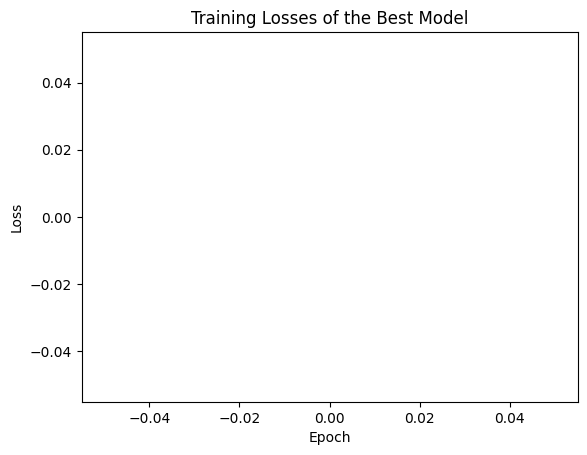

AttributeError: 'NoneType' object has no attribute 'eval'

In [35]:
print("Best Hyperparameters:")
print(best_hyperparams)

plt.plot(best_losses)
plt.title("Training Losses of the Best Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

test_acc, test_loss, true_labels, predicted_labels = testing(best_model, loss_function, test_loader)
print("Test Accuracy: {:.2f}%".format(test_acc))
print("Test Loss: {:.4f}".format(test_loss))

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()